# Memorias en CUDA

> Hasta este punto solo hemos visto y usados la memoria global del la GPU, la cual posee limitantes respecto a su uso tales como sus tiempos de acceso, la estructura de acceso, etc. Como veremos a continuación existen diversas capas de memoria que puden ser utilizadas durante la ejecucion de nuestros *kernels*.

>![Alt text](imagen/memLayers.png)
>![Alt text](imagen/memCUDA2.png)


> Algunas especificaciones de estas memorias durante la ejecucion de el *kernel* son:


![Alt text](imagen/cudaMem.png)

Es importante destacar que el uso de estas memorias posee diversas caracteristicas tales como su tamaño, la velocidad de acceso, la duracion dentro del flujo de ejecución.
La forma de declarar estas memorias dentro de nuestro kernel se da de la siguinete:
![Alt text](imagen/defMem.png)
La velocidades de accesos se muestran a continuación:
![Alt text](imagen/costMem.png)

> Como habran notado no se ha mencionado la memoria de Texturas, este tipo de memoria resulta estar ligada a otra estructura de CUDA llamada CUDA Arrays, estos objetos propios de CUDA y son la manera estructurada de generar arreglos en memoria (1D,2D,3D), la desventaja es que son espacios de memoria local que no podemos acceder directamente dentro de nuestros *kernels*. La lectura de la información contenida en CUDA Arrays se da solamente mediante las referencias conocida como Texturas. Los CUDA Arrays solo pueden ser escritos por dos metodo, Texturas de Superficies o copia entre bancos de memoria (Host o Device)


Veamos como usarlas. Aunque el escoger entre estas dependera exclusivamente del problema a resolver. Comparemos simplemente cada una de las memorias contra la **Memoria Global** midiendo el tiempo de ejecucion del *kernel*.

In [1]:
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import pycuda.driver as cuda
from pycuda.tools import DeviceData
from pycuda.tools import OccupancyRecord as occupancy

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Parte de lo que no hemos visto, es el elegir la GPU con la cual trabajar y generar un canal de comunicación (o contexto), usemos la siguiente funcion para tal efecto

In [3]:
def setDevice(ndev = None):
      ''' To use CUDA or OpenCL you need a context and a device to stablish the context o communication '''
      import pycuda.autoinit
      nDevices = cuda.Device.count()
      print "Available Devices:"
      for i in range(nDevices):
            dev = cuda.Device( i )
            print "  Device {0}: {1}".format( i, dev.name() )
      devNumber = 0
      if nDevices > 1:
            if ndev == None:
                devNumber = int(raw_input("Select device number: ")) 
            else:
                devNumber = ndev
      dev = cuda.Device( devNumber)
      cuda.Context.pop()  #Disable previus CUDA context
      ctxCUDA = dev.make_context()
      print "Using device {0}: {1}".format( devNumber, dev.name() ) 
      return ctxCUDA, dev

In [4]:
ctx,device = setDevice()
devdata = DeviceData(device)

Available Devices:
  Device 0: GeForce GTX 670
Using device 0: GeForce GTX 670


In [5]:
def getKernelInfo(kernel,nthreads, rt=True):
    ''' This function returns info about kernels theoretical performance, but warning is not trivial to optimize! '''
    shared=kernel.shared_size_bytes
    regs=kernel.num_regs
    local=kernel.local_size_bytes
    const=kernel.const_size_bytes
    mbpt=kernel.max_threads_per_block
    #threads =  #self.block_size_x* self.block_size_y* self.block_size_z
    occupy = occupancy(devdata, nthreads, shared_mem=shared, registers=regs)
    print "==Kernel Memory=="
    print("""Local:        {0}
Shared:       {1}
Registers:    {2}
Const:        {3}
Max Threads/B:{4}""".format(local,shared,regs,const,mbpt))
    print "==Occupancy=="
    print("""Blocks executed by MP: {0}
Limited by:            {1}
Warps executed by MP:  {2}
Occupancy:             {3}""".format(occupy.tb_per_mp,occupy.limited_by,occupy.warps_per_mp,occupy.occupancy))
    if rt:
        return occupy.occupancy
    
def gpuMesureTime(myKernel, ntimes=1000):
    start = cuda.Event()
    end = cuda.Event()
    start.record()
    for i in range(ntimes):
      myKernel()
    end.record()
    end.synchronize()
    timeGPU = start.time_till(end)*1e-3
    print "Call the function {0} times takes in GPU {1} seconds.\n".format(ntimes,timeGPU)
    print "{0} seconds per call".format(timeGPU/ntimes)
    return timeGPU

Al inicir un contexto de comunicacion con una GPU en específico ganamos algunas herramientas de control en la ejecicion de los kernels. En caso de haber mas de una GPU la funacion esta diseñada para preguntar que GPU usar

## Memoria Global vs. Registros vs. Shared vs. Constante.

> Veamos un ejemplo sencillos de como declara y usar los distintos tipos de memoria dentro de PyCUDA

In [6]:
# Definimos los kernels 
Reg_Glob_RW = '''
__device__ __constant__ cuPres cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;


cuPres pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(cuPres *A, cuPres *B){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;

B[tid] = 3.141589cuStr; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
__shared__ cuPres pi; 
pi = 3.141589cuStr; // Shared memory write
//__syncthreads();
A[tid] = pi; // Shared memory lecture and Global Memory write
}

__global__ void rwSharedSync(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
__shared__ cuPres pi; 
pi = 3.141589cuStr; // Shared memory write
__syncthreads();
A[tid] = pi; // Shared memory lecture and Global Memory write
}

__global__ void rwConstant(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;

A[tid] = cMem; // Constant memory lecture and Global Memory write
}

'''

##  PRECISION

In [7]:
presCPU, presGPU = np.float32, 'float'
#presCPU, presGPU = np.float64, 'double'

In [8]:
def optKernels(kFile,pres='float',subBlGr = False, cuB=(1,1,1), cuG=(1,1,1)):
    kFile = kFile.replace('cuPres', pres)
    cString = 'f'
    if pres == 'double': cString = ''
    kFile = kFile.replace('cuStr', cString)
    if subBlGr: 
        downVar = ['blockDim.x','blockDim.y','blockDim.z','gridDim.x','gridDim.y','gridDim.z']
        upVar      = [str(cuB[0]),str(cuB[1]),str(cuB[2]),
                      str(cuG[0]),str(cuG[1]),str(cuG[2])]
        dicVarOptim = dict(zip(downVar,upVar))
        for i in downVar:
            kFile = kFile.replace(i,dicVarOptim[i])
    return kFile

In [9]:
myKern = optKernels(Reg_Glob_RW,pres=presGPU,subBlGr=True)
print myKern


__device__ __constant__ float cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(float *A){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;


float pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(float *A, float *B){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;

B[tid] = 3.141589f; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(float *A){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;
__shared__ float pi; 
pi = 3.141589f; /

In [10]:
cuCodeRG = SourceModule(myKern)
regRW = cuCodeRG.get_function("rwRegisters") 
gloRW = cuCodeRG.get_function("rwGlobal")
shaRW = cuCodeRG.get_function("rwShared")
shaSyRW = cuCodeRG.get_function("rwSharedSync")
conRW = cuCodeRG.get_function('rwConstant')
#conMemRW = cuCodeRG.get_global('cMem')[0] #Obtenemos un puntero a la direccion de memoria constante declarada en el kernel
regRW.prepare('P')
gloRW.prepare('PP')
shaRW.prepare('P')
shaSyRW.prepare('P')
conRW.prepare('P')

>Observemos algunas diferencias entre el uso de cada una de las capas de memoria, los **Registros** en si no representa ninguna diferencia de lo que hemos estado usando, **Global** tampoco resulta novedoso salvo por que es necesario usar dos arreglos en distintos espacios de memoria global, La memoria **Shared** o compartida requiere de un ingrediente extra, como notaran existen dos versiones; una es asincrona dentro del bloque y la segunda es sincronizada en el bloque: La linea que cambia entre las versiones de Shared es *__syncthread()* este comando obliga a que en la operacion que realiza el kernel espere a que todos los threads dentro del bloque hallan acabado las tareas hasta este punto, la *ventaja* de esta funacion es que permite coordinar las ejecuciones de tareas del kernel, pero la *desventaja* es perdida en la velocida de ejecucion. 

>La memoria **Constante** es iniciada desde el cpu o en el momento de la declaracion, si es requerido pasar los datos en memoria constante. En PyCUDA es necesario hacer referencia a ella mediante la funcion de **SourceModule.get_global** y posteriomente hacer una copia mediante **pycuda.driver.memcpy_htod**. Para nuestro ejemplo hemos definido direactamente el valor a alojar en memoria constante, ya que no es un valor dinamis en el codigo no es necesaria la tranferencia de datos

In [11]:
# Copiamos como cualquiere elemento de cpu a gpu usando la direccion previamente obtenida, ojo solo tenemos 64KB de espacio
# cuda.memcpy_htod(conMemRW,  np.float32(3.15149)) # To copy the value to the constant cache
# Cada vez que queramos modificar los valores de la memoria cosntante se debe hacer una copia HostToDevice

Evaluemos la velocidad de las distintas implementaciones

In [12]:
from time import time

In [13]:
nLoop = 10
timeReg = []
timeGlo = []
timeSha = []
timeShaSy = []
timeCons = []
timeCPU = []
occK = []
cuBlock = (16,16,1) # 512,256,1024
threads = cuBlock[0]*cuBlock[1]*cuBlock[2]
cuGrid   = None
for i in range(8,14):
    
    
    N = 2**i
    a = np.ones((N,N),dtype=presCPU)
    b = np.ones((N,N),dtype=presCPU)
    A_gpu=gpuarray.to_gpu(a)
    B_gpu=gpuarray.to_gpu(b)
    #cuBlock = (16,16,1) # 512,256,1024
    threads = cuBlock[0]*cuBlock[1]*cuBlock[2]
    cuGrid   = (N/cuBlock[0],N/cuBlock[1],1)
    
    myKern  = optKernels(Reg_Glob_RW,pres=presGPU,subBlGr=True,cuB=cuBlock,cuG=cuGrid)
    cuCodeRG= SourceModule(myKern)
    regRW   = cuCodeRG.get_function("rwRegisters") 
    gloRW   = cuCodeRG.get_function("rwGlobal")
    shaRW   = cuCodeRG.get_function("rwShared")
    shaSyRW = cuCodeRG.get_function("rwSharedSync")
    conRW   = cuCodeRG.get_function('rwConstant')
    #conMemRW = cuCodeRG.get_global('cMem')[0] #Obtenemos un puntero a la direccion de memoria constante declarada en el kernel
    regRW.prepare('P')
    gloRW.prepare('PP')
    shaRW.prepare('P')
    shaSyRW.prepare('P')
    conRW.prepare('P')
    
    occK.append([getKernelInfo(regRW,nthreads=threads),getKernelInfo(gloRW,nthreads=threads),
                 getKernelInfo(shaRW,nthreads=threads),getKernelInfo(shaSyRW,nthreads=threads),
                 getKernelInfo(conRW,nthreads=threads)])
    
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    t5 = 0
    tcpu = 0
    for k in range(nLoop):
        t_reg = regRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_glo = gloRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata,B_gpu.gpudata)
        #ctx.synchronize() 
        t_sha = shaRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_shaSy = shaSyRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_con = conRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize()
        t = time()
        a[:,:] = np.pi
        b[:,:] = a
        t = time()-t
        t1 += t_reg()/nLoop
        t2 += t_glo()/nLoop
        t3 += t_sha()/nLoop
        t4 += t_shaSy()/nLoop
        t5 += t_con()/nLoop
        tcpu = t / nLoop
    timeReg.append(t1)
    timeGlo.append(t2)
    timeSha.append(t3)
    timeShaSy.append(t4)
    timeCons.append(t5)
    timeCPU.append(tcpu)
    A_gpu.gpudata.free()
    B_gpu.gpudata.free()

==Kernel Memory==
Local:        0
Shared:       0
Registers:    5
Const:        4
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       0
Registers:    7
Const:        4
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       4
Registers:    5
Const:        4
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       4
Registers:    6
Const:        4
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       0
Registers:    5
Const:        4
Max Threads/B:1024
==Occupancy

In [14]:
print myKern


__device__ __constant__ float cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(float *A){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;


float pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(float *A, float *B){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;

B[tid] = 3.141589f; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(float *A){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;
__shared__ float pi; 
pi

In [15]:
occK,occK[:][0]

([[1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0]],
 [1.0, 1.0, 1.0, 1.0, 1.0])

([<matplotlib.axis.XTick at 0x460d7d0>,
 <a list of 6 Text xticklabel objects>)

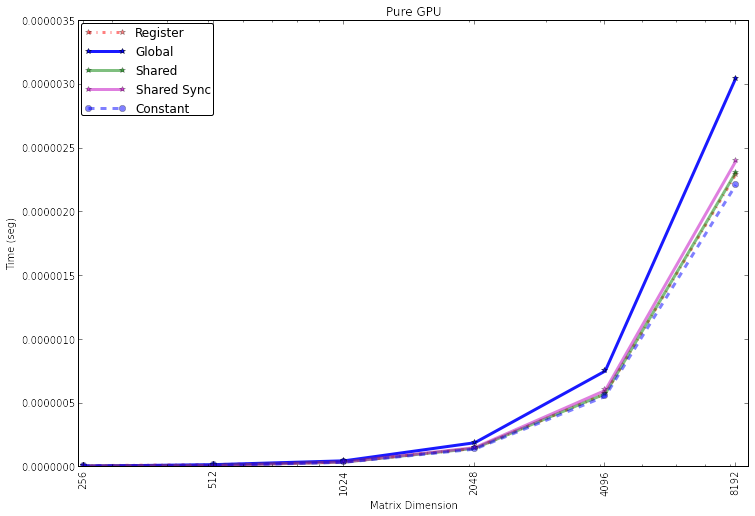

In [16]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.semilogx([2**i for i in range(8,14)],np.array(timeReg)*1e-3,'r-.*',label='Register',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeGlo)*1e-3,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],np.array(timeSha)*1e-3,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeShaSy)*1e-3,'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCons)*1e-3,'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.title('Pure GPU')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')

([<matplotlib.axis.XTick at 0x4636750>,
 <a list of 6 Text xticklabel objects>)

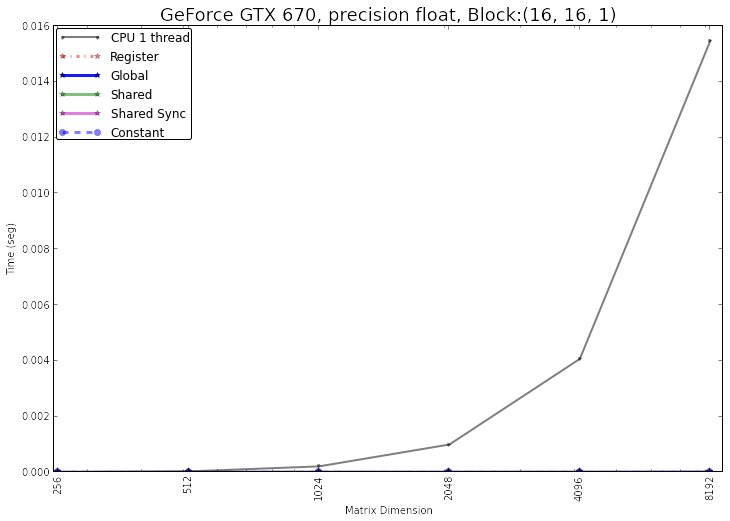

In [17]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('{0}, precision {1}, Block:{2}'.format(device.name(),presGPU,cuBlock),size=18)
plt.semilogx([2**i for i in range(8,14)],timeCPU,'.-',color=(0,0,0),label='CPU 1 thread',linewidth=2.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeReg),'r-.*',label='Register',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeGlo),'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeSha),'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeShaSy),'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeCons),'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')

([<matplotlib.axis.XTick at 0x4e854d0>,
 <a list of 6 Text xticklabel objects>)

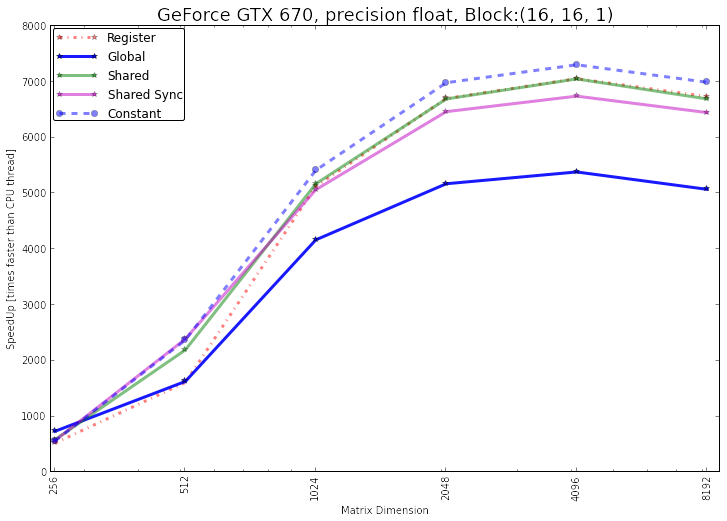

In [18]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('{0}, precision {1}, Block:{2}'.format(device.name(),presGPU,cuBlock),size=18)
#plt.semilogx([2**i for i in range(8,14)],timeCPU,'.-',color=(0,0,0),label='CPU 1 thread',linewidth=2.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeReg)),'r-.*',label='Register',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeGlo)),'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeSha)),'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeShaSy)),'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeCons)),'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.ylabel('SpeedUp [times faster than CPU thread]')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')


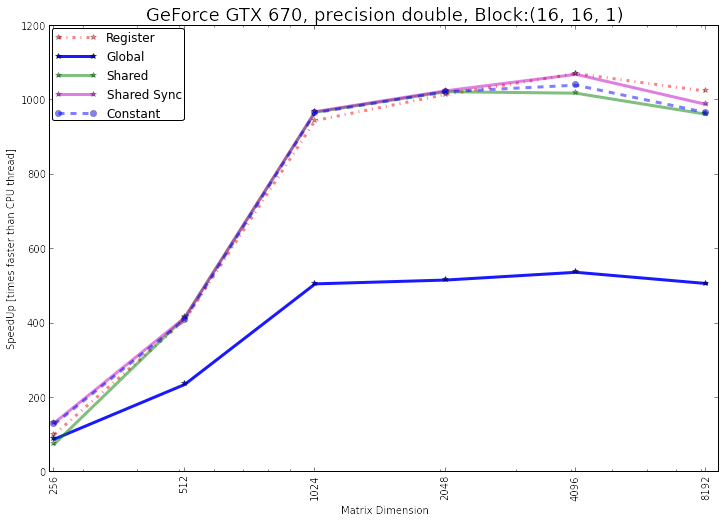
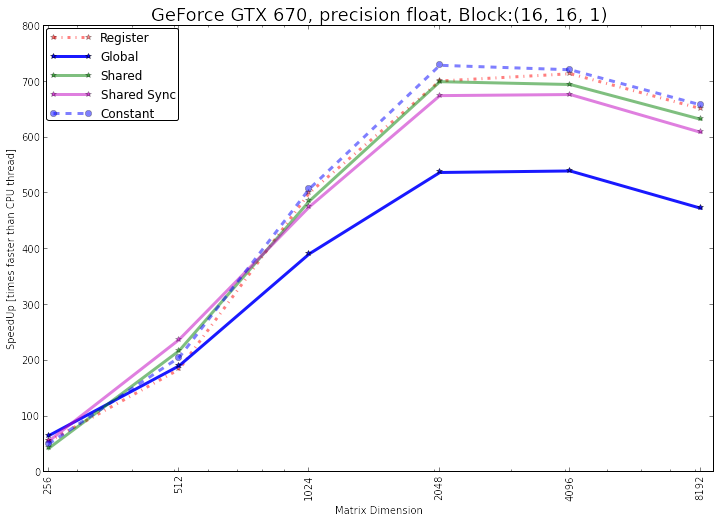

In [19]:
%%HTML
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtYAAAIJCAYAAACBeHo8AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzsnXdcFEcbx397hYOjHR1EigJS7FFBsSGIvZvYCxF7f40l0SS219hNglFjRWNLYl57CyJBsQQ7FgQbSEd6O7i67x/r4nEceAiI4nw/n/lwzM7sPDM7t/fss888Q9E0DQKBQCAQCAQCgVA9OHUtAIFAIBAIBAKBUB8gijWBQCAQCAQCgVADEMWaQCAQCAQCgUCoAYhiTSAQCAQCgUAg1ABEsSYQCAQCgUAgEGoAolgTCAQCgUAgEAg1AFGsCQQC4QMgICBgL4fDUVa1Xnx8vCOHw1EuX758aW3IVV2WLVu2jMPhKBMSEuxru63w8HAfDoej3Ldv33htyr/rmL8v3pd8Pj4+4Y0aNYqr7nlevXplaWxsnLd79+7AmpCLwDB48OBjvr6+YXUtB0E7iGJNqHFKSkp0t27dOt3X1zfM0tLylY6OjtTExCTH09Pzxtdff70mNjbW9V3Pzf5wVpRu3LjhWZN9qQuioqJaTpo0aWeTJk2eGBgYFOrp6RU7OjrGDx069H8HDhwYI5fLeW8bB9XUuHHjFwAwatSoQ1wuVxEWFuar3mZxcbGeq6trrLm5eearV68stZEzOzvbdP78+RucnZ2f6enpFVtaWr7y9fUNu3LlSifVcm+T74cfflisWl6pVHJ+/PHH/7i5ucXo6ekV29vbJ8yfP3+DWCwWVmdcP3QoiqIpinrnjQWqU7e+UZWxeJ/j5ujoGK8697lcrsLGxibVx8cn/I8//hhel/LVRDvffvvtf62srNK//PLLYNX87du3Txk9evRBNze3GC6Xq9DmYeH69esdBg4ceMLCwiJDT0+vuHHjxi9GjRp1SCaT8d9VvtjYWNf58+dv8PX1DROJRLnaPJCKxWLhihUrvm/atOkjoVAoNjMzy/L29r52/PjxQe8qB1C1MVm+fPnSS5cudT116lT/6rRJeD/w6loAQv3ixYsXjfv163c6JibGzcfHJ3zevHmbbGxsUgsLCw3u3r3bes+ePRM2bNgwPzEx0c7Gxib1XdsZNWrUoT59+pxVz3dycnpevR7ULT/88MPi7777bqWZmVnW8OHD/2jWrNlDHR0daWJiol1oaGj3cePG/XblypVOK1as+P7AgQNjVOtu3759SkREROeffvpprrm5eSabb2BgUAgAW7ZsmREeHu4TGBi4+8GDB83ZfAD4+uuv1zx9+tTl999/H2FpafnqbXK+fPnSwcfHJ1wsFgsDAwN3N2nS5Elubq7owYMHzVNSUhqollWXEwBomqaWLVu27MWLF40HDBhwUvXYf/7znx83b948a8iQIUcXLFiwPjo62iMoKGj23bt3W4eGhnavrwrkzp07J23fvn1KVes5OjrGl5SU6HK5XEVtyFXfoWmaep/t2dnZJa5evfobAFAoFNykpKSG+/btGz9y5MjDqampNnPnzv2pLuV7V5KSkhoGBwd/uWnTpnnqSuKaNWu+zs7ONm3duvVdsVgsTE5Otq3sXMHBwV9OnDhxV4cOHa4vXrz4B5FIlJucnGx75cqVTnK5nMfn82XvIuP169c7/Pjjj/9xdnZ+1rZt21thYWG+ld1PcnJyTPz8/C4+e/bMecKECXtatmwZVVRUpP/48WP36r6BqcqYtGjR4r6Pj0/4ypUrv+vfv/+p6rRLeA/QNE0SSTWSxGKxnpub22OBQFBy/PjxgZrKlJSUCNasWbMoJSXF5l3a+Oeff3woilJu3LhxXm32JT8/3/B9j19wcHAARVFKf3//kIrav3fvXsutW7dO03Rs/PjxeymKUr58+dK+ojZOnjzZn6Io5eTJk7erj+mwYcP+0FbWTp06Rdjb279MS0uzepe+JiYmNuRwOApPT89I1fyHDx82pShK+fnnnx9Rzd+8efNMiqKUhw4dGvm+r0tdz4uPPS1dunTZ2+ZlTSV2Lu/bt2+cNuXZ78z7GgsHB4f45s2b31fPz8rKMtXR0ZG0atXqbl3I17Vr1/BGjRq9qM45vv3225V8Pl+akZFhrn5M9dr37dv3NIfDUVR0nkePHnno6OhIJk2atKOm+5mdnW2Sl5dnRNM0bt261YaiKOXy5cu/r6j8mDFj9hsbG+c+fvzYraZlqcqY0PSb34c7d+60ru35QFL1EnEFIdQYu3btmhgbG+u6YMGC9QMHDjyhqYxAIJAsWrRorbq1Oi8vz3jRokVrnZ2dn+nq6pZYWlq+GjVq1KG4uLhG7yrP5cuXu/j7+18QiUS5QqFQ3KZNm9t79uyZoF6O9S+Mi4tr9Pnnn/9lamqabWxsnMceT0tLs549e3ZQ48aNX+jq6pZYWVml9+jRIyQ0NLS76nmePn3qMnbs2P02NjapAoFA0qhRo7iFCxeu08aFQSqV6ixevPgHIyOj/D///HOYoaFhgaZyLVu2jJo2bdq2dxkPAOjfv/+psWPH7t+5c+ekkJCQHgUFBYZffvllsJWVVfq2bdumaXOOy5cvd7l69WrHhQsXrrOyskqXyWT8qrppBAcHf0nTNDVx4sRdqvmHDx8eCQDqVrtJkybtFAqFYk3Wb23Zu3dvAIfDUV68eNFv2bJlyxwcHF7q6uqWtGzZMkrTa3hHR8f4bt26/XP37t3WPXv2/FskEuW2bNkyij1eleutzRzS5E+bmJhoN2HChD2srFZWVukdO3a8+ttvv41jy1TkYy2Xy3lr165d5OHhEa2np1dsbm6eOWTIkKMPHz5splpOtf7p06f7tWvX7qaenl5xgwYNUhYuXLhOoVBwtRlfpVLJWb169TeNGjWK09PTK27evPmDQ4cOjaqo/P3791sMHjz4mJmZWZaenl5x06ZNH61fv36BUqks87tUkf9vZb7lNE1TmzdvntWkSZMnenp6xa6urrG//PLLTG36AQCpqak206ZN22Zvb58gEAgktra2yVOmTNmekZFhoe05qoJIJMoVCAQSHR0dqTbltR07QPv7lzpZWVlmHTp0uC4SiXL/+eefbmz+8+fPnTS58x05cuSLdu3a3VR9W8Zib2+foE2/AGDDhg3zKYqi161btxAAioqK9OVyeY28XTcxMckxMjLKB97+JiA+Pt7x8OHDIydNmrTTzc0tRqFQcAsLCw1qQg6gamMCAL169ToPAH/++eewmpKBUDsQVxBCjfHXX399TlEUra4svY28vDxjb2/va4mJiXaBgYG7mzZt+iglJaXB1q1bp3t5eUXeunWrrfpNqKioSD8zM9NcNU9XV7eEdW84depU/8GDBx9r0KBByvz58zcYGhoWHD58eOTEiRN3vXjxovF///vfb9l6FEXRhYWFBl27dr3UqVOnK6tXr/6G9TOOj4937Nix49VXr15Zjh8/fl/btm1vFRYWGvz777/tL1686Ne9e/dQALh9+3YbX1/fMFNT0+xp06Zts7W1Tb53716roKCg2VevXu146dKlrjweT17RGFy9erVjWlqa9fjx4/eJRKLcqoxfVQkKCpodFhbmO3HixF2dO3eOePnypcPRo0eHmJqaZmtT/+zZs30A5pV2//79T50/f76XQqHguri4PP3+++9XjB49+mBl9WmapoKDg780MDAoHDly5GHVYzdv3mzH5XIVnp6eN1TzBQKBpGXLllE3b95sV9X+qrNo0aK1YrFYOHPmzF9YWUaOHHm4pKREd/z48fvYchRF0QkJCfZ+fn4Xhw0b9ucXX3xxhP1hrcr11nYOsW2yn+VyOc/f3/9CSkpKgxkzZmxp0qTJk7y8POOoqKiWV65c6TRu3LjfVPul/kp79OjRB48cOfJFjx49QmbMmLElNTXVZsuWLTM6dOhwPSIionOrVq3uqZY/e/Zsn61bt06fNm3atokTJ+46fvz4oA0bNsw3MTHJ+eabb1a/bVznzZu3KSgoaHbXrl0vffXVVxvT09OtZsyYsYX18Vfl1q1bbbt27XpJIBBIZsyYscXa2jrt5MmTAxYtWrQ2KiqqpfoDVGWv6zUd27x586y0tDTrqVOn/mpoaFhw6NChUbNnzw7Kzs42/f7771dU1o+EhAT7Dh06XJfL5bzAwMDdTk5Oz58+feqybdu2af/880+3W7dutWWVs3dBLpfzsrKyzGiaphQKBTc1NdXm559/nlNUVKQ/ZcqU7W+rX5Wxq8rcUyUuLq5Rr169zhcVFelfvny5S4sWLe6zx/z8/C4mJCTYqyrx6enpVk+ePGkyZ86cn991XFjOnTvX283NLeaff/7ptmDBgvUvXrxozOfzZd27dw/9+eef5zg7Oz+rbhvacP78+V5KpZLj7u7+eOzYsfuPHDnyhVQq1bG1tU3+6quvNqo//Nc21tbWaY6OjvHh4eE+77NdwjtQ1yZzkupPMjU1zRKJRDnq+QqFgpORkWGumoqLi3XZ47Nnz/5ZKBQW3b9/v7lqvZcvX9obGRnlBQQEBLN57KteTWnkyJGHaJqGXC7n2tvbvzQxMclOTU21ZutKpVJ+x44dr3C5XPnTp0+d2fyuXbuGUxSl/O6771aoy967d++zHA5HERIS4q9+TKlUUuznFi1aRLm7u0cXFhbqq5Y5duzYIIqilHv37h1f2dgFBQXNoihK+dNPP81RP5afn2+oOnaZmZlmms6hjSsIm86dO9eLHbcxY8bsr8p1HjRo0DGKopSWlpbpnTp1ijh06NDI4ODggGbNmj2gKEoZHBwcUFn90NBQP4qilBMmTNitfqxZs2YPrK2tUzXV++KLL/6kKEopk8l47zI/2Vepjo6OcaouHXl5eUYODg7xpqamWarz0sHBIZ6iKOXu3bsnqJ+rKtdb2zmk/to/KiqqBUVRyvXr18+vrF9xcXGO6q+0Q0JC/CmKUo4YMeKwatmoqKgWPB5P1rlz58vq9Q0MDArU506zZs0e2NjYpLxtbGNiYlwpilJ27979gmqf7ty505qiKCWHw1Gontvb2/sqn8+XPnjwoJnqeYYNG/YHRVHKixcv+rJ5FbkpaOo3e38wMjLKS05ObsDmS6VSvqenZySfz5cmJSXZVjTmNE1jwIABJ6ysrNJU69M04zrA4/Fky5YtW/ou8091TqknPT098c6dOyeql9ckX1XGTtu5pzrGd+7caW1tbZ3q7u4erele4ujoGKfuthAWFtaNoijl5s2bZ75tDCpze8jNzTWmKEppZmaWyefzpfPmzdt4/PjxgcuXL/9eV1e32MrKKu1d3c/U082bN9tW5goyd+7cH9n7XNOmTR/u3bt3/MGDB0d17tz5MkVRyqVLly6rCTneNiaqyc/PL9TQ0DC/ptolqXZSnQtAUv1JPB5PZm9v/1I9/8GDB83Uf0g2bNjwFU0zN3czM7PMXr16ncvMzDRTV8D9/f1DGjRokMyei/3hnDp16raLFy/6qqZHjx550DSNyMhIT4qilF999dUGdVlOnDgxQLV9mmZ+VDgcjoL1vWNTVlaWKUVRyj59+pyprN/3799vTlGUcsWKFd+py//q1SsLfX39wlGjRh2s7Bz//e9/l1AUpdyzZ8+X6seGDh36l+rYGRgYFGg6R1UU63///deLw+EoKIpSHj58eERVrrOfn18oRVFKZ2fnp6pKbk5OjsjExCTbxsYmRfVHWz2NGDHiMEVRyqtXr3qrH2vcuPFzBweHeE31xo4d+xtFUUr166RtYhXrtWvXLlQ/tnr16q8pilKeO3euF5vn4OAQb25unqHel6pcb23nkOr1Y/+Pj493oChK2bt377OvXr2yqKieJgVz2rRpWymKUqorXzRNY/DgwUcpilKyD2hsfU0PWDNnztxMUZSyqKhIWJnsa9euXUhRlPLs2bO91Y/17NnzvOq8TE9Pt6QoSjl06NC/1MuyDxMzZ87czOa9i2I9bdq0rerlDx8+PIKiKOW2bdumVjTmubm5xhwORzFp0qQd6tc2IyPD3NXVNcbb2/vqu8w/dk41btz4OXvPCg0N9du3b9+4bt26hXG5XLn6Q6m6fFUZu6rMva5du4Y7OjrGXbhwobuhoWG+t7f31ezsbBNt+/XHH38MoyhKefDgwVFvK1uZEpmYmNiQvc+pGzr27t07nqIo5aJFi9a86/irprcp1oGBgbsoilKamJhkq46FTCbjubi4PNHT0xPn5OSIakIWbRVr9uGppKREUBPtklQ7ifhYE2oMIyOj/Pz8fCP1/MaNG78IDQ3tHhoa2n3Dhg3zgTevbzMyMiyys7NN//77754WFhYZlpaWr1RTaGhod03h31xcXJ76+vqGqSYPD49ogHmNCQBNmzZ9pF5PvQyLhYVFhvrr3WfPnjkDQOvWre9W1u/Hjx+7A8DSpUuXq8tvZWWVLhaLhW8LYce2rWn8li1btiw0NLT7hQsX/Fu0aHG/ulExWJcHExOTHDs7u8R58+Ztys3NFWlbX09PrxgARo4ceVjVvUUkEuX279//VFpamvWTJ0+aaKqbnZ1teuzYscHu7u6Pvb29r6kfFwqFYolEIqhIboqiaKFQKNZWVk24u7s/rihPfV44OTk9Vx/vqlxvbeeQJhwcHF4uWbJkVUhISA8bG5vUtm3b3lq0aNHaW7dutX1b3bi4uEZcLlehqa8VfQc0uWyYmZllAYy/bWXtvXjxojEAuLm5xagfU5ehsu+nm5tbDEVRdHXWVmhqUzWvsnPHxsa60jRN7dq1a6L6tbW0tHz15MmTJtqGo6wIfX39Ivae5efnd3HcuHG/Xbhwwd/DwyN61qxZm7Ozs00rqluVsavq3EtPT7fq27fvGWdn52cXL170MzExydG2T+x3hK5mBBP23kJRFB0QELBX9djo0aMPcjgc5aVLl7pWp42qytKvX7/TqmPB4/Hko0aNOlRSUqIbGRnp9T5kYaFpmqKqGZaTUPsQH2tCjdGsWbOHERERnePj4x0dHR3j2XyhUChmg9urL85ib8T+/v4XFi1atPa9CqxCdZQ1tg/z58/fwC4wUedtP1LNmzd/AAB3795trX6sWbNmD9nPNeF/vXjx4h+ePHnS5NChQ6PMzc0ze/ToETJ79uwg1QVxldGwYcMkgPH5Uz/GLkrNyckx0VT34MGDo6VSqU5gYOBuTccbNGiQEhMT4yaTyfjqIbWSk5Ntzc3NMyvzVa9pNM2Lmrje2rJy5crvJkyYsOfMmTN9IyIiOu/atWvi+vXrFyxcuHDdmjVrvq6JNlgqC9dXXYWpOlSkRNTUgjZV2H6OHTt2v6q/vSqswlWTcLlcha+vb1hQUNDsyMhIr969e5+r6TbehqmpaXabNm1unz59ut+BAwfGVGWtjIWFRQbAPDhXVwY9Pb3ikpISXfX7C4/Hk5ubm2dWdG+paSq7z7F570sWluzsbFMDA4NCbRe5EuoGolgTaowvvvjiCPvjr7o4sDIsLCwyRCJRbl5ennFN7SzFxrJWj34AANHR0R6AZuucOs7Ozs8oiqI1KbuqNGnS5AnAPDS8ax86dux41draOu3YsWODN23aNE/bhYRVJSIiovPPP/88Z+jQof8bMWLE7wAwefLkHTt27Jj8xRdfHNEmRqqXl1fk9u3bpyQmJtqpH0tKSmoIABXFwt69e3egjo6OVH3hHYunp+eNCxcu+EdGRnp16tTpCptfUlKie+/evVY+Pj7hWna1QqKjoz3U+1mVeVGV663tHKqMRo0axc2cOfOXmTNn/iKRSAQ9e/b8e926dQvnz5+/QVMEBoDph0Kh4EZHR3uwD20s0dHRHhRF0TWx0x4L+517/Pixu/p52bFV7Q+g+fsZExPjRtM0pXodTE1Ns+/cufOZelnWSq4J9TZV8yq7xuz1kkgkgve90x278UllkSeqMnZVnXs6OjrSo0ePDhk2bNifU6ZM2S6TyfjaRiBiLehPnz510aZ8RVAURbdr1+7m5cuXuyQmJtq5urrGssckEokgIyPDgv3+1TZeXl6RABOZR/3Y2+5ztcWzZ8+cVQ0thA+UuvZFIan+pOLiYl13d/doHR0dybFjxwZpKsMuclGNQ836cf71119DNdVR9S/VJo61QqHgODg4xJuYmGSrLnSRSqX8Tp06RXC5XPmzZ8+c2PzKYrj27dv3NEVRytDQUL/K+t68efP7xsbGuS9evGikfkwmk/G08VdkfYC7d+9+oSI/4i5dulyqaPHK23ysCwsL9Z2cnJ5ZWlqmq8aaLSgoMHBwcIi3sbFJ0cZnMCcnR2RkZJTXsGHDRNXFeykpKTb6+vqFbm5ujzXVY30a1WNUq6YHDx4043A4CnUfUnZxpzY+nG8bXwcHh3jV8c3NzTW2t7d/qWnxYrdu3cKqe721nUPjx4/fq+pnmZeXZySVSvnq5aZMmfIrRVHKJ0+euNC0Zl/jCxcudFdd0Ks6vlwuV96lS5dLbJ6m+mzSNgZ1TEyMK4fDUfj5+YUqFAoOm3/79u3POByOQn3xYseOHa/w+Xzpw4cPm7J5SqWSYv3vw8LCurH533zzzQ8URSlv3LjRjs1TKBScXr16navIx9rQ0DBfdZGiRCLRadeu3Q1NixfVfVv79et3is/nS//9918v9X4qlUpKU5xmbVNFcayLi4t1Gzdu/JzD4ShU702a5KvK2Gk791TvgXK5nMv68v7888+z1cs+e/bMKSYmxlU9v1mzZg/atm17821j8DZ/4l27dgVSFKWcM2fOT6r57D1g9erVX7/r+Kumt/lYKxQKjqOjY5y+vn6h6kLWwsJCfTs7uwRTU9MssVisVxOyaONjnZqaak1RlPKbb775oSbaJKn2ErFYE2oMXV3dkjNnzvTt16/f6SFDhhz18fEJ9/f3v2BtbZ2Wn59vFBMT4/bHH38M5/F4cjs7u0S23qpVq5ZcvXq147Bhw/4cNmzYn15eXpE6OjrSly9fOpw9e7ZP27ZtbwUHB3+prRwcDkf5yy+/zBw8ePCxdu3a3Zw8efIOAwODwj/++GN4ZGSk15IlS1ap79BIV/Cq+5dffpnp7e19rXfv3ufGjx+/77PPPrtTXFysFxkZ6dWoUaM49nX8/v37x/r6+oa1aNHi/oQJE/Z4eHhEi8Vi4bNnz5yPHTs2eM2aNV9XZKVlCQgI2JuSktLgu+++W+nk5PR8+PDhfzRt2vQRn8+Xpaam2oSEhPS4evVqR3ULpLYsXLhw3YsXLxr/+eefw9R3Zty1a9dEbV1CRCJR7oYNG+ZPmTJle/v27f+dMGHCHolEIti2bds0uVzO27x58yxN9Xbv3h0IAJW9Ym7WrNnDGTNmbPnll19mDh069H+9e/c+9/jxY/fNmzfP8vHxCR81atQh1fJ79+4NmDBhwp6lS5cuX7p06XJtxsHCwiLDy8sr8ssvvwymX4fbS0pKarhr166Jurq6JdqcoyrXW9s5BJSdh2FhYb6TJ0/e8fnnn//Fbm9/+/btNrt37w5s3779vy4uLk8rkq979+6hw4YN+/P3338fkZOTY9K3b98zaWlp1lu2bJkhFArFQUFBs7Xpp7a4urrGstfN19c3bMiQIUdfvXpluWXLlhmtWrW6p241/fnnn+d07dr1UufOnSNmzJixxcrKKv306dP9QkJCeowePfpgt27d/mHLTp48ecfGjRu/Gjx48LE5c+b8zOfzZX/99dfnlcXXbtKkyRMvL6/IqVOn/mpgYFB46NChUbdu3Wr7/fffr7C1tU1WLav+3d+2bdu0Tp06XenSpcvlcePG/daqVat7SqWS8+LFi8YnT54cMH78+H2qIfs4HI7SwcHhpbZ+4bm5uaKDBw+OpmmaommaSklJaXDgwIExcXFxjSZPnrzjbfemqozdu8w9LperOHz48Eg+ny+bO3fuT3K5nDdv3rxNbDlN4fYA5o3lypUrv0tLS7NWd584depU/6ioqJYAY3WlaZpatWrVEpqmKRMTk5wZM2ZsYct++eWXwb/99tu4oKCg2ZmZmeadOnW68uDBg+Y7duyY3KxZs4ezZ88OUj23j49P+OXLl7vEx8c7vi02dH5+vhE799kdYi9dutSVfcM6cODAE+z9lcPhKLdu3Tp9wIABJzt06HB9+vTpW/l8viw4OPjL5ORk2927dwequgWFh4f7+Pr6ho0fP36fNr9XVRkT4E2Y0y+++OLI285NqGPqWrMnqf6l4uJi3S1btkzv1q1bmLm5eQafz5eKRKKcdu3a3Vi0aNEa1tKmmsRisd7KlSu/bd68+X09PT2xoaFhvoeHx6PJkydvV7VUVWXnxUuXLnXx9/cPMTIyytPV1S3+7LPPbmuKuuHj4/NPZbuOJScnN5g6deo2e3v7lzo6OhIrK6u0nj17nle1DNE0Ex5w6tSp2xwdHeN0dHQkZmZmmW3btr25ePHiVapWsrele/futZw4ceJOFxeXJ0KhsEhXV7fYwcEhfsiQIf87ePDgKLlcztVULyAgIFjdMsim0NBQPw6Hoxg+fPjvFbU7ZcqUXzkcjuLUqVP9tJHz6NGjg9u3b39dX1+/0NDQML9nz57nr1271kFTWbFYrCcSiXIqivihmhQKBWfjxo3zXF1dYwQCQUnDhg0Tv/rqqw2aIlOwVqxdu3YFvu28rMX64sWLvkuXLl1mb2//UiAQlLRo0SJKU2QUR0fHuIos1lW93trMIfb6sf/HxcU5Tp06dZu7u3u0kZFRnr6+fqGHh8ejpUuXLlMNF1iRxVkul3PXrl270N3dPVogEJSYmZllDh48+KiqpbOy+jRNY9myZUsrmlPqSalUUqtWrVrs4OAQLxAISpo3b37/0KFDIys6R1RUVItBgwYdMzU1zRIIBCUeHh6P1q9fP19TRJmzZ8/2btWq1V2BQFBia2ub9PXXX6+OjY1toslizeFwFPv27RsXFBQ0y8XF5YlAIChp0qRJbFBQ0KyKvjPq+ZmZmWYLFixY16RJk1hdXd1ikUiU06JFi6i5c+f+qLoLX35+viFFUcpOnTpFaPOdYUPVqUb50dfXL/T09Iz89ddfp2grX1XGTpu5p+keqFQqqYCAgGCKopRr1qxZpN4H9XZSUlL5/xI1AAAgAElEQVRs+Hy+VNO9mT0PG3pRdQw03XuLioqEX3/99Wr2u9WwYcPEWbNmBeXm5hqrl/3ss89uGxgYFGgTLYid65pkYeeNep1Lly518fX1vWhoaJgvFAqLOnXqFHH69Om+6uXYXW2//fbbldrMhaqOiY+Pzz/qO9WS9GGmOheAJJJIIuld0+DBg482adIktqKHDdXEKtaXLl3qUtdyk1Q/Ehu+Mzw8vGtdy/IhpKlTp25r3Ljx83eNNV/VlJ2dbcLlcuXViS1eU+k///nPJjMzs8yaCsGnmu7evduqKkYPkuo21Vq4vQkTJuyxsrJKV31tvWDBgvXu7u6PW7ZsGTVkyJCjeXl5xuyx1atXf+Pi4vLUzc0tJiQkpAebf/v27TbNmzd/4OLi8rQmdnUiEAj1A7lczvvnn3+6rVmz5uvKIloQCLVFSEhIj/79+5/q2rXrpbqW5UNgxYoV32dlZZnt3bs34H20Fxoa2t3Kyip94cKF695He5UREhLSY8mSJatqY+fc5cuXL/Xx8Qnv16/f6Zo+N6EWqC2N/fLly53v3LnTulmzZg/YvJCQEH92YcuiRYvWsIHeHz165NGyZct7UqmUHxcX5+jk5PSMfaXVrl27G5GRkZ40zewipbqBA0kkkUSStolYrEkiiSSSSKrtVGsW686dO0eox3L19/e/wMYx9vLyimRD1pw4cWLgyJEjD/P5fJmjo2O8s7Pzs8jISK/U1FSbgoICQ09PzxsAMG7cuN+OHz8+qLZkJhAI9RuysQKBQCAQapM6iwqyZ8+eCSNHjjwMMKtz27dv/y97rGHDhknJycm2fD5fxgZpBwBbW9vk5ORkW/VzkR9LAoGgLeS1PYFAIBCqA13Jpll1sqX5qlWrlujo6EjVQ2dVB1Uz/NKlS+vE/F9X7ZJ+VSznpzQX3kebtdVGbcv+scxhkmr/upO5ULXxqi9JvW8fYl8/JJk+ld+wd2nzbbx3i/XevXsDzp492+fixYt+bJ6trW2y6u5GSUlJDRs2bJhka2ubzLqLsPnqMUg/JHx8fOpahFrhY+nXhyRnXcjyPtqsrTY+pGtHqD+QeVU16vN4fQx9+5BkJL9h7857VazPnz/fa/369QsuXbrUVXUjhgEDBpwcNWrUoXnz5m1KTk62ffr0qYunp+cNiqJoIyOj/MjISC9PT88b+/fvH6seHF6dpKQk7Nu3DytXroRSqaz9ThE+OCiKgqWlJQIDA0FRFb6tqVXITenDOC/h04bMq6pRn8frY+jbhyQj+Q17d2rNFWTkyJGHvb29r8XGxrra2dkl7tmzZ8KsWbM2FxYWGvj7+19o3br13enTp28FAA8Pj+hhw4b96eHhEd27d+9zW7dunc76TW/dunX6xIkTd7m4uDx1dnZ+1qtXr/OVtTt48GBMmjQJxcXFdf4qhaS6SVKpFNeuXcOjR49w8eLF2prihI+ID+kHi1C3kLlAAMg8IDDUxjygtPEX+dChKIpm+8HlclFcXAwdHZ06lopQ1xQXF8PIyAgymayuRSEQCAQCgVAPoCgKdCWLF+udYv26w3UsEeFDgcwHAoFAIBAINcXbFOs6iQpC+HBISEiAoaEhUT4JBAKBQCAQqglRrD8iHB0dIRQKYWhoCGtra4wdOxb5+fnVOqe9vT0KCgreushv79696Ny5c7XaIhAIBAKBQKjPfBKKNU3TuHr+/Adhla2OLBRF4fTp0ygoKEBUVBQePHiA//73v7UgZc0jl8vrWgQCgUAgEAiEWuWTUKyfR0ej4NgxPI+OrmtRakwWKysr9OjRA48ePQIA/Pvvv/D29oaJiQlatWqFS5febC4XFxeHLl26wMjICP7+/pgxYwbGjh0LAIiPjweHwykNTbh37144OTnByMgIjRs3xqFDhxATE4OpU6fi+vXrMDQ0hKmpKQBAIpFg/vz5cHBwgLW1NaZNm4aSEiaKYnh4OBo2bIh169bBxsYGgYGB1eovgUAgEAgEwodOnW1p/j64f/MmHp47ByupFD1LShA2bRpucLloNnw4WkydWrZweDjzVz30Snh42WOajmtR776+/htZrK0RdvgwbujooFnv3mjRrp3WfWIt3UlJSTh//jw+//xzJCcno1+/fjhw4AB69eqF0NBQDB06FLGxsTAzM8OoUaPQuXNnhIWFITIyEn369MHAgQPLnbuoqAhz5szBrVu34OLigvT0dGRlZcHNzQ3bt2/Hrl27EBERUVr+66+/RlxcHKKiosDj8TBq1CisWLECP/zwAwAgPT0dOTk5SEhIgEKh0LqPBAKBQCAQCB8j9dpi3bxtW7QbMgS0RMKs4lQo4OnujuaurnUvi0QCz6FD0bxtW63PQdM0Bg0aBCMjI9jb28PJyQlLlizBgQMH0KdPH/Tq1QsA0L17d7Rt2xZnzpxBQkICbt26hRUrVoDH46Fjx44YMGBAha4oHA4HDx48QHFxMaysrODh4VHatrosO3fuxKZNmyASiWBgYIBvvvkGv//+e5lzLV++HHw+H7q6ulUdMgKBQCAQCISPinqtWFMUBYqiIM/Px980DblEUppf57K8XnRYFVkoisKJEyeQn5+P8PBwhIWF4fbt23j58iWOHDkCExOT0nT16lWkpaUhJSUFpqamZRRbOzs7jefX19fHH3/8gV9//RUNGjRAv379EBsbq7FsRkYGxGIx2rRpU9pm7969kZmZWVrGwsKCxBMnEAgEAoHwyVCvXUEAIC8jA86zZ8PJwwPPo6ORn5kJdO1avmBFu+9ocv94x3oaZXlHunTpglmzZmHRokXo2bMnxo4dix07dpQr9/LlS2RnZ6O4uBh6enoAmBB7FSn0PXr0QI8ePSCRSLBkyRJMmjQJly9fLlfe3Nwcenp6iI6Oho2NjcZz1dV24gQCgUAgEAh1Qb22WANAGx8fODdtCoqi4Ny0KT7TpFR/pLLMnTsXN27cQKdOnXDq1CmEhIRAoVCgpKQE4eHhSE5OhoODA9q2bYtly5ZBJpPh+vXrOH36tEal99WrVzhx4gSKiorA5/Ohr68PLpcLgFksmZSUVLqLIYfDwaRJkzB37lxkZGQAAJKTkxESElKtPhEIBAKBQCB8rNR7xbo+Y25ujvHjx2PTpk04efIkfvjhB1haWsLe3h4bN24sjfRx8OBBXL9+HWZmZvjuu+8wfPjwMi4arJKtVCrx448/wtbWFmZmZoiIiMC2bdsAAH5+fmjatCmsra1haWkJAFi7di2cnZ3Rvn17GBsbw9/fH0+ePCl3XgKBQCAQCIRPAbKl+SfI8OHD4eHhgaVLl9a1KLUOmQ8EAoFAIBBqCrKlOQG3bt3C8+fPoVQqce7cOZw8eRKDBg2qa7EIBAKBQCAQ6hX1fvEiAUhLS8OQIUOQlZUFOzs7/Prrr2jZsmVdi0UgEAgEAoFQryCuIIR6DZkPBAKBQCAQagriCkIgEAgEAoFAILwHiGJNIBAIBAKBQCDUAESxJhAIBAKBQCAQagCiWBMIBAKBQCAQCDUAUawJBAKBQCAQCIQagCjW9YyAgAB89913WpXlcDh48eLFO7Xj6OiIixcvvlNdAoFAIBAIhPoIUaw/Qn7//Xd4eXnBwMAAVlZWaN++fenW4xRFvZetxN9XOwQCgUAgEAgfC5+EYk3TNFat2vpBxDOuriwbN27E3LlzsWjRIqSnpyM9PR2//vorrl27BqlUWtoGgUAgEAgEAuH98kko1mfOhGPr1nScPXuprkWplix5eXlYunQptm3bhiFDhkBfXx8A0KpVK+zfvx86Ojrl6uzcuRMuLi4wMzPDwIEDkZqaqibPGTg5OcHCwgILFy4sVcqfP38OX19fmJubw8LCAmPGjEFeXt479JhAIBAIBALh06Beb2m+f///sHXrCdy65QGFYhkGDVoLitoDoXAghMKh71UWsfh/EItPgKbfyNK27R5Mnz4QY8dqJ8v169chkUgwcOBArcqHhYVh8eLFuHDhAjw8PDB//nyMGDECly69UeqPHz+O27dvo6CgAN27d4erqysCAwMBAEuWLEGXLl2Ql5eHoUOHYtmyZfjxxx+r3nkCgUAgEAiET4B6bbEeM2YIFi8OAKB87Q+shIHBl9DTG/LeZdHTGwIDg7KyLFnyJcaM0V6WzMxMmJubg8N5c9m8vb1hYmICoVCIiIgIACj1fT548CACAwPRqlUr6OjoYPXq1bh+/ToSEhJK6y9atAgikQh2dnaYO3cuDh8+DABwcnKCn58f+Hw+zM3N8Z///KeMQk4gEAgEAoFAKEu9VqzZBXZKpQRc7jIolSUA6mbRHdNmWVmqugDQzMwMmZmZUCqVpXnXrl1DTk4OzMzMyuQDQGpqKhwcHEr/19fXh5mZGZKTk0vz7OzsSj/b29sjJSUFAJCeno4RI0agYcOGMDY2xtixY5GVlVXVbhMIBAKBQCB8MtRrVxAAePEiBSdPdkOfPl1x9uwlvHiRglmz6kaWoKAUODmVlaUqdOjQAQKBAMePH8eQIW+3dDdo0ADx8fGl/xcVFSErKwu2traleQkJCXB3dy/9zB5bvHgxuFwuHj58CJFIhOPHj2NWXQ0cgUAgEAgEwkdAvVesZ88eXfq5b1+fuhME1ZdFJBJh6dKlmD59OmiaRo8ePaCvr4/79++jqKiotBy7AHHkyJEYOXIkRo0aBTc3NyxevBjt27eHvb19adkNGzbAy8sLBQUFCAoKwldffQUAKCwshLGxMYyMjJCcnIz169e/Y68JBAKBQCAQPg3qtStIfWTBggXYtGkT1q1bB2tra1hbW2Pq1KlYt24dvL29Abzxsfbz88PKlSsxdOhQNGjQAHFxcfj999/LnG/gwIFo06YNWrdujX79+mHChAkAgKVLl+LOnTswNjZG//79MXToUBK3mkAgEAgEAqESqPoQ85iiKJrtB0VRJI4zoRQyHwgEAoFAINQUr/WKCi2NxGJNIBAIBAKBQCDUAESxJhAIBAKBQCAQagCiWBMIBAKBQCAQCDUAUawJBAKBQCAQCIQagCjWBAKBQCAQCARCDUAUawKBQCAQCAQCoQYgijWBQCAQCAQCgVADEMWaQCAQCAQCgUCoAYhiXU/Yu3cvOnfuXGftOzo64uLFi3XWPoFAIBAI2qBUKrHtvxuhVCrrWhRCPYQo1h8ZV65cgbe3N0QiEczMzNCpUyfcunWrrsUCRVFky3MCgUAgfPCEnTqPnIMxCDt1vq5FIdRDPgnFmqZpnP/n/AextXV1ZMnPz0e/fv0wZ84c5OTkIDk5GUuXLoVAIKhRGeVyeY2ej0AgEAiEOkOhAFJScGTFasxpOwj31p3FMJOOuLfmHOZ0G4sjew8Cd+8CMlldS0qoB3wSinV0bDSORR1DdGx0XYtSLVmePHkCiqIwfPhwUBQFXV1d+Pv7o3nz5qVlFixYAFNTUzRu3Bjnz795Gg8ODoaHhweMjIzg5OSEHTt2lB4LDw9Hw4YNsW7dOtjY2CAwMBA0TWPNmjVwdnaGubk5hg8fjpycnNI6+/fvh4ODA8zNzfHDDz+842gQCAQCgVBDvFagaSUNeZ4cJfElKLxXiNxzqcicdxQdbxmjG9USdLwxClNEoBOM4Os0CF31/VCwPRzSTHlZoxdNA6dOAZcuAQ8eAMR1hKAFvLoWoDa5eecmzl07h9D0UFCNKUw7OA1cMRfO7s6wdbZ9r7IkP0vGs8fPoBAqSmXpbtUdvb17o91n7bQ6h6urK7hcLgICAjBixAh4eXnBxMSk9HhkZCQCAgKQlZWF7du3IzAwEMnJyQAAKysrnDlzBo0aNcLly5fRu3dvtGvXDq1btwYApKenIycnBwkJCVAoFAgKCsLJkydx+fJlWFhYYNasWZgxYwYOHTqE6OhoTJ8+HefOnYOnpye++eYbJCUl1fygEQgEAoGgCk2DzsuDIiELcpEt5LlyJuXIIc8sgfxoCOSe3QBa1TWRBjKMAIUSEHOgkMhwnn8DkCpAF9IQ38qBON4G2J4Oji4HAjsBBPYC6JopoXPjDjhcGhAIgGbNysqiUADh4YCf3/scAcIHDvUhuEdUF4qiaLYfFEWVPnHSNI1HMY8w5cAU8F34kD2VoaVbS1g0tHjv/sA0TSMjMQNRsVGlsuwYuwMerh5VkiUmJgZr165FaGgo0tLS0KdPH+zcuRNnz57FqlWr8PTpUwCAWCyGgYEB0tLSYGlpWe48gwcPRrdu3TB79myEh4ejZ8+eKCgogI6ODgDAw8MDv/zyC3x9fQEAqampcHBwQHFxMVatWoWYmBgcOnSotC0TExOcO3eutPyHgup8IBAIBMKHD03TUObLIM9XQsYqzqzy/L/zkOfTjOLcqRPAU7MP/nsdaNUK0NUrm//oEQAaF+OjYObghNZeHXD33k3kZGejW8suQGYG0NCubJ38fODubQgMpRA4CiGYNgS6drrgGnCZ41lZwIEDwJw5ZesVFQFHjwImJoClJeDpWaPjQ6hbXusVFSpu9dpizS6ok8gk4D3jQSKTlObXhSygUG1Z3NzcEBwcDACIjY3FmDFjMHfuXPTs2RPW1tal5YRCIQCgsLAQlpaWOHfuHJYvX46nT59CqVRCLBajRYsWpeUtLCxKlWoAiI+Px+DBg8HhvPEW4vF4SE9PR2pqKho2bFimLTMzsyr1g0AgEAifJjRNQylWMspyZgnk+Uom5bxRoukr14DWrQGBbtnKcn2ALmI+i8WAkVHZ42bmgFwBjj4HfBM+eCIek/p1Ac+Eh3GinuAZ80DxKNjL7SFJlUCSKIEkwRQliSVQFqm4e+gKABdXSIqLISniA39kAAB4pjwI7ATQpTIg4JqBT9Nlf8uzs4Hnz5nPNjblFevcXODGDaBHjxoYTcKHRr1WrAEgIzsD+ybsg4erB6Jjo5GZk4muHbrWiSzh18Ixo92MMrJUB1dXV4wfPx47duxAz549KywnkUgwdOhQHDhwAAMHDgSXy8XgwYPLWHLVFXx7e3sEBwejQ4cO5c5nY2ODx48fl/4vFouRlZVVrb4QCAQCoX5A0zSUJcqylubcsol+GMsooCUlQJs2gKFh2ZPo6TGKs7pirS8EpBJwRHrgWXLAayxkFGeT1wq0qAF4Ih44/LcvIaN4FHTtdKFrpwt4M3LLs+WQJEpQklACSQIfMp3ywQHk2XLIs+UoKgYgdgdnXSLjPmIngK69LnQys98sYFNx1ywlIwNITy+fn5QEnDjB1GnUCNDw+0v48Kn3irWPt0/p56ZuTetOEFRfltjYWJw5cwbDhw+Hra0tEhMTcfjwYY3KrypSqRRSqRTm5ubgcDg4d+4cQkJCyix6VGfq1KlYvHgx9u3bB3t7e2RkZOD69esYMGAAPv/8c3h5eeHq1ato164dvv/+exIPlEAgED4hlBJlhUqzLEcGWvLacPPsKWBhCRgblz2BVMoo1QCjQKsp1hyREDx9CXjuwjdWZxEPPANL8Mx1wRHUfOwFiqLAN+ODb8aHQSsDAIBCrGAs2q+VbWmKFLT8dd/0hICeEMpiJYqfFKP4STGTr9CDQDAQAkMxBPrG0C1SgKvPfdNQdjZgalpegMxMRunOyABU3iCXEhcHPHsG+PuXzWeNZCTk7QdBvVes6xOGhoaIjIzEpk2bkJubC5FIhP79+2P9+vX43//+V87qzP5vaGiIoKAgDBs2DBKJBP3798fAgQM1lmWZM2cOaJpGjx49kJKSAktLS4wYMQIDBgyAh4cHtmzZglGjRqGoqAjz5s2DnZ2abxqBQCAQPlqUUmU5hVlViVYWvzamZGQAWZmMcmzvAJibq51ICRQWllOsKWMheMVS8IQK8Jxl4HmblHHd4AgcPghFkSvkQugqhNCVca+k5TTjPpLwRtlWitUMS1wdSOQ6kOSYADcB3EwEz5QHXXtdCOwFEIgcwXdwQLneqUTe0mjpTk/XHBLw3j3g77+ZOi1bAu3bV6fLhGpSrxcvEghkPhAIBEJ5lDIlFHmKUguzuhJdxtcYYKypXG55he/FcyAhkfns6MgkABSfYpTkzHjwUACef4cylmeOtACUVMpYbtUXIH5EsO4jjOsIo2zLMt8eD5ujxyl1HRHYCyBoIAClkDLW7OxswMwMUFk3BQA4dw4Qicq7iISFAZcvM5+7dAHUgwjcuME8+Pj4lM0vKQE4HM3WcUKFfNKLFwkEAoFA+BSh5Uws54qszopCRdkKJcVATu4btwz1aFLFYkAiLVWsKR4FrjEXfJ4BePIC8HTl4DU1Am94B/BMeOAIOcyb0CIRE5ZOfZGhUFSLva+Y2NiXCA19DpmMAz5fie7dneDq6vDO51N1HzFszbizsO4jpcp2igRQG+5y7iNcQNCA9dNuBIGhAFy1ttCxI/Nwo05e3pvPmizdmZmaXU+uXgUiIgB9faBbN6Bt27LH5XKmvQ/gzcHHBFGsCQQCgUD4yKAVNOT5FbtqKAoUgKaXdSXFjIKs7vOckwPEPmE+W1kCNpbgGav4NruYgJfwCLwxncAT8cA14DKKc44+8IwDWFgwSV9tsZ++fq30/12IjX2JffueQUfnTdzpffsuYvx4VEu5Vkej+0jKG9cRSaKkvPuIAqW+3PnX8gEAPLPX7iOvLds8M0PNkcQGDWL8rnNyNCvWOTmAk5PmfIAJD6jprcHffzOuPV5eZfPZYAXGxh/124bagowIgUAgEAgfGLSShqJAUeECQXmeXLPiTNPMK35xEQCKcSlQpbAISE0FWjYHz4j3JqKGuyl4VAZjeXaUgTu7NyiOihJXpAck8AA7tSgdJiZAO+02OatrQkOfQ6HwQ04OY0Tn8QBDQz9cvBhWo4q1OhSPgq69LnTtdWHc0ZhxH8mSlyrZJQklkGfJy9WTZ8lRmFWIwruFAACOUMV9xO61+wiPYizKBgZM0sQXXzAuH+oolYxFWqGoWCF3cSmfHxbGxAWnKODzz4GmasEY8vKYqC6fqIsJUawJBAKBQHjP0LSK4qzJ6pwnByoLtkQrGcuzrpqim5cL3IsCQINraQDeZw3KRtVQ6oB/4V9wF/YrqziLhQC3EWOhtLYGOGqWUX19wN29prpfIQoFEzBEImH+sp9NTTXrflFRQGxs+TpduzL7xKgik3GQlAS83pAYAKMbmplx0Lbt+9vHhaIo8M354JvzYfjZa/eRIkUZi7ZG9xGxEsWxxSiOVXMfsRdA147x1eYKNbiKVKTgDhvGKNcFBZrfLIjFmgc9O5v5S9PlwyQCwMmTzAJKdaX8xQtmwE1MGNcgTcp+PYAo1gQCgUAg1DA0TUNZ9CayhqYFguqKk0bkckZjVFd8xMXgPrsPXj+fN0qzCQ88ngF4B8+AJ5CD0hMAAZ+X9ZFVCIEUB5QLSSEUMtbHKqJQMOJxucyu3+q8fAkkJJRVkqVSoHlzzXr6hQvAv/+Wz+/RA/D2Lp+fng5ER5fPLywsn8fnK8u5KNM0UFys1BhsA2C8HmiaMfzXpqsxV58LoZsQQjc195EECUoSGV/t0kgsLKruI2DcR/jm/DdbstvpgmfGq3wjOg6nvFsQy+TJb0L5qWJszCjd+fmafbdzcjTnX7jAvC0BgMBAQD2aWEICYGWleSJ9RBDFmkAgEAiEKkLTNJTFFcRyzmEszrSsGhGJZDJw7keChyLwjTngjR8KnupOggYAteEYEDCs7II22gCwN2HcAiws3vg8sHC5QP/+pf/m5jLKI6vwsn/t7QEHDd4R164xQSbYsorXDwfduzM7jKvz7BmzPk4da2vNinVFxlWpVHN+Vcp37+6E27cvwsTED1wu4zGTn38RjRo5o0EDzee5cgW4e5d5MdCgAWBryyQHB8bbobYo4z4Cxn1Elil7vUsko2xrch+RZcogy5SVcR8pdR2xF0Bg89p9RGtBNJQdMYL5yy5uVIWmGcVYJCqfz1q6Ac2K99GjwLhx5RXrmzeZC21iwlyED9yv+8OWjkAgEAiEGoKmaUT8HYHOPTtXbsV7jaK4EleNXDloaRUVZ5ouo6hwhBzwjDjgXQ0Bb/RA8Ez5b3YQNOKCs/EIFCUySBQ8SNwFEPP1GYU2FxABMLe3LxcjOvoxhQfmM5hyKYB0B6NkenpqtvjevQtculQ+v2tXzYq1TMYo4+pIJJq7XJHiW1F5XV0m6egw+pWODpMqMqq6uzPeK2xZ9q8mzwZXVwcsWgRcvBgGqZQDHR0lOnd2hrGxA2xsNJ+fdRspKWE8GV68YP4fORJwddVcpzagKAo6FjrQsdB54z5SqGCs2a+VbUmqZvcRcYwY4hgxcx4eBZ0GOmV8tTW6j2iDJgWXooApU8rnKxTMgOXkMHNWKCx/vKCg/IWmacbSzT4pLVhQvt1794BmzaqscNM0jWt//w3vnj21uh9oC1GsCQQCgVDviY19iYO/XcPt4w8RGpGM0eO84eJoV+m228qSqu0oS9OAggakcgpcDqBn8DqW87N74JVkgifLRvrQ8UgQG0Ah4EJOcxgLMccarrpctPJUC0lnbo6rkQKEpXkAQQBUdJHOnQG/cePKyZCVBTx+XF62oiLNMlfXQsyGQa7IXdbOjokSp6okCwSMMV0T3t6aHwAqwsqKSdri6uqg9UJFmmaMpIWFjOeDKhVZuI8eZcaCtW5bWdWegZVrwIW+uz703ZmnCKVMCWmK9I2fdmJ59xFaTjNKeIIE+VdV3Efs32zJzjN9i/vIu8DjAUOGVHxcImGUY3ULuFj8ZjIKBJoV8lOnGN8iVWgaOHuWUdRNTAAPj3LW9+fR0Sg4dgzP7ezgrL4AsxoQxboesXfvXuzevRsRmt67vQccHR2xe/du+Pn5vb0wgUAgvAeUUiX+Cj6N3dtjwC3ygSDPHbcOSnD14AEMb2eHHk27lCmfX0Ihq4gLmYILmYIHqYKCVAFYGSrgaFr21TulQ+Fxvh5uJOtBzuNAnpwEysEWHGNddPThoFe/19rmryeBtDQAwMMiCSKi1BaEFTaE8bMCwEft9WkEgqcAACAASURBVPno0dBppgeElNdaK7L4VuSeWlF5U1OgceOy1l6BQLO1GmAWBLq5vVGSebzKfY9V9oz5YKBpGn+H/42ePpVbKimKsUzTNBPoIjmZSTk5mtfsKRSMv7dczhhRAUZPtLYGRo8urxPWNBw+B7oOutB1YBa0lrqPqOwSKc+uxH3kzmv3EX1O6WJIgd07uI+8C0IhMHiw5mOdOjFuJBxO+cmWm8sshFRXyIuKGBcSgHkF4uFReuj+zZt4eOYMrJ4/R8/GjRF2+DBu6OigWe/eaFEDEW6IYv2RceXKFSxcuBDR0dHgcrlwd3fHTz/9hLbqgd3rAIqiKrxJJSUlYc6cObh8+TJkMhns7Owwf/58jB8//j1LSSAQ6iOKIgWjIGTIShUFySsJkpPEOBKSitQ0f5SIuRByTZGbVwh9YU9cfnoeVuZRAAAKzP0rNt0EdxIsmd9vDkDrAJQAcHHLQTvRI0CaCUqZA3g3B2VtgqcPRHhabMnUz0wApSgB5Ma4l14A/Ze5oCgKHGEWKCSCAwpPX91FSkFLZu0gRTH1HMzxlC9Fw1cPwaE4pbJwKA5eSQUQ0waMwqsL6PABgYCGQleJ5HwZU/51WQoUTBpw0KM/DwIBIBBQ0BVQEAgo6AspFMuYshSo0nqubhy4uVV871ZHT692fYvfB9Gx0TgWdQx2NnZo6vZ2SyVFMS7DIlH5yHKqvHrFKNWqKBTMWwRNY0bTwJMnjHVbk6JeXcq4j7RRcx95rWxLUiTlos8oizS7j5TuEmknAFfvHd1Hqoq+PuPAXxEcjuZwj6r+3CYmZRTy5m3bQq+kBC8jIkA5OYGWSOA5ciScVJTv6vBJKNZV9av7UGXJz89Hv379sH37dgwbNgwSiQQREREQ1MIKWrlcDl4Nvr8aO3YsWrdujYSEBAgEAty/fx9pry04BAKBoA00TUORxyjQ0gxpqSKdnVSC/NwiUJxCiGXi0lQsL8aTdAvE5OijUGECmUKGQroIHCUXHL4u5AIeXvFfQW4gZ5KhHEmWpnglEUMp5EApfHMPlFumAfxzQG4Gk5GSAyitkZZjhcS816vwqAJQ+UXg8vUhy0xHSdwzJt+0EBAZA0IhCnKjUdIgA1y+HFyeAlw+k14aFuOvaA2hLAAIuzF/FQCKX6fbAG7fqWSwCqo2tqwyr6p0s8o6+39lx9QfCN7XMW1kYz8/evgIV29fhVxXDp4LD9tCt0F0XoQBXQbA87Pqx9qzsAAmTHhj2Wat27a2mq36OTnA4cPMZyOjNwsj7ewqfmNQXTS6jyRLyyjb6i5Qqu4jLHwLfpkt2XkmteA+og0mJpp9h0QioHdvja8XKIoCVVAAOU3jb5oGnZ9fml8TfBKK9dPop0g4loCndk/RpGmTj1aWJ0+egKIoDB8+HACgq6sLf3//cuUWLFiA3bt3QyQSYevWrejVqxcAIDg4GOvXr0dSUhIsLCywaNEiTJ48GQAQHh6OMWPGYPbs2fjxxx/Ro0cP7N27F2vXrsWuXbuQm5sLPz8//PrrrzB5Hddy//79+Pbbb1FUVIR58+ZVKvutW7fw888/Q+/1Y3srlQCjffv2Re/evTFz5szSvBYtWmDlypUYOHAgOBwOtm3bho0bNyIjIwOjR4/GL7/8Ulp2586d+PHHH5GUlAQ7OzscOHAArVu3rtLYEgiEDwdaQUOWrWJ9zmAU6cL0QqRllyD2FY30AiUyioDMIgpiKQV702x8Zp9Q7lwGusUAXwYZV4ZiYTFoSgY5B+DqF6OgSQyS/UzKLJiiUykYJRaBK+SCa2XMKMB8BQzNCgClyrv810635vaZaP/5v4ySLC8Eh0eXjy2tsnGHoXkBDM2rqPW+B2jQoF+HVlPQ2sQB/PiguTRoGxoPYx+Cb8yHLFWGlm4tEVYUhod3H8JCaAFzoTks9C1gIbSAkcCoSsoWj8dEU7G3f5MnFgPFxZrLq8bTzs9n0uPHQMOGwMSJ79jJKsLhc6DrqAtdRxX3kQxZmS3Z5Tka3EcymO9lGfcRlV0idWx0QHHr0JBpZFR+x0gV8qRSOH/1FZz69MHz6GjkZ2bWWNP1WrG+d/Mebp+7DYQCn1GfIWJaBE5xT8HD2QPutrUf6F6Vx8mPEf0sGiKFqFSWiO4RaNO7DVq1a/X2EwBwdXUFl8tFQEAARowYAS8vr1IllyUyMhIBAQHIysrC9u3bERgYiOTX314rKyucOXMGjRo1wuXLl9G7d2+0a9euVAlNT09HTk4OEhISoFAoEBQUhJMnT+Ly5cuwsLDArFmzMGPGDBw6dAjR0dGYPn06zp07B09PT3zzzTdISkqqUPb27dtj+vTpmDVrFjp06AB7lTtPQEAANm7cWKpYR0VFISUlBX379i0tc+bMGdy6dQt5eXlo06YN+vfvj549e+LIkSNYvnw5Tpw4gTZt2uDFixc1amknEAi1h1KiLHXbYBVocXoJkhOKkF9cAj2dvDIWaCWtRFqeEf6NawygrN9xvlQHEjMJZMayN8lIAopviIbGesiPCIajbme0MtTB86x05ItPYYCsGN153aFs7gUaNJS0EnRTGrRlFJTZWaC7NGXy2GNpjUBbpUJpbATazAxKfeGbYzRd5nOZem85xv5fl8c+BSiKAihAIpOA94wHiYyxwJYoSpCQl4CEvLIPZjpcHUbRVlO4TfRMwKG029xEKKzYt5rPZyzTKSkoE0fb1lZz+adPgfDwN5ZtW9uaj69NURR0LHWgY/nGfUReIC9dDFmSUAJpqlSz+8hjMcSPVdxHbHXehPp7n+4jWtBm0KDSzzW5cBEAKPYJ9WOGoiia7QdFUaVP3TRN48mjJ7g85TLa8dvhpuwmnFs6w9HC8b2/sqBpGnEZcXj+f/buOzyqOvsf+PtOy2SSSe8dkkBIAIHQBJVoDBGkiyigYHd1F3WtfN392RYV3LW7suoKRhQUyyLSpBmkhl4kkkAgkF4mPTOZen9/XNITQkkyKe/X8+R5cu/cmTkJJHPymfM551hGXSzjPh2HyOjIK4rl1KlTWLJkCbZu3Yr8/HxMnDgRn332GXx8fPDFF1/g9ddfx+nTpwEAer0ezs7OyM/Ph4+PT7PHmj59Om6++WY88cQTSE5ORmJiIiorK6G6uO07OjoaH330EW655RYAQF5eHkJDQ2EwGPD666/j1KlTWLlyZd1zubu7Y+PGjXXXN1RWVoYlS5bg559/xqlTpzBo0CB89tlnGD58OGpqahAQEIADBw4gPDwczz77LGpqaupWpWUyGXbt2oUxF9/uueuuuxAbG4vnn38eiYmJmDRpEhYsWNDi96vh/wci6nyiKMKmt9WtPteWcFTnV6OqpArF1TU4miNHYaUIXTVQopfDJsrgptEjrl96s8ergBybTw+ATW2FVW2DTW2FoLHCL8yKyXfr4KXxqvvwPPwHVEYLxIQEbF63Fevf/wl9Fc44W5qPSX0FJPQLgRATI02ga6ioCCgu7pRJg11BbeJ/pX8QdPZt7fGHxIkjJ6B11SIgNABp6WnILs5GUP+gK/p+yQU5PDWe8NZ4w9vJuy759tR4QiG78oUdm036L1dbPhIV1fok8d9+a3xOrZY6xIwde8VPe9Xqykcadh+5jA46Sm+p+0htsm238pFrdDGvaDXwHr20V7uZzmK0YL9iP6xGa915u8SCa48lKioKy5cvBwCkpaXhnnvuwVNPPVWX4Pr5+dVdq7n4Z3JVVRV8fHywceNGvPrqqzh9+jRsNhv0ej0GDx5cd723t3ddUg0AmZmZmD59OmQN+igpFAoUFBQgLy8PQUFBjZ7L09Oz1bjd3Nzw5ptv4s0334ROp8Ozzz6LadOmITs7G2q1GrNmzcKKFSvw8ssv45tvvsEPP/zQ6P5Nv66qi2O1srOzER4efvnfQCLqEKIoShMGG2wgNBWZUJxVgdwiE0r0Jng66+pWn81WaYlOb1JhZ0bzTUMVNiX0AQZY3KTVZ5OrCUovJdw9PDAkxYpgPw3CHE2IzD+DkKpiKEKCgZg7Gz9IYDWwezcEQUB43wBMDDdD8HNA1Dkb+kZHQxg6tPH79rW8vVvvB9cD1b4+QQDk6Dqrih3hjug76g8GSf9vK4wVKNIXoai6CMX64rrPDZaWazisohWF1YUorC4EiurPCxDg7ujeLOH20njBQdH6XiiZrL5t4LBhrcfesHSkVk1N6y0Ts7OlTnUBAc2rk65Fi+UjheZGI9kvWT5ySHr9ljvLG02JtHv5SDvpsMT6gQceWLZ+/frbfXx8Ck+cODEIAEpKSjzuuuuub8+fPx8aFhaWuXr16llubm5lAPDmm2/+37Jlyx6Qy+XWDz744Inx48dvBoBDhw7F3nfffV/U1NSoJ06cuOH9999/8kriKC0qRXxSPCKjI3E69TTKissQNi6s3b/ey1GQXID4PzeO5Vr0798f8+fPx6efftrmtUajEXfccQe++uorTJ06FXK5HNOnT2+0mts0yQ8JCcHy5ctx/fXXN3s8f39//NGgWaper4dOp7usuD09PfHMM88gKSkJpaWlcHd3x/z58zFv3jyMHTsWGo0Goy5RG9VQcHAwzpw5c1nXEtG1E60izDpzowTaUGBARX4Fqg3VqKgxYF+mIwqrgBK9DNVGJQBALpNh0qC8Rm9bi4IIhVc1rB41MCsBm9oKm4MNzt6AT4ACIdMjEeDuAS9o4FVmgmbAxYWA2uTj/Hlg38/S57IWXpD9/eveYy8vKkLEE08gPDq6vqZy3LgO+i5RdyEIAlzVrnBVuyLCI6LuvCiK0Jv1LSbclaaWa+RFiCgxlKDEUII0XVqj21wcXJol3N5O3tAoL78H3x13SGUjDTdHVle3XjqyZ0/9uHcvr/rykagoqQS5vQiCAJWvCipfFbTDm5SPXLhYPpLfvHzEWmVtXD6iFOAQ6FA/JTKoa5WPXK4OS6zvv//+5QsWLPhw3rx5X9aeW7x48cKEhIQtzz///FtLlix5YfHixQsXL168MDU1Nfrbb7+9KzU1NTonJyfw1ltv3Xr69OlIQRDExx57bOnnn3/+4MiRI/dPnDhxw6ZNm2677bbbNl1uHKPi6hM0e29cvNZY0tLSsH79etx1110IDAxEVlYWVq1a1WLi25TJZILJZIKXlxdkMhk2btyIzZs3Y1DTpuoN/OlPf8KLL76IpKQkhISEoKioCHv37sWUKVMwc+ZMjBo1Crt378aIESPw0ksvwWZr/a2gF154AfPmzUP//v1hMBiwdOlSREZG1tWIX3/99RAEAc8++yzmtTD0oCFRrN9k89BDD+Hpp5/GDTfcgKFDhyIjIwMqlapRDTcRXbm6+ufa1edCEyrzq5CfXYXccjMKqqwIds+HwaKH0VLfLUAUgWM5g2Cx1b8gijIRJrUNRQEmKP2rYXY1Q3QX4ebrBi+tF277wwE+ri4I99Mg0kmEtk+T6RvFxcDmr4EBgxuf9/eXCkxFUbrGYmk8jcPJqW4XWGxcXN3p9q6ppJ5HEAQ4qZzgpHJCmFtYo9tqLDVSot0k4S6rKWu1Xr3CWIEKYwUySjMandcoNS0m3FqVttlil0YDRERIH0B9f+3WWvU1XOEuLpY+jh2T3oxpz8S6JQqtAopoBZyiL3YfMdlgzDE2GskuGht/r0SziJrMGtRk1tSdU/ooG41kV7h1/fKRDkusb7zxxp2ZmZlhDc+tXbt2yo4dO8YBwPz585Pi4uKSFy9evPCnn36aOnv27FVKpdIcFhaWGRERcSYlJWVUaGjo+crKSu3IkSP3A8C8efO+XLNmzbQrSax7Eq1Wi5SUFLzzzjsoKyuDm5sbJk+ejH/+858AWu4jXXus1WrxwQcf1LXpmzx5MqZOndritbWefPJJiKKI8ePHIzc3Fz4+Prj77rsxZcoUREdH49///jfmzJlT1xUkODi41dgNBgOmT5+OvLw8ODo6YvTo0Vi7dm2ja+bNm4eXXnoJP/300yXjavh1zpw5EzqdDnPmzEFOTg769OmDFStWMLEmugyiKMJWbWtU+2wsNKIirwJVJfWt63ZlaJFfKUO5QQWzVQ7ppUOBhAHVcHKoH9FnVVthdjVDUVGOSpMjbGorFE4yeAbIEOirwpBbYxEe6AYvjVfjjgt9a4Bly4DdRdL72gsXNt6R5elZ316hYUNglQqYMkWacuLn13Ej7ogaUCvUCHIJQpBL49pss9UMnUHXLOHWGXSwiS0vPOnNepwvP4/z5ecbnXeQOzTaMFn7uZvarW7jZG1/7ZZYrVICnpMj9deuXfcShNanRi5bJv0INdwc2V79tWUqGRz7OMKxj/TzK9qk7iN1ddoXjLCUtVA+UmiGudCMyoPSuwRyZ3mjKZEqv65XPtKhmxczMzPDJk+e/HNtKYi7u3tpaWmpOwCIoih4eHiUlJaWui9YsODD0aNH75s7d+7XAPDQQw/9d8KECRvDwsIyFy5cuHjLli0JALBz584b33rrred//vnnyY2+CEEQX375ZQDAq6++ys1q3dSKFSvw2Wef4bemuzOuATcvEkkvYpZyS6P2dfoCPUpyypFXZERehQWFVTb4u+YDsspmPzM70iNRqneqO7appE2DQ65PhVvfIljdrXD2c4anhye8NF6ozAmEq4M7IoLcEOirrh+KJorS+OHbb288KU0UgX/+s35u9IIFUjLdKIgd0ti/Bq3xiLoDq82K0ppSFFUXoUhf1Gi122wzt/0ADShkCng6ejZLuD0cPVrdOGk2S4M/c3KkFe7ExObXGI3A4sXSj2JDLi7An//c+kTP9mSptNSVjhizjC2WjzRVVz5Sm2wHqyFTX17HlsuVnJyM5OTkuuOLeWbX27woCIIoCEK7ZTyvvPIKAOkLpu5Hr9fj3//+d6Ne1kR0ZURLg/rnuvKNSpTnl0NvqG9btz9TiwulTqg2OUAUpdVnABjdB/BzvdhVSSbC7CJtHBSEEuhLADgKcHZXIDBAgSB/J4wZNRYx4W5wV7tDLruYKJtMgCIfyDsPeLih0V44QQCysqQWCA02JNcto2VkSMWgen3zxJr10NRNyWXyuk41A1DfaUYURZQby5sl3EX6ItRYalp8LIvNgoLqAhRUFzQ6LxNkcFe7N0u4vTReUClVCA6WBs+0Jj+/eVINSD+aLSXVVitw6JC0qu3r2z5vFim0CihiFHCKaVI+UptsZxvbLh8RLpaPNBjJ3lr5yOUO7IuLi0Ncg1KytvLMTk2sfX19C/Lz8/38/Pzy8/Ly/H18fAoBIDAwMCcrK6vunzw7OzsoKCgoOzAwMCc7Ozuo4fnAwMAW9sVSd/bLL7/gjjvuQEJCAubMmWPvcIi6PFtNff9nU5EJxiIjynLKUJRbhfwKC/IrrSisFOHtUghXx+YbrapMLqgyXtzRLxPrWtflhpohG1YItbca7r7u8NP6wUvjhdhyX2hkHggLcIJWK1y6b25SUn1xp5cX0LRrj7+/tAOrYWINAJMnS2UerbU4IOphBEGAm9oNbmo3RHrW99cTRRHV5uoWE+4qU8vTOW2iDTqDDjqDDqdwqtFtrg6uzRJub403HJX1ZVUhIcBTTzXeGJmb2/rGyMJCYMMG6XO5XPpxDgwEwsKAdpoM3nL5SKG50ZTIZuUjImAuMMNc0KB8RCtvNCVS5SuVj3TU8MBOTaynTJmyNikpaf4LL7ywJCkpaf60adPW1J6fM2fOyqeffvqdnJycwNOnT0eOHDlyvyAIoouLS0VKSsqokSNH7l+xYsW9TzzxxAedGTN1vMTExLr2eUQkEUUR1iprow2E1QXVKMstQ3VpdaPBKcdztDhT6A2jRQlAWfcYMUJlXWJtVVthvti6zuZZAH2mA1RaB3j6yBHo74gQfw2GDQzDkAFuUMmbJLctvbj+/DPQrx/Qv3/j8/7+9Yl1Xl7zxHrMGGkyRlMs8SACICXczipnOKuc0ce9T6PbDGZDXf12w4S7rKb1LmPlxnKUG8txpqRxBy0npVOzhDskwhvR0c4QBAE2m9TOryUNN0ZarfXJuE7XcmItitc+yEaQCVD5qaDyUwEjpHOWCkvdZkjjhYvlI01W3q2VVuhT9dCnSqVmfxT8gbSCNHhpvDDSfSSOrTiGnZorG9h3KR2WWM+ePXvVjh07xhUXF3sFBwdnvfbaay8tXLhw8axZs1Z//vnnD9a22wOA6Ojo1FmzZq2Ojo5OVSgUlo8//vjx2jKRjz/++PH77rvvC4PB4Dhx4sQNvXXjIhH1TKKtcf9nY5ERFbkVKMsrR6HOiPxKKwoqbSiuFuHmWI5gj9IWHkUrJdWCCJvKBquDVAOdE2aCV3wp3ALc4O3hXfd29BSLF+QWN/h4y1pfIC4slEoz8vKkQSlNh6U4OUmvpE0T68BAqQ1eQID0HnFTTVeqieiyOSodEewajGDXxnUdJqsJOr2uWcJdYihpdeNktbka1WXVyCzLbHRerVA36lDiZZA+d1O71ZVMuLsDgwZJvwJKSurv29oK94kTwJYtjTdGtkd/bYWLAoqBCjgNbFA+kl3feaSl8pEonyg4CA7IOJYBfbYeZeYyRN0ShYHRA68tmIt69ORFIv5/oK6irv754uqzvkCP8txyVBRUQF9Tv/psMBuQqXPFsexgWG2NN+EEu5cgNvRCo/pns5sZeQYtfj85CBpXB/j7KxDkq0ZYoDMGRrogup9jKxFdZDJJO5eabv/fuRPYtk36fPhwYNKkxrefOiUVWc6de43fGSLqKFabFSWGkmb9uIv1xbDYmnfhuBSlTNnixEm16IGCfDlycqQ3qIJaGGS5cSOQktL8/M03d+z2ibrykYsbImsu1MBabsW5wnM4tf8U5E5yWKutGDBuAMb9a9xltfLr1ZMXiYg6W239s6nIBHORWdo8mFeOsvxq5FaYUFhpRWGVCF21HFq1EdH+ec0ew0FhgdUmgygXYXOoH92d72+BebYZHn4e8HKuH93tLPeA0aCEm5s0xa314GzNL/j9d2mFefr0xucb9uTKzW3+WBERQN++l/+NIaJOJ5fJpXIPJ2+gwTBRm2hDeU15iwNwjFZji49ltpmRX5WP/Kr8Rudlggwejh7w9vSG1eyNkoL6iZNKuVT2VVDQ0iNKK98tSU+XumsGBkr7mK+2jKRR+chI6Zyl3ILzP5xH7KBYBAqBSD+RDpOTqd36Y3PFmno0/n+gjlBX/3xx9dlYYERZfhkqcitQXda4/tlis6Co0hl7MsIhovEvbjeNHnH90mF1lPo/m9xM0kq0xgkpv42Gu5cKAb4OCAlwRN9ALcKDndGnzxX+8i8ullrV5eVJr2JNV5jz8oAff5R6ajWk1wObN0sJdu17t0TUo4miiCpTVYsJd7W5+ooeS4A01dJb4w1PR2/IDX6wlPvAUOKBonwVCgqkXztNGwABwIoVUiUaIHUlqf01FBvbejJ+tWxGG2w1NihcL2+tmSvWRERXSbSJsJRa6jpwVOdLmwfLcytQUmZEXqUFRVU2FFULqDA4QCaIGBN+ttnjODmYIAqATWWtq3+2qW0QXeVw+LMa3p71q8+ejp5QKxxhmCVNWrtsBgNw5oxU+NiQIEgFjoCULDfdReTjI3XiaLqardEA06ZdQQBE1N0JggCtgxZaBy36ujd+R0pv1rc4cbLcWN7iY4kQUVZThrKaMpzG6fobXAGttxaBw7yxT+cFn5r6zZNOSicAQqPNkUYjcO6c9BEd3XJi3XTo6pWQOcggc2i/3tdMrImoR7PZbHj3n+/ir8/9FbJW6iRsZhssOktd7+fyvHKU5ZahsqAKBmP96rPJKk0Z1JuU2JzafCy2XGaDTSbC4lpf/wx3QOvrAu0mJTzd1Qj2d0RogBP6Bmrh6yNHQMCoFt/mbDWpNhqlPtAtFTKuWwcMHNg4cfbwkJZ8jEZpi39VVeN6arkcePjh1r59REQApPHrIa4hCHFtPNnYZDW1mHCXGEpaHfFeaapEpakSWdWNFyIcFY5wV3nDFtgfQpkP9CVuEMxaqBUOUCiEFvdDA8BHHzWfGtle/bWvFBPrbmjlypV45513kJaWBq1WiyFDhuBvf/sbxo4d2+7PlZycjHvvvRdZWVnt8nhffPEFPv/8c+zcubNdHo/oUtLSzuP9d3/CkU2nkXHuI/zlsUno6xEgjdItrJFWn/PKUVVUjfxKMwoqbSisElFhUKKyRg29WY3bYs5A1iTxdVSaIVdaYFIBVgcbrGorFBo55Fo1nP8UhD4Xx3Z7abzgrJJaV92X0HjY4BWz2YClS6WkWhCksd8NJzc4OkrZuE4n9Y+uJQjSyrNWK73StNTqjojoKqnkKgRoAxCgbTwr3WKzSBsnm/Tj1hl0rW6cNFgMMFguAMEXgGBALQLGajVKdO7QiD74KV1sNnFSXy1D2cVug8XFwLFj0ucKBfDCCy3/yktLO4+tWzNgNsugVNpw663h6N8/tF2+Hz0+se7Ib549YnnnnXewZMkSfPLJJ0hMTIRKpcKmTZuwdu3aDkmsibqrf771IZI+OQMnWSKCEIej3+Xj7lX/RlyUAmMHD4PBbKi7VhSB9b8PgsXaPPOtVMig8qmG2dUMq5s0utstwA0ROzRQy1wQGqBBWIAzAv1U8PZGqxsIryipXrcOuOWWxsvWMln9SrQoSqPSQpv8/hgzpuVdPk1b5RERdTCFTAEfJx/4OPk0Om8TbSirKWtxAE7tu4K1BAFQO9dA7ZwHIA/Hm2yClAtyiKWhSC0eBo3CCRqlBhqlEzRKR7i7y1tMqk+cOI833jgDD49bUFx6FgP69UVS0nbMn492yQ979ObFtLTzSEo6A5Uqvu5ak2kb5s+P6PTkuj1iKS8vR1BQEL744gvccccdzW43Go144YUX8N133wEAZs2ahSVLlkClUiE5ORn33HMPnn76aSxZsgRyuRxvvPEG7rvvPgDAhg0b8NxzzyErKwsuLi54+umn8ac//Qmenp4wmUzQaDQQBAHp6em4cOECnnzydItEZgAAIABJREFUSZw6dQqOjo6444478M4770B58X+wTCbD0qVL8fbbb6OoqAhz587FRx99hD/++APDhg2D2WyGo6MjlEolSho2wOwA3LzYe3344Vbs3ROCjF/PQmboh1xjDWSOGgzv+w1uH9S4l7IoiPj1fDh0VkfYHKwQHAWotA5w1Dpi2uxqDI1xhpfGC25qN8iEdqjFq6mRNg3m5kqlG02HoyQlAWPHSp03GlqzBjh+XKqLTkhoPnyFiKibEkURlabKFhNuvVl/yftaLTJUlTijstgFFcVaVBW5ICDYglsmVDZrD7jkjd3Yvv0W6PXVyC7JxrABvhge6wYfn+14/PFb2oyzV29e3Lo1oy6RzcyUPoB4HDu2HSNGSMlsXJz00VRysvTR1NVe3zCWWipVPLZt237ZifXevXtRU1OD6U3bYl30+uuvY//+/Th28X2QqVOnYtGiRXjttdcAAAUFBaioqEBubi42b96MmTNnYvr06XB1dcWDDz6I77//HmPHjkV5eTnOnj0LjUaDTZs24Z577mlUCpKbm4v3338fw4cPR1ZWFiZMmICPP/4YTz75ZN0169evx8GDB1FeXo7Y2FhMnjwZiYmJ+M9//oP//ve/LAWhDme1KiAaRFSUu6NCtECwKSEIIqpkKlT3kVag1T5quPq7wsPfA6OP+sFY7oE+Ac4I9HOAj48ALy9pDso1aWnk2I8/Sv2kAKlEY/DgxrfXjv1umlgnJEj9pO1ROEhE1IEEQYCLgwtcHFwQ7tF40aDaVN3ixMkKYwUAQK6wwdWnAq4+FXX3EW0C0nUi0nXpjR5rzU4BOed8IChkUGjkOFdyEhX7jIiNaZ+S1x7929lsbnllyWptv92fl6u1WEymy49Fp9PBy8ur1Q1YK1euxEcffQSvi/WVL7/8Mh599NG6xFqpVOKll16CTCbDhAkT4OzsjLS0NIwcORIqlQonT57EoEGD4OrqiqFDhwJAi6u9w4YNq/s8NDQUjzzyCHbs2NEosV64cCFcXFzg4uKCm2++GUePHkViYiJXj6nTKORWZP2uQ42jP7QqNQw2A2xONviPCsTMZ+Lg4ehR12MVABDVAUFs2SJtHoyNbXze378+sc7NbZ5YDx8u1VQ3dc1ZPhFR9+OkcoKTygmhbo0XIo0WY4sJd6mhFJC1nG+4Bxth0FejuNgIs9UJgvUCnDQu6BPm3y6x9ujEWqlseYynXN7y+Y7UWiwq1eXH4unpieLiYthsthaT69zcXIQ2qLkMCQlBboPBDp6eno3up9FoUFVVBQD44YcfsGjRIixcuBCDBw/G4sWLMXr06BbjSE9Px9NPP41Dhw5Br9fDYrFg+PDhja7xazC2WKPRoLr6yvpfEl2raBcNKmvS4KDqCwgiQmLcMGbkETzwwGj4OreytfxKFRcDaWlSctynj5QQN+TqKt3WNLEOCpJGewcEAGFhzR/Xw6N94iMi6sEcFA4IdAlEoEvjPvsWm6VuxHvDbiU6vQ4xcSaUF32PSkRCKVfBbDVBbjuJxPHt0x2pRyfWt94ajqSkbVCp4hEWJr1+1dc1X/q+rZV8XO31DWOpZTJtQ3x8ROt3auL666+Hg4MD/ve//7VYYx0QEIDMzEwMuLhR6cKFCwgICGh2XUuGDx+ONWvWwGq14sMPP8SsWbNw4cKFFicRPfbYY4iNjcW3334LJycnvPfee/jhhx8u63naa7IR0aWYS83QpeRjaLAKR7J+geimwO2Jvpg+PfLq9lcYjVIP6KYNVLOypFVpALBamyfW/v71W9QbioyUPoiIqN0pZAr4Ovs2W0SxiTaUGkrxWc0KpJ4shtzRCYW6C+gbJWNXkMvRv38o5s8Htm3bDpNJBpXKhvj4zt+42F6xuLq64rXXXsOf//xnKBQKJCQkQKlUYuvWrUhOTsbs2bOxaNEijBgxAgDw2muv4d57723zcc1mM1avXo1JkybB1dUVWq0W8ostDHx9faHT6VBRUQEXFxcAQFVVFbRaLTQaDU6dOoWlS5fCx8en1ccXRbGuBMTX1xfZ2dkwm811mx2J2pMoiji86jCq9eWI6w9Ex6gw+J7xuC3Oq+07Ay1PGsjMBPbvB5r+PDX8wzWv+WhyBAYC999/RfETEVHHkAkyeGo8sfCRpzrsOXp0Yg1ICa292us11R6xPP300/Dz88OiRYswd+5caLVaDB8+HH/7298wdOhQVFRUYPDFes1Zs2bh73//e919L7Va/NVXX2HBggWwWq2IiorC119/DQCIiorC7Nmz0bdvX9hsNqSmpuJf//oXHnnkEbz11lsYOnQo7r77bvz666+tPo8gCHXn4uPjERMTAz8/P8jlchQWFl7T94OoqeJjxTh9UJryJQoiht7nDU3VQYhiYus/A+XlwC+/SMmxWg08+mjj2wMCpNuabkT09pZWqWvLOpreLpO13HuPiIh6pB7Xbk8ul8NgMEClUtk5KrI3g8EAFxcXmM1me4dCncRqsGLj/9uI4uJiAIA4WMTohKE4/9FSRDzxBCL69QOOHgUuvqtTp6YGWLxY+lwmA158sfmq9VdfATNnSok3ERH1Sm212+txSynDhg3Dv/71L5hMprYvph7JYrEgIyMDd999N+Lj49u+A/UYJ/93si6pLjOXoKL0BHK//R6Jfn44v2oVVr7+Oo4vWybVTDekVtdvGBQEoKX+6vfcw6SaiIguqcetWGdnZ2P69Ok4fPgwbC21q6IeTyaTwcfHBw888ABeeuklODQc+0w9VkVGBd776z44qcrh6VwN95nuiA4Lx/mkJNzq5ISt1dUIu+8+hO/dC+HWW5t34zh7VhoL7uNzjbPHiYiop+p1A2KCgoJw4MABe4dBRJ1ItIhY/+/DOHLBGyJ8EBJdiEXxN6Dw7DlYKirwi0YDsUIaHCCMHi0l0E317dvJURMRUU/T4xJrIup90jeewS97VRAhQJSL8BkaBS1kOL1mDSIefBDhI0YgIzUVFcXFwLhx9g6XiIh6KCbWRNStGQoM+H7ZBZQZPAEA6r4K/On+YAhbfkas2Qz8+ivg5ISImBg7R0pERD1dj9u8SES9hyiK2P7JIRw57wYAsDnZMP+RMHhBBxw+LF1kMDRugUdERNRBmFgTUbeVsycHp04UQC6zAYKIfje5IfEWLeDlBcyfL01KHDAAiI62d6hERNQL9LiuIETUO5grzFj393UoryiHySLHH9ogPPV/4xAa0mC9wGSSJilqNPYLlIiIeoxe1xWEiHqHI98cQXlFOQBA5mHEc6/0R4BHkzfhVCrpg4iIqBOwFISIup3i34uRvi+97jh0RigCXH2lkeJERER2wsSaiLoVm9GGlBUpsNgsAABxgIi4G+OAgweBFSuA0lL7BkhERL0WE2si6laO/+8kDqTaYBMBq4MVN8y9AUq5EhgxAggPBz77DCgosHeYRETUC7HGmoi6jcoLlfjxqwIczw5GZrEn4h6uRGRQpHSjTAaMHSt1AHFzs2+gRETUKzGxJqJuQbSK2Lz0EH7P8QAAlKrUCIkY0vxCd/dOjoyIiEjCUhAi6hbObM3Axp1y2EQZRJmIQfFeiBujtndYREREdZhYE1GXV1NcgzWfn0VxlRYAoApV4vEHAiFbkQRs3Sr1qiYiIrIzJtZE1KWJoogDXx3AuUKpH7VNY8Nd94UgIPsAcP48sGuXtGHRarVzpERE1NuxxpqIurTcA7k4d+wcRoTacN7FHdUxMZhymxb4PqP+ogEDALncfkESERGBiTURdWGWagv2r9oPm2iDIADht1Zgzl/6Qi4TgDlzgEOHgOPHgRtvtHeoRERETKyJqOs6svoIykulseUWJwsS5iZALrtYwSYIwPDhQGys9DkREZGdscaaiLok3Skd0nfVjy0PmRaCQM/A5hcyqSYioi6CiTURdTk2sw1bPj2ECoN0LEaKiLt5HJCfb9/AiIiILoGJNRF1OSd/TsXmFCdsS4vCmTIPXD93LFR6I7ByJbB+PWA02jtEIiKiZphYE1GXUpVbhZ9W5KCk2gkWqxxnHSLhre0HuLgAjz8u9azevdveYRIRETXDzYtE1GWINhHbPz2Aoxe8pGOtDXMfCIOn58UL1Gpg6lRAFO0XJBERUSu4Yk1EXca5HeewKVmAxSoHBBH9b/RGYrxj8wu5YZGIiLogJtZE1CWYykxI/uoE8spdAQCKYCX+dI8XFIZKO0dGRER0eZhYE5HdiaKIlK9SILOWIq5fGty8KjF1dgj6pv8C/PvfwNGjLP8gIqIujzXWRGR3+Ufzce7QOQCAq2MN7n8FuN6jEFh9VLpgzRrA3R0IDbVfkERERG3gijUR2ZXVYEXKVymwiTYAgHywHDeMGQOVk1JKpgFg4EAm1URE1OW1umJdUlLi0dadZTKZzc3Nrax9QyKi3uTIj0dQppN+jVgdrYi/Jx5ymVxKpB97DNi5Exg92s5REhERta3VxNrf3z8vICAg91J3tlgsiqysrOD2D4uIeoPSjFIc3ZQBhVw6DpoShGCfBr9SVCogPt4+wREREV2hVhPrAQMG/HH06NEhl7rzkCFDjrZ/SETUG4hWEVv+cwAbT0bC37Ucg8bkIC4hzt5hERERXbVWa6z37t17fVt33rdvH9+fJaKrcnJDKralqGG1yZBV7oYSt3g4HD8JlJTYOzQiIqKr0uqKtcFgcDQYDC1MZpB4eHiUqNXqmo4Ji4h6Mn2BHhu/zERBRSAAQNNXjXtn+wNZmcB//wvceKNUV81BMERE1I20mlgPGzbssCAIoiiKwoULF0Lc3d1LAaC0tNQ9NDT0/Llz5/p0XphE1FOIoohf/7sPB8/5SMdOIu6YG4qgIABB1wP9+gGHD9s3SCIioqvQailIZmZm2Llz5/okJCRsWbdu3SSdTuep0+k8169ff3tCQsKWzgySiHqOzN2ZSP7NAqNFCQgi+oz2wqQJmvoLPD2BhASuVhMRUbcjiG1MMxs4cODvv//++8C2ztnTxZV1e4dBRG0wV5qx5m9rUFZqwKl8f1xQ++HVJQMRHc0kmoiIuj5BECCKYqsvWm0OiAkICMhdtGjR32tXsF9//fW/BQYG5rRvmETUG6SsTEF1RTWUchtiBmTh9ff8MKA8BTCb7R0aERHRNWszsV61atXswsJCn+nTp/9vxowZPxYWFvqsWrVqdmcER0Q9R8HvBTi772zdcfjMcPTLT4fwyybgP/8Bzp+3Y3RERETXrs1SkO6ApSBEXZvVaMXP/+9nlBVKExbl0XLMeWgi5B8vBSwW6aL4eKkbCBERURfVVilIq11BahUWFvq89dZbz6empkbXtt8TBEHcvn37Le0ZKBH1XEf+dxS6/HLIZYDNwYZb7r0FcncPYMIEYPNmwMMDGDPG3mESERFdkzZLQebOnft1VFTUqbNnz/Z95ZVXXgkLC8scPnz4wc4Ijoi6v/IL5dj8TQF+TeuP4ipn+N/ujxD/EKnrR2ws8Oc/A3fcAcjl9g6ViIjomrSZWOt0Os+HHnrovyqVyjRu3Lgdy5cvv5+r1UR0OUSbiO2fpOBolg+qjGrsKoqAb2iTXx8uLoCXl30CJCIiakdtloKoVCoTAPj5+eWvW7duUkBAQG5paal7x4dGRN1d2tY0bN+jgMmqAGQiBtzgj4EDHOwdFhERUYdoM7H+29/+9npZWZnb22+//cyCBQs+rKiocHn33Xf/2hnBEVH3ZdAZ8MvyM8gqDQIAqEPVeGB0GVSbD0oDYByYYBMRUc/CriBE1O5EUcTWt5PxxXcaVBsdAI2IGX/uj3l3yKTNihkZwJw5gK+vvUMlIiK6bNc8ICYtLa1/fHz8tpiYmJMAcPz48cGLFi36e3sGSUQ9y4UDF5Dz+wVE++fBQWlC0DAvzJiqAdRqYMoUYNo0wJ0VZURE1LO0mVg//PDDn73xxhsv1tZaDxo06AQHxBBRa8x6M/Z/vR+AiEC3Mtw+OxPPPhsEZ+cGF/XpA6hU9gqRiIioQ7RZY63X6zWjRo1KqT0WBEFUKpWcP0xELTrwzQFUl1cDAGxONky8Pw4+7q2+a0ZERNRjtLli7e3tXXTmzJmI2uPvv/9+pr+/f17HhkVE3VFhWiEydmXUHfed0Rc+ew4Ahw8D3AdBREQ9XJuJ9UcfffSXRx999JO0tLT+AQEBue++++5fly5d+ti1POmbb775fzExMScHDRp0Ys6cOSuNRqNDSUmJR0JCwpZ+/fqljx8/fnNZWZlbw+sjIyNPR0VFndq8efP4a3luIuoYNrMNu7/YA6vNCgCQR8pxY6AvcOAAsHYtsGJF/fhyIiKiHuiSibXVapUvXbr0sW3btsUXFhb6nDp1Kmr37t1jw8LCMq/2CTMzM8M+++yzhw8fPjzsxIkTg6xWq/ybb765e/HixQsTEhK2pKen94uPj9+2ePHihQCQmpoa/e23396VmpoavWnTptsef/zxj202W5t/EBBR5zr28zFs3+eC9AIfWOQibpp3E+T7UuovcHYGFG1WnxEREXVbl0xQ5XK5ddeuXTeIoig4OztXubi4VFzrE7q4uFQolUqzXq/XWCwWhV6v1wQEBOSuXbt2yvz585MAYP78+Ulr1qyZBgA//fTT1NmzZ69SKpXmsLCwzIiIiDP79+8fea1xEFH7qcitwLZVWcgq9UBqXgCOykcgwC8UmDsXGDMG0GqB226zd5hEREQdqs3loyFDhhydOnXqT3feeed3Go1GD0gbGGfMmPHj1Tyhh4dHyTPPPPN2SEjIBUdHR0NiYuIvCQkJWwoKCnx9fX0LAMDX17egoKDAFwByc3MDRo8eva/2/kFBQdk5OTmBV/PcRNT+RFFE8n/34FCmn3RCC4xLjIRSCQBKYPx4YNw4DoQhIqIer83EuqamRu3h4VGyffv2Wxqev9rEOiMjI/y99957KjMzM8zV1bX8zjvv/O6rr766p+E1giCIgiC0utOppdteeeWVus/j4uIQFxd3NeER0RVKT07Hjp1yGMwqQBARMdofkyY2SaKZVBMRUTeUnJyM5OTky76+zcT6iy++uO8a4mnm4MGDw8eMGbPH09NTB0gJ+t69e6/38/PLz8/P9/Pz88vPy8vz9/HxKQSAwMDAnKysrODa+2dnZwcFBgbmNH3chok1EXWOmvIabFt+CmeLQgAADiFqzLvTDY6Odg6MiIioHTRdrH311VcveX2biXVhYaHPZ5999nBmZmaYxWJRANKK8bJlyx64mgCjoqJO/eMf//h/BoPBUa1W12zduvXWkSNH7ndycqpOSkqa/8ILLyxJSkqaP23atDUAMGXKlLVz5sxZ+fTTT7+Tk5MTePr06ciRI0fuv5rnJqL2tWfFHtjM1fDSVqHI7Iz48f4YlPwhYL0BGDUKkHGfMRER9R5tJtZTp0796aabbvotISFhi0wmswEtl2Jcruuuu+7YvHnzvhw+fPhBmUxmGzZs2OFHHnnk08rKSu2sWbNWf/755w+GhYVlrl69ehYAREdHp86aNWt1dHR0qkKhsHz88cePX8vzE1H7yDqShaxDWXB2EDGmbwZUt8Ziwu1uEPCg1F6vslKqryYiIuolBLGNoQ1Dhgw5evTo0SGdFM9VEQRBbOvrIKL2Y6mxYM2La1BVUgUAUF+nxl1P3QVBuDhhURQBoxFQq+0YJRERUfsSBAGiKLY6TrjN92knTZq0bv369be3b1hE1J0d+O5AXVJtc7Th5nturk+qAUAQmFQTEVGv0+qKtbOzc1VtyUV1dbWTSqUyKZVKMyCtEFdUVLh0YpyXxBVros5TfLYYGxdtrJuwGHZXCOJuvREX++sRERH1WG2tWLdaY11VVeXcMSERUXdls9iw/ZO92H8uEAP886Dtb8NYRwFYuhSYOhUIDbV3iERERHbTZilIfHz8tss5R0Q93/FNx7H7oAZZpR7Ylt4f7v2GQ7lzF1BSAixfDmRk2DtEIiIiu2l1xdpgMDjq9XpNUVGRd0lJiUft+YqKChdOPiTqfaoKq7Dj60yc14UBANRhrgh3U0olIFYrEBAA9Olj3yCJiIjsqNXE+pNPPnn0/ffffzI3NzcgNjb2UO15rVZb+Ze//OWjzgmPiLoCaWz5Lhw4K40tF5yAxGmhGDBBBYx9HNi4EYiLY99qIiLq1dpst/fBBx888cQTT3zQSfFcFW5eJOpY6bvSsWxRBk7l+wOCiNCb/PGPf/jBpctsYSYiIup419xur6sn1UTUsYxVRhz+9jAEADLBBocgNWbP9mVSTURE1ESbkxeJqHfb89Ue1FTWoL9fDfyDyuA77HqMHGwEwD7VREREDbEgkohalfN7Di6kXKg7HnlfH9wVkQ7Zfz4G0tPtGBkREVHX0+qK9aFDh2JrB8QAUh2zl5dXcXBwcFbnhEZE9mQ1WbE3aS9q9y84RDtg5NiRgCADIiOB3buB8HBALrdzpERERF1Dq5sX4+Likhsm1gBQUlLiYTKZVKtWrZo9ZMiQo50S4WXg5kWi9rfv2304tfEUAEB0EDHhtQnw8/Wzc1RERET2c9WTF5OTk+NaOn/w4MHhTzzxxAe//fbbTe0QHxF1QboLOuz5IRcmswv8XCsQOimUSTUREVEbrnjz4vDhww9WVlZqOyIYIrI/0SZix2d7cCgzENUmBwSHV2BasC8gioDQ6h/pREREvd4Vb14sKCjwlclkto4Ihojs78TmE9ibokK1yQEQRDh6+EOx+gfgyy+B0lJ7h0dERNRltbpivWDBgg+bnistLXXfvXv32Pfff//Jjg2LiOyhSleFXStP40xRXwCAU6gj7nbaC2eVCTh3Dti1C5g82c5REhERdU2tJtaxsbGHmnYF8fT01L399tvP+Pr6FnROeETUWURRxG/Ld+HAGT+IogBBA9w0PgRDI7KAvecAJyfg1lvtHSYREVGXdcmR5keOHBl65syZiIEDB/4+YMCAPzoxrivCriBE1+5Myhlsfn8/dp2JgN6kQuD1fnj1H37w8gKQkwMYjUDfvvYOk4iIyG6ueqT5a6+99tJdd9317Y8//jhj4sSJGz799NNHOiZEIrI3k96EgysPQqMy4Zb+pzD4hkrMuttXSqoBIDCQSTUREVEbWl2xjo6OTj148OBwjUaj1+l0nomJib8cPHhweCfHd1m4Yk10bZI/T0bmzkzpwAmY+vpUuLu52zUmIiKiruaqV6wdHByMGo1GDwCenp46m83G8edEPVBuWi7O7zpfd9x/nAfcU/8AbGz+Q0REdCVa3bx49uzZvpMnT/65pWNBEMS1a9dO6YwAiajj2Mw27Fm+p35seT8HjIwfA6xbD5w8CcyYAXh62jlKIiKi7qHVUpDk5OS4iyUWzZa7BUEQx40bt6PDo7tMLAUhujopP6Tg169y4KWthNzBhsRXEhEQGCANgzl8GIiMBFxc7B0mERFRl3DVI82jo6NTi4qKvGNiYk42PH/y5MkYb2/vovYMkog6X2lOKfZ9n4WUc+HQOJgw4T6LlFQD0oTF2Fj7BkhERNTNtFo3vWDBgg+Li4u9mp7X6XSeTz311HsdGxYRdSRRFJH8+U4cygyECAEGlSMsmlH2DouIiKhbazWxPnPmTERL5R433XTTb8eOHbuuY8Mioo508teTOLhPgQqDIyCICAtRYOqQXHuHRURE1K21mlhXVlZqW7vNbDYrOyYcIupo+jI99nz9B07l+wEANP5K3KFJgfv/lgHr1gFms50jJCIi6p5aTawjIiLOrF+//vam5zds2DAxPDw8o2PDIqKOsnPFTmTmOsFqk0FQA6M8yzHa/4J0Y0EBIJfbN0AiIqJuqtXNi++9995TkyZNWvfdd9/dGRsbe0gUReHQoUOxe/bsGbNu3bpJnRkkEbWPjMMZyDuUh36+gFZthC50JGY+FgH5kSzg9GlgyhRAxpb1REREV6PVdnsAUFNTo165cuWckydPxgBATEzMyTlz5qxUq9U1nRbhZWC7PaK2mWvM+OHFH1BTIv34aq/TYuqCGVAoBKm9nk6H+hnmRERE1FRb7fYumVh3F0ysidq248sdOLf9nHTgCExeNBmeHP5CRER02a56pDkR9Rz5GfnITM6sO46cGsGkmoiIqJ0xsSbq4WxWG3Z8vhuVehUAwCFEgdGnjwBpaXaOjIiIqGdpdfMiEfUMB9cfxJHDTkgv6IN+AQV4/OXBkAtmYO1aIDsbiI+3d4hEREQ9QpuJ9a5du2549dVXX87MzAyzWCwKQKppPnv2bN+OD4+IrkVZQRkOfH8O6QWRsIky5Gr6o6Q8ECFDADz2GFBZae8QiYiIeow2E+sHH3zw8/fee++pYcOGHZbL5dbOCIqIrp0oivht+U4cPhsImyiDzEmGMfEhGDz44gVKJeDhYdcYiYiIepI2E2s3N7eyCRMmbOyMYIio/aTuSsXh3SJ0Vc6AICJ4aACmT1ewTTUREVEHaTOxvvnmm3997rnn/jljxowfHRwcjLXnhw0bdrhjQyOiq6Wv1OPwqmNIy48AAGg8gMmaw/BVDgfAVWoiIqKO0GYf67i4uGRBEJpd9Ouvv97cYVFdIfaxJmps8382I3dfLqqNKpwoCkRftRF/HboPSrUcmD0b6MstEkRERFeKA2KIepnM45lIfie57njweDf0O5kKZ6UJcHEBHn8cUKvtFyAREVE31VZifVnt9tatWzcpNTU1uqampu7V+KWXXnqtPQIkovZjMVmw78t9dcfaGC2Gzp4KIW8k8NNPUms9JtVEREQdos3E+tFHH/3EYDA4bt++/ZaHH374s+++++7OUaNGpXRGcER0Zfb8sAc1xTXSgQoYN38cBEEAAgKARx8Fdy4SERF1nDZfZffs2TPmyy+/nOfh4VHy8ssvv7pv377RaWlp/TsjOCK6fIXnC5G+6Txqq6IipkbAy8er/gIm1URERB2qzVdaR0dHAwBoNBp9Tk5OoEKhsOTn5/t1fGhEdLlsNhuSP/8Nu06HY+/ZvrC4OuD6xFH2DotLG99rAAAgAElEQVSIiKhXaTOxnjx58s+lpaXuzz333D9jY2MPhYWFZc6ePXtVZwRHRJfn8ObDOHFIjTK9BoVVWmTk9IPl0y+BwkJ7h0ZERNRrXFFXkJqaGnVNTY3azc2trANjumLsCkK9WYWuAiufXY+tx/rBYpPDJVyLBxf0xTiXI8Du3dLocsVl7VMmIiKiS2iXriC7d+8em5mZGWa1WuW15+bNm/dlewRIRNdmR9IOHDsbAItNDplGhtibQjD2BgFQDAOuuw6Qy9t+ECIiIrpmbSbW99xzz1dnz57tO2TIkKNyudxae56JNZH9pe5LReouE/LKXQEAAYMDMH26sn6Bmkk1ERFRp2kzsT506FBsampqdEvTF4nIfmr0NTiy6gi8nC2I8stDthCMxNu9EBJi78iIiIh6pzY3Lw4cOPD3vLw8/84Ihogu32+rfoO53Ay5TER0UDZej16HW00bAKPR3qERERH1Sq2uWE+ePPlnAKiqqnKOjo5OHTly5H4HBwcjIG0WXLt27ZTOCpKIGjt/6jxyd+VePBIx0EeHUFUNcGI/YKsG7rzTrvERERH1Rq0m1s8888zbQF3HjUa7H1kWQmQ/FrMFe7/YC1z8KXQO12BIeCiQniZ1/7jlFvsGSERE1Eu1mljHxcUlA8Dzzz//1ltvvfV8w9teeOGFJePGjdvRwbERUQv2rt0LQ14NBAEQlALGPXQLZH5eQGoqYDAAnp72DpGIiKhXarPGesuWLQlNz23YsGFix4RDRJdSlFOE42uyse1UFPLKXdF3Yl94+3sDggDExADDh9s7RCIiol6r1RXrpUuXPvbxxx8/npGRET5o0KATtecrKyu1Y8eO3d054RFRLZvNhh3LfsOxzEBUGdU4VByJYZoB9g6LiIiILmp18mJ5eblraWmp+8KFCxcvWbLkhdo6a61WW+np6anr1CjbwMmL1Bsc2nYIG97PxqELoYBoRd/rPPHs4jAEBNg7MiIiot6hrcmLVzTSvKtiYk09XUVpBb59/mdsPdIPRosS2gAV5oam47Z4CzBhAuDkZO8QiYiIery2Eus2a6yJyP52fLUDJzL8YLQoIVfLMGhcJG7+5+2AiwtQVmbv8IiIiAiXMXmRiOwr7VAadId0CHI3QlftDPdBfTF1mhIOzgDGj7d3eERERHTRJVesLRaL4uabb/61s4IhosZqampw8KuDAAAfbRVmzirCIwu80b+/nQMjIiKiZi6ZWCsUCotMJrOVlZW5dVZARFRv5+qdMJeaAQAy0Yhbpg3E4MF2DoqIiIha1GYpiJOTU/WgQYNOJCQkbHFycqoGpM2CH3zwwRMdHx5R75V1Jgs5v+ZIBzYrol1z4PrN18DNNwOjRwMybpEgIiLqStpMrGfMmPHjjBkzfqwdYy6KosCR5kQdy2q1Yvfy3fVjy+WlGOYhAGYzkJICxMYCDg72DZKIiIgauax2e3q9XnPhwoWQqKioU50Q0xVjuz3qaXat3YVtn5Wg0qjGgIACTPrLEPge2AUUFAD33ANERNg7RCIiol7nmtvtrV27dsrQoUOP3HbbbZsA4MiRI0OnTJmytj2DJKJ6xfnFOPm/8/g9NxBnCn1wVBwDWegg4JFHgLvvZlJNRETURbWZWL/yyiuvpKSkjHJ3dy8FgKFDhx45e/Zs344Pjaj3sdls2PHFDhw/FwCzVQ6FkwLhQ8Lg5gZALgeiouwdIhEREbWizcRaqVSa3dzcGk2gkMlktmt50rKyMreZM2d+P2DAgD+io6NTU1JSRpWUlHgkJCRs6devX/r48eM3N+xE8uabb/5fZGTk6aioqFObN29m417qsY7tOoYz+4GcMncAQNCQQEyZKodSaefAiIiIqE1tJtYxMTEnv/7667kWi0Vx+vTpyAULFnw4ZsyYPdfypE8++eT7EydO3PDHH38MOH78+OCoqKhTixcvXpiQkLAlPT29X3x8/LbFixcvBIDU1NTob7/99q7U1NToTZs23fb4449/bLPZ2A6BepyqyiocWXUSx7KDAYjQOhgwbriAvnx/iIiIqFtoM0H98MMPF5w8eTLGwcHBOHv27FUuLi4V77333lNX+4Tl5eWuO3fuvPGBBx5YBki9sl1dXcvXrl07Zf78+UkAMH/+/KQ1a9ZMA4Cffvpp6uzZs1cplUpzWFhYZkRExJn9+/ePvNrnJ+qqkr9OhrlShLumGnIHOaJiAzA+Zzmw55r+jiUiIqJO0ma7vQ0bNkx84403XnzjjTderD333Xff3XnnnXd+dzVPeO7cuT7e3t5F999///Jjx45dFxsbe+i99957qqCgwNfX17cAAHx9fQsKCgp8ASA3Nzdg9OjR+2rvHxQUlJ2TkxPY9HFfeeWVus/j4uIQFxd3NeER2UX6iXQU7yuGgwIYEXYe3rcFoc/gUDgFPQjodPYOj4iIqFdKTk5GcnLyZV/fZmL9xhtvvNg0iW7p3OWyWCyKw4cPD/voo4/+MmLEiANPPfXUe7VlH7UEQRAv1Su7pdsaJtZE3YnJaML+pP11xx4xHph4VwQEAQBcABcXu8VGRETUmzVdrH311VcveX2rifXGjRsnbNiwYWJOTk7gE0888UFtz77KykqtUqk0X22AQUFB2UFBQdkjRow4AAAzZ878/s033/w/Pz+//Pz8fD8/P7/8vLw8fx8fn0IACAwMzMnKygquvX92dnZQYGBgztU+P1FX89uPv8FSbAEAyBxkuOm+myAIrbbIJCIioi6q1RrrgICA3NjY2ENqtbomNjb2UO3HlClT1v7yyy+JV/uEfn5++cHBwVnp6en9AGDr1q23xsTEnJw8efLPSUlJ8wEgKSlp/rRp09YAwJQpU9Z+8803d5tMJtW5c+f6nD59OnLkyJH7L/UcRN1F9vlsZG/Nlg5MRkQF18BNq7ZvUERERHRV2py8aDablbUr1CUlJR7Z2dlBgwcPPn4tT3rs2LHrHnroof+aTCZVeHh4xvLly++3Wq3yWbNmrb5w4UJIWFhY5urVq2fVtvl74403Xly2bNkDCoXC8v777z+ZmJj4S6MvgpMXqRuy2qxY/cp3OJrihkD3EgTYzmLGADNkLi7AnXcCISH2DpGIiIgaaGvyYpuJdVxcXPLatWunWCwWRWxs7CFvb++isWPH7n733Xf/2u7RXiUm1tQd7dm4B79+UoADmX0gsxoxd8DvmDEgC4JKCTz+OODubu8QiYiIqIFrHmleVlbm5uLiUvHjjz/OmDdv3pf79+8fuXXr1lvbN0yi3kVXrEPqDxk4kRMEAHDt5wvVuAQIzk5AfDyTaiIiom6oza4gVqtVnpeX57969epZixYt+jvQclcOIro8oigiOSkZJzP9UWNWQqFRIGpEMBIelAPiXwAHB3uHSERERFehzRXrl1566bXExMRfwsPDM0aOHLk/IyMjPDIy8nRnBEfUEx3fdxyZ+6zILPYEAAReF4hJk+VQqwE4OgIyDhYlIiLqjtqsse4OWGNN3UV1dTV++L8fcOG8C45mBcPR3xW3zYnAnDkAO+wRERF1bW3VWLdZCmIwGBw///zzB1NTU6MNBoPjxQcVly1b9kB7BkrUGySvSoatwoYg9zL4IguOwUNx+zg/CIKzvUMjIiKia9Tme8733nvvioKCAt9NmzbdFhcXl5ydnR3k7Oxc1RnBEfUkp1NPo3B3Yd3x6AU34J6pBrit/hQwmewYGREREbWHNktBhgwZcvTo0aNDBg8efPz48eODzWaz8oYbbtiVkpIyqpNibBNLQairM5lNWP331bAUSBMWPfp7YPLCydKExaoqwJkr1kRERF3dNbfbU6lUJgBwdXUtP3HixKCysjK3oqIi7/YMkqin27lmZ11SLVfKceN9N9aPLWdSTURE1CO0WWP9yCOPfFpSUuKxaNGiv0+ZMmXt/2fvvsOrqrLGj3/Pbem9EkIPLUBCExCp0gSkKAiCFNtYxt/IjOOo45SXeWdUnA7zDo6OM9KbgPQmXUVEaoBQQ0lISO/1tvP745hCCTeBJDdlfZ7nPsnZ55ybdSKSxc7aa+fn53v+/ve//01dBCdEY5CUkMSlrYmkZfoR7ptJh7Ed8GsmfaqFEEKIxqbSxHr+/Plz5syZM79Tp07n/f39MwcPHnzg6tWrbeoyOCEaOpvdxsHFB4mNDyc+w5fUGyrjnrKD3S5t9YQQQohGptKf7KVdP37yk5/8o+7CEaJxObL3CAknDMRn+qMUFWFy8SZz11FYt87ZoQkhhBCihlU6Yx0ZGRnbvn37S4mJic27det2uuI5RVHUmJiYqNoPT4iGKyszi9i1Fzl1oyOoKj4+Kn3DM+gQkAG9xjo7PCGEEELUsEoT65UrV05LTk4OHTly5K7NmzePu9cKSCHErVRVZd+yfVy8GkJ+iSsGNwPtx/RldN/vweYBbds6O0QhhBBC1LB7Ll4MDQ1NlplpIarv9NHTZB/LJSUvFICwqDBGjTHi1bu/kyMTQgghRG2R1VNC1LCCwgJOrjiJToFBEZcYOLiY3gP86dXL2ZEJIYRQVZX33luI7H8haoPDdntCiOo58PkB7Fl2UO2YDPDK3G64+4IixVRCCOF0W7fuZ+HCFLp3P8DYsUOcHY5oZKo1Y22z2fS5ubnetRWMEA1d3KU4UvanaAdmM1EeiXic+A7FZnVuYEII0cQtXryOhx6axbvvfofZPJe33z7MQw/NYvFi6dIkao7DLc2nTZu28uOPP35Zr9fbHnrooe9zcnJ85syZM/+tt976Yx3F6JBsaS7qA4vNwurfrMaapCXRfu38GD9nKMq2bdCjB3Ts6OQIhRCiYVJVyM+HvDzIzS3/WPq623FeHuTkVLxHpaRkH3l5h7Hb30Wnex8vr4dxcxtCQIBCYCBlr4AAKj328JDfQDZljrY0d5hYR0dHnzp16lT08uXLnzl+/HjPefPmvdOzZ8/jp0+f7lbj0d4nSaxFfbBv4z5iVqTibjLj4qIydu5YAsIDtJ8IIH8TCyGaJFWF4uLbk9w7jx0lyXb7g8dSXLyPnJz96PUKNpsdH59HcXUdUq33cHW9M/G+/VV63t8fTKYHj1vUH44Sa4c11lar1WCxWIwbNmyY+Nprr/3TaDRaFEWRLFaICm7evMnlTfEcvtoZu11hwnQT/s0DtJOSUAshGrCSklsT4arMFt/+ubWeVMMZDEm0bTuU8PDBpKYeICMjqdrvUVwMiYnaqyp8fR3Pgpce+8p6nAbPYWL98ssvf9y6detrUVFRMYMGDTp47dq11j4+Pjl1EZwQDYGqqhxYfIDz8c0oKtZj8nQhoSSSkhJtZkMIIZzFar2/RLhiIl1S4uyn0Li7g7c3eHlpH0tfFY9LP/fyAh+fW489PUGvf6bCOw4BwGyGzExIT4eMDO1j6ev24/R0LbGujuxs7XX5suNrDYbKZ8PvNi4/Y+ofh6Ugt1NVVbHZbHqDwVBP/v0ppSDCub7b/x3fLrzGgYsdIC+fNmEKs98MJ3pCa2eHJoRowOz2ymqFHSfJpfcUFTn7KTSurrcmuVVJhCsee3qC0ejsp9DKWgoLtQQ7Lc1xIp6ZWTMlLJXx8HA8Cx4UpH3u5wd6fe3F0lQ8cClIcnJy6K9+9av3EhMTm+/YseOxc+fOdf72228ffuGFF/5Ts6EK0fBk52Zzds05Tt7ogFpcjK+7he6BOUSdOQjD52h/6wkh6gVVVXn//Y94991XUWr59+2qCgUFVU+E75YU5+fXaohVZjDcfXa4OrPHLi7OfoqaoSjaX+seHtCqlePrbTZttvpeyXfF47y86sVTUKC9rl+vWuz+/o4T8dLPPT2lLOV+OJyxfuyxx3Y899xzn7333nu/iomJibJYLMYePXqcOHPmTNc6itEhmbEWzqCqKl/86wsu71Y5FNcOg2Kja2Ahr/c8hP+kodCnj7NDFEJUsGXLPl5+eT+ffDL0nv2LSxfb3U/ZRMXx2pyprCqd7u7JbsVjR7PFrq6SYNWV4mLHs+AVjy2W2ovFxeXOZDso6O7JeEBA01mk+cBdQXr37n306NGjvXv06HHixIkTPQC6d+9+8uTJk91rONb7Jom1cIYzJ8/w/fzvUVSF9HxPclsOYsQYHwa6HIEBA+QnkRC1RFW1ut+SEq0+tvTzisdms5akmM2wa9c6tm/fiNkcSVbW23h7f4iqxtKlywTCwyfdNTGuzYSlOjw9q58IV0yepTVc46Wq2p9XR8l3aclKVlbtxuPjU7VFmoGB2rW6Brr39wOXgnh6euZnZGQElB4fPny4nyxeFE1dUUkRx5cdR/nh/60u/TwYPicInU4B/UAnRydE7bDZbk1kK0tqKx5XTHCrek9V3rM6VPVJSkr8fuhfrFBYaMfL6zliYoZw+nTtfK8A3Nzur2yiNEnWFtvVXnyiYVMU7c+Kjw+0a+f4eouleos0q1ufn5OjveLiHF+r15fXf98t8b59zM2terE4k8PE+i9/+cvPx40bt/nKlStt+/fvfygtLS1o7dq1k+siOCHqq33r9mFP137Pa3AxMPDZgRiNMi1UH9VlXW1tsVrvPwG9Pal1dHyv96wvLdOqS/vvrmC3l6DXz8VmswPKPf88uLjcf/cJH5/6s9hOiFJGI4SEaK+qKF2keXvynZZ2ZzKekVG90iebDVJTtVdVuLs7ngUvffn5aesCHKmtnw0Ov3SvXr2OHThwYPDFixc7qKqqdOzY8YLRaKwnvyQTou5dvXqVlD0pKADZOXSb/TCegZ7ODktUYuvW/SxcmEL37gfuWVd7O1XVEskHTUirk9RWdmyz1d73p6FycdFqOl1cyl8Vj0s/L/0YG5tEUNBQOnUaTGLiAQoKkpg48dbEuGJyLG3MRFPn7g4tW2ovR+z26i3SzM2tXiyFhRAfr70cURQtuXY0C37q1H7+7/9SiI4+wOOPD6leQPf6+o5qk61Wq2Hr1q1jr1271tpqtRq0oBX1jTfe+GuNRfGApMZa1BWLzcLq/11N7iUFd5MZX2MR49vloxs7GrrVm81IBbB06ToWLtTqauPi3sZk+hBFiaV9e62utipJr/y1citFuTVxNZm0BLRiEuvouLJEuDrHJpPUDQvRkJWUaIn2vWbBKx5Xt/zrXgoL11FYuBFVjcRmexuD4UNcXGL55z8nMGvWJIf3P3CN9bhx4za7ubkVdevW7bROp6sHa5yFcJ5vdn5DylkXvo6LoF1wBm8s6I7O2wJJ1d+9S9SuGTOeRFX9+H//7zAFBQo6nVZXGxc3hCtXnB1d9eh0VUs2q5vkVjfpNRoloRVCPDgXFwgL016OqKq2oLiqteFZWfeeFHFzexKdTltzoSXJdkJCnmPmzCE18mwOE+vExMTmMTExUTXy1YRowFJSU4j74honb3RCVRWyPTty9EIg48cDzZo5Ozxxm8OHFf7nfxQKCqpeV3s7vb7mZlgfJOmtSr2gEEI0RopSvrahbVvH11utWnJ9tw18tGRc4exZhVOnSjAa52Kx2PHyqt7Phntx+Nf1yJEjd+3cuXPUqFGjdtbIVxSiAVJVlX1L93E5IYS8YldM7kZaR4cxeLCzIxO3U1X46CP44APIzU3Cx2cobm6DGT78AC4uSUyefPca3Lt9LgmtEEI0LAaD1m0kKKjyaxYsSGLu3KGMGTOY9esPcPFizf3W2WGN9fr165+cMWPGMrvdritdtKgoipqbm+tdY1E8IKmxFrXtyKEjHFkQx97z7VFLbLQZ3JEpz/rSr5+zIxMV5ebCT38KO3aUjwUEwMKFMFC6IAohhHhAjmqsHbbnfuONN/56+PDhfoWFhe55eXleeXl5XvUpqRaituXm53J21VnO3myGvaAEb10hnQpi6NO6in2CRJ2IjYXRo29Nqnv3hp07JakWQghRNxwm1i1btozv0qXLWVm4KJqqPSv3oOQqRAdcpI3bDVoFwLjgI+hKqtk9X9SaNWtg3Di4erV87MUXYe3aqi2OEUIIIWqCwwrCNm3aXB06dOi+0aNHbzeZTGaof+32hKgtZ8+eJftQNgoKrt5GXnnVRGDCcQIe6QytWjk7vCavuBh++1tYtqx8zN0d/vIXmDDBeXEJIYRomqqUWLdp0+aq2Ww2mc1mk6qqiqIoUtAsGr1iczFHlx4t27Y8pFMoHV55DCUjQ9tBQjhVfDz86EfcsiV1+/bw6afaRyGEEKKuOVy82BDI4kVRG7av2U7KthQADCYD4/93PN6hsrygPti9G15/Xdvpq9TEifCnP4GHh/PiEkII0bjd9wYxc+bMmT9//vw548aN23yXN1U3bdo0vqaCFKK+uRZ/jaQdKSgq6BToMraLJNX1gM2mlXn8/e/lY0YjzJ0Lzz4rm5cIIYRwrkoT61mzZi0B+PnPf/6X289JKYhozKw2K18v/pqLiaGkJusYHJlI9Kguzg6rycvIgNdeg4MHy8fCwuDjj6FXL+fFJYQQQpSqtCtIr169jgGcPHmy+5AhQ/ZXfJ04caJH3YUoRN36es/XZJ4xcDE1hGwliHO5Pbj55+VQJF1AnOXoURg16taketAgrZWeJNVCCCHqC4ft9hYvXjz79rFFixY9WyvRCOFkqRmpxH1xhZM3WqCqCv5tAuj4ZDRhM4eBm5uzw2tyVBX+8x948klIqrAx1s9+BsuXa5u/CCGEEPVFpaUgK1eunLZixYrpV69ebVOxzjovL88rICAgo27CE6LuqKrK3mV7iU8IIrPAA5ObkZbdmvP4OAUluKWzw2tyCgrgzTdh48byMV9f+Mc/YNgw58UlhBBCVKbSxLp///6HmjVrdjMtLS3ozTff/HPpCkhvb+/cqKiomLoLUYi6cfT7o2QfsXL2ZhiKAs2jmjNwiJ7gYGdH1vRcuqRt8HLpUvlYVBT8+9/QooXz4hJCCCHuRdrtCQHkFuSy7tfrUDPg2iUdSW49iH4iildfBYPDbu+iJm3cCD//ORQWlo/NnAm/+x24ujovLiGEEMJRu71Ka6wff/zxLY7evCrXCNEQ7P18L0qWgi4nm87u13iv+1Yme+2UpLoOmc3w61/Dq6+WJ9VubjB/Pnz4oSTVQggh6r9K04avvvpq4N16WFd09uxZ6UEmGrzY87FkHcxCUVUoyKd7W5UQ7xLoKivj6kpSErz8Mhw7Vj7Wpo1W+hEZ6by4hBBCiOqoNLHeuHHjBEc3u7i4lNRsOELUrWJLMUeWHkGxK6AoBA+IplOUHfJypI9bHfnqK22WOjOzfGz0aPjb38Bb9uQRQgjRgEiNtWjSdnyxg5sbklEUMBqMPD73cXzCfcBqleLqWma3ax0+/vhHra0egF4Pv/qVNnstuygKIYSob+57S3MhGrv4xHhubEviuyvtCffN4vFZ4VpSDZJU17KsLJgzB3bvLh8LDoZ//Qv69XNeXEIIIcSDkOxBNEk2u40DSw5wNTGYtFwP8tQg2hZ2oKcqM6W1LSYGfvQjSEgoH+vXDz76CEJCnBeXEEII8aAc7rwIYDabTadOnYo+ffp0N7PZbKrtoISobd8c+Ia803rO3whCycunRQs32rRVJKmuRaoKy5bB+PG3JtU//jGsWSNJtRBCiIbP4Yz11q1bx77yyiv/atu27RWAK1eutP34449fHjNmzLbaD0+ImpeWncaltZc5dSMCm84F/w7+tFWu87BnDhDl7PAapaIi+OUvtQS6lJcX/P3v2kJFIYQQojFwuHixY8eOF7Zu3To2IiLiMkBcXFy7MWPGbLtw4ULHOomwCmTxoqgqVVVZs3ANl7904ftrrTG5GOk0vBMvvQTh4Wir50SNunIFXnoJYmPLxyIj4ZNPoG1b58UlhBBCVNd9bxBTytvbO7c0qQZo27btFW9v79yaClCIunT8xHEKjxbibirB172IsG5h9O2vJ7yVXpLqWrBjhzYjXTGpfuop2LxZkmohhBCNj8MZ61deeeVf8fHxLadMmbIG4PPPP3+qZcuW8SNGjPgS4Mknn1xfB3Hek8xYi6rIK8pj7W/WoqSqoFMI69IC74HD6N5dkV39apjVCvPmwcKF5WMmE/zhD/DMM7JAVAghRMPkaMbaYWL97LPPLvrhjVQAVVWV0s8BPvvss+dqJtT7J4m1qIoNyzaQvTsbUlNwASb+aSpuXVo7O6xGJyVF2/Dl8OHysRYttF0Uo6SEXQghRAP2wIl1QyCJtXDkQtwFvvngG3Q5hZCWTp+2ENlGrzVTlu39aszhw/DKK5CaWj42bBgsWAB+fs6LSwghhKgJ971BzE9+8pN/3PZGalBQUNrQoUP3DRgw4OuaDFKI2lRiLeHbJd+is+rAbifIW0/ncBv07i1JdQ1RVW1zl/ffB5tNG1MUeOst+MlPQFelxp5CCCFEw1ZpYt2rV69jFUs+ADIyMgJ+8Ytf/GnKlClrfvazn/2t9sMT4v6pqsrO/TshH/IvuHA5LYio8DQemfM4ytUT2lSqeGC5ufDGG7CtQgNOf39tw5eBA50XlxBCCFHXql0KUlRU5Pbwww9/e/Lkye61FFO1SSmIuJsz587w7gfv8mjxMM4k9SQ934tWXQL4ye9aEBHh7Ogah9hYbRfFq1fLx3r1go8/hrAw58UlhBBC1Ib7LgWpjJubW9HtM9lC1CffH/+e7Ye2k5yRTPOTzTliLSEpz4a3vx2/ds3x8HB2hI3D55/DO+9om7+Uev55+O1vtQ4gQgghRFNTrcTaYrEYly1bNiM8PPxGbQUkxIMyWA1kHS7i2NeFhOd14niBAQ+3q7TsM4j+A3Q0a+bsCBu24mIteV62rHzM3R3+8heYMMF5cQkhhBDOVmli7enpmX/7zLSbm1vR4MGDD3z88ccv135oQtwfVy9fYq55Ys+YTLylI2a7HZ26n+ah+QwZ4uzoGraEBK30IyamfKx9e/j0U+2jEEII0ZRVmljn5+d71mUgQtQEu83Oh79YSf7FaAw2Pbn6bPR2X0qUh8mO24LJFO3sEBusPXu0Dh/Z2eVjEyfCn8+386MAACAASURBVP6ElNcIIYQQ3COxPn78eM973dizZ8/j9/tFbTabvnfv3kfDw8NvbN68eVxmZqb/1KlTV1+/fr1V69atr61Zs2aKr69vNsAHH3zwy//+97/P6/V624IFC14fOXLkrvv9uqJxsxZY2bdwH+ZUAyZ3VxSDma4e+WTpcrAEtqPDqIedHWKDZLPBX/8Kf6vQB8hggLlz4bnnZBdFIYQQolSlifUbb7zxV0VR1KKiIrdjx471ioqKigGIiYmJ6t2799Fvv/32vrOU+fPnz4mMjIzNy8vzApg3b947I0aM+PKtt97644cffvj2vHnz3pk3b947sbGxkatXr54aGxsbmZiY2Hz48OG7L1682EGn09nv92uLxqkkuYT9/9jPzcSb6BULPh7eWI3pGJpBcGER/t09cHGRNbfVlZEBr70GBw+WjzVrpnX96N3beXEJIYQQ9VGl2zbs379/yL59+4aGhYUlHT9+vOexY8d6HTt2rNeJEyd6hIWFJd3vF7xx40b4tm3bxrz44ouflrYr2bRp0/jZs2cvBpg9e/biDRs2TATYuHHjhGnTpq00Go2W1q1bX4uIiLh85MiRPvf7tUXjlH8mn30f7iMhPgWsFiL1eVj0XxAxvCftHx2Cf9++5GdvYdiwds4OtUE5dgxGjbo1qR40CHbtkqRaCCGEuBuHXUHOnz/fqVu3bqdLj7t27Xrm3Llzne/3C/7sZz/725/+9Kdf5Obmlm15l5KSEhISEpICEBISkpKSkhICkJSUFNavX7/DpdeFh4ffSExMbH6/X1s0LqpdJXNvJkc2HOF8Sh5HrnYg0nScrj0zmYgX+4wbMft2JDjYzrBhw+jYsZWzQ24QVBUWLdJKPSyW8vGf/hR+/nPQ650VmRBCCFG/OUyso6KiYl588cVPZ8yYsUxVVWXFihXTo6OjT93PF9uyZcvjwcHBqT169Dixf//+IXe7RlEU9V59sis7N3fu3LLPhwwZwhBp/9Co2YvtpKxN4cS3J/g+3sqpGxFYTSoX/NvzgmsBYb4ldH5yIERGOjvUBqWgAH7xC9iwoXzM1xcWLIDhw50XlxBCCOEM+/fvZ//+/VW+3mFi/dlnnz330UcfvTp//vw5AIMGDTr46quvfnQ/wR06dKj/pk2bxm/btm1McXGxa25urvfMmTOXhoSEpCQnJ4eGhoYm37x5s1lwcHAqQPPmzRMTEhJalN5/48aN8ObNmyfe7b0rJtaicTOnmUlZmcLx2FMcuOzClfQwLN4WfLp406VFd0p8LDC+G7Ro4fjNRJlLl+DFF7WPpaKi4N//lm+lEEKIpun2ydrf/e5397y+SluaFxYWusfHx7fs1KnT+QcNsNSBAwcG//nPf35z8+bN4956660/BgQEZLz99tsfzps3753s7Gzf0sWL06dPX3HkyJE+pYsXL1++HHH7rLVsad50FJ4vJGV9CmdunGHXOQ8SsvwpCSkmoEMAD3eKYNo0BX9/Z0fZ8GzcqJV5FBaWj82YAf/7v+Dq6ry4hBBCiPrE0ZbmlS5eLLVp06bxPXr0OPHYY4/tADhx4kSP8ePHb6qh4FSAd955Z96XX345okOHDhf37t376DvvvDMPIDIyMnbKlClrIiMjY0ePHr194cKFP5bt1JsmVVXJ3p/NzZU3iUmIIaMwg7au5ylulkxgpyDGDYjgRz+SpLq6zGZtF8VXXy1Pql1d4e9/hz/+UZJqIYQQojoczlj37Nnz+N69ex8dOnTovhMnTvQAbQHjmTNnutZJhFUgM9aNm73ETvoX6eSdy+N0ymmyi7OxelpJ7XeNkKNG2j/8IwZOCZN+ytWUlASvvAJHj5aPtWmjlX5IaboQQghxJ0cz1g5rrI1Go6V0s5ZS0kda1BVLpoXUlakUpRRxOvU0OcU5FDUrIm1wGkM6j2TQIy3g2gVQwpwdaoPy1Vfw4x9rfapLPfaYNlPt7V35fUIIIYSonMPEukuXLmeXL1/+jNVqNVy6dKn9ggULXu/fv/+hughONG1Fl4tIW5tGVraZ7RfiCfXJIadLDlm9shgRMYJHWj6iXdimjXMDbUDsdvjHP7RtyO0//PNYr4d339Vmr2XWXwghhLh/DktBCgoKPN57771f7dq1ayTAqFGjdv7mN7/5vaura3GdRFgFUgrSuKiqSu43uWTtyeJGtp1PD+eRnV9Cmx5b8ZllY3SncfQN7+vsMBuc7Gx4/XXYvbt8LCgI/vUveFh2exdCCCEcclQKUqWuIKAl2B4eHgU1FlkNksS68bCb7WRsyqDgTAExSbDiRD6FJXkUeF5FdS1k7hOpDPrx27JLSTWdPq210ktIKB/r21dLqkNCnBeXEEII0ZA8cFeQQ4cO9Y+MjIwtbbV36tSp6B//+McLazJIIQCs2VaS/5tMbkwBuy/qWXqsgHxTMfntstC55zOny3UG2T0gP9/ZoTYYqgorVsD48bcm1a++CmvWSFIthBBC1CSHNdY//elP/75jx47HJkyYsBEgOjr61IEDBwbXfmiiKSm6WkTa52nYC+3km0v45loB+X4WipoX4eEHb/fzZFBeS5g+HTw8nB1ug1BUpNVOr15dPublpS1QHD3aeXEJIYQQjZXDxBqgZcuW8bfcZDBYaycc0dSoqkred3lk7soEOxRZi4jNPEmrJzOJP9+J4OZZ/PLFSHqEdwabDQxV+iPb5F29Ci+9BGfPlo917qy10mvb1nlxCSGEEI2ZwyylZcuW8d98880jAGaz2bRgwYLXO3fufK72QxONnd1iJ2NLBgWntNL9QkshJzKPEN/xCPQK5qEORcx++HE6B3XSbpCkukp27IA5cyAvr3zsqadg3jxwc3NeXEIIIURj53DxYlpaWtCcOXPm7969e7iqqsrIkSN3LViw4PWAgICMe95Yh2TxYsNjzbWSuiqV4kQzdhVKbAUctR0lvv9VbJeOYQgMZurj79A+oL2zQ20wrFb48EP45z/Lx0wm+MMf4JlnpJWeEEII8aBqrCtIfSaJdcNSHF9M6upU8rNUtse6YzIW4tJzFzf7JKHqVYxWlWmxOtrOmgO+vs4Ot0FITdU2fDlUocN8eLhW+hEd7by4hBBCiMbkgbuCxMXFtRs3btzmwMDA9KCgoLQJEyZsvHLlilRpivuSdzSP5EXJJCcrrDzmRVymne3FKRz1U1H1Kia9iRm9n6fta7+WpLqKvvsORo26Nal+9FHYuVOSaiGEEKIuOUysp0+fvmLKlClrbt682SwpKSnsqaee+nzatGkr6yI40XioNpX0zelkbMng3E0jq094kmG2cMXtBIVemVjMBlz0LsyMmkkr31bSp7oKVFXrQz15MqSkaGOKAm+9BUuWgJ+fc+MTQgghmhqHpSBRUVExMTExURXHoqOjT506darezIVJKUj9Zs2zkrYmjZKEEs4lG9l53gOzSzGXOIzdmkpk9LeEj2nFzL4vEeYV5uxwG4TcXHjjDdi2rXzM3x8WLoRBg5wXlxBCCNGYOSoFcdhmYfTo0ds/+OCDX5bOUq9evXrq6NGjt2dmZvoD+Pv7Z9ZcuKKxKUksIXVVKrY8GwBtAy14tizksO0CptwEukbvJtC9kFkFwwmVpLpKzp2DH/0IrlwpH+vZEz75BMLkWyiEEEI4jcMZ69atW19TFOWuFymKotaHemuZsa6f8k/mk745HWw/DChQ2LeQZebtxJ1qTvvOR/GNPcOsbjMInjAddA4rk5q8tWvh7be1zV9KPf88/Pa3WgcQIYQQQtQe6Qoi6pxqU8nclUned+WNlHVuOvKH5bOuYB02Vcu0vUxezA4fS2CLjtILzoGSEvif/9Fqp0u5u8Nf/gITJjgvLiGEEKIpue+uIEeOHOlz8+bNZqXHixcvnj1+/PhNr7/++oLSMhAhbmcrsJGyNIWcw3kcT3DBYgNjsJG8vudZl7OqLKn2cfHhuR7PEdiykyTVDiQkwMSJtybVERFafbUk1UIIIUT9UWli/fLLL3/s4uJSAnDw4MFB77zzzrzZs2cv9vb2zn3ppZc+qbsQRUNRcrOEm/++SdalEjbEeHAwzo2vC/3IGJfJurhl2E7HgN2On6sfz/V4Dn83+feZI3v3wmOPwalT5WPjx2tJdYcOzotLCCGEEHeqdPGi3W7XlS5MXL169dSXX37540mTJq2bNGnSuujo6FOV3SeapvzT+WRsyiA1S8fmM17kluhwbePKd0o2x/YeJLBtG4iNJSAhndlPv4m3i7ezQ67XbDb429+0V2mVk8GglYM8/7xM8gshhBD1UaWJtc1m01ssFqPRaLTs3r17+CeffPJS6Tmr1eqwm4hoGlS7StaeLHK/yeVCqpEvz7tj0yl4dPUg3SUdc/hOQlqmgaIQ1GsgsztMwVOS6nvKzITXXoMDB8rHmjXTelY/9JDz4hJCCCHEvVWaIE+bNm3l4MGDDwQGBqa7u7sXDhw48CuAS5cutff19c2uuxBFfWUrspG2No3iuGIArqQbUV31eHVyIb3gHMaHDtKsZToAoZ6hzIyaiYfJw5kh13vHj8PLL0NiYvnYwIHwz39CYKDz4hJCCCGEY/fsCvLtt98+nJycHDpy5MhdHh4eBQAXL17skJ+f79mzZ8/jdRalA9IVpO6ZU82krkrFmmktGzO0dWNzsieXvtuFIWIR7g+1gMBAwrzCmBk1EzejmxMjrt9UFRYtgrlzwWIpH58zB958UzaiFEIIIeoDabcnalzBuQLSv0hHNZd/z30G+eA71JedH83j66R9GAxm0OsJH/4kMx56AVeDqxMjrt8KCuAXv4ANG8rHfHxgwQIYMcJ5cQkhhBDiVg+886IQpVRVJXt/NjkHcrQ2enpQTAqBEwNx7+zOgesHONw+H0OeHkp0tOo+mOkPvYiLwcXZoddbly/Diy/CxYvlY926wb//DS1bOi8uIYQQQlSfzFiLKrGX2Elbn0bB+SK+ueLKtUwjzzxaRPjMYIxBRvZc3cPX8V9rFxcV0cYYxLShr2PSy3aAldm8Gd54Q5uxLvXMM/D734OrTPALIYQQ9Y7MWIsHZkm3kLoqlbybVrbFehCfZcTgb+BIsC+tjXnsjDvM4RuHy66PaN6NqV2mYtQbnRh1/WWxwB/+oM1Kl3J1hQ8+gKlTnReXEEIIIR6MzFiLeyq8WEjaujRSMxS2nPEgp1iPS0sX3Nq40j44G8+ctznR079sirVjQEee6vIUBp38m+1ubt6EV16B778vH2vdWkuyu3RxWlhCCCGEqIL73tJcNG2qqpJ9MJvUlalkZSusPu5FrlmPe6Q7bm3dGDhYxXPYV5xoDcTEgNVKZFAkU7pMkaS6El99BSNH3ppUjxoF27dLUi2EEEI0BpIBiTvYzXbSN6RTGFsIgI+rnc5trFzz88PN38CEiXYuKhs5lXwKwsLAZKJbaDRPRE5Cp8i/1W5nt2t9qD/8UPscQKeDd9+FV1+VXRSFEEKIxkJKQcQtLJlaPbUltbyZsmtrV/yeCGLLhkIeGenKV5kbOJt2tux899DujO84XpLqu8jO1npRf/ll+VhQEHz0EfTv77y4hBBCCFF90sdaVFlRXBFpa9OwF9nLxrz6euE/0h/l2hWsq1eytmU+58PLW1b0DuvN2PZjUWTa9Q5nzmit9OLjy8f69tW2Jg8JcV5cQgghhLg/UmMtHFJVlZxDOaQsS+FCvJ6MAh3oIWBCAAGjA1CSk7AuW8Jq83HOXz4MN24A0Ld5X0mqK7FyJYwbd2tS/eqrsGaNJNVCCCFEYyU11k2c3WInY3MGeacKOHTVlaPxrvj7qcz5kzteEdrGLpaQIFaFZRKXmAkuLuDnxyMtHmF42+GSVN+muFirnV61qnzM0xP+9jcYO9Z5cQkhhBCi9kli3YRZc6ykrkolN97C9nMeXM80YvDRY+3swdcXdIyNALPNzIozK7jWzg/UMGjVikEdRjC09VBJqm9z7Rr86Edwtrz8nE6dtFZ67do5LSwhhBBC1BGpsW6iiq8Vk/p5KqmpsOWMB9lFekxhJtwj3IhorzJpsg7FWMzymOUk5CaU3fdom0cZ1GqQEyOvn3bu1BYp5uaWj02eDPPmgbu78+ISQgghRM2RnRfFLVRVJe/7PDJ3ZIIdUvNMZBfrce/ghinMhYEDYWjSCkoud2ap+RiJeYll945oO4JHWj7ixOjrH6tVa6P3z3+Wj5lM2rbkM2ZIKz0hhBCiKZEZ6yZEtapkbM0g/0R+2ZjOQ8exwFDO3TQxcSJERkJhwhWWLH2T5K6twdsbgNERo+kb3tdJkddPaWnagsRDh8rHwsO10o/oaOfFJYQQQojaITPWAgBrnpW01WmU3CgpGzOFmQieGkxzTwMDsyAwEPLN+SxJ3kFqp3BtJZ63N+M6jKNXWC8nRl//HDkCL78MKSnlY0OHwv/9H/j5OS8uIYQQQjiPzFg3AcUJxaStTqM4x4ZRr415RHsQ8HgAOqNOq2cwGMgryWPxqcWkF6YDoKAwodMEuod2d2L09YuqajPSv/892GzamKLAm29qNdY6aWAphBBCNFoyY93E5R3PI2NrBpeTjey95MET0QV0nOSDV18vFIADB+DCBXKefoLF51aSWZQJgE7R8USnJ+gW0s2p8dcneXnw85/Dli3lY/7+Wn314MHOi0sIIYQQ9YMk1o2UalPJ3JFJzpE8Dl9z5ch1VxSjwgG3ELpEmbRFdZs3w7FjZFHE4qVvkB3ZFhQFnaJjcuRkIoMinf0Y9cb581orvbi48rGePeHjj6F5c+fFJYQQQoj6Q35x3QjZCmwkL0km/dt8Np324Mh1V/SeOrx6eWIMMFFY+MOFYWFkUMhnnCTbmg92O3pFz9QuUyWprmDdOm1zl4pJ9fPPw/r1klQLIYQQopzMWDcyJUklpK5KxZJjY+1JL9Ly9RiDjbh3dCeig8LkyeDmpl2b1qkli8/kkF/kBx07YtAbebrr00T4Rzj3IeqJkhKYOxcWLy4fc3ODP/8ZnnjCaWEJIYQQop6SxYuNSH5MPhmbMlCt2vfifKqRA8UBuLR0YcAAhUcfLV9cl5KfwpJTSyiwFABg1BmZ1m0abf3aOiv8euXGDXjpJTh5snwsIkJbuNixo/PiEkIIIYTzOFq8KIl1I6DaVbK+zCL32/Jt/3SuOgInBXI4wZ2QEOjimwixsTB8ODfzk1lyaglF1iIATHoTz3R7hla+rZz1CPXKvn3w//4fZGWVj40fr81Ue3o6Ly4hhBBCOJd0BWnkbIU20tamUXyluGzMGGQk+OlgjAFGHm3/w2BJIFy+zA1dPstcLlBs1a53NbgyI2oG4d7hToi+frHZ4O9/h7/+VWurB2AwwG9/Cy+8ILsoCiGEEOLeZMa6ATOnmEldmUpKop2sQj0RQRbcO7kT+EQgOpc716XG3zjL8s9/Q0lUF9DrcTO4MTN6JmFeYU6Ivn7JzITXXtO6D5YKDdW6fjz0kPPiEkIIIUT9IaUgjVTB2QLSN6Rz+aaBnefcsanw4o91dJrkjXKXqdWrWVdZcXoFFrsFAHejO7OiZxHqGVrXodc7J05o9dSJieVjAwbAwoXabpRCCCGEEOA4sZZ2ew2MalfJ2pNF6po0Dl10YfMZDywouEZ6sifZB1VVtHYWn39ett/25czLLD+9vCyp9jR58mz3Z5t8Uq2qsGgRTJx4a1L9+uuwcqUk1UIIIYSoHqmxbkDsxXbS1qWRfa6Ynec8uJJhROemw6ObBwFheiZPBl1BHqxYATdvQkICFycNYfW1rdhUbf9tbxdvZkfPJsA9wMlP41yFhfDWW1ov6lI+PjB/Powc6by4hBBCCNFwSWLdQJjTzKSuSsWaYSW/REdCtgFjgAH3zh60+6E/tbs7kFKoFQwD53Lj+PzQRezNtJlpHxcfZnefjb+bvxOfxPni4uDFF+HChfKxbt3gk0+glTRGEUIIIcR9khrrBqDwfCFpX6ShlpQ/Y3JLP3Zc96b/IwrDh5f3pwYgLo4zK+ezPsKCPTQEAD9XP2Z3n42vq28dR1+/bNkCP/sZFBSUj02fDn/4A7i6Oi8uIYQQQtR/0m6vAVNVlZyDOWTvyy4bU4wKgRMDad3FgzYpEBJy530nPfLY2McL1WQEIMAtgNndZ+Pt4l1XodcLqqry/vsf8e67r2K1Krz3njYrXcrVFd5/H55+2nkxCiGEEKLxkMS6nrKX2En/Ip2cs4UY9dqYwddA8NPBmEJNAIQEq3D8BHTpAi4uABxLOsaWi1vKkuog9yBmd5+Np6np7Wyydet+Fi5MoWXLA6xbN4QjR8rPtWql7aLYtavz4hNCCCFE4yKlIPWQJdOi9ae+bmPzGQ96hJfQ5xEdQU8FoXfXl1+oqlptQ04OTJvGkeRjbLu0rex0qGcoM6Nm4mHycMJTOM/SpetYuHAjFkskV6++TVHRh1itsbi7T8DdfRKjRmkbwfj4ODtSIYQQQjQk0m6vgSm6XMTNT25y4ZzKqmNeZBXqOVziS8ngkFuTatC2Ahw7FhSFb3f+55akOswrjNnRs5tcUg0wY8aTTJ36LFev2snOVrBY7Hh6PoeHx5P86lfwn/9IUi2EEEKImielIPWEqqrkfpNL5u4sjlxz4dtrbig6cO/sjke4iYLCSm7U6fiqXzP2XN9P6b+TWni34JmoZ3A1NK3VeMXFsHkzfPaZwuHDCjk5Jej1c7HZ7Hh7K6xYodC/v7OjFEIIIURjJYl1PWA328nYlEHBmQK+jnPlWIIrOhcFj64eBLQwMHUqNGsGpKVBcrLWGw4tGd9/bT8HEg6WtQVp5dOK6d2m42JwceIT1a2EBFiyRNvU5YdOg9hsSfj4DMXFZTAREQd47LEkSaqFEEIIUasksXYya7aV1FWpmJPNAHRtZuZ8kTuGDp607ajjqad+6E997RqsWgVmM7i5obZrx56re/g6/uuy92rr15anuz6NSW9yzsPUIbsdvvpK2znxyy+144r8/Z9h/Hh49lno0WOIEyIUQgghRFMjixedqOhqEWmfp2EvLM8KvR7yIr2tP9fiFUaM+GEiWlW1wuAbNwBQPTzYOa4zh5OPlt0X4R/B1C5TMeqNdf0YdSonR9utfdEiuHLlzvPNm8Ps2TBtGgQ07c0lhRBCCFHDHC1elMTaCVRVJe+7PDJ3ZUJpTq2HgDEBePXyuvtNeXnw6aeoVivbBoXyfVFc2amOAR15qstTGHSN9xcQsbFaMr1uHRQV3Xl+0CB4/nkYNgz0+jvPCyGEEEI8KEms6xm7xU7GlgwyjxVwLsVEdJgZg5eeoKlBuLa492JDe2oKmxP2cCLvYtlYZFAkkzpPQq9rfNmkxQLbtmkJ9Xff3XneywumTtVmqNu1q/PwhBBCCNHEyM6L9Yg1V6unTrlsZfMZLzIL9egDjYx+yQ+Dd4X/FGazNkNdoZbBrtrZkPENMRWS6m7B3Xii8xPolMbVNTE5GZYvh2XLICXlzvOdO2u1008+CR5Nr5ugEEIIIeopSazrSHF8MamrU7kcr2PnOS9KrAqmZiaOu/jwiFXBv+LF8fGwaRO88AL4+GCz21h/bj1n086WXdIjtAfjOo5rNEm1qmqz0osWabPUVuut5w0GGDMGnnsO+vTRWngLIYQQQtQnUgpSB/KO5pG+LYMjV104fNUVVVFwi3DDvaWJ8eMVoqPvctOhQ3DyJNYXn2ftxQ2cTz9fdqp3WG/Gth+L0giyy4ICrW568WI4d+7O8yEhMGMGPPMMhIbWfXxCCCGEEKWkxtqJVJtKxrYM8o/lY7HBmhNepJcY8OjiQUArrT91WFhlN6tYrl9hTe5hLmVeKhvuF96PUe1GNfikOi5Om51es0arerldv35aucfo0WBs3I1OhBBCCNFA1LstzRMSEloMHTp0X5cuXc527dr1zIIFC14HyMzM9B8xYsSXHTp0uDhy5Mhd2dnZvqX3fPDBB79s3779pU6dOp3ftWvXyLqO+X5Y86wkL0om/1g+AEY9PPGomeBHPInobuCllyok1fHxWi1EBRa7lZU539ySVD/S4pEGnVTbbLBzJzz9NAwcqHUQrJhUu7nBzJmwZw+sXw/jx0tSLYQQQoiGo85nrJOTk0OTk5NDu3fvfjI/P9+zV69exzZs2DDxs88+ey4wMDD9rbfe+uOHH374dlZWlt+8efPeiY2NjZw+ffqK77///qHExMTmw4cP333x4sUOOp2urPlzfZuxLkksIXVVKrY8W9mYRzcPAsYHkJGtw9//h5Zwqgrffgu7dsGAATB8uHa/tYQVp1dwPed62f2DWw1mSOshDTKpzsjQdkVcvBgSE+88366d1tnjqafAx6fu4xNCCCGEqIp61xUkNDQ0OTQ0NBnA09Mzv3PnzucSExObb9q0afyBAwcGA8yePXvxkCFD9s+bN++djRs3Tpg2bdpKo9Foad269bWIiIjLR44c6dOvX7/DdR17VeSfzCd9cwZWi4pBByjgN8IP74e9URSFoKAKF8fGakk1wNdfQ3AwxZEdWB6znITchLLLHm3zKINaDarT56gJJ07AZ59p6zDN5lvP6XQwYoS2GHHAgLId2YUQQgghGiyndgW5du1a6xMnTvTo27fvdykpKSEhISEpACEhISkpKSkhAElJSWEVk+jw8PAbiYmJzW9/r7lz55Z9PmTIEIYMGVLr8Vek2lQyd2WScSiPL8+7A/B4r2KCnwrCrZ3b3W/q3Bk6doQLF6BVK4pah7P01BKS8pLKLhnZbiT9W/Svi0eoEcXFsHGjVj996tSd5/39Yfp0mDULwsPrPDwhhBBCiCrbv38/+/fvr/L1Tkus8/PzPSdNmrRu/vz5c7y8vG5ZvqYoiqooSqW1HXc7VzGxrmu2Ahtpn6eRfM7M5jNeZBTo0XvouBrlT6t29/gW63QwaRJ88w2F/Xqx5OwKkvOTy06PjhhN3/C+dfAEDy4hAZYsgRUrICvrzvM9emiLEceNA9d774MjhBBCCFEvYSAX9gAAIABJREFU3D5Z+7vf/e6e1zslsbZYLMZJkyatmzlz5tKJEyduAG2WOjk5OTQ0NDT55s2bzYKDg1MBmjdvnpiQkNCi9N4bN26EN2/e/C6Vus5RcrOEtNVpXL4C22O1/tTGICPundwp1imoaoWey2YzmEy3voHJRP4jD7Hk1BJSC1IBUFB4vMPj9ArrVbcPU012Oxw8qJV77N59x/pLXFxgwgQtoe7e3SkhCiGEEELUmTqvbFVVVXnhhRf+ExkZGfvTn/7076Xj48eP37R48eLZAIsXL55dmnCPHz9+06pVq542m82mq1evtrl06VL7Pn36HKnruO8m/3Q+yf9N5lIcbIzxoMSm4NrGFe8od56YpPDYYxWSarsdPv0ULl685T1yS3JZdHLRLUn1hE4T6nVSnZ0Nn3yidfaYPh2+/PLWpDo8HH79azh2DP7+d0mqhRBCCNE01HlXkK+//nrAoEGDDkZFRcWUlnR88MEHv+zTp8+RKVOmrImPj2/ZunXra2vWrJni6+ubDfD++++/+9///vd5g8FgnT9//pxRo0btvOUh6rgriGpXydqTRe43uQBY7bD2jBd5zb0JaGNk6lRofkcVOHDjhlYrMWMGhIWRU5zD4lOLySzKBECn6Hii0xN0C+lWZ89SHWfParXT69dDUdGd54cM0Wanhw37oeuJEEIIIUQjIhvE1DBbkY20tWkUxxWXjRkDjbiODWbP90bGjAFPz3u8wcWL4OFBlr87i08tJrs4G9CS6smRk4kMiqzlJ6gesxm2b9fKPY7c5fcE3t4wdaq2GLFdu7qPTwghhBCirkhiXYPMqWZSV6VizbSWjbl1cCPoySB0rrdV1djtWlZ6l5V6GYUZLD61mNwSbcZbr+iZ0mUKHQM71mr81XHzJixfDsuWQWrqnecjI7VWeU88Ae7udR+fEEIIIURdq3d9rBuqgnMFpK1PJ+a6kY7BCi4GFZ9BPvgO9b1z0xaLBdatg4ICbSq3wvaBaQVpLD61mHyztiOjQWfg6a5PE+EfUZePc1el+9UsWqTNUttst543GODxx7Vyj4ceqlA/LoQQQgghZMbaEVVVyd6fTdreHL48786lNBPtQiw891t3PLt43HmD3a7VTST8sMFL587aloI6HSn5KSw5tYQCSwEARp2R6d2m08avTa3EXlUFBbB2rZZQX7hw5/nQUK0s/JlnICSkzsMTQgghhKgXZMb6AdhL7KStTyP5ZAmbz3iRXqBH56YjtaU/F0v09LzbTToddO1anlj7+YGikJSXxNJTSymyaqv+THoTz3R7hla+rerseW53+bKWTK9ZA/n5d55/+GFtdvqxx26ZdBdCCCGEEHchiXUlLOkWUlelcvmiyvZYT4qtOgz+Bjwi3enzsI7o6Hvc3Lcv5OSAjw/07cuN3Bssi1lGsVVb8OhqcGVG1AzCvet+60GrVes5/dln8NVXd553d9cm2GfPhk6d6jw8IYQQQogGS0pB7qLwYiFp69JQS1T2XXLjVKILLi1c8GjvyrhxCj16VP29rmdfZ/np5ZhtZgDcDG7MjJ5JmFdYjcVbFenpWqe/pUsh8S7b60REaLPTkydrnT6EEEIIIcStpCtINaiqSs7XOWTvzYYf3s6uU9hBCEUerkydqm1+covYWK0/9ciRd7zf1ayrrDi9AovdAoCH0YOZ0TMJ9Qx94FirQlXh+HGt3GPzZq1JSUU6nRb2c8/BgAGyGFEIIYQQ4l6kxrqK7GY76RvSKYwtLBvT++hp9nQws7xcgEr6U7dpA3v3lpV9lLqceZlVZ1ZhtWut+TxNnsyOnk2QR1CtPgdAcTFs2KAl1DExd54PCNB2TJw1q5KNbIQQQgghRLXJjDVgydLqqYtuWjD80I7atbUrQU8FofeowhaC2dmwa5dWR6HTcSH9AmvOrsGmav3qvF28mR09mwD3gPuOsSquX4clS2DVKsjKuvN8z57a7PTjj4OLS62GIoQQQgjR6EgpiANFcUWkfp7G0UtGziSZmNozn6ABnviP9EfR3+X7pqr3rJmITYtlbexa7KodAF9XX2ZHz8bPze++4nPEbof9+7XZ6T17tPAqcnWFiRO1+umoqFoJQQghhBCiSZBSkEqoqkrut7mk7shi93l3LqSaQAdfuQXzwig3FN1dbsrMhPXrtUw1MPCO06dTTvPF+S/Kkmp/N39mRc/C19W3xuPPzobVq7UZ6qtX7zzfsqVW6jFtmtbxTwghhBBC1K4mmVjbLXYyNmeQ9F0RW856kZavR+ei4NHFA10zAyUl4OZ22003bmhtNQoLtb2+X3jhlqLrk8kn2Xh+I+oPqx4D3QOZFT0Lb5eabbFx5ow2O/3FF1BUdOf5oUO1co+hQ0FfhSoWIYQQQghRM5pcYm3NsZK6KpXs6xZWHfeiyKLD4KPHvYsHffrrGD26koRUp9O2KgfIy4OUlLLE+ljSMbZc3FKWVAd7BDMrehaeprutdqw+sxm2btUS6u+/v/O8jw88/bQ2Q93GuZs4CiGEEEI0WU2qxrr4ejGpa1KxF2ilGgcvu3LG7o1nRzfGPq7Qq5eDN7hwQetbN3UqtGgBwHc3vmP75e1ll4R6hjIzaiYeprtsd15NSUmwbJk2QZ6Wduf5rl212uknnrjLDLsQQgghhKhRsngRrZ467/s8Mndkgv2HQR34PRbAnhtePPRQWZ7smNkMJhMAhxIOsStuV9mpMK8wZkbNxM14/1muqsKhQ9rs9I4dYLPdet5ohLFjtXKP3r2l97QQQgghRF1p8om1alXJ2JpB/on8sjGdh47gKcG4tnK9+xvabHDgAAwcqGWyd3Hw+kH2Xt1bdtzCuwXPRD2Dq6GS93QgPx/WrtUS6osX7zzfrBnMnKn1nw4Ovq8vIYQQQgghHkCTS6xVVeWrnV8xcNRAbPk20lancfm0DZNBJcTLhinMRPDUYAw+9ygvV1Vth5WSEpgyRauvLjulsv/afg5cP1A21sqnFdO7TcfFUP3m0Jcuacn0559ryfXt+vfXZqdHjqw0xxdCCCGEEHWgSSXWFy5cZ8XSQ8TtTaRlrxBGuLYnK7MVX8W54umi8sKzNlpODkBnvFsvvdvYbFpxc+/eEBkJaEn17iu7+Sbhm7LL2vq1ZVrXaRj1Vc96rVZtP5lFi+Drr+887+EBTz0Fs2dDx45VflshhBBCCFGLmkxivX7NNv79j3N48RhBBcFcT0/gesFhWoVE0i44Grd2bvQYaWLKlGoUJVutYNBmtlVVZWfcTg7fOFx2ur1/e6Z2nYpBV7XmKmlpWse+pUu1hYm3i4jQZqcnTwYvr6qHKYQQQgghal+T2SAmMcVEu66zSDyYSGGujfh8f3RuT1Ng/QbPKA9adzMyenQlN1+4oC1K7Nbt1vEKSfXWS1s5mnS07FSnwE5MjpzsMKlWVTh2DD77DLZsKe/YV0qng1GjtIT6kUdkMaIQQgghREPVaBJrq1UPioKqV7lqT6fI4ouHt4Ih3J0+w4yMGVOWJ9/qyBHYvl3LcD0972gEbVftbL6wmRPJJ8rGugR14cnOT6LXVb4DS1GRVqa9aBGcPn3n+YAAmDFDW5AYFnafDy2EEEIIIeqNRpNYG412iguKCB/Qgs52T05+n0OKVUeP3jBuXCUzwVYrHD2qTSvbbFrh80svlV1sV+1sOL+BmJSYsluiQqKY2GkiurvueQ7XrmnbjK9apW07frvevbXe02PHgkv11zoKIYQQQoh6qtHUWJ8/f43Fiy9jMg0DtPKNrKy9vPZaBB07tqr85pwc+PRTbfvCadO0lYOAzW5j3bl1xKbFll3aI7QH4zqOuyOpttth3z5tdnrvXi1Pr8jVVdvE5dln76w2EUIIIYQQDUOTWbxY2hVkz544zGYdJpOdYcPa3TupLpWeriXWP/Szs9qtfH72cy5kXCi7pHdYb8a2H4tSYeo7K0ubmV6yBK5fv/NtW7XSOntMnQp+fg/8mEIIIYQQwomaVGLtUFaWVv4RFFTpJRabhTVn13Ap81LZWL/wfoxqN6osqT59Wpud/uILKC6+PRZ49FFtdnro0FtaYAshhBBCiAasyXQFqZIbN2DPHnjhhbv2szPbzKw6s4orWVfKxga0HMCwNsMwmxW2btUS6qNH77gVX194+mmYNQtat669RxBCCCGEEPVT05qxBjh4UNvu8Pnnb1nRWGItYcXpFVzPKa/pGNxqMB1MQ1i2TGH5cq1i5Hbdummt8iZMADe3B30SIYQQQghRX0kpyO1UFTIyIDCwbKjYWszymOUk5CaUjQXmDePEhoHs3KktTqzIaNQ6jTz7LPTqJb2nhRBCCCGagiaXWKuqyqGdO+k/ciTKuXPaduT3yHyLLEUsjVlKUl4SZjPExsK1PSNJPdb/jmvDwrS+09On37NMWwghhBBCNEJNrsY6LjaWvPXriYuNJSI3F4YM0V53UWAuYGnMUs5eT+bkSS2pVi6PwZTW55brBgzQZqdHjqxkkxkhhBBCCNHkNZo0Meb77zmzfTshZjOjrFb2btjAEb2eromJRLVoAe3a3XJ9dmE+v1y9mAPfp5GQAKDgev1xjOm9AG0TxilTtHZ57dvX/fMIIYQQQoiGpdEk1t1698bNzY3rixejtGiBmpJCn1ataDdmzC3blKemwn+W5bLw0GKySzJ+GFVwvTYBY0Z3OnTQZqcnT9aSayGEEEIIIaqi0STWiqKgKMr/b+/Og6I41zWAv82+KmhYlEVwQXYYIcagKLKJh4Ao7hEFF0wlKhqjiEcjHqNCjBrQpKJEcUsQY5SAXhBUJEZDCDggIMQNEIwIKqCsAzN9/7D6nrmUGhPHaRyeX9Vb5XQP3U9L07wzfPM1dTY1UWjBbZphaUzk6UmMvz+xxFD+70SJiURpWY302PIgSdQbnn4hq0TadyZTwCgHCg0lcnPDhxEBAAAA4O9TmMaaiKipvp6qndwo63QFjZ46mPr2MaK8JIYOHCAqKSGSqD+iVquDxKo1ERGRtpYyzRFMpY/n2tDAgfxmBwAAAIA3m8LMCnLo0HH6+uufqLPTlu7ciSQVlVhqaLhG6uqTSEsrmCQaD6h12CFi1R6TiQnRCIEy/XvSDLIztuI7PgAAAAC8AXrNrCBz5kwhPT19Wrw4lx4+ZEhJSUK6umGkru5BYo066rI7RPYOzeTsTDTQWIVm2s+kof2G8h0bAAAAABSEwjTW3Bjrrq4OUlaOJrFYQkQMmQy/T+YBh8jKrpU0NIhUlVRptsNsstS3/MttAgAAAAC8LIVprImIbt/+k/bv96BNsR2kpaJOlo6lZDX1N2oXtxERkbqyOr3v+D6Z9zXnOSkAAAAAKBqFGWPNHUdpeSl9eTqeZoydRr+3/04d4g4iItJQ0aA5jnPItI8pn1EBAAAA4A3Va25pnleQR+mX00mkIaJmk2Yqyi0iaiYaajOUhloPpRCnEBqoi6k/AAAAAOCf6TWNtUQiodLyUoo/E0+39G9R+/V2crJ2IgtLC5rnPI+MdIz4jgkAAAAAb7BeMysI9+HFuuY66nrQRR2dHaSlokVhgjAy0DbgOx4AAAAAKDiFaayJiOof1dPmqZvpocZDSstNI3cjdzTVAAAAACAXCjMUpPtxtHW2kaaqJk+JAAAAAEDR9Jox1opwHAAAAADQc/1VY60kzzAAAAAAAIoKjTUAAAAAgAygsQYAAAAAkAE01gAAAAAAMoDGGgAAAABABtBYAwAAAADIABprAAAAAAAZQGMNAAAAACADaKwBAAAAAGQAjTUAAAAAgAygsQYAAAAAkAE01gAAAAAAMoDGGgAAAABABtBYAwAAAADIABprAAAAAAAZQGMNAAAAACADaKwBAAAAAGQAjTUAAAAAgAygsQYAAAAAkAGFbKwvXLjAdwToIXAuABHOA/gvnAtAhPMAnnod58Eb0VhnZGT4WVtblw8bNuxGbGxs5F89Hz8wwMG5AEQ4D+C/cC4AEc4DeKpXNtZisVh5yZIluzMyMvyuXbtmm5SUNKusrMyG71zPoqg/qG/KcfWknHxkkcc+X9c+etL3DhQHzqu/R5H/v96EY+tJGfE77J/r8Y11Xl7eyKFDh960sLCoVFVV7Zw5c+bRn376aRLfuZ6lJ/1QyNKbclw9KScuSj1ju9C74bz6exT5/+tNOLaelBG/w/45hmXZ176TV3H8+PGpZ86cmZCQkLCIiOjIkSNzfvvtt3d27dq1lHsOwzA9+yAAAAAAQCGwLMs8b52KPIP8Ey/TNL/oAAEAAAAA5KHHDwUxMTG5W11dbcY9rq6uNjM1Na3hMxMAAAAAQHc9vrF2dXXNv3HjxrDKykoLkUiklpycPCMwMDCV71wAAAAAANJ6/FAQFRWVrt27dy+ZMGHCGbFYrLxgwYJ9NjY2ZXznAgAAAACQ1uM/vAjwd3V2dqqqqqp2Si978ODBW2+99dYDvjIBAACA4uvxQ0FeRkdHh7pEIvm/Yzl//rznF1988Ul6evpEPnOBfGVnZ483NTWtMTY2rvX19c2sqKiw5Nb5+Phk8ZkNAOTv4cOH/Tdu3Ljh22+/XSiRSJQ2b978b39//9OrVq3a1tDQoM93PgCQv4yMDL99+/YtqKystJBevn///vmy2L5CNNZvv/32701NTX2JiLZt27Zq3bp1n7W3t2vs2LHj4zVr1sTwnQ/kY9WqVdvOnDkz4cGDB2+Fh4fv9fHxyfr111/f5TsX9Ayenp7n+c4A8jVnzpwjra2tWgUFBS6enp7na2trjSMjI2M1NDTaQ0NDD/CdD+TjxIkTUx4+fNifiKiurs5w7ty5h+zt7UtmzJiRXFNTY8p3PpCfqKiorVu2bFlbXFzs4OXldS4+Pn4Zt056GudXwrLsG192dnYl3L9HjBhR0NraqsmyLHV2dqrY29sX850PJZ9ycHC4Kv24pKTEzsrK6o+TJ08GOTs7C/nOh5Jf2dvbFzs4OFy1t7cv5kpNTa2DW853PpR8ytHRsYhlWZJIJMyAAQP+fNY6lOKXtbV1GffvadOmHduxY8eKO3fumCUmJoZ6e3tn8Z0PJb+ys7MrEYlEqizLUkNDg56fn196RETElxKJhJFVn9DjP7z4MnR1dZ8UFxc7ODg4FBsYGNS3tbVpampqtnV2dqqymOO611BTUxPV1tYaGxsb1xIR2dnZlZ47d87L39//9K1bt4bwnQ/kx9LSskJXV/fJunXrPtPS0mplWZZxd3e/eOrUqfdwTeg9JBKJ0qNHj/o1NzfrNDc361RUVFhaWlpWPHjw4C3p4YOg2KS/17du3Rpy7Nix6UREoaGhB3bu3LmCv2Qgb2KxWJn7DJaenl5jWlpaQHh4+N5p06b9IBKJ1GSxD4W4sOzZs2fxnDlzjoSEhBw2NDSsc3V1zQ8NDT0wZsyYX6KiorbynQ/kY+vWrVG1tbXG0stMTU1rcnJyxmFIUO+SmpoaGBwc/GN4ePjewsJCZwsLi0oVFZWuQYMGVVlYWFTynQ/k4+OPP94xbNiwG56enueTkpJmeXt7n/X29j7r7OxcuGrVqm185wP5GDduXM6nn376n7a2Nk0PD48LJ06cmEL09HM5enp6jXznA/kZPHjw7ZycnHHcYxUVla79+/fPt7a2Li8rK7ORxT4UZlaQrq4ulczMTN8bN24M6+zsVDUzM6v29fXN1NfXb+A7GwDwo7m5WWf9+vWbbt++PTg/P9/17t27JnxnAvkSiURqKioqXUpKSpLHjx/3KS8vt7a0tKwwMDCo5zsbyIdIJFLbvHnzvxMTE8OIiGpqaky1tLRaAwIC0mJjYyPNzc3v8J0R5KOtrU2TiEhTU7Ot+7qamhpTWdyAUGEaa4AXmThxYjpmiem9CgsLnXNzc0d98MEH3/CdBfj19ddff/jhhx9+zXcO4EdjY6NeV1eXSv/+/R8yDIMGqBdiWZbJz893rampMVVWVhZbWVldt7a2LpfV9hVijHVGRoafn59fBtHTH5qVK1duz8vLG+ng4FC8c+fOFUZGRvf5zgivX0FBgcuzLpQsyzJCoVDARybgFzenubOzc6Gzs3MhEeY07022b9++svuyLVu2rG1vb9cgejpURP6pgC/5+fmu1dXVZq+jmYI3Q05OzriVK1du19PTaywoKHBxc3O73NjYqKeqqtp5+PDhEDMzs+pX3YdCNNZRUVFbucZ65cqV2wcMGHAvLS0t4OTJk5MXL168JyUlJYjvjPD6jRw5Mm/s2LE/P2sdNx0j9A7Z2dnjQ0JCDre1tWm6uLgU7NmzZ7GlpWUF0dM5zfFCq3fYsGHDRn9//9O2trbXiJ6+yJZIJEpPnjzR5TsbyI88mil4M0RERMRlZWX5GBgY1FdUVFiuWLFi56VLl0ZnZWX5LFiwYF9mZqbvK++E76lPZFHSU6Q4OjoWSSQSRvox3/lQ8ilbW9vSP/74w+pZ60xNTav5zoeSX7m4uOSXlJTYSSQS5ocffpg6ZMiQm5cvX36XZf//9QKl2FVVVWUeHBx8fNWqVZ+3tLRosSxLFhYWFXznQsm3nJycCuvq6gxYlqXbt29bTpo0KYVlWcrMzPTx8fHJ5DsfSn4lPd1qV1eXsvTvAxsbm2uy2IdCvGNdX19vsGPHjo9ZlmW6vzPJYmqtXiM6Ojr6eVNoSU8CD4pPJBKp2dnZlRIRTZ069biNjU3ZlClTTsTGxkbynQ3kx9zc/M7x48enpqSkBHl7e59dsWLFTr4zgfxJJBIl7sOq5ubmd6qqqgYRPf3rVURERBy/6UCeXFxcChYsWLBv/Pjx2ampqYHjx4/PJiJqaWnRltUUnArRWC9cuPBb7k97YWFhifX19QaGhoZ19+7dG8CNqwTFN23atB+kH1+8eNGdG2s/efLkk3zlAvnDnOYgLSgoKMXb2/tsdHR0NP7s3/vIo5mCN8OePXsWJyQkLMrNzR3l4+OTNX/+/P1EREpKSpKMjAw/WexDYWYFKSsrs7l7967JqFGjcnV0dJq55enp6RMnTpyYzmc2kI+RI0fm5eXljSQiSkhIWPTVV199NHny5JOZmZm+77333inMad57cGPour+wbmxs1Nu9e/eSdevWfcZXNgCQL5FIpJaQkLCorKzMxsnJqWj+/Pn7lZWVxW1tbZr37983wtz2IFN8j3eRRcXFxS2zsrL6Y9KkSSnm5uZVJ0+eDOLWYTxl7ynp77WLi0s+N6auublZW/q29ygUqndUQ0ODXmRkZMzw4cPL9fT0GvT19R8NHz68PDIyMqahoUGP73woFKrnlJ+fX7ostqMQQ0H27t0bXlBQ4KKjo9NcWVlpMXXq1OOVlZUWy5cv/5LvbCA/YrFY+dGjR/1YlmXEYrEyN6ZOW1u7RUVFpYvvfCA/jY2NejExMWtSUlKC7t+/b8QwDGtoaFgXFBSUsmbNmhjcba13mD59+jEvL69zFy5c8DAyMrrPMAx77969AQcPHpw3ffr0YzKZAQB6PFwPgHPlypURz1rOynBaXoUYCmJnZ1daWlpqxz1ubm7WCQ4O/tHW1vZadnb2+MLCQmc+84F8WFhYVHLzWDMMw166dGn0gAED7j158kTX3d39Is6D3sPX1zfTy8vr3Lx58w52b6jOnz/viYaqd7Cysrp+/fp1q7+7DhQLrgfAUVZWFj9vWt7c3NxR3J0ZXwnfb73Lojw8PLKFQqGz9DKRSKQaEhJyiGEYCd/5UPxWS0uL1u3bty35zoGSXw0bNuz6P1mHUqzy9vbOio2NXV1bW2vELbt3755xTExMpJeX11m+86HkU7geoLiSx7S8CvFp2EOHDs3lPv3PUVVV7Tx48OC8n3/+eSxfuaBn0NLSauVuDgK9w6BBg6o+//zz1ffv3zfiltXW1hrHxsZGmpub3+EzG8hPcnLyjAcPHrw1bty4HH19/QZ9ff0GDw+PCw8fPux/7Nix6XznA/nA9QA48piWVyGGggAASHv06FG/mJiYNampqYHcL1MjI6P7gYGBqWvWrInp16/fI74zgnxwM0a98847v+nq6j7hlmdkZPhxd+wFxYbrAXA6OjrUjx49OtPExOSut7f32e++++79y5cvu9na2l5btGhRgpqamuhV94HGGgB6lcTExLCwsLBEvnPA6xcfH7/sq6+++sjGxqZMKBQK4uLiIoKCglKIiAQCgRC3tu+9QkJCDh8+fDiE7xwgX7Nnz/5eLBYrt7a2aunp6TU2NzfrTJky5cTZs2e9iYgOHjw471X3gcYaAHoVMzOz6urqajO+c8DrZ29vX5KbmzuKmzEqODj4x5CQkMPLly//Eo117xEQEJDGMAzLSt2J+fz5856enp7nGYZhU1NTA/nMB/Lj4OBQXFxc7NDV1aUycODAP//888+BKioqXSzLMo6OjleLi4sdXnUfCjHdHgCANAcHh+LnrZMeZwmKjWVZhrthmIWFRWVOTs644ODgH6uqqgZJN1mg2GpqakxtbW2vLVy48FslJSUJy7JMfn6+6yeffPIF39lAviQSiVJHR4d6a2urVltbm2ZTU1Pf/v37P2xvb9fALc0BAJ6jrq7OMCMjw09fX7+h+zo3N7fLfGQC+TM0NKwrLCx05u7AqaOj03zq1Kn3FixYsO/q1auOfOcD+cjPz3eNi4uL2Lx587+3bdu2SiAQCDU0NNrHjRuXw3c2kK85c+YcsbGxKVNVVe3cvn37Snd394tubm6Xc3NzR82bN++gLPaBoSAAoHDmz5+/PywsLNHd3f1i93WzZs1KSkpKmsVHLpCv6upqM1VV1c7us0axLMtcunRp9JgxY37hKxvIX01NjemKFSt2Ghoa1qWmpgZiSFjvVFlZadGnT5/H/fr1e3Tr1q0h+fn5rtbW1uVOTk5Fstg+GmsAAADoNU6dOvXe5cuX3bZs2bKW7yygeNBYAwAAAADIgELcIAYAAAAAgG9orAEAAAAAZACNNQAAAACADKCxBgCQMSUlJUlISMhh7nFXV5eKgYFBfUBAQNr5qY2sAAAGN0lEQVSLvq6oqMgpPT194vPWFxQUuERERMS9bI4DBw6EGhgY1I8YMeKKlZXVdT8/v4xff/31XW79hg0bNp47d87rZbcnK2lpaQGxsbGR8t4vAMDrhnmsAQBkTFtbu6W0tNSuvb1dQ0NDoz0rK8vH1NS0hmGYF35aXCgUCgoKClwmTpyY3n1dV1eXiouLS4GLi0vBy+ZgGIadNWtWUnx8/DIiogsXLnhMmTLlRHZ29nhra+vyjRs3bvj7R/fqAgIC0v7qRQYAwJsI71gDALwG//rXv/7n9OnT/kRESUlJs2bNmpXE3e0vLy9vpJub2+URI0ZcGT169KXr169biUQitU8//fQ/ycnJMwQCgfDYsWPTo6Ojo0NCQg6PGTPml7lz5x7KyckZxzWky5cv/3LTpk3riYjOnDkz4Xk3u5C+w6CHh8eF8PDwvXv37g0nIgoNDT3w448/BhM9vTPh2rVrtwgEAqGrq2v+lStXRvj6+mYOHTr05p49exZz29i2bduqkSNH5jk5ORVFR0dHEz2dF9bGxqYsPDx8r729fcmECRPOtLe3axARxcfHL7Ozsyt1cnIqmj179vdET99JX7p06S7uaz09Pc87OTkVeXt7n+XmFg4NDT0QERERN3r06EtDhgy5xeUEAOjJ0FgDALwGM2bMSD569OjMjo4O9eLiYod33nnnN26djY1N2cWLF92vXLkyYuPGjRvWrl27RU1NTbRp06b1M2fOPCoUCgXTp08/RkRUXl5ufe7cOa/vv/9+tnSTvHXr1qjk5OQZ2dnZ4yMiIuIOHDgQ+jK5BAKBsLy83Jro6Tva3LvoDMOwgwYNqhIKhYKxY8f+HBoaeuDkyZOTc3NzR23YsGEjEVFmZqbvzZs3h+bl5Y3k3l2/ePGiOxHRzZs3hy5ZsmR3SUmJvZ6eXiPXCMfGxkYWFhY6FxUVOX3zzTcfcPvi8ixdunRXWFhYYlFRkdP777//3bJly+K5dbW1tcaXLl0aferUqffWrFkT84+/GQAAcoKhIAAAr4GDg0NxZWWlRVJS0ix/f//T0usaGxv15s6de+jmzZtDGYZhu7q6VIievrss3TwzDMMGBgamqqurd3TfvqamZltCQsIid3f3i3FxcRGWlpYVL5NLevvdBQYGpnLZW1patLW1tVu0tbVb1NXVO5qamvpmZmb6ZmZm+goEAiERUUtLi/bNmzeHmpmZVVtaWlY4OjpeJSJycXEpqKystCAicnR0vDp79uzvg4KCUoKCglK67zM3N3dUSkpKENHT2w2vXr36c+7Yuefb2NiU3b9/3+hljg8AgE94xxoA4DUJDAxM/eSTT76QHgZCRLR+/fpNXl5e54qLix3S0tIC2traNJ+3DS0trdbnrbt69aqjgYFB/d27d01eNpNQKBTY2tpee9Y6roFXUlKSqKmpibjlSkpKEq75j4qK2ioUCgVCoVBw/fp1q7CwsETpryUiUlZWFnPPP336tP9HH3301ZUrV0a8/fbbv4vFYuXuzf3zmn3pDC96QQAA0FOgsQYAeE3mz5+/Pzo6OtrOzq5Uevnjx4/7DBw48E8iosTExDBueZ8+fR4/efJE92W2XVVVNWjHjh0fC4VCQXp6+sS8vLyR3Z/TvRnNyckZl5CQsGjRokUJL9r2s5pYhmHYCRMmnNm/f//8lpYWbSKiu3fvmtTX1xu8aDt37twx9/DwuBATE7Omqampb3Nzs470c9zc3C4fPXp0JhHRd9999/7YsWN/fvGRAwD0XBgKAgAgY9wYYhMTk7tLlizZzS3jlq9evfrzefPmHfzss8/W+fv7n+aWjx8/PjsmJmaNQCAQRkVFbZXeVvdtLFy48Nvt27evNDY2rt23b9+C0NDQA/n5+a7S7/IyDMMmJyfP+OWXX8a0trZqDR48+PaJEyemDB8+/I+/yt99v0REPj4+WWVlZTbvvvvur0REurq6T44cOTKn+/O5rxGLxcohISGHm5qa+rIsy0RERMT17du3Sfr5u3btWhoWFpa4bdu2VYaGhnXSLzSelQEAoCdjWBbXKgAAAACAV4WhIAAAAAAAMoDGGgAAAABABtBYAwAAAADIABprAAAAAAAZQGMNAAAAACADaKwBAAAAAGTgfwGkLmVnkTzEJgAAAABJRU5ErkJggg=="/>
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAIJCAYAAACMZgp7AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzsnXdYFMcbx797x9F7b9IVOBQbNmwIgiV2E1AsoNhbTIJiNPlhiYolxhhjN2jsptiDQSQolqhYsCCgFOlIRzrc7e+PdfE4DjyQImQ+zzOPMjuz+87s3N13Z995h6JpGgQCgUAgEAgEAkE6OK1tAIFAIBAIBAKB0JYgAppAIBAIBAKBQGgAREATCAQCgUAgEAgNgAhoAoFAIBAIBAKhARABTSAQCAQCgUAgNAAioAkEAoFAIBAIhAZABDSBQCB8pHh7ex/icDjChtZLTEw043A4wjVr1vg3h13SQtM0tXr16tUWFhbxPB6vkm1LY9vV1mipdjo5OYWZm5snfOh5Xr9+raumplZw8OBBn6awi8Awfvz4M87OzqGtbQehaSECmtAilJWVye/atWuBs7NzqK6u7mtZWdkKDQ2NvN69e99dsWJFQExMjHVjzx0WFubE4XCEdaW7d+/2bsq2tAaRkZFdZ8+evb9Tp06xysrKRQoKCqVmZmaJEydO/OPo0aNTq6qqZN7XD6LJwsIiHgA8PT2Pc7lcQWhoqLP4NUtLSxWsra1jtLW1s1+/fq0rjZ25ubmavr6+W62srF4qKCiU6urqvnZ2dg69cePGANFy77Nvw4YNK0XLC4VCzg8//PCFjY1NtIKCQqmJiUmSr6/v1pKSEsUP6dePHYqiaIqiGh2s/0PqNgWHDh3yXrt27f9cXFyu/vLLLzOPHj06taVtCwsLc1qzZo1/QUGB2oeey8zMLFF0nHK5XIGBgUG6k5NT2KlTpzwk1WmpdjbFdb755pvv9PT0MmfMmBEomr937965U6ZMOWZjYxPN5XIF0jwU3L59u9/YsWPP6ejoZCkoKJRaWFjEe3p6Hq+srOQ11r6YmBhrX1/frc7OzqHq6ur50jwklpSUKK5du/Z/dnZ2zxQVFUu0tLRyHB0db509e3ZcY+0AGtYna9as8b927drgCxcujP6QaxI+LmRa2wBC+yc+Pt5i1KhRF6Ojo22cnJzCvvzyy20GBgbpRUVFyg8fPuz+yy+/zNy6datvcnJyBwMDg/TGXsfT0/P4yJEj/xLPt7S0jPuwFrQuGzZsWPntt9+u09LSyvHw8DjVuXPnp7KyshXJyckdQkJChk6fPv3XGzduDFi7du3/RAUKwHzJh4eHD9y+fftSbW3tbDZfWVm5CAB+/vnnhWFhYU4+Pj4Hnzx50oXNB4AVK1YEvHjxouPJkycn6erqvn6fna9evTJ1cnIKKykpUfTx8TnYqVOn2Pz8fPUnT550SUtLMxQtK24n8G62Mj4+3mLMmDHnRY998cUXP/z000+LJ0yY8OeyZcu2REVF8Xfs2LHk4cOH3UNCQoa2tlBsLvbv3z977969cxtaz8zMLLGsrEyey+UKmsMuably5Yqrurp6/v79+2eLH6NpmmoJG8LCwpzWrl37vxkzZgSqqakVfOj5OnTokLxx48avAUAgEHBTUlKMDx8+7DV58uQT6enpBkuXLt0uWr6l2vmhpKSkGAcGBs7Ytm3bl+JiMCAgYEVubq5m9+7dH5aUlCimpqYa1XeuwMDAGbNmzTrQr1+/2ytXrtygrq6en5qaanTjxo0BVVVVMjwer7IxNt6+fbvfDz/88IWVldVLBweHiNDQUOf6Pvt5eXkaLi4uV1++fGk1c+bMX7p27RpZXFys9Pz5c9ukpCSTxtjA0pA+sbe3f+zk5BS2bt26b0ePHn3hQ65L+IigaZokkpotlZSUKNjY2DyXk5MrO3v27FhJZcrKyuQCAgL80tLSDBpzjX/++ceJoijh999//2VztqWwsFClpfsvMDDQm6Iooaura3Bd13/06FHXXbt2zZd0zMvL6xBFUcJXr16Z1HWN8+fPj6YoSjhnzpy94n3q7u5+SlpbBwwYEG5iYvIqIyNDrzFtTU5ONuZwOILevXvfEc1/+vSpHUVRwk8//fQ30fyffvppEUVRwuPHj09u6fvS2uOiraQhQ4aEmpubx4vns+OyJWzw9/dfTVGUMDEx0fRDz2VqaprYpUuXx+L5OTk5mrKysuXdunV72BrtHDx4cJikfm5I+uabb9bxeLyKrKwsbfFjot8fn3zyyUUOhyOo6zzPnj3jy8rKls+ePXtfU7czNzdXo6CgQJWmaURERPSkKEq4Zs2a/9VVfurUqUfU1NTynz9/btPUtjSkT2j63Xf5gwcPujf3eCCpZVKrG0BS+047duxYTFGU8JtvvlnX0Lr5+flqy5cv32RpaflSTk6uTEdH5/XkyZOPx8fHm4uWa4iAvnbt2qChQ4deUVNTy1dQUCjp0aPH/YMHD84ULzd48OAwMzOzhPj4ePOJEyf+rqGhkSv6Q5ienq6/ePHiHebm5vFycnJlurq6ma6ursFXrlwZKnqe2NjYjlOnTj2ir6+fLisrW25mZpawbNmyzcXFxYrvs7W8vFzWwMAgTU1NLT8vL0+9Mf0vjYCmaRrTp08/TFGU8O+//3YrLCxUMTMzS9DX10/PycnRlOY6165dG0RRlHDnzp0LaZpGRUUFT5o2iqa1a9d+S1GUcN++fbNF81etWvUdRVHCGzdu9BfNLysrk1NSUioaOXLkpcaOT/ZHLSQkxMXf33+1iYnJKzk5uTJ7e/vIkydPeoiXNzU1TXRycvrnwYMH3d3c3P5WU1PLFxUuDbnf0owhSQIsKSmpw4wZM35hbdXV1c10dHS8efjw4elsmYSEBDOKooSrV6/2F61bWVkpExAQ4GdraxslLy9fqqWllT1+/Pg/nzx50lm0nGj9CxcujHJwcLgnLy9famBgkLZs2bLNVVVV3Pr6lf1MiqcZM2b8Ule7aJpGZGSk/bhx485oamrmyMvLl/L5/GebN29eJhAIOKLlnj9/bjN//vxdfD7/mYqKSqGiomJxz549Iw4cOOAjafyLJ/F+kTbVJaAFAgFHRUWlUPzh70PbKe04kSSgs7Oztfr27XtbTU0tPzQ0dAib//LlS8vo6Ghr8etYW1tHOzo63nxfH7xPLM6YMeMXOTm5MvY7q6ioSKmyslKmsZ/RutK9e/cc6hPQCQkJZlwut8rX13cLTdOoqqrivnnzRrmp7ZCmT9j7SFGUcMWKFRubwwaSWj4RFw5Cs/L7779/SlEUPWvWrAMNqVdQUKDm6Oh4Kzk5uYOPj89BOzu7Z2lpaYa7du1a0KdPnzsREREOJiYmSaJ1iouLlbKzs7VF8+Tl5ctYt4QLFy6MHj9+/BlDQ8M0X1/frSoqKm9OnDgxedasWQfi4+Mtvvvuu2/YehRF0UVFRcqDBw++NmDAgBsbN278mvUDTkxMNOvfv//N169f63p5eR12cHCIKCoqUv7333/7Xr161WXo0KEhAHD//v2ezs7OoZqamrnz58/fbWRklPro0aNuO3bsWHLz5s3+165dGywjI1NVVx/cvHmzf0ZGhr6Xl9dhdXX1/Ib0X0PZsWPHktDQUOdZs2YdGDhwYPirV69M//zzzwmampq50tT/66+/RgLM6+3Ro0dfuHz58nCBQMDt2LHji//9739rp0yZcqy++jRNU4GBgTOUlZWLJk+efEL02L1793pxuVxB796974rmy8nJlXft2jXy3r17vRraXnH8/Pw2lZSUKC5atGgna8vkyZNPlJWVyXt5eR1my1EURSclJZm4uLhcdXd3P/3ZZ5/9VlRUpAw07H5LO4bYa7L/r6qqknF1db2SlpZmuHDhwp87deoUW1BQoBYZGdn1xo0bA6ZPn/6raLvEX29PmTLl2G+//faZm5tb8MKFC39OT083+Pnnnxf269fvdnh4+MBu3bo9Ei3/119/jdy1a9eC+fPn7541a9aBs2fPjtu6dauvhoZG3tdff72xrv7k8/lRR44cmbZ+/fpV2dnZ2tu3b18K1O9OFRER4TB48OBrcnJy5QsXLvxZX18/4/z582P8/Pw2RUZGdhV1+7l27drg8PDwgWPGjDlvbm6eUFxcrHT69Gn32bNn78/KytJZsWJFAADMmzdvz5s3b1TOnDkzXtSNyd7e/nFddryPqqoqmZycHC2apimBQMBNT083+PHHHz8vLi5Wmjt37t731W9IOxsyTkRJSEgwHz58+OXi4mKl69evDxJtr4uLy9WkpCQToVBYvQYqMzNTLzY2ttPnn3/+Y2P7hSUoKGiEjY1N9D///DNk2bJlW+Lj4y14PF7l0KFDQ3788cfPraysXn7oNaTh8uXLw4VCIcfW1vb5tGnTjvz222+fVVRUyBoZGaV+9dVX34u72jQ3+vr6GWZmZolhYWFOLXldQjPS2gqepPadNDU1c9TV1fPE8wUCAScrK0tbNJWWlsqzx5csWfKjoqJi8ePHj7uI1nv16pWJqqpqgbe3dyCbV9dsF0VRwsmTJx+naWb2wcTE5JWGhkZuenq6Plu3oqKC179//xtcLrfqxYsXVmz+4MGDwyiKEn777bdrxW0fMWLEXxwORxAcHOwqfkwoFFLs/+3t7SNtbW2jioqKlETLnDlzZhxFUcJDhw551dd37Oz99u3bPxc/VlhYqCLad9nZ2VqSziHtDDRN0wgKChrO9tvUqVOPNOQ+jxs37gxFUUJdXd3MAQMGhB8/fnxyYGCgd+fOnZ9QFCUMDAz0rq9+SEiIC0VRwpkzZx4UP9a5c+cn+vr66ZLqffbZZ6cpihI2doaLnYE2MzNLEHXFKCgoUDU1NU3U1NTMER2XpqamiRRFCSW9tWjI/ZZ2DInPYEZGRtpTFCXcsmWLb33tYmeQRWfngoODXSmKEk6aNOmEaNnIyEh7GRmZyoEDB14Xr6+srPxGfOx07tz5iYGBQZo0/VuXa4GkmVlHR8ebPB6vQnw23N3d/RRFUcKrV686s3mSZvSFQiHl5OT0j5qaWr7oeGBdOKT5DLwvsfdfPCkoKJTs379/VlO3U9pxItrPDx486K6vr59ua2sbJanNZmZmCeKzpaGhoUMoihL+9NNPi97XB/XNtubn56tRFCXU0tLK5vF4FV9++eX3Z8+eHbtmzZr/ycvLl+rp6WU01sVLPL1vBnrp0qU/sN9JdnZ2Tw8dOuR17Ngxz4EDB16nKEro7++/uinseF+fiCYXF5cQFRWVwqa6Lkmtm1rdAJLad5KRkak0MTF5JZ7/5MmTzuI/Qlu3bv2KppkfBi0trezhw4cHZWdna4kLbVdX12BDQ8NU9lysgJ43b97uq1evOoumZ8+e8Wmaxp07d3pTFCX86quvtorbcu7cuTGi16dp5geJw+EIWH87NuXk5GhSFCV8n9vA48ePu1AUJVy7du234va/fv1aR0lJqcjT0/NYfef47rvvVlEUJfzll19miB+bOHHi76J9p6ys/EbSORoioP/9998+HA5HQFGU8MSJE5Macp9dXFxCKIoSWllZvRAVL3l5eeoaGhq5BgYGaaI/+OJp0qRJJyiKEt68edNR/JiFhUWcqalpoqR606ZN+5WiKKH4fZI2sQJ606ZNy8WPbdy4cQVFUcKgoKDhbJ6pqWmitrZ2lnhbGnK/pR1DoveP/TsxMdGUoijhiBEj/nr9+rVOXfUkCej58+fvoihKKC7caJrG+PHj/6QoSsg+iLH1JT1ILVq06CeKooTSuOhIK6AzMzN1KYoSTpw48XfxsuxDw6JFi36SdI3S0lJ59nti/fr1KymKEj59+tSOPd7UAtrCwiKO/X4JCQlxOXz48PQhQ4aEcrncKvEHxQ9pZ0PGCetyduXKlaEqKiqFjo6ON3NzczWkbdepU6fcKYoSHjt2zPN9ZesTi8nJycbsd5L45MOhQ4e8KIoS+vn5BXzofaDp9wtoHx+fAxRFCTU0NHJF+6KyslKmY8eOsQoKCiWNdY1rSJ+IJvYhqaysTK4prktS6yYSxo7QrKiqqhYWFhaqiudbWFjEh4SEDA0JCRm6detWX+Dd6+asrCyd3Nxczb///nuYjo5Olq6u7mvRFBISMlRSWLWOHTu+cHZ2DhVNfD4/CmBeaQKAnZ3dM/F64mVYdHR0slRVVQtF816+fGkFAN27d39YX7ufP39uCwD+/v5rxO3X09PLLCkpUXxfaDj22pL6b/Xq1atDQkKGXrlyxdXe3v6x+Kv6hsK6KmhoaOR16NAh+csvv9yWn5+vLm19BQWFUgCYPHnyCVG3FHV19fzRo0dfyMjI0I+Nje0kqW5ubq7mmTNnxtva2j53dHS8JX5cUVGxpLy8XK4uuymKohUVFUuktVUStra2z+vKEx8XlpaWceL93ZD7Le0YkoSpqemrVatWrQ8ODnYzMDBId3BwiPDz89sUERHh8L66CQkJ5lwuVyCprXV9Bthwh6JoaWnlAEBOTo5WQ+2vzzZA8ufTxsYmmqIoWtS2oqIiZV9f360mJiZJioqKJez3xDfffPMdwERfaCrbxFFSUipmv19cXFyuTp8+/dcrV6648vn8qMWLF/+Um5urWVfdhrSzoeMkMzNT75NPPrlkZWX18urVqy4aGhp50raJHc/0B0YMYb8HKIqivb29D4kemzJlyjEOhyO8du3a4A+5RkNtGTVq1EXRvpCRkany9PQ8XlZWJn/nzp0+LWELC03TFPWBoSkJHw/EB5rQrHTu3PlpeHj4wMTERDMzM7NENl9RUbGEDSwvHjKJ/RJ3dXW94ufnt6lFDRbhQ0QZ2wZfX9+tw4cPvyypzPt+4Lp06fIEAB4+fNhd/Fjnzp2fsv9vCv/olStXboiNje10/PhxT21t7Ww3N7fgJUuW7Pj111+nS1Pf2Ng4BWD8/MSPsaEJ6xI1x44dm1JRUSHr4+NzUNJxQ0PDtOjoaJvKykqeePir1NRUI21t7ez6fMmbGknjoinut7SsW7fu25kzZ/5y6dKlT8LDwwceOHBg1pYtW5YtX758c0BAwIqmuAZLfWHwPlRsfQienp7HL1269MncuXP3Dho06LqWllYOl8sVXLp06ZMffvjhC1H/3paAy+UKnJ2dQ3fs2LHkzp07fUaMGBHUktcHAE1NzdyePXvev3jx4qijR49Obci6Ex0dnSyAeZj9UBsUFBRKy8rK5MW/C2RkZKq0tbWzm/PhRpT6vpPYvJayhSU3N1dTWVm5SFZWtqIlr0toHoiAJjQrn3322W/sj7zoIr360NHRyVJXV88vKChQa6rdm9jFS0+fPu0sfiwqKooPSJ5tE8fKyuolRVG0JFErSqdOnWIB5uGgsW3o37//TX19/YwzZ86M37Zt25fSLuhrKOHh4QN//PHHzydOnPjHpEmTTgLAnDlz9u3bt2/OZ5999ps0cUv79OlzZ+/evXOTk5M7iB9LSUkxBoC6YkkfPHjQR1ZWtkJ8ARxL79697165csX1zp07fQYMGHCDzS8rK5N/9OhRNycnpzApm1onUVFRfPF2NmRcNOR+SzuG6sPc3Dxh0aJFOxctWrSzvLxcbtiwYX9v3rx5ua+v71bReN+iWFhYxAsEAm5UVBSffThjiYqK4lMURTfFbnaNgb2upM9ndHS0DU3TFHsf8vPz1S9evDjKy8vr8K5duxaIlg0ODnYTr99Ss33sBiHsolJJNKSdDR0nsrKyFX/++ecEd3f303Pnzt1bWVnJmz9//m5p6rIz4i9evOgoTfm6oCiK7tWr173r168PSk5O7mBtbR3DHisvL5fLysrSYT8rzU2fPn3uAEBjvpOai5cvX1qJTn4Q2jbEhYPQrMyaNeuAjY1N9JYtW5bVtfOT+EwWh8MRTpky5djdu3d7//HHHxMl1cnKytJpiB09evR4YGJikhQYGDgjMzNTj82vrKzkbdmyZRmHwxGOHTv23PvOo6mpmTtixIigoKCgEVevXnWpq1z37t0fdu7c+emePXvmib8WB5iV/O+b/eDxeJUbNmxY+ebNGxUPD49Tklw5gA+bCSwuLlaaMWNGoLa2dvbu3bvns/lbt271NTExSZo7d+5eaVw5xo0bd1ZFReXN0aNHpxYXFyux+enp6QZnz54dZ21tHSNJiEZERDg8fvzYfvTo0RfqEn4eHh6nKIqi2UgOLPv3759dWlqq8L4IH9Kwe/fu+aL9W1BQoLZnz555GhoaeYMHD772vvoNud/SjiEWUQFYWFioKr6Tm5ycXLmNjU00UP+M2vjx488AALsJCMvTp087nz9/fsyAAQNusO4ZLYFou3R1dV87OjreunDhwuhnz57Zsfk0TVOsvaz9XC5XQFEULT7LnJ6ebnDgwIFZ4oKZjcLTlC4n4pSVlclfvnx5OEVRdI8ePR6IHmtsOxs6TgCmb06fPu3+6aef/r5w4cKfd+zYsUS8TFxcnKX4zq86OjpZdnZ2z27fvt2vYS2vzbRp044AzGdKNH/fvn1zaJqmJG121RwMGjTouqmp6asLFy6MFt3Iqbi4WOnXX3+drqGhkdevX7/bLWELAGRkZOgnJSWZSPN9QmgbkBloQrMiLy9fdunSpU9GjRp1ccKECX86OTmFubq6XtHX188oLCxUjY6Otjl16pSHjIxMVYcOHZLZeuvXr1918+bN/u7u7qfd3d1P9+nT546srGzFq1evTP/666+RDg4OEYGBgTOktYPD4Qh37ty5aPz48Wd69ep1b86cOfuUlZWLTp065XHnzp0+q1atWi8eYqsuYbpz585Fjo6Ot0aMGBHk5eV1uEePHg9KS0sV7ty508fc3DyBfY1+5MiRac7OzqH29vaPZ86c+Qufz48qKSlRfPnypdWZM2fGBwQErKhr1pXF29v7UFpamuG33367ztLSMs7Dw+OUnZ3dMx6PV5menm4QHBzsdvPmzf7iM4rSsnz58s3x8fEWp0+fdhffqfDAgQOzpHXlUFdXz9+6davv3Llz9/bt2/ffmTNn/lJeXi63e/fu+VVVVTI//fTTYkn1Dh486AMwD1p1nbtz585PFy5c+PPOnTsXTZw48Y8RI0YEPX/+3Pann35a7OTkFObp6XlctPyhQ4e8Z86c+Yu/v/8af3//NdL0g46OTlafPn3uzJgxI5B+G8YuJSXF+MCBA7Pk5eXLpDlHQ+63tGMIqDkOQ0NDnefMmbPv008//Z3d1v3+/fs9Dx486NO3b99/O3bs+KIu+4YOHRri7u5++uTJk5Py8vI0Pvnkk0sZGRn6P//880JFRcUSSWKrKajrcySe/+OPP34+ePDgawMHDgxfuHDhz3p6epkXL14cFRwc7DZlypRjQ4YM+QcAVFRU3ri5uQUfPXp0qoKCQqmDg0PEq1evTPft2zfHwsIiXtwfnBVJfn5+mzw9PY/Ly8uXdenS5Qk768rhcISmpqavJD34SCI/P1/92LFjU2iapmiaptLS0gyPHj06NSEhwXzOnDn73vc9Im07gcaNEy6XKzhx4sRkHo9XuXTp0u1VVVUyX3755Ta2nKQwdgDztnDdunXfZmRk6Iu7PVy4cGF0ZGRkV4CZRaVpmlq/fv0qmqYpDQ2NvIULF/7Mlp0xY0bgr7/+On3Hjh1LsrOztQcMGHDjyZMnXfbt2zenc+fOT5csWbJD9NxOTk5h169fH5SYmGgmHppUnMLCQlV2nLKi+Nq1a4PZt5tjx449x34Xcjgc4a5duxaMGTPmfL9+/W4vWLBgF4/HqwwMDJyRmppqdPDgQR/WTxpgdqx0dnYO9fLyOizNb0tD+gR4F+rzs88+++195ya0EVp7FSNJ/41UWloq//PPPy8YMmRIqLa2dhaPx6tQV1fP69Wr110/P7+A2NjYjuJ1SkpKFNatW/dNly5dHisoKJSoqKgU8vn8Z3PmzNl79+7dXmy5hm6k4urqGqyqqlogLy9f2qNHj/uSolw4OTn9U9/OXqmpqYbz5s3bbWJi8kpWVrZcT08vY9iwYZdFNyygaSbs3rx583abmZklyMrKlmtpaWU7ODjcW7ly5fqUlBQjafvv0aNHXWfNmrW/Y8eOsYqKisXy8vKlpqamiRMmTPjj2LFjnnVtbOHt7R3I4XAEkiIQhISEuHA4HIGHh8fJuq47d+7cPRwOR3DhwoVR0tj5559/ju/bt+9tJSWlIhUVlcJhw4ZdvnXrVj9JZUtKShTU1dXz6oqwIZoEAgHn+++//9La2jpaTk6uzNjYOPmrr77aKikSBBv+T3xTDUmJjcJx9epVZ/GNVCRFIjEzM0sYMmRIaF3na8j9lmYMsfeP/TshIcFs3rx5u21tbaNUVVULlJSUivh8/jN/f//VomH4JEXhoGkmnOOmTZuW29raRsnJyZWxG6mIRq2orz5N01i9erV/XWNK2s+ReLvYJLrBiJycXBmfz3+2ZcsWX/GoJ9nZ2VqzZs3ab2homCovL19qb28feeDAAZ9Dhw55cTgcwbVr1waJlt+8efMyCwuLOB6PV8HhcARsuwoLC1UoihIOGDAgXJrxzYaAE42Ao6SkVNS7d+87e/bsmdvU7ZR2nEjqZ6FQSHl7ewdSFCUMCAjwE2+D+HXS0tIMeDxehaTvUfY8FEUJORyOQLQPJN3f4uJixRUrVmxkPwfGxsbJixcv3pGfn68mXrZHjx73lZWV30gTSYcdl5Js4XA4AtHNhNh07dq1Qc7OzlfZDXcGDBgQfvHixU/Ey7E7skq76VdD+8TJyekf8Y12SGrbqdUNIIkkkkhqyjR+/Pg/O3XqFPO+3fJo+p2AFhdcJP03EhvCMiwsbHBr2/IxpHnz5u22sLCIa46dAyWl3NxcDS6XW9XYnSGbMn3xxRfbtLS0spsqtJ1oevjwYbeGTESQ1DZSs/pAb9y48Ws7O7tnXbp0eeLp6Xm8vLxcLjc3V9PV1fVKp06dYt3c3IJF/Ss3btz4dceOHV/Y2NhES1oMQiAQCPVRVVUl888//wwJCAhYUV8ECQIBYBYdjh49+gLxS2VYu3bt/3JycrQOHTrk3RLXCwkJGaqnp5e5fPnyzS1xvfoIDg52W7Vq1frm2PV1zZo1/k5OTmGjRo262NTnJrQeFE03zwLlxMREM2dn59Dnz5/ZUijqAAAgAElEQVTbysnJlXt4eJwaOXLkX8+ePbPT1tbOXr58+eZNmzb55eXlaQQEBKyIiorie3p6Hr93716v1NRUo6FDh4bExsZ2Eg9xRiAQCE0F6y8dFhbmNGjQoOutbQ+BQCAQ2gbNNgOtqqpayOPxKktKShSrqqpkSkpKFA0NDdPOnz8/xsvL6zAAeHl5HWYjM5w7d27s5MmTT/B4vEozM7NEKyurl3fv3u3dXPYRCAQC0HJhzggEAoHQfmi2KByampq5X3311fcmJiZJCgoKpcOGDfvb1dX1SmZmpp6enl4mAOjp6WWyIcXS0tIM+/bt+y9b39jYOCU1NdVI9Jzkh45AIDQH5BU+gUAgECRB1xFJqNlmoOPi4iy3b9++NDEx0SwtLc2wqKhI+ejRo1NFy7xvS0tJx8SduP39/Vvccbw1rknaVr+drWV3ex1/zXWN5ra9rYxfkpr/vpOx0PA+aw/pY/ltaCv9/1/6DWvMdeuj2QR0RESEg6Oj4y0tLa0cGRmZqgkTJvx5+/btfvr6+hkZGRn6ABP4nt0JyMjIKFV0x6CUlBRjIyOj1Oay70NwcnJqbROajbbSto/FztawoyWu2VzX+FjuG6F9QcZVw2mvfdZW2vWx2El+wxpPswloGxub6H///bdvaWmpAk3TVEhIyFA+nx81evToC4cPH/YCgMOHD3uNGzfuLACMGTPm/MmTJydVVFTIJiQkmL948aJj796979Z1/vLycqxatQo//vgjOBwOKIpqsTRkyJAWvR5pW912crlc9OrVC4WFhc01lOuFfPl8HOcl/Lch46rhtNc+ayvt+ljsJL9hjafZfKC7du0aOX369F8dHBwiOByOsEePHg/mzJmz782bNyru7u6nDx486GNmZpZ4+vRpdwDg8/lR7u7up/l8fpSMjEzVrl27FtTn3jF27FjIy8vj/v37MDExgYwM2VTxv0hFRQW2bt2KY8c+eDdnQjvgY/lRIrQ+ZCwQADIOCO9o6rHQbGHsmgOKomjWXh6Ph8LCQigoKLSyVYTWpqKiAgoKChAISNhfAoFAIBAITQNFUaDrWETYZgX020a1skWEjwUyHggEAoFAIDQl9QnoZt2JkPDxkJSUBBUVFSIyCQQCgUAgED4QIqA/QszMzKCoqAgVFRXo6+tj2rRpH7xIzsTEBG/evAFFSXyQqubQoUMYOHDgB12LQCAQCAQCoT3T7gQ0TdO4efnyRzHT2lhbKIrCxYsX8ebNG0RGRuLJkyf47rvvmsnKpqWqqqq1TSAQCAQCgUBoVtqdgI6LisKbM2cQFxXV2qY0iS16enpwc3PDs2fPAAD//vsvHB0doaGhgW7duuHatXcbqCUkJGDQoEFQVVWFq6srFi5ciGnTpgEAEhMTweFwIBQKATAzzZaWllBVVYWFhQWOHz+O6OhozJs3D7dv34aKigo0NTUBMCEDfX19YWpqCn19fcyfPx9lZWUAgLCwMBgbG2Pz5s0wMDCAj49Po9tKIBAIBAKB0BZoN7HfHt+7h6dBQdCrqMCwsjKEzp+Pu1wuOnt4wH7evJqFw8KYf8VDmoSF1Twm6bgU9R4rKb2zRV8foSdO4K6sLDqPGAH7Xr2kag87a52SkoLLly/j008/RWpqKkaNGoWjR49i+PDhCAkJwcSJExETEwMtLS14enpi4MCBCA0NxZ07dzBy5EiMHTu21rmLi4vx+eefIyIiAh07dkRmZiZycnJgY2ODvXv34sCBAwgPD68uv2LFCiQkJCAyMhIyMjLw9PTE2rVrsWHDBgBAZmYm8vLykJSURCJhEAgEAoFAaPe0mxnoLg4O6DVhAujycmbVpECA3ra26GJt3fq2lJej98SJ6OLgIFV9mqYxbtw4qKqqwsTEBJaWlli1ahWOHj2KkSNHYvjw4QCAoUOHwsHBAZcuXUJSUhIiIiKwdu1ayMjIoH///hgzZkyd7iMcDgdPnjxBaWkp9PT0wOfzq68tbsv+/fuxbds2qKurQ1lZGV9//TVOnjxZ41xr1qwBj8eDvLx8Y7qMQCAQCAQCoc3QbgQ0u0NdVWEh/qZpVJWXV+e3ui1vFwBKawtFUTh37hwKCwsRFhaG0NBQ3L9/H69evcJvv/0GDQ2N6nTz5k1kZGQgLS0NmpqaNQRshw4dJJ5fSUkJp06dwp49e2BoaIhRo0YhJiZGYtmsrCyUlJSgZ8+e1dccMWIEsrOzq8vo6OhAVlZW2u4hEAgEAoFAaNO0GxcOACjIyoLVkiWw5PMRFxWFwuxsYPDg2gXr2o1GkttGI+tJtKURDBo0CIsXL4afnx+GDRuGadOmYd++fbXKvXr1Crm5uSgtLa3eXCYpKalO0e7m5gY3N7fqLdFnz56N69ev1yqvra0NBQUFREVFwcDAQOK5WuMhhUAgEAgEAqG1aDcz0ADQ08kJVnZ2oCgKVnZ26CFJPLdBW5YuXYq7d+9iwIABuHDhAoKDgyEQCFBWVoawsDCkpqbC1NQUDg4OWL16NSorK3H79m1cvHhRorh9/fo1zp07h+LiYvB4PCgpKYHL5QJgFi2mpKSgsrISAOOeMXv2bCxduhRZWVkAgNTUVAQHBze6PQQCgUAgEAhtmXYloNsr2tra8PLywrZt23D+/Hls2LABurq6MDExwffff18dWePYsWO4ffs2tLS08O2338LDw6OGawUrpoVCIX744QcYGRlBS0sL4eHh2L17NwDAxcUFdnZ20NfXh66uLgBg06ZNsLKyQt++faGmpgZXV1fExsbWOi+BQCAQCATCfwGylXc7xsPDA3w+H/7+/q1tSrNDxgOBQCAQCISmhGzl/R8hIiICcXFxEAqFCAoKwvnz5zFu3LjWNotAIBAIBAKhXdGuFhH+18nIyMCECROQk5ODDh06YM+ePejatWtrm0UgEAgEAoHQriAuHIR2ARkPBAKBQCAQmhLiwkEgEAgEAoFAIDQRREATCAQCgUAgEAgNgAhoAoFAIBAIBAKhARABTSAQCAQCgUAgNAAioAkEAoFAIBAIhAZABHQbxdvbG99++61UZTkcDuLj4xt1HTMzM1y9erVRdQkEAoFAIBDaI0RAf8ScPHkSffr0gbKyMvT09NC3b9/qLbcpimqRLbRb6joEAoFAIBAIbYV2J6Bpmsb69bs+ipjAH2LL999/j6VLl8LPzw+ZmZnIzMzEnj17cOvWLVRUVFSfn0AgEAgEAoHQsrQ7AX3pUhh27crEX39da21TGm1LQUEB/P39sXv3bkyYMAFKSkoAgG7duuHIkSOQlZWtVWf//v3o2LEjtLS0MHbsWKSnp4vZcgmWlpbQ0dHB8uXLq8V3XFwcnJ2doa2tDR0dHUydOhUFBQWNbDGBQCAQCARC+6fdbOV95Mgf2LXrHCIi+BAIVmPcuE2gqF+gqDgWiooTW9SWkpI/UFJyDjT9zhYHh1+wYMFYTJv2fltu376N8vJyjB07VqrrhYaGYuXKlbhy5Qr4fD58fX0xadIkXLv2TrifPXsW9+/fx5s3bzB06FBYW1vDx8cHALBq1SoMGjQIBQUFmDhxIlavXo0ffvihcY0nEAgEAoFAaOe0mxnoqVMnYOVKbwDCtz67Qigrz4CCwoQWt0VBYQKUlWvasmrVDEydKp0t2dnZ0NbWBofz7vY4OjpCQ0MDioqKCA8PB4Bq3+Rjx47Bx8cH3bp1g6ysLDZu3Ijbt28jKSmpur6fnx/U1dXRoUMHLF26FCdOnAAAWFpawsXFBTweD9ra2vjiiy9qCG8CgUAgEAgEQk3ajYBmF7sJheXgcldDKCwD0DoL4Jhr1rSlIYvxtLS0kJ2dDaFQWJ1369Yt5OXlQUtLq0Y+AKSnp8PU1LT6byUlJWhpaSE1NbU6r0OHDtX/NzExQVpaGgAgMzMTkyZNgrGxMdTU1DBt2jTk5OQ0ptkEAoFAIBAI/wnajQsHAMTHp+H8+SEYOXIw/vrrGuLj07B4cevYsmNHGiwta9oiLf369YOcnBzOnj2LCRPeP2ttaGiIxMTE6r+Li4uRk5MDIyOj6rykpCTY2tpW/589tnLlSnC5XDx9+hTq6uo4e/YsFrdWpxEIBAKBQCC0AdqVgF6yZEr1/z/5xKn1DMGH2aKurg5/f38sWLAANE3Dzc0NSkpKePz4MYqLi6vLsQsBJ0+ejMmTJ8PT0xM2NjZYuXIl+vbtCxMTk+qyW7duRZ8+ffDmzRvs2LEDX331FQCgqKgIampqUFVVRWpqKrZs2fIBrSYQCAQCgUBo/7QbF472xrJly7Bt2zZs3rwZ+vr60NfXx7x587B582Y4OjoCeOcD7eLignXr1mHixIkwNDREQkICTp48WeN8Y8eORc+ePdG9e3eMGjUKM2fOBAD4+/vjwYMHUFNTw+jRozFx4kQS95lAIBAIBAKhHqi2FEuYoiiatZeiKBIHmVANGQ8EAgEAYmJeISQkDpWVHPB4Qgwdaglra9P3VyQQCAQx3moLibOKREAT2gVkPBAIhJiYVzh8+CVkZV2q8yoqrsLLy4qIaAKB0GDqE9DEhYNAIBAI7YKQkLga4hkAZGVd8PffcSgpASoqAPKcTSAQmoJ2tYiQQCAQCP9dKislzwnFx3OwefO7v7lcgMcDevcGnJ1rl4+JASIjmTIyMu/+NTMDrKxql8/PB/Ly3pVj68jLA3JyTdM2AoHwcUEENIFAIBDaBTyeUGI+h1MzXyBgklBycWRlAVFRtfNpWrKAfvoUCAmpne/oCLi51c6/fx+4fbumOJeRAezsgG7dapdPTQWSk2sLdC0tJokjEDD/cjgAWRNOIDQPREATCAQCoc1D04CNjSVSU6/W8oHu1csKSUlAVRVQWfmujkwdv4CiZUSpq3xVleR8Hk9yflERkJ1dO9/AQHL5uDggNLR2/sCBgItL7fxbt4CrVxnxLCq6+/ZlRL04MTFMEhXnMjKAqSkgEg21msJCpg2iZXk8JnG5ktvQ0pDFpITmhghoAoFAILRphELg7Fng8WNT9O4NpKWFoqKCA1lZIVxcai4gpGlmhraqipmhlUTnzoCOzjvBXVXFJEliEgDU1Bj3DrYs+6+CguTydQnuphb0NM34fVdUMH+z/4qTlgY8eFA7f/BgyW1+8AAIC5NcfsiQ2vn37zN1xAW6nR3wdn+vWvZkZtaecdfQAFRVJbdBFEmLSQ8fvgovLxARTWgyiIAmEAgEQpulqgr44w/g+XPm78hIU/j4mMLYWHJ5inonyupCR4dJ0tK9O5OkpV8/wN6+tkCX5I4BAB06AH361BbodZWnaebhQNxFpa4Z8YbOoDf0ASA/n3FDEUdXV7KAjo4Grl+vnT9kCCPSxfnnH+DmzXf39d9/41Ba6gJj43ez+rKyLrh6NZQIaEKTQQQ0gUAgENokFRXAqVOMiwNLjx6AoWHr2SQNiopMkpZOnZgkLc7OTBIKa4ruuhY08vmApuY7Ic/WqeshRFmZEaai4r+yEpCVlVy+oTPojSnP2gEARUUclJXVPk9FBfPKISWF8XO3sGDeHhAIjYEI6DbGoUOHcPDgQYSHh7fK9c3MzHDw4EG4SHK8IxAIhBbkzJma4tnREXB1JQvnWDgcRjS/LxKIkRGTpKVvXyZJi6Mj4xYjPuOury+5vKEhs5hSXKCrq0suLz4jzi4a5XBoJL+MQwcrSwAUZGWZ/EePgIgIpqy2NiOkLS0ZNxwSNYUgLURAf6TcuHEDy5cvR1RUFLhcLmxtbbF9+/bWNgsURZGtvgkEwkfB4MFAQgJQVsa83h80iIjnjxFVVel8l1m6dGGStIwYwTw4sUL7+XNLHD9+FRWl9ngT/Ry5aqpQVnsCFxcmhIroQ1d2NpPu3gUmTmzYdQn/bdrdRio0TePyP5c/il3pGmtLYWEhRo0ahc8//xx5eXlITU2Fv78/5Jr40biqLkc2AoFAaAPo6wNTpjACavBgIp7/E1RWAm/eMKq3vBzAu2gjCgqAakIkFIpeooPwMnhJ69FT6wYQtwGar8+g/OVTCKuEcHBgZp3FXUIsLCRfMiYGyMkhm/AQatLuBHRUTBTORJ5BVIyEIJ5txJbY2FhQFAUPDw9QFAV5eXm4urqii8ij8bJly6CpqQkLCwtcvny5Oj8wMBB8Ph+qqqqwtLTEvn37qo+FhYXB2NgYmzdvhoGBAXx8fEDTNAICAmBlZQVtbW14eHggLy+vus6RI0dgamoKbW1tbNiw4QN6g0AgEJoedoEdoY2Rns6s/Hz4ECgoqH386lXJKw9PnQK+/x7YuRNISqp9/OlTdDE2xti5XhjThYcv+ilgTBcexvXgo8vdu+B8vwX9VR5j+nTAzw+YPh3o35+ZeVZSqn06gYBZpPrTT8D27cC5c0zc7+LiD+8CQtum3bhw3HtwD0G3ghCSGQLKgsL8Y/PBLeHCytYKRlYNcO5qAlJfpuLl85cQKAqqbRmqNxQjHEegV49e761vbW0NLpcLb29vTJo0CX369IGGhkb18Tt37sDb2xs5OTnYu3cvfHx8kPr2i0ZPTw+XLl2Cubk5rl+/jhEjRqBXr17o/naJeGZmJvLy8pCUlASBQIAdO3bg/PnzuH79OnR0dLB48WIsXLgQx48fR1RUFBYsWICgoCD07t0bX3/9NVJSUpqn0wgEAqEeysqYnf0IrURBAeMgLH4Tnj5l4s6VlwM9e9ZewfnHH4wDtLV1zfxr15hwGwDg4VF7NV92NhO+Q9w5W/RN7NsZ6BrIy4OqqADF4aCqsBB/KyqCLiwEUlJAycoCpaWAigoAZtbawuLtzHN6OlCuWcsJOjn5Xfi/ggJG7z98yBTz86s7FCKh/dNubr1DdwdMcJkAgVAAiqIgEApg280WhpYtvxzb0NIQtl1ta9gycehEOHR3kKq+iooKbty4AYqiMHv2bOjq6mLs2LF4/fo1AMDU1BQ+Pj6gKArTp09Henp69bGRI0fC3NwcADBo0CC4ubnVWHDI4XCwZs0a8Hg8yMvLY+/evfjuu+9gaGgIHo8Hf39//P777xAIBPj9998xevRoDBgwALKysli3bh045NuCQCC0MBkZzAzgvXutbUkbgQ0ALclNLyEByM2tnR8eDvzyC7B7N/DiRe3jwcHAy5e186OjmZ1b7t+XvDsMRTFPP+JIIYQl5ispMWFAtLQk79piZwdoa6MgKwtWS5bAbfVqWC1ciEJFRUY4y8gwry3E+fNPxk9DDBkZwMam9uJCU1PJ4rmsjNHixN2j/dNuZqDZxW3lleWQeSmD8sry6vzWsAUUPsgWGxsbBAYGAgBiYmIwdepULF26FMOGDYO+yNJlxbexkIqKiqCrq4ugoCCsWbMGL168gFAoRElJCezt7avL6+joQFYk1lBiYiLGjx9fQxjLyMggMzMT6enpMBaJY6SoqAitugKPEggEQjOQnAwcO8YIk0uXGCEj8pXWfiksZHx9y8sZsSg+Q/vgARNCQnynkwsXmGM0DYwfD3TtWvN4ZCQTbkJTs2Z+bu47l4g3b2rbIydXt9BlkXS8rnqGhky+nJzk8Br9+kl+5TByJJPqwsYGANBTZFtHK3t7ZtDQNDONLO78zG6tKB4WhKZhfPt3TDI2gHCABVKFBoiLpxAfL3lLdwCIjWW0uJISYG7ORPcg4fLaJ+1GQANAVm4WDs88DL41H1ExUcjOy8bgfhKirrcAYbfCsLDXwhq2NBZra2t4eXlh3759GDZsWJ3lysvLMXHiRBw9ehRjx44Fl8vF+PHjayxiFBfxJiYmCAwMRL9+/Wqdz8DAAM/Z3QkAlJSUIEfCEzqBQCA0B/HxwMmT716hy8szu9G9D5qmcevvv+E4bFjLTaKwQYfFdx9JSnrn4mBlVdsl4Z9/mF1bOneumX/tGjOrCwCjRzPuEaKkpTEOuuICmsN5N/3ZEEH7vhlhTU3JgZhtbBgBLC8vedtCNzfJU7V9+tTvvK6rW/exxkJRksV6SQnQu3dtO7OzgWfPgGfPwJGXR4fly9HBhIKTU92XiI9n/i0uZrxbnj5l/h40iInNTWg/NNv7+JiYGOvu3bs/ZJOamlrBjh07luTm5mq6urpe6dSpU6ybm1twfn5+9WjeuHHj1x07dnxhY2MTHRwc7NbQazo5OsHOxg4URcHOxq7VxPOH2hITE4Nt27ZV+zUnJyfjxIkTEkWuKBUVFaioqIC2tjY4HA6CgoIQHBxcb5158+Zh5cqVSHo785CVlYXz588DAD799FNcvHgRN2/eREVFBf73v/9BKL61FYFAIDQDL14Ax4+/E89KSoC3t+S37+K8fPYM/+zZgZfPnjX8wllZgMhC6moePwZ+/52ZDheZWKjmyhXGOVacZ8+Ay5cZoZycXPt4eXndM74sdblA1CeEeTxGYItjaip5C8NevYAZM4B585ggzOIMGFB7NhtgHgoGDAAcHCSLXh5PsqvFx4S+vuQ9yFk1DDCz9uICOy8PCA2tkSUvL3mTnLpiXr95I/k2ET5+mm0G2traOubhw4fdAUAoFHKMjIxSx48ffyYgIGCFq6vrleXLl2/etGmTX0BAwIqAgIAVUVFR/FOnTnlERUXxU1NTjYYOHRoSGxvbicNGRP8PoaKigjt37mDbtm3Iz8+Huro6Ro8ejS1btuCPP/6oNaPC/q2iooIdO3bA3d0d5eXlGD16NMaOHSuxLMvnn38Omqbh5uaGtLQ06OrqYtKkSRgzZgz4fD5+/vlneHp6ori4GF9++SU6SPPrRSAQCB+Ihgazs11VFRNDePp0xmOhPh7fu4enQUEoTUtGMpWA65s24F5HG3QeMQL2vd4u4L5xg3GmLi8HnJxq7wjy8CGj1vv3r5mfmfluOtFUwnbQcnJN6+urrs64OcjJVS96q0HnzpLj9jk5MWKwLtHK50vO19Kqe2/w/yp2dkz/1+Wz8fIl4/4hwvDhwDCncmRkcRGfJIP4eOa56e3SpFr8+SfzMsHM7J27h5YWCcnYFqBaIl5ycHCw27p1674NDw8faGNjE33t2rXBenp6mRkZGfpOTk5h0dHRNhs3bvyaw+EI/fz8NgHA8OHDL69evXp13759/602lqJo1l6Koj6KWM+EjwMyHgiE9kd6OuPS6+5e9y50otx9cBfHzhxGcsxNcHTTkJQuAxVDa/Tr1x8d+R3B5XDBeR4N7vNocMEB164zuPbdwKE44FJccDlccJ88BUcIcHs6vMujuOA8egTuvfvgggK3Zy9w+/Vn6r09zn34CJzKKnAdB7zL43DBiYsHNyERXDkFcM0twbGwrDmRUVzMqKWG7O1N+Dg4dQqwta3tlH/jBhAWxri09O0LgWUnic8zlZVAQEDtGWg1NeZlgDRjntC8vNUWEh9nWsQH+uTJk5MmT558AgAyMzP19PT0MgFAT08vMzMzUw8A0tLSDEXFsrGxcUpqamqt+HOrV69uCZMJBAKB0MoYGACzZ0s/G9erey9EvXyE0Bd/gqMhh8q0InS00gPXgIuE/ASmUGUGgLdrUgpigXSxl5xV2YyySag5swgUA3wOM7MrEwM8FYtBTAGQBRDxpLZhbHzh5NtAMmoKdopbU4hzuLWOS8oTr9Oc52Hz2toutDRN4++wvzHMqZl84R0dJb8WiYtjXp3ExwP29rXFc2UlwOMhP58JKCIeBruiou6dG6uqJLuiE5qGsLAwhIWFSVW22W9DRUWF7IULF0Zv2rTJT/wYRVE0RVF1ThtKOsYK6DVr1jSlmQQCgUD4CGmI7onNiUVQQhBoHU2oC7WRo5eBirKymuJJX58RPTIykt0c6vITUVKSvNNGIxDSQghpISqFlU1yvpZCVHx/bCJf0nmexzzHmUdn0MGgA+xs7Jq+QyS5NNI0E2uaRdL2hidPAn37QqdjRyxdykTPi49ndHdiIuPuIWndZUEBE87R1JQ5raUloKdH3D2aEicnJziJrBKtT2s2u4AOCgoa0bNnz/s6OjpZADPrnJGRoa+vr5+Rnp5uoKur+xoAjIyMUpOTk6tHY0pKirGRkZGEbYgIBAKB0F6gaWb9nSS3Y6mJjMQj5SKcT7kKBRU1DOo9GOYW5ugs0xlFb4rQu1tvCGgBhLQQAqEAAlpQ/a94npAW1jguKU+a89R37rZKWxH+4puZLTqxCJoCTYzsPxKjBo6CrpJu882mUxSzELOgAEhJqT2VXFXFOEV/9ll1cW1tJvXGXQh66aBMpwMkyTN2Yjsujkns56ZHD8DFpXmaQ6ibZhfQJ06cmMy6bwDAmDFjzh8+fNjLz89v0+HDh73GjRt3ls339PQ8/uWXX25LTU01evHiRcfevXvfbW77CAQCgdA6CIVMbGc2WpucHBPMQWpoGggJwc2bJ3BFNRvo1g1mfDNoyGtgWtdp0FTQfP85WhiapmsI8saIc2lEfnOcu61gaGkIniwPkTGR4FE8VFRVQM9GD0nySdgdsRtKPCVYaFhUJzX5ZgjSrKYmOfhzdjZgbFw7xnVZGRAUBC5NQ0lWFvD1ZVbRivB2v7QaFBe/i6BIaFmaVUAXFxcrhYSEDN2/f/9sNm/FihUB7u7upw8ePOhjZmaWePr0aXcA4PP5Ue7u7qf5fH6UjIxM1a5duxbU595BIBAIhLaLQACcPQs8EXEZjotjwh1LOzlIp6Xhyq0juIUkoBBAYiL07R0xpcsUqMhJiFzxEUBRFONiAC7wkUd3E0VU+H/oDHxzinw2j8floaKyQuJmZsWVxXjy+gmevGYGn5aCFiw1LWGhYQEzdTPIyzTjnvH6+sC0abXzExPfxe/W1q4lnlFejuEG0ej3RVfEx6M6FRdL9hIBmM0lY2PfRfcwMvr4Iwq2JVokCkdTQaJwEOqCjAcCoe1QVQX89hsQE/Muz94eGDdOsu+nJIS0EOdjzuPRg78YlaCtDdO+wzC527TmFUCENkHYrTDoaOrAtpMt/n38L54mP4WGhQYS8hNQUllSZz0KFIxUjapnp41VjSHDaYFVexkZzKuY+Hgm1KC4T07nXbQAACAASURBVEZMDHDnDhPP8S00zURX1NKqvX8PwOzMniSy1lVOjgmX5+TELNAlvJ/6onAQAU1oF5DxQCC0HQoKgAMH3u0f0qsXszuztDPPlYJK/B71O2Jy3irw7GzYWPfHRP6n4HElKAkC4S00TSOjKAPxefGIz4vHq4JXqBJW1Vmex+HBVN0UlhrMDHWz+k+zCIW1nySDgph44AMG1Mx/+hS4fZuZYubzq5VxRQWwaZPkTVrmz2cWHxLeDxHQhHYPGQ8EQtsiKwsIDAS6dweGDpVSPKemokxHA8efnURSwbupte763THaejQ4VLNtrktop1QJq5BUkFQtqNPfpING3b8lLeI/LYnISMYHQzxKzNmzwKNHzP+dnZk9w99SXAwkJDCuUfHxzIOrsjLw1Ve1P280DZw4wewqb2nJhLAm4fKIgG53HDp0CAcPHkR4eHirXN/MzAwHDx6Ey0e07Pe/PB4IhLZKURETRUAq8UzTeHP0II4KHiLTTKc6e4DJALiYu7S5GMWEj5PSylIk5CdUC+rc0tx6y2spaFWLaXMN85Z3H/rhh3eBpGfNYhYoinLlCmBuDtrSCjk5TFFLy9qnyclhQuSxyMgw4fIsLYF+/f67ofJafSMVQsO5ceMGli9fjqioKHC5XNja2mL79u1waNAS9eaBoqg6f6xSUlLw+eef4/r166isrESHDh3g6+sLLy+vFraSQCB87CgrS182tywPR8zzkXc7EZCtBAwN4WbpBscOjs1lHuE/iAJPAXwdPvg6zJbneaV5SMhPQFxunET/6ZzSHOSU5uBe2r3W8Z+eN49ZgJiYyGz9LgpNMy4e3brVCJcHAEhNZZyn30YDiYurWZUNl1dSwuwXQ6hNuxPQNE0j/O9wDBw2sNVnJBprS2FhIUaNGoW9e/fC3d0d5eXlCA8Ph5ycXJPbWFVVBZkmfE8zbdo0dO/eHUlJSZCTk8Pjx4+RkZHRZOcnEAhti7w8Zv1T376NP0f6m3QcfXwUxVXFgL09OBQHY23Go6t+16YzlNDuaAo9oKGgAQ0FDfQw6PFe/2kaNFIKU5BSmILrr65X+0+zglpPSa/pdYmCArOduK1t7WO5uYyIFnf7EAqBo0eZ0HlGRoCnJ7p2VYSa2jt3j+y3m3VKmq0GmBDXjx8zx83MmAWK/zXancPYi6gXSDqThBdRL1rblEbbEhsbC4qi4OHhAYqiIC8vD1dXV3Tp0qVGuWXLlkFTUxMWFha4fPlydX5gYCD4fD5UVVVhaWmJffv2VR8LCwuDsbExNm/eDAMDA/j4+ICmaQQEBMDKygra2trw8PBAXl5edZ0jR47A1NQU2tra2LBhQ722R0REwNvbGwoKCuBwOOjWrRuGDx8OAPjkk0+wc+fOGuXt7e1x7tw5AACHw8HevXvRqVMnaGhoYNGiRTXK7t+/v7pddnZ2ePjwYQN6lUAgtDRZWUwkgMuXgVu3Gli5qAhISkJifiIOPTqE4spiAICMghIm9fSqVzzTNI3rl68Tt67/OE2tByiKgoGKAfqb9Me0rtOwYsAKeHX1wkCTgTBUMQSFmuK4UliJl7kvERwXjD0Re7D11lb8EfUHHqY/REFZQR1XaUI0NQEfn9r+FxkZzG6JNA3k5wMKCpCTA6ytmcW8ixbS+GLKa4wdC4jJjmqio4G7dxm/6U2bmM95WJjkWNXtlXYzA/3o3iPcD7oPhAA9qB4Inx+OC9wL4FvxYWsk4cmsGXme+hxRL6OgLlCvtiV8aDh6juiJbr26vbe+tbU1uFwuvL29MWnSJPTp0wcaGho1yty5cwfe3t7IycnB3r174ePjg9RUZuNGPT09XLp0Cebm5rh+/TpGjBiBXr16oXv37gCAzMxM5OXlISkpCQKBADt27MD58+dx/fp16OjoYPHixVi4cCGOHz+OqKgoLFiwAEFBQejduze+/vprpKSk1Gl73759sWDBAixevBj9+vWDiYlJ9TFvb298//331cI4MjISaWlp+OSTT6rLXLp0CRERESgoKEDPnj0xevRoDBs2DL/99hvWrFmDc+fOoWfPnoiPj2/SmXMCgdC0pKcDR44wr4ABIDQUsLOTvLdELV6/Bo4dw/PSJPzeTQ4CReY1s7yMPDy7eMJEzaTe6tXCqcMLdLLr1GDbaZoGaFSnOv8WNqBsS51L+IF2sH8L6cbXbaZziZ6nvrLPkp4hKiYK6lXMb/CNJTcQpBUEhzEO6DuuL7jKTRMMWYYjA3MNc5hrmMMFLu/1n5YUf7pZ/acpSvIHrqKCcfdIT2eid4gL7MxMqF3+Dd0XL67z1PHx7/4vFDLh8pKSAEVFQFe3iez/yGk3iwhpmkbss1hcn3sdvXi9cK/yHqy6WsFMx6zFXTlomkZCVgLiIuOqbRm8bzA68jtKbUt0dDQ2bdqEkJAQZGRkYOTIkdi/fz90dXVx6NAhrF+/Hi9eME/VJSUlUFZWRkZGBnQljNzx48djyJAhWLJkCcLCwjBs2DC8efMGsm8DtfP5fOzcuRPOzs4AgPT0dJiamqK0tBTr169HdHQ0jh8/Xn0tDQ0NBAUFVZcXJT8/H5s2bcKFCxcQHR2NLl26YP/+/XBwcEBZWRkMDQ1x7949WFpawtfXF2VlZdWz0hwOBzdu3IDjW4crDw8P9OzZE8uXL8ewYcMwatQoLK7jA00WERIIHw9JScCxY0A5s38FZGUBT0/mVe97oWlg1y48yHqMC4gBraAA9O4NFTlVTLWfCj3luuNvsRMpStlK4L/iI6I4AvncfPCt+eB34EstxAhtG0m/waJ6QNZQFgodFaDYURGyhrKgOM2jEVj/aVZQf3Txp0tKGDGtrl4z/+ZNZrXhyJE181NTGb8NCwskwAwvk+QQH8/ocJZFi2p7jADAgwfM94C5ObNwuK3wn1hEyC5sqyqvwl2ZuxCUC6rzW8UWfJgtNjY2CAwMBADExMRg6tSpWLp0abWQ1dfXry6rqKgIACgqKoKuri6CgoKwZs0avHjxAkKhECUlJbC3t68ur6OjUy2eASAxMRHjx48HRyTupIyMDDIzM5Geng5jkVW9ioqK0NLSqtNudXV1bNy4ERs3bkROTg58fX0xbtw4pKSkQF5eHu7u7jhy5Aj8/f1x8uRJ/PHHHzXqi7erqKgIALM40bIuZywCgfDRQNPM9tyseJaXB6b+n737Do+qzh4//p6WMultkhBKQid0CAIqEDoqRQQpAUTdtay7q7t8d22767r+XMuu6+5at1mQjiCCBUFKaErvLUBoIYFMeptk6v39cZNJIYWShCSc1/PMY+bOvZPP+ITJyZnzOWf21c0Barwe2H5nFBu//gLQQadOhBhDmdN7DoFegbVe2zuuN0qKwt639+LSu3DanfTt3ZfooGhcRa6bel2i+ajrd7AtzYYtzUbeljy0Ri3eHb3x7uSNdwdvdMb6G9XX5OunjUb1VpXLBZ2r+eSmbJjLrl3E9O9PzIQJQHm7vLJ9iVUpivoJVOmvcyIj1cR3+/bqH9XNdTpiiwmgAXIychg5fySdYjtx+vhpcjNziR4WfUvWkp6YzsifV17LjerSpQtz586tVMtcE6vVypQpU1i4cCGTJk1Cp9MxefLkStnZqv8I27ZtyyeffMLgwYOver7IyEhOnDjhvm+xWMjKyrqmdYeEhPB///d/zJ8/n5ycHIKCgpg7dy4PPfQQd911F0ajkYEDB17Tc7Vp04YzZ85c07lCiFtHo4EZM9SaSJdLHZx2rUMbFEVhXfI6duYdhB49wMODyPCOzO41Gx+P2tNWiqKQtyWP3A25OEoc7Pa5yUSKRr1ptBr312hKn+tG7mtv4tpq1nIzz3U7vKYrW68w/LHhdIrtxMldJ0k/nI6XrxclF0vUMpdSLouLosNFFB0uAg14tvZUg+lO3nhEeNRb0FpWP11WQ+1wOUjJS3EH1GkFaZX6T5fVT5/JVn/vNWr/6SFDqj9esW6jQkLLx0f959qDo3DRT+1/V4HZXB48g5qxvnxZnf/y7LMSQDcJA+PLg7EbqXurTzezlqSkJL755humT59OVFQUKSkpLFmypNoAtyqbzYbNZiM0NBStVsvatWtZv379VRsQK3ryySd58cUXmT9/Pm3btiUjI4Mff/yRiRMnMnXqVAYOHMiOHTsYMGAAL730Ei5XzZmc5557joceeoguXbpQXFzMhx9+SKdOndw13IMHD0aj0fCb3/yGhyqMJK2OoijuwP+nP/0p8+bN4+6776Zv374kJyfj4eFRqcZaCNE0BAWpgbNWW31GqhK7HaxWnEZvViet5nD6YfeTxATGMKPHDDz1tW/xVxwKmWsyKTpcRL4ln653dKVTbCfyeuSRb8mnzdA21x+YiWZt0Njyti/dh3an+9DuALhKXBSfLab4tHpzFlYY1aeANcWKNcVK7qZcdH66StlprWf99V2oz/rp6MBovA3e9ba2Go0cCWfOqOnmmJirH9+9G4YNu+qwt85GfLwHZ8+q3TvKQoioKHcXvUpsNjh2TM1QX9OeiVukRQXQLYWfnx+7du3i7bffJjc3l8DAQCZMmMBf//pXgGr7MJfd9/Pz45133nG3v5swYQKTJk2q9twyzzzzDIqiMGbMGNLS0jCZTMyYMYOJEycSGxvL+++/T0JCAkVFRcybN482bdrUuPbi4mImT57M5cuX8fb2ZtCgQaxZs6bSOQ899BAvvfSSu/tGTeuq+DqnTp1KVlYWCQkJpKamEhMTw4IFCySAFqKJCgur+xwAjh7FtnMHnw/043T+Offh2LBYHuj2QJ11oM4iJ+ZlZqwX1ZqR3tG98erghelBE629rrFuRNw2tF5afGJ98In1QVEUbFds7mDaeslaqQbeWeCk8EAhhQcKQQte7bzc2WlDqKFe/9Cq2n86tyTXHUxXVz9dtf90K79WtA9qT4fgDg1XPx0TU33gDGrN1pUr6gjDKvw//4h4l4v49u2x3j+U8xk+JCfXvNnwwgUoCw9CQ9VAuim2y2sxmwhF87FgwQL++9//snXr1np7Tvl5EOLWOHdO/cV2o7FEsc3C4kXPkVKY5u6ZFdcqjns73VvnaG57pp30Rek4csprSf3i/Ai+JxiNTrLI4vo4LU6Kk0uz02eKcVlq/rRVH6h3B9NeMV5oDQ3XFVhRFNKL0knOTq62frqqRqmfrspmU98MunSpfLywEN56S/1ap4PnnlN3E1bkcqkfV5X67jvYufPqb9GjB0ydWs/rroOM8hZNhsViYcSIEfziF79g9uzZ9fa88vMgRONSFLXv65YtEB+v3q5XvjWfBYcWkFFkVmcJh4YytN1QhkcPr/MXfvG5YjKWZeAqKQ1yNBA0Jgj/Qf5SgiFumuJSsKZa3dlp22Vbjedq9Bq8oitkp4MNDbq2uuqnq/Ix+BATFKNmqIM6NGz9dFXJybB4MTid6l/aDz9c+fGiIvj3v+HXv3b/FX7okNrs48IFdSJimYkToV+/q7+F2VxeLlbf//QlgBZNwrp165gyZQqjR49m5cqVlbp+3Cz5eRCi8SgKrFtXOUs0ZUrNQxcqSU2FqCgyLZksOLSAPGv5QIl7Ot7DwNZ1bywuOFBA1ldZ7s1gGoOGsClhGLtW01FAiHrgKHBQfKY0O51cjGKt+feNPkSPsZNRzU6380Kjb9g/6IrtxZzPPU9yTnK19dNVNXr9tN2u9rbUaNR6jIqOHoUjR2DmzMrH8/NxnD7HRUMHzpp9SU6G6dOv7rgHsHw5HD+u1kuXdfdo3768XV5S0gU2bEjGbtdiMLgYNaoDXbq0u/qJqiEBtGjx5OdBiMbhcsHXX6t9Xct07Kj+cjPUlnhTFPj+e/jhB9LG3slC10F3XadWo2Vy18n0DK89AlcUhdyNueRtLw+6dX46TAkmPCObUHGkaNEUp4I1xYrltIXi08XYzfYaz9V4aPBuX7oRsaM3+oCG33pWV/10pfVVqJ9uH9SeNgFtGr7/dEXr1qlRcdWOXHv3qm80AHFxMH58tZe7XPDXv6qDFat65BEoKbnA/Pln8PAY6T5us21k7tyO1xRESwAtWjz5eRCicWzYANu3l9+PjVWzz3W2otq+HTZs4Cw5LNUcw9anJwQEYNAamN5jOh2DO9Z6ucvuInNVJpbj5cGAR4QHpgQTen/ZDy9uHUeump22nLJQcq4ExV7z7yJDuMGdnfZs49lgQ1zKlNVPu/tP517A7qo54G/0+mlFUW9VP5EuSysDjBsHgwZVfvzyZTAYsBhDWbNGLb8u6z0P6vvR88/Df/6ziYyMq4e+mUybeOqpq49XdVsMUhFCCNHw7rhD/dQ1Nxf69FHrEq+pGmvAAI4dXM8XmYdxhoSAry/eem9m9ZpFa//au2U4C52kL0nHllpeh+rd2ZuwqWFoPRpu85YQ10IfqMcvzg+/OD8Uh0LJ+RJ3dtqRXXmznz3dTl56Hnnb89B6afHq4KUG1B29623EeEUajYYI3wgifCO4s82dN9R/uqx+un1Q+zqHGd3AAqsvXG7XTk0rX7x4ddkHqNMSO3TA2DeUGTPUTHRqqlpyffas+mmYwQB2e/XvDzbbzb9vSAZatAjy8yBE48nJgQMHYPjwa9+0syd1D98eXYVyOQ3atcPfK4A5veYQ5lN7vztbuo30xek488r79foP8idoTFCDZ++EuFn2LDvFp4uxnLZQcr4EnDWf6x4x3rl0xHgjbIYtq58uC6izimsflNbo9dM2mxoJV/x/oShqZ4/HH7+6UfTq1aAoKDHt0XTtwvv/21GagVZIOZNMm44dAE29ZKAlgBYtgvw8CNHEFBeDtzeKorD1wlY2n9/sfijUGMqcXnPq7AZgOW0hY0VG+YYtDQTfG4z/AP+GXLkQDcJlc1FyrkQNqE9ZcObXHE1rfdQR48ZORrw6eKHzbpxxfc2iftpqha1bYfToysedTnjjDXXTIsAzz5Bkzmf+/DMU5vUke9cuggcOxDfgiNRAN6e1i4YlPw9C1L+SEnVwwXUnwiwW+PBDlIQE1hYeYHfqbvdDUX5RzOo1C6Oh9o4Z+bvzyV6b7R5sofHUYHrQhHfHRpi4JkQDUxQFe4ad4lNqdtqaYq00YrwSDXi2UUeMGzsZMYTX7xCX2tZ4vfXTbQPa0iG4Q+P1n67owgX45BP166AgeOYZDu/Zw/rPlnPxtJ0YxZNzGittOxkY89A0eg0YUOdTSgAtWjz5eRCifuXlwWefQefOMGbM9QfRziOHWLX27xzt08o9OKFDUAem95iOh86jxusUl0LO+hzyd+a7j+kCdIQnhOMRXvN1QjRnrhJXpSEulUaMV6Hz07l7Tnu3r98R47W53v7TRoPRnZ1ukPrpqlwuSEsrL4IePBhFUThz7BgX5s9nlI8PG4qKiH74YTrExl5TcC8BdDO1ePFi3n77bZKSkvDz86NPnz787ne/46677qr375WYmMicOXNISUmpl+f79NNP+eijj9i2bVu9PF9dboefByEaS3a2Gjzn5qr3hw+HYcOu/Xqb08ayo8tIPrEDgoPBw4Meph7c3/X+Wj/idVldZKzMoPhUeU8qjygPwmeGN8gGKyGaIkVRsF2uMGI8tfKI8Up04NXWy107rQ/RN1rW93rrp4O9g93DXBqlfrrUmWPHOPPOO2giIlCuXKHj00/TsXv3a7r2tunCcTPNspvaWt5++23efPNN/v3vfzN27Fg8PDz47rvvWLNmTYME0EIIAepUr88+UyfwgtoOKqz2fX7qyV5eoNdjsVtYdHgRqQWpEBEBwB1RdzCu47haR3M78h2YF5uxXSnvtGGMNRI6ObRBxyQL0dRoNBo8W3ni2cqTwGGBOIuqjBgvrlDr4YSScyWUnCshZ30O+qAKI8ajG3bEuLfBm25h3egW1g2oXD99LuccRfaiSudnF2eTXZzN3rS9jVo/nZeRQcenn6ZDbCzJx4+Tn5lZL8/bYjLQSUk31yy7Pt3sWvLy8mjdujWffvopU6ZMuepxq9XKc889x+effw7AtGnTePPNN/Hw8CAxMZHZs2czb9483nzzTXQ6Ha+99hoPl47P/Pbbb/ntb39LSkoK/v7+zJs3jyeffJKQkBBsNhtGoxGNRsOpU6e4ePEizzzzDCdPnsTb25spU6bw9ttvYyidlqDVavnwww/529/+RkZGBrNmzeK9997jxIkT9OvXD7vdjre3NwaDgezs2icj3SzJQAtx865cgfnzy4cS6PUwY4Y6KKVG6enqqN42bci7bxQLjiwk01L+C2p49HCGthtaa1bMmmbFvMSMs6D8Y+uAuwMIHBkoY7mFqMA9YvxU6YjxK3WMGI+pMGI8qGFHjFda5w3WT7cPak+H4A6NXz9dg9uihOP998ubZZ8/r94AfHw2MWCAejw+Xr1VlZio3qq60fMrrqWia22b8t133zFhwgSsVmu1465feuklNmzYwJo1awCYNGkSI0eO5JVXXiExMZHRo0fzu9/9jj/84Q+sX7+eqVOnkpaWRkBAAJGRkaxYsYK77rqLvLw8zp49S9++fdmyZQuzZ8+uVMKxf/9+HA4HcXFxpKSkcM899/DEE0/wzDPPAGoAPX78eBYuXEheXh79+/dnwYIFjB07lvnz5/O///1PSjiEaEaKitQ9OJmZ6ubBhAS1HWuNcnPhww/BaiWDIhZ0KCK/jQlQd+jf2+leBkTVvlHHctJCxsqM8uETWgiZEIJfX796elVCtFyO/Aojxs/WPmLcEGooz06380Kja7wA1eFycCn/EmdzzpKcndz06qdrcFuUcNTULNvpbPyP/m62cXdWVhahoaHVBs+g1ka/9957hIaGAvDHP/6RJ554gldeeQUAg8HASy+9hFar5Z577sHX15ekpCTuuOMOPDw8OHbsGD179iQgIIC+ffsCVBt89uvXz/11u3btePzxx9myZYs7gAZ4/vnn8ff3x9/fn+HDh3Pw4EHGjh0rwawQzZCPDzz0ECxdCvfdB1FRdVwQEAC9enFpz0YW6Y9T7NMZAJ1GxwPdHqC7qeY6Q0VRyP8xn5zvc9z1nVovLWHTw/COkU4bQlwLvb8ev35++PXzQ3EqlFwscddO2zMqZ3ztmXbsmXbyf8wvHzHeuXTEeANP89Rr9UQHRhMdGM2ImBF11k9b7BaOmo9y1HwUKK+fbh/UnpjAmEarn65NiwmgDYbq+7/odDX1hWk4Na3Fw+Pa1hISEkJmZiYul6vaIDotLY12FdJCbdu2JS0trdL1Fa8zGo0UlhY0rly5kldffZXnn3+eXr168cYbbzCo6ojMUqdOnWLevHns27cPi8XizkZXFFFa41j2fYqKiqo+jRCiGfH3h8ceu8auGxoNZwZ2YlnqEuxRPcHHBw+dBzN6zKB9UDXTw0opToWsb7Mo3FfoPqYP1hOeEI4htPE+ZhaiJdHoNHjHeKt/gI4Be47dnZ2uOmJcsSlYTlqwnFT7PHtEeLiz056tG37EeHX10+dyzrkD6qZSP12bFhNAjxrVgfnzN+LhMZLoaIiOrlh3XPu1NZVq3Oj5FddSxmbbyMiRtRUSlhs8eDCenp6sWrWq2hroVq1acf78ebp1U3/wLl68SKtWra7puePi4vjyyy9xOp28++67TJs2jYsXL1Zba/Szn/2M/v37s2zZMnx8fPjHP/7BypUrr+n7NIXaJSHEjanxn6/Tqe4qLHUk/QirTq7C1Vl9bzMajMzqOYso/5pT164SF+blZkrOlriPebb1xDTDhM4onTaEqC+GIAOGAQb8B/jjsrsoOV+enXbkVB4xbrtiw3bFRt42dcS4d8fSNnkdvdH5NPy/y0CvQPpG9qVvZN8666cVFFILUkktSGXbxW2V6qfbB7UnwjfiqhhEURTWJa5jbPzYeotPWkwA3aVLO+bOhY0bN2GzafHwcDFyZONvIKyPtQQEBPDKK6/w85//HL1ez+jRozEYDGzYsIHExERmzpzJq6++yoDSJuCvvPIKc+bMqfN57XY7y5cvZ/z48QQEBODn54eu9JdheHg4WVlZ5Ofn4++vTvkqLCzEz88Po9HIyZMn+fDDDzGZTDU+v6Io7tKN8PBwLl26hN1ud286FEI0HXv2qPv/7rvvOno8r1qlZifi4th1aRdrz6x1PxTgGcCc3nMINYbWeLk9x455sbnSR8s+vXwInRiKRi9/dAvRULQGLcZORoydjCiKgiPLgeW0Rc1OX6g8YtxV4qLoaBFFR4tAo44YN3Yy4t3Ju1FGjGs0GiJ8I4jwjeDONndWqp8+m3OW1PzUSvXTdped5JxkknOSgerrp48nHWfVoVW0iWxD967X1sKuLi0mgAY1cL1Vbeuqutm1zJs3j4iICF599VVmzZqFn58fcXFx/O53v6Nv377k5+fTq1cvQO3C8fvf/959bW0/3AsXLuSXv/wlTqeTrl27smjRIgC6du3KzJkzad++PS6Xi+PHj/PWW2/x+OOP85e//IW+ffsyY8YMNm8uH8db9ftoNBr3sZEjR9K9e3ciIiLQ6XSYzeYb/n8hhKhf27fDhg3q1wbDdQxKGTEC5aOP2Fxygq2OZPfhMGMYc3rPwd+z5hHbJSklmJeacRWVl7IFDg8kYGiAfGIlRCPSaDQYQg0EhAYQMDgAl1UdMV4WUFcaMa6ALdWGLdVGbmIuWh+tO5j2at84I8ar1k+XOEoqlXvUVj+deiaV1DOp+AX7EdI9hM+2fobPBh/uufMeBvSrexJhbZptFw6DwUB+fj7e3re+kFzcWjabDW9vb5zOmic3CSFAUWDTJqjYHCcqCh5+WA2k6+JSXHz7w3z2puxy93hu49+GhJ4JtW7qKTpaROaXmSiO0t83Ogi9PxTfnr438WqEEPVNURTsZjvFp69hxLhWHTFeFlAbTI0zYryqvJI8dzBdtX5aURQyUjI4lHQIQycD9tN2fn3Pr5ly15SbnkTYbDPQI0eOZMaMGbz99tu0a9cOvb7ZvhRxE2w2G2+99ValjiFC2//zpAAAIABJREFUiKspCnz3HezaVX4sOhpmzqwleC4pUQekoLah+uLEFxy3X3AHz52CO/Fg9wdrHM2tKAp52/LI3ZTrPqY1ajHNMOHV1qs+XpYQoh5pNBo8wj3wCPcg4O4AnMVOSpJLs9Nniit9goQLrBesWC9YydmQg85fHTFu7GTEq70XWo/G6YIW4BVQqX7aXGQmOSfZXT+NBqx2K/ozeqx2K6HG0HoJ9JttBtpqtfLKK6/w8ccfYzabcbkav9uGuPW0Wi39+vVj1apVtG7d+lYvR4gmy2pVezxfuaLe79wZHnywhuDZ5YL16+HUKfjpT7F66Fh6dCnncs+5T+kV3otJXSah01b/Ea7iUMj8KpOiQ+XZIEOoAVOCCUOw7IsQorlRFAVbms2dnbal2WofMd7Oyx1QN+aI8YocLgcrNqzAorPgDHSSdCqJ8e3GE39n/DVd3yIHqQghhLg+hYVqEB0RAQ88UKmhRmUrVsBRtf9qUetwFvaCy5Z098ODWg9ibIead7M7LU7My8xYL1jdx7xivAibFtYoNZNCiIbnLHKWD3E5U4yrpOZEZtmIcWNnI57tPBt0xHhtHC7HdbW8kwBaCCEEoE4b9PaGGuY0qU6cgOXLyVWK+Sz8Ctld2rovGBkzkrvb3l1j8GzPspO+KB1HdnmbLN9+voTcF9Kok8+EEI1HcSlYL6kjxi2nLdjTax7brTGUjxg3djKiD2y6JbgSQAshhLgu6Zu/ZuGFryiIjgTU0dwTukygX2TN+w1KzpdgXmbGVVyeiQoaHYT/nf7SaUOI24gj3+HuOV18thjFVsuI8bAKI8bbNu6I8bpIAC2EELeR4mLYvRuGDr3G9nSKUunEi3kXWXxkMSUOddiJXqtnSrcp7qlh1Sk8WEjmV5nufrIag4bQB0Lx6eZzMy9FCNHMKY4qI8Yza8lOe5aOGC8NqPV+tzY7LQG0EELcJgoLYcECdUhKXNw1DEpJToYDB2DKFNBoOJV1iuXHluNwqSUYnjpPZvacSXRgdLWXK4pC7uZc8rbmuY/pfHWYZprwjPKsx1cmhGgJ7NlVRow7ao7rPCIrjBiPavgR41VJAC2EELeBvDz47DPIKp0roNHAo49Cmza1XORwqBF369Yc6mliddJqXIpaguFj8GF2r9lE+kVWe6nL7iLzy0wsxyzuY4ZwA+EJ4egDmm5doxCiaag0YvxUMY5cR43nar0rjBjv0DgjxiWAFkKIFi4rSw2e80oTwVot3H8/lA4srZ3Fwo8r/s661lb3ZsEgryDm9J5DsHdwtZc4C52Yl5qxXirvtOHdyZuwqWFoPW/NDnshRPOlKAr2TLu71KPkQknNQ1w04Bnl6c5Oe0Q2zIhxCaCFEKKFW7oUTp5Uv9bpYOpU6FZdybLTWal/naIobDy3ke0Xt7uPhfuEM7vXbPw8/ar9XjazDfNic6Vskd8dfgSPC270j1iFEC2Ty+qi+GyxO6B2FtQ8bVjnq6uUndZ6Vf4jXlEUtq3bxpCxQ64r0JYAWgghWrjiYvj0U8jOhhkzoEOHak66cgWWL4dJk6BdO1yKi6+SvuLAlQPuU9oGtCWhZwJe+uonBRYnF2Nebkaxlr4XayB4XDD+A/3r/0UJIQSl2el0uzoR8XSxOmK8pnCwbMR459IR42EGTh8/ze53dnPH03fQuXvna/6+EkALIcRtoLAQcnJqqHk+dw6WLAGbDYxG7A8/xEpzIiczT7pP6RLShamxUzHoqp8UWLC3gKxvs9wfq2o8NIRNDcPY2dgAr0YIIarnHjF+qnTEuKX6Wo8TqSc4kXKCsIAwBoYN5JDfIfK98+l/T3/6DOhT5/epLYCWXR5CCNFC+Pqqt2oFBalzu202ShwlLDm8gAv68jHbfSL6MLHLRLSaq+uXFZdCzvc55P+Y7z6m89cRnhCOR4RHfb8MIYSolc5bh08PH3x6+KC41BHjZdlpW5rNfV7XVl3xNHiSfCgZS7qFXEcuA349gN5xvW96DRJACyFEM3PxIrRuXcc0waoCA2HmTApXLWNhDxdXNOXB811t7mJU+1HV1ga6bC4yVmZQnFTsPubRygPTTNMt79EqhBAarQbP1p54tvYkaHgQzkJ1xLjltIWS5BI0aHBYHezW78ZZ4kQfpK+XDYcNulU6Nzc3cOrUqSu6det2IjY29viuXbsGZmdnB48ePfr7zp07nxozZsz63NzcwLLzX3/99Rc6dep0umvXrifXr18/piHXJoQQzdHBg/DJJ/Dll+r8k+uRHWLkozhdpeB5dPvRjO4wutpfKI58B1c+uVIpeDZ2NRLxcIQEz0KIJknnq8O3jy+mB020+W0b9MP0xD0Zx73T7yU2PhaL1lL3k1yDBq2Bnjt37vxhw4ZtefTRRz92OBz6oqIinz//+c+/Cw0NzXz22Wf/8uabbz6Xk5MT9MYbbzx//Pjx2ISEhMV79uwZkJqaGjVq1KgNp06d6qzVat2FLVIDLYS4ne3eDd9+W35/+HAYNqyaEx0OWLkSxo8HH3US4JXCKyw8vJBCWyEAWo2WCZ0n0Deyb7Xfy3rZinmJGWd++c53/7v8CRoVJGO5hRDNkqvEdVWHjtrUVgPdYBnovLy8gG3btg159NFHPwbQ6/WOgICAvDVr1kycO3fufFAD7C+//PJ+gNWrV0+aOXPmEoPBYI+Ojj7fsWPHM7t3776jodYnhBDNybZtlYPniAh10mC19HowmdRNg3Y753PP88mBT9zBs16rZ3r36TUGz5YkC1c+uVIePGshZEIIwaODJXgWQjRb1xM81/lc9fZMVZw7dy4mLCws45FHHvmkX79++x977LH/FhUV+aSnp4eHh4enA4SHh6enp6eHA6SlpbVq3br1pbLrW7dufSk1NTWqodYnhBDNxf79sHFj+f02bWDuXHdyuXrx8RASwsmjiSw8vBCrUx144qX3Yk6vOXQJ7XLVJYqikL8zH/NSM4pN/bRP66UlfHY4fv2r7wkthBC3owYrYnM4HPr9+/f3e++9934xYMCAPb/61a/+8cYbbzxf8RyNRqNoNJoaazKqe+zll192fx0fH098fHw9rloIIZqe7t1h3z5ITYWYGJg5EzyqNr9QFHV2dxmNhgMD27Hm1FcopQ1TfT18mdNrDuG+4Vd9D8WlkL02m4I9Be5j+iA9pgQTHmHSaUMI0fIlJiaSmJh4Tec2WADdunXrS61bt740YMCAPQBTp05d8frrr78QERFx5cqVKxERERFXLl++HGkymcwAUVFRqSkpKe7upZcuXWodFRWVWvV5KwbQQghxO/D0hNmzYetWGDlSrdBwc7lg3To1HT10KKBmknek7GDD2Q3u04K9g5nTaw5B3kFXPb/L6iLj8wyKz5RvFvRs44lphgmdj+6q84UQoiWqmpj905/+VOO5DVbCERERcaVNmzYpp06d6gywYcOGUd27dz82YcKEr+bPnz8XYP78+XPvv//+LwEmTpy4ZunSpTNsNpvHuXPnYk6fPt3pjjvu2N1Q6xNCiObE2xvGjq0SPNtssGwZ7NoFmzbB0aMoisL3Z7+vFDxH+EbwaN9Hqw2eHbkOLn90uVLw7NPDh4i5ERI8CyFEDRq0D9G77777y1mzZi2y2WweHTp0SP7kk08ecTqdumnTpi3/6KOPfhIdHX1++fLl0wBiY2OPT5s2bXlsbOxxvV7v+OCDD56qrbxDCCFaIrtdrcTQX8u7s06nBtGlnEknWKM7zaH0Q+5j0YHRzOgxo9rR3NZLVsxLzTgLyzttBAwLIDA+UDYLCiFELWSUtxBCNBFWKyxeDEYjPPjgNQ5KKS6Gjz7C3rkjn0dkcSr7tPuhbqHdmBI7Bb326mi86HgRmV9kojhK31N1EDoxFN/eNY0yFEKI20ttbewkgBZCiCbAYoGFCyEtTb3fuzfcf3/lfYE1KS7KY3HSClLyU9zH+kX2Y3zn8VeN5lYUhbzteeRuzHUf0xq1mKab8Gp3dZZaCCFuV7UF0DJKSgghbrGCAliwAMzm8mMREdUEz/v2QXCw2oqj7FprAQuOL8JcVH7xkLZDGBEz4qoyDMWpkPV1FoUHCt3H9CF6wmeFYwg21OtrEkKIlqxBR3kLIYSoXX6+Opq7LHjWaGDCBBg8uJqTg4NhxQrIzAQgy5LFRwc+qhQ8j+s4jpHtR14VPDuLnaQvSK8UPHtFexH500gJnoUQ4jpJBloIIW4hb2/w94fsbLXmefJk6NmzhpNjYmD0aEhMJG3snSw6vIgiexGgjua+v+v99ArvddVl9mw76YvScWQ53Md8+/gSMiEEjU42CwohxPWSGmghhLjFyjYPDh4MXbvWff65rGSWHF+Gzal24DBoDUzrPo1OIZ2uOrfkQgnmpWZcxS73scCRgQTcHSCdNoQQohayiVAIIZq4qoMEuXwZfvwRJk1S29WVOp5xnJXHV+JU1NZz3npvEnom0CagDVUVHi4kc3UmlHap0+g1hE4Oxad7bTPAhRBCgGwiFEKIJq9S8JyUBCtXqj2e9Xq1KFqjYW/aXr459Y17NLe/pz+ze83G5GOq9FyKopCbmEveljz3Ma2PlvCZ4Xi29myMlyOEEC1ajQF0dnZ2cF0Xa7VaV2BgYG5d5wkhhIBTp2D/fpg6tY5BKenp5QNSjh9HuftuthUcZdO5Te5TQrxDmNN7DoFegZUuVRwKmaszKTpS5D5mMBkITwhHHyg5EyGEqA81lnB4enpaW7VqlVbbxQ6HQ5+SknL154YNREo4hBDN1bFjalLZ5YJu3eoYlKIosHo1nD+PkpDAd3n72JW6y/1wK79WzOo5Cx+PyqUYziIn5qVmrClW9zGvDl6YHjSh9ZKmS0IIcT1uqISjW7duJw4ePNintifu06fPwZtdnBBCtHQHDsCaNWpcDHDlChQVgZ9fDReU9rJzWor4MuV7jpiPuB9qH9Se6d2n46mvXIphy7BhXmzGkVPeacNvgB/B9wSj0cpmQSGEqE81ZqCLi4u9vb29i2u7uKSkxMvLy6ukQVZWDclACyGam5074bvvyu+HhcGcOWrrOkBtBH3qFMTFVbrO5rSx/NhyzmSfcR/rHtadyd0mXzWau/hsMRnLM3CVlHba0EDw2GD8BvpJpw0hhLhBN5SBLi4u9i4uLvau6fHg4ODsxgyehRCiuVEUSE4uvx8ZqQbPRmOFk7Ra2L4dDAZ1fjdgsVtYfGQxl/IvuU+LaxXHvZ3uvWo0d8H+ArK+zoKy2NlDQ9iUMIxdjAghhGgYNWago6Ojz5dmfDUXL15sGxQUlAOQk5MT1K5duwvnzp2LqfbCBiQZaCFEc2O3w8KFajCdkABeXtWclJGhzvJ+4gnydA4WHl5IhiXD/XB8dDzD2g2rlE1WFIWcDTnk78h3H9P56TAlmPCMlE4bQghxs26qD/Rjjz3238mTJ6+69957vwVYu3btPatWrZr8n//85/EGWGutJIAWQjRHVqta1uzhUftJmc4CFhxaQJ5VbT+nQcM9ne7hjqg7Kp3qsrvI/CITywmL+5hHpAemmSb0/tJpQwgh6sNNBdA9evQ4evTo0R51HWsMEkALIZo1lws2b4b+/SGwcvu51PxUFh1ZhMWuBsU6jY7J3SbTw1T5rdZR4MC8xIwtzeY+5t3Fm7ApYWg9pNOGEELUl9oC6DrfbVu1apX26quv/v78+fPR586di/nzn//8u6ioqNT6X6YQQjRfDgckJqolG9WyWmHpUti2DRYtgpLyLSTJ2cnMPzTfHTx76DxI6JlwVfBsu2Lj8v8uVwqe/Qf7Y5pukuBZCCEaUZ3vuEuWLJlpNptNkydPXvXAAw98YTabTUuWLJnZGIsTQojmwGaDJUvUAHrZMjWYvkpmZvmOwowM2LsXgKPmoyw+shibUw2KjQYjc3vPpUNwh0qXW05buPzxZZx5pXO5tRAyPoTgsdKmTgghGludJRxNiZRwCCGampISWLwYLl4sPzZ5sruhRmWHD8MXX8CQITBiBLvT9rD29Fr3aO4AzwBm95pNmE9Ypcvyd+eTvTab0tPQeGowTTPh3aHGRklCCCFu0k3VQJvNZtNf/vKXZ48fPx5b1tZOo9EomzZtGtEAa62VBNBCiKbEYlGbZ1y+XH5s+HAYOlTdNFitK1dQwsNJPJ/Ilgtb3IfDjGHM7jWbAK8A9zHFpZC9LpuCXQXuY/pAPaYEEx6m2nYkCiGEuFk3VQM9a9asRV27dj159uzZ9i+//PLL0dHR5+Pi4vbW/zKFEKJ52b69cvA8bhwMG1YaPB87Vm0thyvcxLenv60UPLf2b80jfR+pFDy7rC7MS8yVgmfP1p5E/jRSgmchhLjF6sxA9+vXb//+/fv79erV6/Dhw4d7AcTFxe3du3dvXK0XNgDJQAshmhKHQ90XmJwMEyZAv36lDygKLF+uDkeZPNmdjna4HKw6sYpjGcfcz9ExuCPTuk/DQ1ceFDvyHKQvTseeXr4j0djdSOj9oWgNsllQCCEaww1NIizj4eFhA4iIiLjy9ddfj2/VqlVaTk5OUH0vUgghmhu9HqZPV+ufO1Tc86fRwAMPwKefwoED0K8fVoeVZceWcTbnrPu0nqae3N/1fnRanfuYNc2KebEZZ6HTfSxgSACBIwJlLLcQQjQRdWagv/rqqwlDhgzZlpKS0uaXv/zlu/n5+f4vv/zyyxMnTlzTSGt0kwy0EKJZKSoCDw+KFBuLjiwirSDN/dDAqIGM6ziuUlBcdKKIzC8yUeyl73M6CJ0Qim8f38ZeuRBC3PZuahNhUyIBtBDiVklLg5AQ8KxuSvbly1BQAJ07X/VQbkkuCw4tIKs4y31sRMwIhrQd4g6eFUUh/4d8cjbkuDttaL21mKab8Iqubva3EEKIhnZTmwiTkpK6jBw5cmP37t2PARw+fLjXq6+++vv6XqQQQjRVZ8+q1RiLF1czKCUpCT7+GD7/HFIrz5gyF5n5aP9H7uBZg4bxnccztN3Q8uDZqZD1VRY535cHz/pgPZE/jZTgWQghmqg6A+jHHnvsv6+99tqLZbXQPXv2PCKDVIQQt4ukJDVwttngwgX4+usKDzqdsH69GlXb7bBqlTquG0jJS+GTA59QYFO7aOg0Oh7s/iBxrcr3X7tKXKQvSqdwf6H7mGc7tdOGIcTQKK9PiJZKURT+/OcPkE+uRUOoM4C2WCzGgQMH7iq7r9FoFIPBUNOwWiGEaDGOHKk8WdDfX52B4qbTQUICeHtDUBDMmAFaLaezTvPZoc8odhQD6mju2b1mExsW677UnmPn8v8uU3K2fKS3T28fIuZEoDPqEDdOAicB8M03iXzwQTrffrul7pOFuE51duEICwvLOHPmTMey+ytWrJgaGRl5ubZrhBCiuTt3Th0aWBaDBQfDQw9BYGCVE0NCYPZs9QEfHw6nH+bLk1/iUtRMtI/Bh1m9ZtHKr5X7kpKUEsxLzLgsLvexwBGBBAwJkE4b9aAscOrTZwv33Rd/q5fTYiiK+qGLy6XenM7yW8X7NX19redVff7rfb6dO1eyY8dqnM5Y8vNf5skn3yQw8GPmzZvEI49MudX/G0ULUecmwuTk5A6PP/74f3788cfBgYGBuTExMecWLVo0Kzo6+nzjLLGcbCIUQjQWl0staz5xAkwmmDMH/Fx56gNB1Xfy3HlpJ9+d+c59P9ArkDm95hBiDHEfKzxSSNbqLBSH+l6m0WsIvT8Unx4+DfuCbgMLFqzkgw9WY7fHkpr6HJGRb2IwHOcnP5nEtGlTag3EyoLDmwn66rqm6n/rO/Cs7XXUR8DbXH79KoqC1bqZgoKduFwvotW+hp/fYEJD4xk2TMOIERAfD5GRt3qloqm74S4cTqdT99xzz7351ltv/aawsNDX5XJp/f398xtspXWQAFoI0ZgcDti4US3bMBpRezrv2AE/+YlatlFKURQ2ndvEtovb3MdMPibm9JqDn6ef+5y8rXnkbs51n6P10WKaYcKrjWwWrA+KorB69WaeemonGRkvAmrg5OkZL5n920xJyWby8hLR6TQ4nS4CAkbg5RVf6ZzYWBgxQr3176/OPRKioptqYzdo0KCdP/7442CNRnPLI1cJoIUQt9y6dWA2q2UbGg0uxcXXp75m/+X97lPaBrRlZo+ZeBvUIFtxKGSuyaTocJH7HEOYAVOCCUOQ/NauLwcOwCOPbObIkdoDJ3HjtFq19F+nq/3rmh6r67qbvabs/o8/LiI0NIoePYaxbdsW9uxJw+FIqPF1+fnB0KFIdlpUclMB9JNPPvmvtLS0Vg8++ODnRqPRUvqEygMPPPBFA6y1VhJACyEagsulNtGotsdzdSenp0NkJA6Xg5XHV3Ii84T74c4hnXkw9kEMOjUwdlqcmJeasV60us/xau+FaZoJrZeM5a4P+fnw5ptqq8HCwkXodFF4eg7D4diCoqQRFJRQbWDXEAFcddfc6Pe92bXWRyBb9fmaayJfUeDUKdi0CTZvhl27qmlJWUFsLAwfrgbUcXGSnb5d3VQA/fDDD39a+iSVTvzkk08eqa8FXisJoIUQ9c3phC+/hOxsdZOgO4h2udQC6NjYaqOGEkcJS48u5Xzuefex3uG9mdhlons0tz3TTvridBzZDvc5vv19Cbk3BI2umUYiTYiiwDffwB/+oP5NU8bbG379a3j8cfDwuHXrE01XYaFajbVpk3qr0sK9EslO375kEqEQQlTD4VA3CiYlqfejo9XKDL3TCitWwOnTMG4cDBpU6bpCWyELDy/kSuEV97HBrQczpsMYd61t8bliMpZl4Cop7bShgaDRQfgP9pd63HqQkgIvvqjWqFc0fDi89hq0a3dr1iWaH0VR/6mXBdOSnRZlbiqANpvNpv/+97+PnT9/PtrhcOhLn1D5+OOPH22AtdZKAmghRH2x2WDpUnXKYJkBA+Dee0GzaSNsK90QqNHAT38KUVEA5BTnsODwArKLs93XjW4/mjvb3OkOjAsOFJD1VRaUxc4GDWFTwjB2NTbKa2vJ7Hb473/hb3+D4uLy4yYTvPIKTJjQfMsMRNMg2WlR5qYC6MGDB/84dOjQrf3799+n1WpdpU+oTJkyZWUDrLVWEkALIeqDzQYLFqhZzDJ33w0jR5YGXw4HzJ+vnjB0qJpu0mhIL0xnweEFFNrUyYEaNEzsMpG+kX0BtQtE7qZc8rbluZ9X56fDNNOEZ6trKbAWtdm7F557Tq2sKaPRqKU3zz8PAQG3bm2iZZLs9O3tpgLoPn36HDx48GCfBlnZdZIAWghRHxRFrXs+dEi9P3JklQmDAEVF6jSVHj0AuJB7gSVHl1DiUCcH6rV6psZOpWtoVwBcdheZqzKxHLe4n8IjwgPTTBP6gDpnVola5OXB66+rf/RU/BUQG6tuHuzf/9atTdxeJDt9e7mpAPr3v//9q4MHD/7xvvvu+6ZBVncdJIAWQtSXskEp0e0UBnbKVicK1iApM4nPj3+Ow6VuBvTUeTKz50yiA6MBcBY6SV+Sji3V5r7Gu7M3YVPC0HpKp40bpSiwZg289BJkZJQf9/aG3/xGrayRDJ+4VSpmpzdvhp07JTvd0txQAO3r61tY1nmjqKjIx8PDw2YwGOylT6jk5+f7N9iKayABtBCiPikKaAry4d//hhkzoE2bq845eOUga5LWuEdz+3r4MrvXbCJ8IwCwmW2kL0rHmed0X+M30I/gscFotFKMe6POn4cXXoAtWyofHzVK3STYuvUtWZYQNbre7PSQIeqnX5KdbrqkC4cQQtTm9GlYvVpNaQYGug/vuLiD789+774f5BXEnN5zCPYOBqD4TDHmz80o1tL3JQ0E3xOM/x2Nnl9oMWw29e+Zv/8dSkrKj0dEwP/7f6WbPOXvEtHESXa6ZbipAHrkyJEbN27cOLKuY41BAmghxPW6fBnWr4dp0ypN375acrLa+0yvR1EUvj/7PT+k/OB+OMI3gtm9ZuPr4QtA/p58stdml3fa8NAQ9mAYxk7SaeNG7d6tbhIsaysIarD8yCPqcT+/W7c2IW6GZKebpxsKoIuLi70tFotx+PDhmxMTE+PLjufn5/uPGzfuu5MnT3ZtmOXWTAJoIcT1uHgRFi0Cq1X9yH/OHPDMuQJBQTWOHXQpLtYkreHglYPuY+0C2jGz50y89F4oLoWc9Tnk78x3P64L0BGeEI5HuEztuBE5OfDnP8PixZWP9+ypbhLs0yS2sQtRPyQ73XzcUAD9j3/841f//Oc/n0lLS2vVqlWrtLLjfn5+BY8//vh/fvGLX7zXQOutkQTQQohrlZys9nku+8Xk7Q0P33Wa8C3LISZGrXnWVt7gZ3faWXF8BUlZ5SnQrqFdmdJtCgadAZfNRcbKDIqTyhsQe0R5YJphQu8nnTaul6LAF1/Ayy9DVlb5caMRnn0WHn0U9PK/VbRwRUXl2emNG68tOz1ihBpUS3a6Yd1UCcc777zz9NNPP/1Og6zsOkkALYSoTlLSBTZsSMZu12IwuIiJ6cC+fe1wlu7r8/GBh+7NIHzFB+V90O6+W92RVqrEUcLiI4u5mHfRfaxvRF8mdJmAVqPFke/AvNiM7Up5pw1jrJHQyaFoDdJp43qdPatuEiybV1Nm7Fh49VX33BohbiuSnW5aZBOhEKLFSkq6wPz5Z/DwKN+Wcfz4RkymjoSGtiMgQB20ERICbNgA27erJRyzZkFoKAAF1gIWHl5IelG6+znubns3I2NGotFosF62Yl5sxllQ3mkj4O4AAkcGylju62S1wgcfwDvvqF+XadVKDZzHjbt1axOiqZHs9K0lAbQQosV6//1NZGSMuOp4auomevYcwUMPVWisoSiwdauaqvHxASC7OJvPDn1Gbkmu+9oxHcZwZ5s7AbCctJCxMgPFXvreo4WQ8SH49ZMdbdfrxx/VzYBnzpQf02rhJz+B3/4WfH1v3dqEaOokO934JIAWQrRY//hHIrm58Vcd9/dezxM/H42Pb80Z4ssFl1l4eCFF9iLt8I0EAAAgAElEQVQAtBotk7pMondEbxRFIX9nPjnrc6AsdvbSEjY9DO+Y2tp5iKpyctQWdEuXVj7eqxf89a/qZkEhxPWpmJ3etAkuXar5XMlO35jaAugat2fs27evf9kgldInUUJDQzPbtGmTcq3fODo6+ry/v3++TqdzGgwG++7du+/Izs4Onj59+rILFy60i46OPr98+fJpgYGBuQCvv/76Cx9//PGjOp3O+c477zw9ZsyY9dfzQoUQtx+DobSPHAopZ5Jp07EDoMHrxH58DvnAXXdVe9353PMsObIEq1OtIzBoDTzY/UE6h3RGcSpkr82mYG+B+3x9kJ7wWeEYQiWNc60URZ32+MorkJ1dftzXF55/HubOBZ3u1q1PiObMxwfGjFFviqJ+srNxY/XZ6YIC+PZb9QbQrZsaTEt2+sbVmIGOj49PrBhAA2RnZwfbbDaPJUuWzOzTp8/Bai+sICYm5ty+ffv6BwcHu986n3322b+EhoZmPvvss3958803n8vJyQl64403nj9+/HhsQkLC4j179gxITU2NGjVq1IZTp0511mq1Zb8dJQMthLjK8eMX+OyzM1gKepK9axfBAwfiG3CEuQ+E02XrerWoNja20jUnMk6w4vgKnIpa0+yl9yKhZwJtA9riKnFh/txMSXL5FA/Ptp6YZpjQGSXau1bJyWq5xg8/VD5+331qQC0ZMCEajmSn60e9lnDs3bs3bt68eW9v3bp1aF3nxsTEnNu7d29cSEiIu0FR165dT27ZsmVYeHh4+pUrVyLi4+MTT5482fX1119/QavVup577rk3AcaNG/fdyy+//PKgQYN2VnghEkALISr58J0kNq/eQbDmOF10Os5prLTtZGDMQ9Po1bq1ulMtOtp9/r60fXx96muU0roMPw8/ZveaTbhvOI5cB+mL0rFnlKdufHr6EDopFI1eNgtei5ISeP99ePdddapgmagotdfzmDG3bm1C3I7qyk5XJdnpcjdUwlGTuLi4vQUFBde0e0aj0SijRo3aoNPpnE888cS/H3vssf+mp6eHh4eHpwOEh4enp6enhwOkpaW1qhgst27d+lJqaupVjYxefvll99fx8fHEx8df70sQQrQQx45BenZnIroEUXLMxCNxR9nrzCL64YfpEBtbaeazoihsv7idjec2uo+FeIcwp/ccAr0CsV6ykr4kHVeR+0MvAuMDCRgWIJ02rtH27Wppxtmz5cd0Onj8cZg3z71vUwjRiDQa6NRJvT35ZN3Z6RMn1Nv7799+2enExEQSExOv6dzrDqDT09PDK5ZV1GbHjh13RUZGXs7IyAgbPXr09127dj1Z8XGNRqNULROp+njVYxUDaCHE7SsjA1avBtCA3U5IziF2Ugj56oRATZXgeV3yOnZecv+NTqRvJLN7zcbHw4eiY0VkrspEcZS+5eggdFIovr2kLcS1yMpSyzI+/7zy8X791EmC3bvfmnUJIa5WXe10xc4eFT85ut1qp6smZv/0pz/VeG6NAfQvf/nLd6sey8nJCdqxY8dd//znP5+5loVERkZeBggLC8uYPHnyqt27d99RVroRERFx5fLly5Emk8kMEBUVlZqSktKm7NpLly61joqKqqXjoRDidmWzwfLlZW/0Cp7n9zN7UDqxoW1JHjmC/MxM97lOl5PVSas5nH7YfSwmMIYZPWbgofMgd1suuRvLW9hpjVpMM0x4tfVqvBfUTLlcsGyZ2r85J6f8uJ+fOiRlzhzZJChEU1YxO/3EE5Kdvh411kB/+umnD1ftwhESEpIVFxe3t6wEozYWi8XodDp1fn5+BUVFRT5jxoxZ/8c//vFPGzZsGBUSEpL13HPPvfnGG288n5ubG1hxE+Hu3bvvKNtEeObMmY5V1yA10EKIH36A9aU9egyF2fyUjwj3LVJ/G8yZA+3bA2Bz2vj82Oeczj7tvjY2LJYHuj2ATtGR9VUWhQcL3Y8ZQg2YEkwYgltYWqUBnDqlbhLctavy8YkT4U9/gvDwW7MuIUT9qCs7XVVZdnr4cBgwoGVkp294E+GBAwf6njlzpmOPHj2OduvW7cT1fNNz587FTJ48eRWAw+HQz5o1a9ELL7zwenZ2dvC0adOWX7x4sW3VNnavvfbaix9//PGjer3e8c9//vOZsWPHrqvyQiSAFkKgKOoI6M2bYdIk6ONzGlatUj9THKEOVSm2F7P4yGJS8ss7b8a1iuPeTveilChkLMug5Hx5pw2vGC/CpoWh85aUaW1KSuCf/1SnCVbciNSmDbz+uvt/vxCihbmezh6+vjB0qPp+EB+vThptjm4ogH7llVdeWrhw4ez+/fvv27lz56AXXnjh9ccff/w/DbrSOkgALYSoKCMDwsLUr5WCAtbt3s7YEeMosBWw4NACMiwZ7nOHtRtGfHQ8jmwH6YvTcWQ53I/59vUlZHwIGp1sFqzN1q3qJsHz58uP6fXqR7/z5oG3zJcR4rZwu2SnbyiAjo2NPb537944o9FoycrKChk7duy6vXv3xjXoSusgAbQQoibHTh7jne/eYU78HPYU7yHPmud+7J6O9zCw9UBKLpRgXmrGVVy+DzpoVBD+d/lLp41aZGTAyy+rSf6K4uLUTYLdut2SZQkhmoiWmp2+oQC6b9++Bw4cONC37H6/fv3279+/v18DrfGaSAAthAAgLU3dsaLRsGf/Htb+sBablw1LGwsHfziIUqjQsVtH2nRqw+Suk+kZ3pPCQ4VkrskEdXYKGr2G0AdC8YmV3mo1cblg8WK1f3Ne+d8jBATAiy/CrFmg1d669Qkhmp6WlJ2+oQA6ICAgb+jQoVvL7m/btm3IkCFDtpU+obJmzZqJDbLaWkgALcTtaf9+6NBBDdxQFPjsM7W9w+TJKEYjx04e418b/sXJgJMUJxXTu2tvWrVtxYyeM+gQ1IHczbnkbS2PAHW+OkwzTXhGed66F9XEnTypbhLcs6fy8cmT1Wx0WemMEELUpjlnp28ogE5MTIwvDVivulCj0SjDhg3bUs/rrJME0ELcfk6dUrOgRiNMnVraYMPphMREMJth5kx2H9nNrxb/CoPOQJGtiCF9hvB/4/+PKGMUmV9mUnS0yP18hnAD4Qnh6AOuuw3+baG4GP7+d/jXv8BRXiZOdLS6SXDYsFu2NCFEM9fcstM3FECbzWZTRkZGWPfu3Y9VPH7s2LHuYWFhGWX9mxuTBNBC3F5ycuDf/1Y7P4DaqzQhocKAQacTG05eWPACxbpiwlqHkZuWy7CIYUwaNAnzUjPWFKv7+bw7ehP2YBhaT6k7qM7mzWr/5osXy48ZDPDUU/DMM+AlrbGFEPWoLDu9ebMaVKek1Hyur2/lvtONkZ2+oQB6+vTpy5566qkPqmaat27dOvRf//rXk4sXL05ogLXWSgJoIW4fDgd89BFcvqzeDwhQuz0YjeXnuBQXy44uIykrCUVRuLz3Mr955DdEK9GYF5lx5JanUP3u8CN4XDAarWwWrCo9XS3LUCc7lrvjDvjLX6Bz51uyLCHEbaQpZqdvKIDu37//vn379vWv7rHu3bsfO3bsWKMPZ5UAWojbx5o1au0zgK6kiEcm59J6YJT7cUVRWHtmLbtTdwOQcy6HdpvaMWrWKAIOBKBYS98rNBA8Lhj/gf6N/RKaPJcLFiyA115TR/aWCQyEP/wBpk+XTYJCiFujPrPTiqLw2msf8uKLP7uujku1BdA1FgEWFBT41fSY3W5vQnskhRAtjaJAcLBaqqE4nYxTvqX1uhNgjYe77watlh8v/cju1N2YT5rJ35VPb2Nv7vW+lx2v7yBXm0tsx1hiY2IJmxqGsbOxzu95uzl2TN0kWPZHSpmpU+GllyA09NasSwghAHx8YMwY9aYokJwMGzdWn50uLIS1a9UbXJ2dXrcukQ8+SKdPny3cd198vayvxgz0vffe++3Pf/7z9++7775vKh7/9ttv73333Xd/uXbt2nvqZQXXQTLQQtxezp2Dk4v2Mc7+lVr3rNfDz37GcVc6y48tB9TMQmh+KEErguiR0oM99j107N2RDh06EDErAo8Ij1v7IpoYiwX+9jf4z3/UvZhl2reHN95Q/z4RQoim7Fqz0xbLSqzW1fj4xOJwPEfbtm/i43Ocp56axJw5U+r8PjdUwnHq1KnO48eP//rOO+/8oX///vsURdHs27ev/w8//HDn119/Pb5Lly5J1/5S64cE0ELchvLyYOVKdWfbhAmkdDQx/9B8HC61vrltQFt6ne7Fnr/sQeejw1nkpOd9PRn0m0Ho/aTTRkXffw+/+13lNlIeHvCLX6g32SQohGhuyrLTZW3yKmanFUXBat1MQcFOXK4X0Wpf4+mnB/PWW/HXVMpxQwE0QElJidfixYsTyuqdu3fvfiwhIWGxl5dXyY28yJslAbQQtymXC44fJ7t9JP878BEWuwWAEO8QZupnsuO9Hfh7+xMdFk2qNhXDYAMDxwy8xYtuOi5fVssyvvmm8vHBg9VJgh073pp1CSFEfauanT59ejN5eYnodBqcThfvvTeCn/0s/pqe64YD6KZGAmghWi6bTc2G1sRit/C//f8juzgbAKPByCyPWdi/tUPp24JHpAfhD4Wj89Y1woqbPqcT5s9XSzMKC8uPBwerAfWDD1ZoCSiEEC2MosAf/7iInJwozOZhHDq0haeeSuPpp6+tkZwE0EKIJu3cOVixQp1y17Ejag87fXn5hd1p57NDn5GSrxa66bV6ZnrORPedrjx4jigNno0SPAMcPQq//S0cOlT5+IwZ8Pvfq0G0EELcTpxOdYjttZIAWgjRZOXnq8NSiorUbOikoTn0OfgpPPAAtGuHoiisOL6CYxnqTCcNGh4wPIDfRj9wqc9hMBmImBuBzkeC56Ii+Otf4X//UytfynTsqGai77zz1q1NCCGakxtqYyeEEA3N6YTPP1eDPlDbFnWIC4LW49UH7rmHDV5p7uAZYBSjKgfPYQYiHpLgGWDdOnWTYFpa+TFPT3j6aXWaoKfnrVubEEK0JHVmoLdv3373n/70pz+eP38+2uFw6EHNBJ89e7Z9o6ywAslAC9GyfPedumMa1IEdDz0E0dGlD+bnsyfjEN+kbHSfP8g+iK4/dnUHz/oQPREPR9z23TbS0tSyjO++q3x8yBB4/XW1RZ0QQojrc1MZ6J/85Ccf/eMf//hVv3799ut0Omdd5wshxLXIyoLdu8vvjxz5/9m77/goq3yP459pSSY9pExCKKFDQhICEhWRIoIgEBAEBIRgRXSxrsp6d111XbDt2lZc1xoRKQGFUEWFIAIC0kmAhA6BSe9tZjLP/eMhGYKEUNKA3/v1uq+b52SeZ35zb5BvDuf8zjnhGUixmll5cm3VdWhJKJ22d3KE52Z6AmNv7PBss8GXX6rHbVfO4gP4+qpHc48aJZsEhRCiPtT6N4+3t3fekCFDVjVEMUKIG4evrzrjvGgRtPApptetroCa9k4XniY+KR7l7A7B1vmt6bG7Bxq7+n29z9nw7Hnjhufdu+GFF2Dv3urjEyaoyzh8fBqnLiGEuBHUuoRjxowZb1RUVOhGjRr1nbOzc3nlePfu3Xdc7L76IEs4hLj+FJqLMXz1KS4t/OCee8jTWflsx2cUWdS+awG5AQzcOxCD3QCAzktH0ANB6L1vzPBcWKj2bv7qq+qbBDt2VGeio6MbrTQhhLiuXFUXjn79+iVqNJo/vGjdunX966i+SyYBWojrjKLA3Llw6BAAZSZfPu+hIbMkCwDPbE8G7x2MK64A6Dx1BD4QiMHH0GglNxZFgVWr1LXOZrNj3MUFnnkGpk69eB9tIYQQl0fa2Akhmia7HX7+GTZupAI73/Ry56iTesqgMdPIXXvvwlvrDYDOQ0fglEAMvjdeeD51Sl2W8eOP1cf79lU3CZ67dlwIIUTduOoAvXz58mHJycmhZWVlLpVjL7/88mt1WOMlkQAtxLXr1CkoKVGXGpxPSU1lyd6F7G5mBcAp04kBuwZgMpgA0LmfDc9+N1Z4tlrVfs7vvAOlpY5xf3947TWIiZFNgkIIUV+uqgvH1KlTPyktLTWuXbv2jkceeeTT+Pj4MTfffPOWui9TCHG9Ki6GhQvVQ1P69IF+/dS2dZUS9acc4Tnbidu234bJRQ3PWjctpljTDReed+yAF1+EpKTq45Mnw1/+Al5ejVOXEEKIS5iBDg8P37t3797wiIiIPXv27IkoKipyHzx48Opff/21dwPVWEVmoIW49tjt8M03cOSIem00wrRp4OmpXu8y72LJgSUAOOU40X1Tdzq5d0KDBq2rlsApgTgF3DiLewsK1BMD4+LUdc+VunRRNw/edFPj1SaEEDeSi81Aay80eC6j0VgK4OrqWpKWlhas1+ttZrM5sK6LFEJcnxITHeFZo4FRnZPx3PMrKApHco+QcDABAEOOgdANoXR066iGZ6OWwMk3TnhWFEhIUGfov/rKEZ6NRschKRKehRCiaah1Ccfw4cOX5ebm+jz//PNv9+jRYzvAI4888mn9lyaEuNalpMAvvziu+/SBDt2DYfFvpKfuYkFIDnaNHUOegfaJ7enq3RWtRovWRYtpkgmnwBsjPJ84oS7LWLeu+viAAfDPf0KrVo1TlxBCiAu7rC4cZWVlLmVlZS7e3t559VhTjWQJhxDXlpMn1bXPhYXQrh1MnKiufS4szeezpX8nP8ATQ6EzrX9qTU/vnjjrnNE4awicHIhzsHNjl1/vrFb43//g3/+uvknQZIJ//AOGDpVNgkII0ViuugvHxo0bbzt27FhIRUWFrnJs8uTJX9dhjZdEArQQ156iIlizBgYPBldXKLeV8+WuLzEXmdEX6GnxQwtu8roJdyd3NE4aTJNMuLR0qf3B17ht29RNggcOOMY0GpgyRR2vXCMuhBCicVxVgL7//vu/OXLkSNtu3brt0ul0FZXjH3744fQ6rrNWEqCFuEYpCmg02BU78/bOIzUnFX2hnqDVQUS5R9HM2EwNz/ebcGl1fYfnvDyYOVPdWHmusDD1JMGoqMapSwghRHVX1cZu+/btPZKTk0MvdBqhEELUKjsb5s1DGTaMlZZ9angu0hO4OpBQY6gang0aTBOu7/CsKLB0Kbz8MmRlOcaNRnjhBXjoIdDfmKeTCyHENafW/1x37dp135kzZ4KaN29+uiEKEkJcuyyW846TttkgPh6ystgY9w9+76BD59kS0w8m2hnaEeQehEavIWB8AC4h1294PnYMZsyovqESYNAgeP11aNGiUcoSQghxhWoM0MOHD18GUFRU5B4aGpocHR291dnZuRzUpRQJCQkxDVWkEKLpKytTN8SFhsIdd5w9KCUrC/Lz2UcGP2mOotNHE/hDIMH2YEJ8Q0AHAfcFYGxrbOzy64XFAh9/DO+/r/7fp1JQkBqcBw+WTYJCCHEtqnENdGJiYj+oWndc7T/xGo1G6du37/r6L686WQMtRNOkKDB/Phw8qF536gTjx6tfnziVRNyiv4J7IIF7uuNv8SfCFIFWryXgvgBcO7g2XuH1aMsWdWlGaqpjTKuFBx9Ux93dG682IYQQtbuiNdD9+vVLBHjhhRfeeuutt14493svvvjim40RoIUQTdPGjY7wDBAZqf7vrJIs5h1bDh2jMK0JxKvUi7CgMLQ6LQFjr8/wnJurzi7Pm1d9PDwc3n4bIiIapy4hhBB1p9aTCH/88ceB54+tXLny7vopRwhxrTl6FH7+2XF9663qMo5iSzFz98ylvKgc05pA3ArdCDeFY9Ab8B/jj2un6ys8KwosWqQeFnNueHZzg9degxUrJDwLIcT1osYZ6I8//nja7NmzHz98+HC78PDwvZXjhYWFHrfddtvGhilPCNGUKQr8+KPj2OlWreBO/91YC1oz79Ai8vPzCVwTiEu+C+GB4RgNRvxH++PWxa1xC69jhw+rJwn++mv18SFD1ANRmjdvnLqEEELUjxrXQOfn53vl5ub6zJgx440333zzxco1IB4eHoW+vr7ZDVrlWbIGWoimp7gYvvsO0tNh6qMKblt+JH7HNxwM8cO0tRPO2c50DeiKn5sffqP8cA+/fhb/lpfDf/4DH36obhisFBysHsE9aFDj1SaEEOLqXPVJhE2FBGghmia7XT0gpFkz+OHQD2z5fRWm5T4461vTvll7Wni1wG+kH+6R10943rRJbU136JBjTKeDhx+GP/9ZXbohhBDi2nVVB6kIIURttFo1PG85tYXfjvxG4PYuOOudaeHZghaeLfCN8b1uwnNOjrqmeeHC6uPduqknCXbt2jh1CSGEaDgSoIUQdeJA1gF+2P8Dpp9MOGc64+fqR7tm7fAd5otHlEdjl3fVFAUWLFA7bOTkOMbd3dX1z5MnqzPQQgghrn8X7cJhs9n0/fv3X9dQxQghmjaLRd0oV1FxzuCJE6T99D3f7V5MwM8BuGS44OnsSRf/Lvje7YvHTdd+eD50CO69F559tnp4Hj5cPV3wgQckPAshxI3kojPQer3eptVq7Xl5ed7e3t55DVWUEKLpURRYtgz27lUPB7n3XvDQlZAb/zXz8jbgc7QHLtpAXJxc6BrQFf8h/nhGezZ22VelrEzdIPif/4DV6hhv0QJmzYIBAxqvNiGEEI2n1iUcbm5uxeHh4XsHDhz4o5ubWzGom/k++OCDJ+u/PCFEU7FtmxqeAY4fV/s/dzAnMjd/M277OmEscEHfQkeEKQLTEBOet1zb4XnDBnVpxpEjjjGdDh57DJ55BlyvrzbWQgghLkOtAXrUqFHfjRo16juNRqMAKIqiqfxaCHFjOHkSfvjBcd2jB4R2tfFNmRmtuSfGPNAGBBDePIrmg5vj1cur8Yq9SllZ8OqrsHhx9fEePeDNN9VDYoQQQtzYLqmNXUlJieuJEydade7c+UAD1FQjaWMnRMMrLoZPPoGCAvW6eXN44AGFhAPfkb4wHdeTrmCzEhoUScdhHfHu6924BV8hux3mz1c3Ceads2DN0xNeegnuv1/tNiKEEOLGcLE2drX+dZCQkBATFRW1c/DgwasBdu7cGRUTE5NQ10UKIZomjQYCAtSvjUYYOxZ+ObYW8yKzGp6Btv6d6DCkwzUbng8ehFGj1P7N54bnkSPVTYKTJ0t4FkII4VDrDHT37t13rF279o7+/fuv27lzZxRA165d9+3bt6/Bu53KDLQQjUNR1CDZPEgh37KWLYsO4HZMPSmkuUdzboq5CZ87fdBoLviLepNVVgbvvQezZ4PN5hhv1QreeAP69Wu00oQQQjSyq5qBNhgM1vM7cGi1WvulvnlFRYUuKipq5/Dhw5cB5OTkNBs4cOCPHTt2TBk0aNCavLy8qimrWbNm/aVDhw6pnTt3PrBmzRo5BFeIJkKjgb59AcNOts5cittuNW02Mzaj+9Du12R4TkyE/v3hgw8c4Vmvh+nTYd06Cc9CCCFqVmuADgsLS5o7d+5Em82mT01N7TB9+vQPe/XqtelS3+D9999/KjQ0NLly4+Ebb7wxY+DAgT+mpKR0HDBgwM9vvPHGDIDk5OTQBQsWjEtOTg5dvXr14Mcff3y23W6XfzQVook4U3CGn7/diqsuAkpLcS+2cvOwm/G9y/eaCs8ZGfD44zBhgtpNpFJ0NPz4o9p5w2hsvPqEEEI0fbUG1A8//HB6UlJSmLOzc/n48ePneXp6Frz33ntPX8rDT5061WLlypV3P/zww59VToEnJCTExMbGxgHExsbGLVmyZCTA0qVLR4wfP36ewWCwhoSEHGvfvv2hrVu3Rl/NhxNCXD6b7byDUoD8snxWfrwSl1QX0OlxDm7NLfcNIuDugGsmPNvt8PXX0KcPLFniGPfygnfege++g06dGq8+IYQQ145a29itXLny7pkzZ740c+bMlyrH4uPjx4wZMya+tnufeeaZd99+++3nCwoKqhrCpqenm0wmUzqAyWRKT09PNwGcPn26+S233PJb5etatGhxKi0tLfj8Z77yyitVX/fr149+8u+sQtSplSshMxPGjFE7UJRZy0j4OAHdfvWoPZ1WR/TgaIJHtbpmwvP+/fDii/D779XHR42Cv/8d/P0bpy4hhBBNR2JiIomJiZf02loD9MyZM186PyxfaOx8y5cvHxYQEJARFRW1MzExsd+FXqPRaJSL9ZS+0PfODdBCiLq1cyfs2KF+/ckn8NDDNn7++BsqDmhAq0Oj0RA1IIq297a9JsJzSQm8+y7897/VZ9XbtFE3Cd5+e+PVJoQQomk5f2L21VdfrfG1NQboVatWDVm5cuXdaWlpwU8++eQHlUswCgsLPQwGg7Wm+ypt2rSpV0JCQszKlSvvLisrcykoKPCcNGnSHJPJlG42mwMDAwPNZ86cCQoICMgACA4OTjt58mTLyvtPnTrVIjg4OO2SPrEQ4qqZzbBiheM6JMTOpjlLKf7pNGg14OdPl0HdCRsf1iTDs6IozJz5MS+9NA2NRsPPP6v9m0+edLzGYIA//UndKOji0ni1CiGEuLbVuAa6efPmp3v06LHdxcWlrEePHtsr/ycmJibhhx9+uKu2B8+cOfOlkydPtjx69Gib+fPn33fHHXesnTNnzqSYmJiEuLi4WIC4uLjYkSNHLgGIiYlJmD9//n0Wi8Xp6NGjbVJTUztER0dvrbuPKoSoSVkZLFjg6Ebh76/gU7SBrBUp6uJhWwUhznn0nNwDjbbphWeAFSsSmT07nW++Wc/UqTBpUvXwfMst8NNP8PzzEp6FEEJcnRpnoCMjI3dHRkbunjhx4tzKGeecnJxmp06dauHj45N7uW9UuRxjxowZb4wdO3bh559//lBISMixhQsXjgUIDQ1NHjt27MLQ0NBkvV5vmz179uNyZLgQDWPbNsg9+6faYFDobNzNyfVHwdsLsrLw8y2nz+sPo9HrGrfQC5gzZzGzZy/Fag2luPgVHnnkTez2L3B1HYGr62h8fOBvf4Nx49R2fEIIIcTVqvUglX79+iUmJCTE2Gw2fZjG+QIAACAASURBVI8ePbb7+/tn3nbbbRvffffdZxqoxipykIoQ9UNR4NdfYe1a6O53mJzff6Xyz5pbewP3xISjj4ho5CovTFEUEhLW8cgjv5Gd/RJa7Uw8PG7F2bkf48Zp+NvfwNe3sasUQghxrbmqg1Ty8vK8PT09C7777rtRkydP/nrr1q3RP/300511X6YQorFoNOqGuhFhJ8jfvrkqPOvb6xn2/KgmG54Byso0/Oc/GrKzy9HpXsFuLyMoSMOiRRree0/CsxBCiLpXa4CuqKjQnTlzJmjhwoVjhw4dugIu3B1DCHFtO7PuDAdWb8RmVxdC21vbGfr0UIzOTfdUkYwMGD0atm49jZdXf3x9/84dd9zBgw+e5rbbGrs6IYQQ16ta29i9/PLLr911110/3HbbbRujo6O3Hj58uF2HDh1SG6I4IUTDyNqQxab5myjLy4LiEqyRngx9egQ+7j6NXVqNDh5UNwqeOgVubhMBeOwx+L//64eu6S3VFkIIcR2pdQ10UyJroIWoG1u3qqfueXlB3uY8NszZQHZJNqBQpj9J/w5ldHr0efBpmgF6wwZ4+GEoLFSvtVr45z8hNrZx6xJCCHH9uNga6FoDdGlpqfHzzz9/KDk5ObS0tNR49oHKF1988WA91HpREqCFuHpJSRAfD66uMKh9IZmJv5FWoLZcLzOV0f2x7kQbmkPz5moybWLmzVNPFaxsuefmph6UMmBA49YlhBDi+nJVmwgnTZo0Jz093bR69erB/fr1Szx16lQLd3f3orovUwhR37KyYOlS9eu8w+Us/fyUIzwHlNEuth3RbaKhRYsmF57tdpg5E557zhGeg4JgyRIJz0IIIRpWrTPQ3bp127Vr165uERERe/bs2RNhtVoNvXv3/nXLli03N1CNVWQGWogrZ7HAp59CZiZYzOVYUs10av4LBiyUB9poNqEZ93a7t0meMlhWBk89BcuWOcbCw+Grr9QQLYQQQtS1q5qBdnJysgB4eXnl7927NzwvL887MzPTv66LFELUH0VRw2dmJljSLRQk59DKfwsGWwnl+ftxijjOPREjm2R4zs6GsWOrh+eBA+G77yQ8CyGEaBy1BuhHH330fzk5Oc1ef/31v8bExCSEhoYmv/DCC281RHFCiLoTGAjWjHIKkvJp3mwnnk5FlJcdxRp+kHGHNeh/XtfYJf7BoUMwbBj8/rtj7MEH4Ysv1LXPQgghRGOosY3d+++//9RTTz31fufOnQ80a9Ysp2/fvuuPHj3apiGLE0LUDY0GunkXYzFksNb9GM29M7B4llHY9TgPloTi6uIB0dGNXWY1mzbBQw9Bfr56rdXCq6+qY0IIIURjqnENdGRk5O7du3dHRkVF7dy5c2dUA9d1QbIGWogrU7y/mPSF6ew+s5v8snws3hayhmQxKXoiLXceVqenQ0Mbu8wqCxfC88+D1apeG43w8ccwaFDj1iWEEOLGcbE10DXOQIeGhiZ36NAhNS0tLTg8PHzveQ9U9uzZ03TP9hVCVCk5WEJmfCb7M/aTX5aP1ctK+l3pjO4+mpY+reGO1o1dYhVFgXfegXffdYyZTPD11+qmQSGEEKIpuGgXDrPZHDho0KA1y5YtG35+Ag8JCTlW38WdT2aghbh05eVQcaKEjPkZHM46zMn8k1g9rZgHm7kz/E5ubXlrY5dYTXk5PPssfP+9Y6xLF5gzR21JLYQQQjSkqzpIpSmRAC3EpUlJgfjPrdxmycBJe5yU7BSsHlbMnX+jR7fbGdIrtkl13MjJUTcHbt3qGOvfXz0gxcOj8eoSQghx47qiJRxCiGtTbi4s/NxK9rZi5lk0tGiWSVArG+a7zLR3DmPwpgw0FRvg9tvV3YWN7MgRmDQJjh51jE2eDK+/Dnr5L5QQQogmSP56EuI6YrPB3I+tZP9eTLm1nCLraZoF5mAebMYUZGJ0tyloby6DvXubRHjeskWdec7NVa81Gvjb32Dq1CZRnhBCCHFBl3VWb0VFha6goMCzvooRQlydpV9bOPxzMVarjcwSM906pZA7LA13P3cmhE/ASecEnp5w222NXSrffw/jxjnCs9EIn30Gjz0m4VkIIUTTVmuAHj9+/LyCggLP4uJit/Dw8L1dunTZ/9Zbb73QEMUJIS7dqd3lbPy2hAqbnYzidDq2OUr56CPofXRMDJ+Iu5N7Y5cIqJ023n0XnnhCPV4cwN8fFi+GIUMatzYhhBDiUtQaoJOTk0M9PT0LlixZMnLIkCGrjh07FjJnzpxJDVGcEOLSlKeVU7HSzKiu+RRa0vDzM2O8PwnFlsF9h43449rYJQJqYH76aXj7bcdYx46wfDl069Z4dQkhhBCXo9YAbbPZ9Far1bBkyZKRw4cPX2YwGKwajUZaYQjRRJSfKSd9Tjr2cjuFtmRuCt2B6aGt2FwKGXFQQ8ixPLWdxZkzjVpnXh5MmADx8Y6xPn1g6VJo2bLx6hJCCCEuV60BeurUqZ+EhIQcKyoqcu/Tp88vx44dC/Hy8spviOKEEBdnMVtI/zode5md43nHOW09Td7QUygB5dyhaUuExUd9oU4H3t6NVufx4xATox7PXWn8eLXHs5dXo5UlhBBCXJHL7gOtKIqmoqJCp9frbfVUU42kD7QQDpYMC+avzNhL7JiLzCQVJpF+VzqWZha6B3VneMfhaA4dgoQEGDu20aZ5t22DBx5Qez1X+r//g8cfl82CQgghmq6L9YGudQbabDYHPvTQQ58PHjx4NcD+/fu7xMXFxdZ1kUKIS2fJtLDt3UwOndCSW5bL/sL9pA9Uw3M7n3YM7TBUPSilQwd46qlGC89Ll6rZvTI8OzvDJ5+oGwglPAshhLhW1Rqgp0yZ8tWgQYPWnD59ujlAhw4dUt99991n6r80IcSFWLOsHPokgxW/G1m8x4n5+zI4fYcZi58Fk5uJsWFj0Wl1jhsa4TQSRYEPP4Rp09QjugGaNVPXPw8f3uDlCCGEEHWq1gCdlZXlN27cuAU6na4CwGAwWBtj+YYQAqw5VtK+NLNsqwuFFjvmknT2eBso9lTwMLgzURuJs86pcWu0wp//DLNmOcbat4cVK+CmmxqvLiGEEKKu1Bqg3d3di7Kzs30rr3/77bdbZBOhEA3PmmvFHGdm/W4nThdoSS9JJ79NHp2G7cHdHSZ2HI3n7gPwzTdQVNQoNebnw/33w7x5jrFevdRl2K1bN0pJQgghRJ2rdRPh9u3be0yfPv3DpKSksLCwsKTMzEz/RYsW3RsZGbm7gWqsIpsIxY3KlmfD/JWZ5BQNK5NdSS9NJ7NlFq36HiQkIo0J4RNo36w92O2QmAhOTtC7d4PWePIkTJoEKSmOsbFj4a231HKEEEKIa8nFNhFeUhcOq9VqSElJ6agoiqZTp04HDQaDtc6rvAQSoMWNyFZgw/ylGVuujbR8LV9vL+GwfxbeYWbC+u8jptNwejTv0ag17twJU6ZAZqZj7IUX1P2LsllQCCHEteiqArTNZtOvWLFi6LFjx0JsNpv+7AOVZ5999t/1UOtFSYAWNxpb4dnwnKNuOzhRdIL1XX4nyRxE+56H6d/+Vga0HdCoNa5cCdOnQ2mpeu3kpB7Vfc89jVqWEEIIcVUuFqBr3Z4/fPjwZUajsTQ8PHyvVqu11315QogLqSiqID0uvSo8Z5RlsDlyMxUtS+ncroDwgHDuyPNRTylphAXGiqIecPj66+rXAD4+8OWXEB3d4OUIIYQQDabWAJ2Wlha8Z8+eiIYoRgihqiiuwBxnxpqlrpbKt+SzIWwDpS3Vad7WXq0Z4dkTzeI4dd1z//7qmmdtrfuC64TNph6GMmeOY6xNG/W6bdsGKUEIIYRoNLX+bTto0KA1P/zww10NUYwQAipKKjB/bcaaaaXcpqGkooT1oespbFkIgJ+rH/eFjUO/eg1UVKjTvwcOOKaB61lhIcTGVg/P0dGwfLmEZyGEEDeGWgN0r169Nt1zzz3fu7i4lHl4eBR6eHgUenp6FjREcULcaCpKK0j/Oh1rupUSi4a4rUb+Zz1CdvNcANwMbkwMn4jRyRXGjIFWrdTj/e69F3S6Wp5+9U6fhpEjYd06x9ioUbBggbp8QwghhLgR1LqJMCQk5FhCQkJM165d9zX2GmjZRCiuZ/YyO+avzVhOW7Ar8N1uIxsNZnLdcvFrlUXUnQeZ0m0KwZ7B59xkh4wMCAys9/r27FFnntPTHWPPPgvPPSedNoQQQlx/rmoTYatWrU6EhYUlNXZ4FuJ6Zi+zY56jhmeAzcec2eaUTa6rOvPcvOMZRoeOrh6eQV3z3ADhec0a9Vjuyk4bBgO88446CS6EEELcaGoN0G3atDnav3//dUOGDFnl5ORkgcZrYyfE9chebid9bjqWNDU8H8nWs9pSQrprBgCtI48xsV80nb3aQUkJuLo2aH2ffw4vv+xYYu3lpY716tWgZQghhBBNxiUF6DZt2hy1WCxOFovFSVEUjUajkXUUQtQBu0UNz+UnywE1pK5WLJx0PgmAT/Mcxg0N5OYWN8P+/bBqFYwe3SBt62w2eOUV+OILx1jr1urmwfbt6/3thRBCiCbrkk4ibCpkDbS4ntitdjLmZlB2rKxqrLBXIQvsCST90oWSPDcmTClkUs9RaDVn9/umpsLSpTBxIgQF1VttxcXqko2ffnKM3XST2uPZ17fe3lYIIYRoMq7oJMKnnnrq/ffff/+p4cOHL7vAA5WEhISYOq6zVhKgxfXCbrWTMS+DsiOO8GzrbWOB0wKsdiuKXYOvrg3Teo/HoDNUv7m0FFxc6m3n3pkz6mbBffscYzEx8N576tsKIYQQN4Ir2kQ4efLkrwGee+65f13ggZJihbhCik0hc0FmtfCs76Mn3jkeq1U9OKWZqzcPdR/9x/AMYDTWW21JSTB5shqiK02fDi++2GBntAghhBBNXo0BukePHtsBdu3a1e3pp59+79zvvffee0/37dt3fX0XJ8T1RrEpZCzMoPRQadWYsa+ReLd4ikuK1Wu9kYkRE3FzcoOjRyEkpEH6xP38Mzz2mLp8A0CvhzffhPHj6/2thRBCiGtKrXNKcXFxseePffXVV1PqpRohrmNKhULmokxKUxzh2XCLB+8d2UFGYTYAOo2O+7reh5+rH6SkQFwczJ3rSLX15Kuv1GUblW/j4aG+rYRnIYQQ4o9qnIGeN2/e+G+//XbC0aNH25y7DrqwsNDD19c3u2HKE+L6oFQoZC7OpORASdWYR29PXt95iJ1JRrwOdiO0bzITew6ntXdr9bzs779XX3jokLqbb8SIOq+rogL+8Q/43/8cYy1aqJ02OnWq87cTQgghrgs1BuhevXptCgoKOpOZmen/5z//+Z3KRdSenp4FERERexquRCGubYpdIev7LEqSHeHZ8zZP5uQcZWeSOpaf4UWYyyC6BnRVX+DqCj16wK+/gqcnDBxY53WVlMATT8APPzjGoqLU2Wh//zp/OyGEEOK6IW3shKhHleG5eK9jCYbnrZ5s9E7jX//NgrObe/vf7sLLD96M5vy1zocOgZMTtGpVp3Wlp6tLNvac86vw3XfDhx/W6x5FIYQQ4ppxsS4cNa6BHjZs2PLaHnwprxHiRqUoCtkJ2dXCs8fNHpzonMt/vjJXheeObZx5KTb6j+EZ1BNL6jg8798Pw4ZVD8/TpqnLOCQ8CyGEELWrcQnHhg0bbr9QD+hzJSUlhdV9SUJc+xRFIXtZNkW7iqrGPHp6YOltIWHLd7j5tqX8lC++Xi7MfDIKg16rHkNYz9021q+HRx6BorNl6XTwz3+qreuEEEIIcWlqDNBLly6tdceSs7NzeU3fKysrc+nbt+/68vJyZ4vF4jRixIils2bN+ktOTk6zcePGLTh+/HjrkJCQYwsXLhzr7e2dBzBr1qy/fPHFFw/qdLqKDz744MlBgwatubKPJUTjURSFnBU5FO1whGf37u7oB+iJ2xmHXV9M+IC9ZB3owrQBQ/HzcVZf9P336uLj3r3rJUjPnQszZqgbBwHc3eGTT6B//zp/KyGEEOK6Vq9roEtKSlxdXV1LbDabvnfv3r++8847f05ISIjx8/PLeuGFF9568803X8zNzfV54403ZiQnJ4dOmDDh223btvVMS0sLvvPOO39KSUnpqNVq7VXFyhpo0cQpikLOqhwKtxZWjbl3c8d9qDtf7vqS9OJ0AJx1zjwY9SAmd5Pj5vx8WLwYDAb1qO46OrnEbodZs+CjjxxjzZvD119DaGidvIUQQghx3bmiNdB1wdXVtQTAYrE4VVRU6Hx8fHITEhJiYmNj4wBiY2PjlixZMhLUGe/x48fPMxgM1pCQkGPt27c/tHXr1uj6rE+IuqQoCrlrcquFZ7cIN7yHeROfHF8VnrUaLeO6jqsengG8vGDKFOjVq87Cc1kZTJ1aPTyHh8Py5RKehRBCiCtV4xKOumC327Xdu3ffcfjw4XbTpk37OCwsLCk9Pd1kMpnSAUwmU3p6eroJ4PTp081vueWW3yrvbdGixam0tLTg85/5yiuvVH3dr18/+vXrV58fQYhLoigKuT/lUrC5oGrMrasbviN8WbJ/BalZR9Dq1PGYTjG09Wl74QdptdCuXZ3UlJWl5vEdOxxjd92lhmlX1zp5CyGEEOK6kZiYSGJi4iW99pICtMVicdq/f38XrVZr79Sp00EnJyfLpdyn1Wrtu3bt6pafn+911113/bBu3bpqqy01Go2i0WhqXJNxoe+dG6CFaAoURSFvbR4FGx3h2TXUFb9Rfmw48SvzvyuhrDCK0L5J3BV2C90Cu1XeCOXl4OJS5zWlpMCkSXDypGPs4Yfh739XNw4KIYQQorrzJ2ZfffXVGl9b678Tr1ixYmi7du0OP/nkkx/86U9/+k+7du0Or1y58u7LKcjLyyt/6NChK7Zv397DZDKlm83mQIAzZ84EBQQEZAAEBwennTx5smXlPadOnWoRHBycdjnvI0RjyF+fT/6G/Kpr186u+I/2Z1/mPuasOkDGERMFmZ6cThzOTX79HDf+/jvMng3Hj9dpPRs2QEyMIzxrtfD66/DaaxKehRBCiLpQa4B+9tln/71u3br+69ev77t+/fq+iYmJ/Z555pl3a7svKyvLLy8vzxugtLTU+OOPPw6MioraGRMTkxAXFxcLEBcXFzty5MglADExMQnz58+/z2KxOB09erRNampqh+jo6K1X+wGFqE95v+SRl5hXdW3saMR/jD/HC48Tt+FnDm1Tl2P4uHgz+vYueHic3YtgNqtHABYUqEf/pabWST3z56v7DwvOToa7usKXX8KDD9bJ44UQQgjBJSzh8PT0LGjfvv2hyuu2bdse8fT0LLjYPaDOLsfGxsbZ7Xat3W7XTpo0ac6AAQN+joqK2jl27NiFn3/++UOVbewAQkNDk8eOHbswNDQ0Wa/X22bPnv34xZZ3CNHY8jfmk7f2nPDc3kjA2ACyyrL4etti9q7timLX4mZwZUBkGEOHnjP9W1qqnjBos4HJBG3aXFUtdju8/Ta8/75jLDBQ7bTRtetVPVoIIYQQ56m1jd1jjz323xMnTrQaO3bsQoD4+PgxrVq1OjFw4MAfAUaNGvVdA9QJSBs70XTkb84n94fcqmuXti4EjA+gRCnhsx2fses3L47taoOTzolebaN46nEjPj7nPaSgQG2HMWgQ+PldcS1lZfDss7BkiWMsLAzi4tR2dUIIIYS4fBdrY1drgJ4yZcpXZx+iACiKojl3ZvjLL798oO5KvTgJ0KIpKNhSQM6qnKprlzYuBEwIwKa1EbcrjrTCNBQFziS1wevMPTw6xZMOHeqnluxsdXnGtm2OsQED4OOP1YNShBBCCHFlripANyUSoEVjK9hWQM4KR3h2bu2MaaIJDLBg3wIOZh8EQIOG8eHjCdB1xNu7fmo5fFjttHHsmGNsyhR1s6C+XhtUCiGEENe/iwXoGv+anT59+ofnPUTx9/fP7N+//7revXv/WtdFCtHUFW4vrB6eWzpjmmBCY9Cw+tDqqvAMcHeHu+no29Fxs80GP/0Et98Obm5XXctvv6kzz3lnl2BrNGqLukceqZdTwIUQQghxjhoDdI8ePbafv4kvOzvb9/nnn3977NixCy+lE4cQ14uiXUVkL8+uunYKdsJ0vwmts5bfTv3GlrQtVd/r1bIXPYN7Vn+ARqNOC3/yCdxzz1VtGly0CJ57DqxW9dpoVA9HGTz4ih8phBBCiMtw2Us4SktLjbfeeuvmXbt2daunmmokSzhEYyjaU0TW91lw9kfPqbkTgZMD0bpo2Z+5n4VJCzm+twUBbTLp0aYd94bei6amaeDDh6GwELpd/h8fRYF//xv+9S/HWECAulkwMvIKPpgQQgghanRFSzhqYjQaS6W9nLhRFO8rrh6eA50wTTKhddFyquAUi/cv5nSqiSPb21GQGkHsE91qDs9wxcd0l5fDn/8Mixc7xjp3VtvUtWhxRY8UQgghxBWq9SCVc1mtVsOXX375QIsWLU7VV0FCNBXFycVkfpdZFZ4NJgOmySZ0Rh05pTl8u/db8rJcSP2tI0aDkU7e3difZKjzOnJzYfz46uG5Tx+1bZ2EZyGEEKLh1TgD7e7uXnT+TLPRaCzt27fv+k8++WRq/ZcmROMpOVBC5qJMsKvXBn8DgZMD0bnqKLGWMHfPXAqKLSSt64EOZyJMETQ3GRg27JyHrF0LBgP07n3FO/uOHoXJk9WVH5UmToSZM9VHCyGEEKLh1Rigi4qKpIusuCGVpJSQEZ/hCM9+BgJjA9G56bDZbczfN5+skmz2b+hKeZEb3QK74uVqZNw49XBBAA4dgl9+Ub8+ehTGjQNn58uqY9s2eOAByHE0/uCvf4Vp06TThhBCCNGYagzQO3bs6H6xG7t3776j7ssRonGVHiolY0EGVKjXel89plgTOncdiqKw5MASTuSfAMDHlE9zSx88nb0YMeK8wwS3b3d8rdWek6wvzdKl8NRTYLGo1y4u8MEHVJ/hFkIIIUSjqLELR79+/RI1Go1SWlpq3L59e4+IiIg9AHv27Im46aabft+8efOtDVop0oVD1K/Sw6VkzMtAsak/Y3ofPYEPBKL3VH/P/OnIT/x6wtECfVC7QQTbe3H8uLomuRq7Hdatg927YerUS+79rChqUH7zTceYry989RX06HE1n04IIYQQl+NiXThq3ESYmJjYb926df2bN29+eseOHd23b9/eY/v27T127twZ1bx589P1V64QDa/06Hnh2VtP4BRHeP799O/VwnPP5j25tcWttG59gfAM6qzzgAHwxBOXHJ4tFnj22erhuX17WLFCwrMQQgjRlNTaxu7AgQOdw8PD91Zed+3add/+/fu71G9ZQjScsuNlZHzrCM86L50anr3UPx6p2amsSFlR9fqOvh0Z0mHIxdvVVbrEdc95eeopghs3OsZ694b//Y96OwpcCCGEEFem1gAdERGx5+GHH/7s/vvv/0ZRFM233347ITIycndDFCdEfSs7WUb63HQU69nw7KkjMDYQvbf6R+NM4Rnik+NRULCW62ntF8C9ofei1Zz3jzclJZCVBa1aXXYNJ07A/fer+w4rjRunzkRf5tJpIYQQQjSAWk8iLC0tNX788cfTNmzYcDtAnz59fpk2bdrHLi4uZQ1S4TlkDbSoS+WnyjHPMaOUnw3PHurMs8FX7Q+XX5bPZzs+o9BSSMZRf07+Hslrj0cRFXaBJRmnTsH8+RAdrU4day+txfr27TBlCmQ7TglnxgyYPl06bQghhBCN6WJroC/pKO+SkhLXEydOtOrcufOBOq/uMkiAFnWl/HQ56V+nYy9Te9Vp3bQEPRCEwU8Nz2W2Mr7Y+QUZxRmU5Luye+XNRPrdhKvBjdGjITz8Ag8tKIDvvoM77rikmejly+HJJ6Hs7K+izs7w3nswYkRdfUohhBBCXKkr2kRYKSEhISYqKmrn4MGDVwPs3LkzKiYmJqGuixSioZSfOS88u2oJjA2sCs8V9goWJi0koziDCquO5HXhdPGJwNXgRrNm0KFDDQ/29ITY2FrDs6LA7Nnw6KOO8NysGSxcKOFZCCGEuBbUGqBfeeWVV7Zs2XKzj49PLkBUVNTOI0eOtK3/0oSoe5Z0S/XwbNQSODkQpwB1sbGiKCxLWcaR3CMoChzc3JGW+ii8XXzQ62HsWLUnc41qWXdhtcKLL8LrrzvG2rWDZcugZ8+r/XRCCCGEaAi1BmiDwWD19vbOq3aTVmuvv5KEqB+WDAvmODP20rPh2UWLabIJp0DHTr1fjv/CLvMuAIpz3XDPuxmTeyCgHmISGHj2hYoCmzZBcfElv39BAUyaBN984xi75RZISIA2ba7uswkhhBCi4dQaoMPCwpLmzp070Waz6VNTUztMnz79w169em1qiOKEqCvWLKs681xSPTw7BznazO0272bdsXVV17eHduTvT7XGw0Ptw9yt2zkP3LED1qyB//4Xjh2r9f1PnVKXZ1Se7g0wejTMmwc+Plf76YQQQgjRkGoN0B9++OH0pKSkMGdn5/Lx48fP8/T0LHjvvfeebojihKgL1mwr5jgzFUXq+dwaZw2m+004N3eE56O5R1l6cGnVdVuftgzrOIzWrTU89hgMGXLOA4uLYfVq9evCQti7l4vZvVudvT540DH23HPqiYOX2CZaCCGEEE3IJXXhACguLnZzc3O79H+vrgfShUNcLmuOFfNXZioKzoZnJzU8u7RyLGTOKM7gi51fUGZTd/SZ3Ew8EPUALvqLLHZOTYXvvwd3d/UEFIPhgi9bvVo9jLC0VL02GOBf/4J7762bzyeEEEKI+nFVXTg2bdrUKzQ0NLmyhd3u3bsjH3/88dl1XaQQdc2ae3bmuTI8GzSYJlYPz4XlhczdM7cqPHs4eTAhfMLFwzOorTimTVNPPLlAeFYU9RTBhx5yhGdvb7VVtIRnIYQQ4tpWa4B++umn31u9evVgPz+/LIDIyMjd69evU9sFPwAAIABJREFU71v/pQlx5Wz5NtLj0qnIPxue9RoCJgTg0toRjC0VFr7d+y355fkAFJ4xEe0yGS8Xr0t7Ew8P8PX943vb4P/+D155RQ3SACEhaqeNW2+9mk8lhBBCiKag1qO8AVq1anWi2k16va1+yhHi6tkKbJi/MmPLU39MNXoNAeMDMLYxVr3GrthZlLyIM0VnACgvckV3YAw/H/SjPEc9C6XaYYIlJWA01tqmrqgIHnsM1q51jPXsCV9+qfZ6FkIIIcS1r9YZ6FatWp3YuHHjbQAWi8XpnXfe+XOXLl32139pQlw+W6ENc5wZW+7Z3/F04D/OH2M7R3hWFIVVqatIyU4BwF6hRZM0DleNHwB79jgOOKmydi3MnXvRtnWnT8M991QPzyNGwIIFEp6FEEKI60mtAfrjjz+e9tFHHz2RlpYWHBwcnLZz586ojz766ImGKE6IS6EoCr+s/gVbobpsw5btCM8B4wJw7eBa7fWbTm5i2+ltVdeGIzE4lbZWb9Gph6W4Vr9FbcMRFASffaau0TjPvn1qp42kJMfYU0/BRx/VcvCKEEIIIa45l9yFoymQLhziQlKSUvjt37/RJrANLQ0t1UEtBIwNwLVz9SSclJFEfHJ81bVbzm0U77kTUJdm3H03REdf5M0KCtQju8/x44/qfsKSEvVar4e33oL77rvaTyaEEEKIxnJVXTgOHz7cbvjw4cv8/Pyy/P39M0eMGLFUjvIWTcGubbv4/LXP2fXVLiLNkaRsSGHx+sXsP70f/3v9/xCeT+Sf4PsD31ddt/ZqzZib+uPpqf7ZCA+/hOO0zwvPX3wBDzzgCM+envDttxKehRBCiOtZrQF6woQJ344dO3bhmTNngk6fPt18zJgx8ePHj5/XEMUJcTGRN0XS8+aeFGwrQClWsFfY6R7andun345bqFu112aXZDN/33xsdnX5hZ+rH/d1vY+QVnqmTlWD8/Dh5+wRtNvVRc01qKiAl1+Gv/5VfSlAy5bqsdy9e9fHpxVCCCFEU1FrgC4tLTVOmjRpjsFgsBoMBuv999//TVlZmazqFI1KURQKNheQnZCNtcjKVmUrtnIbPnf44B7uXu21xZZi5u6dS4lVnSZ2M7gxMXwiRoO6sdDNDYYOBSenc25KTIRPP1XP3q5MyJXPK1b7O3/2mWOse3dYvhw6dqyPTyuEEEKIpqTWNnZDhgxZNWvWrL9UzjovWLBg3JAhQ1bl5OQ0A2jWrFlOfRcpxLns5XaylmZRklxCQXEBnaM70zakLfmR+ZS5VG+fYa2wMm/fPHJK1R9Tg9bA+PDx+Bh9an6DI0dgwwa1ifPateDlBZGRAJjNEBtb/fTuoUPhww9ls6AQQghxo6h1E2FISMgxjUZzwRdpNBqlIddDyyZCYcm0kLkgE2uWtWrMuYUz/mP90XtW/31QURTik+NJzkwGQIOGEe3uo1vLThd/k/x8WLwYTpyAtm3h/vtBqyU5GSZPrr6y44kn4C9/Oa9ntBBCCCGueRfbRChdOMQ1ozipmKylWSgWx8+AR7QHze5qhkb3x5/vNYfXsOnkpqrr201D2bmiJxERMGCA2rKuRnY7bNwIUVHg7s66dTB1qnpQCqj3zpqlZmshhBBCXH+uqAvH1q1bo8+cORNUeR0XFxcbExOT8OSTT35QuXxDiIagVCjkrM4hMz6zKjxrDBr8Rvnhe7fvBcPz1rSt1cJzz6BbOL65J0VFsGmTOsF8UVot3H47uLvz9dfqzHNleHZ3h2++kfAshBBC3KhqDNBTp079xNnZuRzgl19+6TNjxow3YmNj4zw9PQseffTR/zVcieJGVnmyYMFvBVVj+mZ6gh4Owj3C/YL3HMw6yKrUVVXXnf06oz06iBNnD6TXaC7Qru4C/7Jht8Nrr8GMGWrXDYDgYLXTRt++V/WxhBBCCHENq3ETod1u11ZuEFywYMG4qVOnfjJ69OjFo0ePXhwZGbm74UoUN6qy42VkxmdSUVRRNeba2RW/kX5oXS78u9/pwtMsSl6EghqIgz2C6WIfzfe/OV4/YAC0aXPOTTYbfP21+o3W6omEpaUwfTqsXOl4WUQExMWByVR3n1EIIYQQ154aZ6ArKip0VqvVAPDTTz/d2b9//3WV37PZbLV27xDiSimKQv7mfMxxZkd41oDPnT74j/P/Q3hWFIXV61aTW5rLt3u/xWpXNxj6uPhwX9gENm00VL22c2e47bbz3lCvV5drxMfD5s1kZMDo0dXD8113wXffSXgWQgghxEVmoMePHz+vb9++6/38/LJcXV1Lbr/99g0AqampHby9vfMarkRxI7GX28lKyKIkqaRqTOumxX+0P8a2xgvek3wwmUU7FrEhawMGfzUsG/VGJkZMxMPFjdhYNfzm5MDIkecclnKuDh1g6lQObstn0jA4dcrxrUcfhb/9rZZNh0IIIYS4YVy0C8fmzZtvNZvNgYMGDVrj5uZWDJCSktKxqKjIvXv37jsarMqzpAvH9e1yWtQBbNuxjVWbVlHmXEaSexK5ybnoSnR07NKRl+59idberateqyjqJkAPj5rff8MGePhhKCxUr7Va+Mc/1KO6hRBCCHFjkTZ2osm7YIu6nmdb1Okv+LOLoij8uutXXlv6GtYQK9ZUK5GdI3ls4GNEBEZc/A1tNnVK+ex09Lx58OKL6jCopxP+97/qsmghhBBC3HguFqBlLbNoVEqFQu5PuRRsdnTZ0Bg0+A7zxT3ywl02Ku1J38Oi5EXkluTidsiNcms5NwffXHt4Bli2DIqLsY+4hzc+dOM//3F8KyhI3SzYteuVfiohhBBCXM9kBlo0moqiCjLiMyg/Xl41pm+mJ2BcAE4mpxrvs1ZYWZm6kp3mnRxLPoarhytBrYLopOmEV0UQTtxOnz4XWbO8axcsWUKZTc9TPw1n2fFw0KgbE7t2VcNzUFAN9wohhBDihiAz0KLJKTtRRubC6i3qjJ2M+N/zxy4b58osziQ+OZ6M4gwAQkJD8HP1Y0zoGPxdTcydC4cPw5EjMGYMeHpe4CH5+WSXGHlg6Uh+z2wFZ9/vzjth9mz1oBQhhBBCiJrIDLRoUIqiULilkJw1OWA/O6gB7zu88ertheaCLTJUu827WZ6yvKpNHUCzkuYoh0NQKpw4etRORUU7/PzUzYMTJ6rNNc536BBMGlPK8WMKGI2AhgcfhFdeUTvaCSGEEELIDLRoEuwWO9kJ2RTvK64a07pq8b+35hZ1AJYKCytTV7LLvKtqTK/VE6bpztYNTjg730lODuzZAzbbz3TrBqNGtb5geN60CR56CPLzjWBU0Gg0vPaaOiaEEEIIcSlq/rfyq3Ty5MmW/fv3XxcWFpbUtWvXfR988MGTADk5Oc0GDhz4Y8eOHVMGDRq0Ji8vz7vynlmzZv2lQ4cOqZ07dz6wZs2aQfVVm2h41iwrZz49Uy08OwU70Xxq84uG54ziDD7d/mm18Ozn6scj3R/h9B4XnJ3vxG6H/fvV7+n1AygsPEy/fn981sKFMH485Oer10ajhi+/lPAshBBCiMtTbwHaYDBY33333WeSkpLCfvvtt1s++uijJ/bv39/ljTfemDFw4MAfU1JSOg4YMODnN954YwZAcnJy6IIFC8YlJyeHrl69evDjjz8+226311t9ouEUJxdz+n+nsWY6ll549PQg6IEg9F41/yPILvMuPt3+KZklmVVjkaZIHu3xKCZ3E1ar+uOh1To2/Tk7Q1iYFu05PzlKbh5vP3GUp59WsJ4tISAAvv8eBsmvaUIIIYS4TPUWUAMDA83dunXbBeDu7l7UpUuX/WlpacEJCQkxsbGxcQCxsbFxS5YsGQmwdOnSEePHj59nMBisISEhx9q3b39o69at0fVVn6h/il0hZ00OmQszq/o7awwa/O7xw3eob439nS0VFr7f/z1LDiypWu9s0BoY0WkEIzuPxEmndugwGOxV94SEqBsGu3YFd3fHeHk5/OkFV96da4LSUlDsdOkCK1ZAxCV0uxNCCCGEOF+DzPAeO3YsZOfOnVE333zzlvT0dJPJZEoHMJlM6enp6SaA06dPN2/RokXVAcotWrQ4lZaWFtwQ9Ym6V1FUgTnOTMEmR39nvY+eoIeCLtrfuXLJxu703VVj/q7+PNLjEaKCorDbHaH7zjvbYbH8DKiz0N27g7PzzwwY0A5Qj+4eNw6+X+EErkbQ6eh3cxlLlkCw/GQJIYQQ4grV+ybCoqIi99GjRy9+//33n/Lw8Cg893sajUbRaDQ1ttW40PdeeeWVqq/79etHvwstdhWNquxEGZnxmVQUntOirqMRv3v80Bkv3JxZURR2mXexMnVltS4b3QK7cXeHu3HSOXHkiHr+yfDh0LYtdOrUmthY+PnntVgsWpyc7AwY0J5OnVpz5AhMmgRHj1Y+ScOkh5x5/XUwGOrxwwshhBDimpSYmEhiYuIlvbZeA7TVajWMHj168aRJk+aMHDlyCaizzmazOTAwMNB85syZoICAgAyA4ODgtJMnT7asvPfUqVMtgoOD085/5rkBWjQtNbao6++N1+01t6izVFhYnrKcPel7qsYMWgNDOw6lW2A3ysth+Sr4/Xf1ewkJMG2aut65U6fWdOrUutrztmyBBx+E3NyzJWjgr3+Fxx6rOrlbCCGEEKKa8ydmX3311RpfW29LOBRF0Tz00EOfh4aGJj/99NPvVY7HxMQkxMXFxQLExcXFVgbrmJiYhPnz599nsVicjh492iY1NbVDdHT01vqqT9Qtu8VO1uIsclY7wrPWVYvpfhPefbxrDM/pRen8b/v/qoVnf1d/Hu3xKN0Cu3H4sHq4SWV4BnVdc6ZjXyGKovDPf85GURS+/x7GjVPIPVMKFTaMRvj0UzVwS3gWQgghRF2ot4NUfv311959+vT5JSIiYk/lUoxZs2b9JTo6euvYsWMXnjhxolVISMixhQsXjvX29s4DmDlz5ktffPHFg3q93vb+++8/ddddd/1QrVg5SKVJsmZZyViQUa3LhlOwEwFjA2rssqEoCjvNO1mZuhKb3VY1HhUYxZAOQ3DSOWGzwQcfQIFjGTWdO8OwYdVPC1y+fB1TpyYyZEh/Vq7sB5ZyKLfg51ZC3D9PEfVQj7r+yEIIIYS4zl3sIBU5iVBcleLkYrKWZqGUO/7/4nGTB80GN6uxy0a5rZzlKcvZm7G3asygNTCs4zAiAyOrvTYlBb79Flxd4e67ISzMMZM8Z85iZs9eSllZKCkpL2KxvIlGk4yr7i66mW5jzj3f0XJEdy7YFFoIIYQQ4iLkJEJR5xS7Qu5PudW6bGj0GnyH+eLereYuG+lF6SxMWkh2aXbVWIBbAGNCx+Dv5v+H13fsqAbn0NDqs84A9947is2bffj8881YraDTVeDu/gB39r2NT+9ciJdbM+jT5+o/rBBCCCHEOSRAi8tWUVRB5qJMyo6VVY3pffQEjAvAKdDpgvcoisKOMztYdWhVtSUb3YO6M6T9EE4eN9CsNegu0KQj+rxu4BUVEB8P//qXhsOHNVit5Wg1L1NRAX37api70AmDboK6WForZ/EIIYQQom5JgBaXpexkGZkLL69F3YWWbDjpnBjWcRgdPCNYngC7d6srLS622kJRYM0amDVLXdphs1ooKzmCm/PNhDYLp32bz9GXf87+XW5E9OwJxpqPCBdCCCGEuFKyBlpcEkVRKNxaSM4Pl9eizlxkJj4pvtqSDZObiTFhY8g64cfy5VBUpI5rtfDooxAY+MfnbN0K//wnbNtWrSo83csZHjiPf7bZxC8B3oRMmUK70NAa6xFCCCGEuBSyBlpcFbvFTvaybIr3FleNaY1a/Ef7Y2x/4VleRVHYfmY7qw+trrZko0dQDwa0HsyqFQb27q1+T1iYehz3ufbvhzfegB9/rD7u5gbTpmkYcPtRzny8gXUnTqDoWgFIeBZCCCFEvZIALS7Kmn22RV3GOS3qmp9tUed94R+fcls5y1KWsS9jn+MenRPDOw4n3BSOokCZY/k07u5qa7rOnR1jp07B22/DokXq0o1KBgNMnqzw1FMa/Pxge2I67Z97jnanT3P4+HEKsrLq7LMLIYQQQlyILOEQNSreX0zWkuot6tx7uOM7xLfGFnVnCs8QnxxPTmlO1Vjlkg0/V7+qsYIC+OgjNTQPHuxYrpyTA++/D3FxYPn/9u47KqpzawP4c2YYehlQmhRBRZqoiC1WVECNEbGXaGzR3JtmchNjuSma3FhSTDTlizGxxORaYi9XxILYQgyKioIKCgpIb9KHYc73xzg0NZGIM5Tnt9a7lrynzD4yDpvjPvtVVJ9XEIAxw0sw3+cwnIM8AE/P2i+sbsPBhwaJiIioQbAPNNWLqBKRdywP987UblFnNcIKZr5mDz9GFBF1NwqhCaGoFKsfMOzepjuGth8KmVT2wDGFhYDZ/dMVFwPffw/83/9V10RrDBkCLBoXD6+L/1Xfjm7VCnj55Ye37CAiIiJqAKyBpsdWWVSJrJ1ZKEus3aLOeoI1DOwNHnpMmbIM+6/vx9Wsq1Vz+lJ9BDiGICXaC0XWgKXlg8eZmalvHP/yC/DFF7WX5wYAPz/g3/8GevcGUOIAxBmoaz9yc4Hbt4F27RrikomIiIjqhQk0VXloizo3I7Qe8+gWdXcL72JH7I46JRt26CROQvh2OUpL1XeaX3ihegVBAFCpgP37gZUrgaSk2ud0cxOxaIGIocMl1ccYG6sXRbl1CwgMBGxtG+iqiYiIiOqHJRykblH3x/0WdZrcWQDk/nJYDHh4izpRFPHH3T9wOOFwrZINb/PeUFwPRPz12gn3jBmAi4u6AuPkSWDZMjzQhcPeHpg/Hxinvw96Lo5At251X7R2Fk5ERET0lLCEgx5JpVAh50AOii8/fou6MmUZ9l3fh9is2Ko5A6kBhrcLxrGt3igsrN7XwgIIDlYnzxcvqhPn06drn08uB159FZg1CzA0BJDqB2zdCnTqBOjXWNmQyTMRERE1AkygW7C/06LubuFd/Hr1V+SV5VXN2ZvaY7z3eFgZWaGoF3D0qHq+e3d1tUVKinqBlAMHap/LyAiY/UIFXnlDBguLGhscHICOHYG0NKBt24a6XCIiIqIGwRKOFqrkWgmydmfVblHXzRStnn14izpRFHEu9RzCbobVKtno0aYHhnYYCj2JOuFWqdS9mzUraa9aBWzZAlRWHwKpFJg8Xol/9T4Lu/hTwMyZQJs2T+9iiYiIiOqJbeyoiqgSkX88HwWnC6rm/qpFXZmyDHuv7UVcdlz1MRUmGNflWXjbeD+wf0EB8O23wA8/AKWltbc99xywYAHQ/vJu4NIl9aSr64NPGRIRERHpEGugCQBQWVyJrB11WtTJ9WA98dEt6lLvpWJH7I6qkg1RBJSpPpDcGg7BwRiwqd63rAzYsAH46isgP7/2efr2BRYvBnx9709Y9Fc/RahSAeXl6oONHl5zTURERNSY8A50C1GeUo7M7ZmovFejRV0HI7Qe+/AWdaIo4vfU33Hk5pGqko2yIgMo456FcZEPJIIEJibAK6+on/PbsQP47DPg7t3a5+nUCVj8cj4GjpI/eIM5IgKwslLvxLvPRERE1IiwhKMFe2SLuoFyWAx8eIu60opS7L2+F9eyr90/B5Cd0BaypBGQy6pvOVtZATY26tUD4+Nrn6NtW3WpRvBzKki+/Vpdu8GFT4iIiKiJYAlHC/WoFnWtx7SGsZvxQ49JvZeKX2N/RX5ZdQ2GnbEDjO5NRJlMfYwgqFvPhYUBFy7UPr51a+DNN4Hnn9d0oJOo1+I+ckTdioN3momIiKiJYwLdTFXk3m9Rl1GjRZ29PqwnWENmKXtgf1EUEZkSiSO3jkAlqqrmezn0QmD7QKTa6WHjRvXS23FxwG+/1T7e1BT450uVmDviLkw8nGpv9PICMjLUtc6Ghg15mURERERaxwS6GSq5XoLs3dlQlVUnwn/Woq60ohR7ru3B9ZzrVXOGeoYY5T4KntaeAACJBEhIAI4dq32svj4wfbqI1wOvoVXUYWBnMfDaa4C5efVOggAMHtywF0lERESkI0ygmxFRJSI/PB8Fp+q0qHvWCmbdHt6iLuVeCn69+isKygsgikB6vD26dtbDpC5jYGlkiZwcYPVq4KefAIWi+jhBAMaOVS+97eQIYG1EdeuN8HBg1KineKVEREREusMEupmoLK5E1s4slN2q06JugjUM2jzYok4URfyW8huO3joKlahCSYERrp91h1lpJzg7uEJfJcWqVcB33wFFRbWPDQgAFi5UV2aoCUBQkDrLNjYG7O2f3oUSERER6Ri7cDQDj2xRN6Y1pMYPtqgrqSjBnmt7cCPnBkSVgJQ4B6RccoOb3BuWBq0REwNcv65eEKWm7t2Bf79dhl6tbgLeDy6gggsX1Fk165yJiIioiWMXjmZKFEUURhUiN7RGizoAcn85LAZYQJA8+D1PLkjGjtgdKCgvQKVSgkthXYACR3S19sbtm4bYewYoKVHXNmsaZnTsCCxapL7JLJSqgK8PAra26pYbNXXr9hSvloiIiKhx4B3oJkpVcb9F3aUaLeoMJWg99uEt6kRRxNnksziWeKxWlw3llRAkR3XGmdMSZGWpbx5L79+0btMGePttYPz46jkAwJkzQHIyMGnS07o8IiIiIp3iHehm5qEt6uz0YT3x4S3qapZsaBjpGcFdDMFPx91x9Cggk6nLlzU9nl97DZjpnwhDiQKQutc+Ya9e6hVUiIiIiFog3oFuYh7aos7XFFbPWkEikzywf3JBMn6N/RUFZfeqSjIMyh1xbdc4HNkvB6BeaVAQACMj4MUXgZen3oNFxD513zozM3U2rV4VhYiIiKhF4B3oZkBUicg/kY+CkzWe7JMCrZ5tBdNupg8syV2zZKMw1wjXf/OFY+cbyL7aBWd/GQKVsromQ08PmDJFvYKgnR0AhaF64RMAKCwEIiOBAQO0cJVEREREjR/vQDcBlSX3W9TdrG5RJ7WQwmaizUNb1JVUlGB33G5cz0pA8hVn3LzQFneT9ZET7wZDpW2t1bRHjgTeeQdo377OSS5cAPbvB3x9gUGD1HeiiYiIiFqIP7sDzQS6kStPvd+irqC6zYZhe0NYj7V+aIu6OwV3sCN2B+6mVSL2pAcSYs2QlmQOMdMLQqUhjI3VDwT26wcsXgx0NU1Q96vz86t9IpUKyMkBrK2f9iUSERERNTos4WiCRFFE0fki5BzKqdWizmKgBeQD5Q+0qBNFEWeSz+B44nGUlwk4vKk3km7JUJnrBGmhK/QkEhgYA127qhPnAQPut6nLlgO7dgGenuqnCDUkEibPRERERA/BO9CNkKpChdyDuSi6WL0EoMRQgtZjWsO444Mt6ooVxdh9bTcSchOQkACcPg1k3XAF4p+DpKwVDAwANzf16oEjR6pz41oOHlQ/QTh48FO+MiIiIqKmgSUcTUhFbgWytmdBka6omvuzFnW3829jR+wOxN0qxKlTwN27gLTICQa3xkFZZAE7O2D+fGDKiALonzqmrml2da19krIydV2H7MHzExEREbVETKCbiJIbJcjeVadFXVdTWI14sEWdKIo4fec0Nh6NxB+XipGYqJ7XT+8H/buDYGYixcsvA3PmACa3Y9VlGkolYG8PzJ0LCA99PxARERERWAPd6D2yRd3wVjD1e7BFXbGiGN+d3I11P1Qi8WJ3SG1uQM+kAIaJo2Fc5oYZc4DXXwesrO4f4OhYnTCnpQFJSQ/ehSYiIiKix8I70Dr2yBZ1E2xg4PBgi7roxCS8vuYwoo45QlVuAgAQKkxhoeyISaPNMf9tEY6OePAO87FjwK1bQFAQ0Lbt07wkIiIioiaPJRyNVH1a1BUWqfDOV6fxy8HbKM9yBKD+fkoLneHr6oJVqyTo1Qvq3s3t2wNeXrVfTKlU1zmzdIOIiIjoL7GEo5ERRRFFF4qQ8786LeoGWEDuX7tFnUIB/Li5CMt270IeEqG85wdAAFQyOBl64N1lrTB9eo282NsbOHAAcHdXJ8waevxWExERETUEZlVa9sgWdaNbw9i9ukWdSgXs3Qt8+FUiburvhCgrggBAansNRumDMSXQE0sXyWBZt1Vzu3aAjQ2QksJSDSIiIqKngCUcWlSRV4GsbbVb1MlsZbCZaAOZlbqFnCgCJ04Ay5arcCHnFBRtTgBQX7O5mYBZAf3xon8/OKdFQTh7Bpg1C2jVqvYLiSJLNYiIiIieAGugG4GHtagz6WKCVs+1qmpRFx0NfPwxcOr3IhRbngUcz0GQKmFkBPTrZYL/TBkDL/v26pZ0ly+rT+LpCUycqItLIiIiImq2WAOtQ6JKRH5EPgoiHt2i7uZNYMUK9YKA5YbJKDaNh1iuD1luB/R67hrGDnHB1G5jYWZgpj6+d+/qBDozU70QiqGh9i+OiIiIqAViAv0UVZZUIntXNkoTSqvmpOb3W9Q5GiAtDVi1Cti6FahQqlBscgUKaS4EUQJbW8DJyQ5znrHB+N7+kAg1FlJp0wbo1Uvd6Ll799oPCxIRERHRU8USjqek/G45srZnQZmvrJozbKduUVdYIcU33wA//qi+eVwpLcI9g1iopCVo1QpwdgasLAW8PNEVIy7shDBpojppJiIiIiKtYA20lhVeKETOwTot6vpbwPAZOTZsFPD110B+vnpeaXYLZe12wlKvDWwMHWBiAni4C3h/Tje0aW0GnD8PxMSgdq86IiIiInqaWAOtJaoKFXL/l4ui6Not6uQjW+PgZWN81l+9kjYAiFBB0SYCll1OYsQAEY72N3FxvyFCnnXGjKF+kErul2z4+gKpqUB5OeuciYiIiBoByV/v8vfMmjVrva2tbYaPj0+MZi43N9cqMDDwSMeOHW8EBQWF5efnyzXbli9fvsjNzS3ew8PjWlhYWNDTiutpqcirQPr69FrJs8xGhqvt7PHcP43x1lvq5FkUAZWsEKZ9f0LQnAg8P1VEW/M8WMQaWmORAAAgAElEQVRcwpf2v2O2f6fq5BkAJBIgOJjJMxEREVEj8dQS6JkzZ24IDQ0dVnNuxYoVCwMDA4/cuHGj45AhQ46tWLFiIQDExsZ6bdu2bWJsbKxXaGjosJdffvlblUr11GJraCXxJUj7Pg2KtOr+zikGJnj5oD1mvyFDQoJ6TqkEKg2z0WPWL5j8zyS4uwMCRLgm5OAfhe5orzAGTp7U0VUQERER0eN4aklq//79T1laWubVnNu3b1/w9OnTNwHA9OnTN+3ZsycEAPbu3Ttq8uTJW2QyWYWLi0tShw4dEs6dO9fzacXWUESViLzwPGT+NxOqUnV/58wc4MvfrTBhTWv8Ea3+6xVFAIIKLl0T4dH/CipznSGqJBAgYJDrYEx7diFMoQ/IZICRkQ6viIiIiIj+ilZroDMyMmxtbW0zAMDW1jYjIyPDFgDu3r3bpnfv3pGa/RwdHVNSU1MdtBlbfdVtUVdQAJz4Q4ofEmyQIzEA7pecCwLg6VMGA4c4lFTmAeXlqCiTQShtjRf6DYerpas6wx6SB3TtCpiZ6fCqiIiIiOiv6OwhQkEQREEQHtlS41HblixZUvVnf39/+Pv7N3hsf6Vmi7qSEiAyEjh61RC/yaxRLlH3ZBYEYPRoQGWQjYT86yiprABUKlgLUQia1AaT+74AU31TVO3cv7/Wr4OIiIiI1E6cOIETJ0481r5aTaBtbW0z0tPT7ezs7NLT0tLsbWxsMgHAwcEhNTk52UmzX0pKiqODg0Pqw85RM4HWhcILhcj9Xy7KS0REnQeiooArsMBVfTnE+23mgoKAdxaokGYQjp0R16CI8IbMUAH33vEYb26C/vmWkGiSZyIiIiLSubo3ZpcuXfrIfbX6oF5wcPC+TZs2TQeATZs2TQ8JCdmjmd+6deskhUKhn5iY6BofH+/Ws2fPc9qM7a+IShHZ+7KRuTsHF/4Q8cOPwMnfBERIbXDFwBKiIKBnT2DPHmDN2nv4PX01Tl3eD2uXLHTomYBBE2LxdsgIDBzxCiTtO+j6coiIiIjob3pqC6lMnjx5S0RExMDs7OzWtra2GR9++OH7o0aN2jthwoTtd+7ccXZxcUnavn37BLlcng8Ay5YtW7x+/fpZenp6ytWrV88bOnTo4QeC1dFCKsp8JTK2ZuJyuAJnzqjrnQskMkQa2aBIIoO7u3qdk2nTgMS7l7Drf5+jJO2O+oHAnj3R3qoDxniOgYm+idZjJyIiIqL640qET6AkvhSRn2bh9DEVsjLVc3f0THDBsBXsHCV47TXAwACIjRNh5R2FPMu96qJopRICgMG9JqPfsLkQuIogERERUZPBlQj/BlEU8ce6AoR/mY+UZPWcCsBlAyvk2pjhvTcEdO8OHD0K5N0rQ2x2HAqTC9E92BzGbdvC7GYyxrUfibY9xnIJbiIiIqJmhHegHyL+SiW2vZqNjPOlVXMlghSXLK0x/mVDzJ4NHD8OxJ7NR25xFuJUmaiorIBdh3S075EATxsnjDbvBZP2Hk89ViIiIiJqeLwD/ZjS0oCvl5YjfWsWjCuVVfM5+oZoN8May96RwtZW3ba5qFiFW8XJuJN4EQZureHTNx6tHfMw2HUw+jn3Y8kGERERUTPFBBpAfj7wzTfAkW8L4XUvF8aovsvdyt8Cb34pR7v21QnxvfICFLnsQ8qZNrB3S0N7v5Owau+JsZ4z0FbeVheXQERERERa0qJLOMrKgB9/BL79SoRLZg7aVRRVbXN0FRD0kTV8RxkDJSXAyZNA5864YVCE3XG7UaosRXmxAQxkhehg1QGjO09klw0iIiKiZoJdOOpQKoFt24DPPwfu3VWid1kmLCsVAABbW6B/sAx9/m2DMn0ZwjakIjB3G0yQj+O2pTjjWZ0kSwQJBrsORl+nvizZICIiImpGWAN9nygChw4BK1YACQmArbIUQ8qyoC+qILcE+vUFuo4xQevgVoiJkyA0FCjLtUTeLQfA+wRSMu4B9l0BuRzmBuYY5zUOzhbOur4sIiIiItKiFpNAnz0LLFsGXLgAQBThoSiAlyIfpibAM88AnToD1s9aQfQww9YdAuLj1cfloARnKgzgo7SAua8zIJfDzcoNoz1Hw1hmrNNrIiIiIiLta/YlHFeuAMuXA+Hh6q9lYiV6lGWjrbQUPXoAft0AQysprCdYQ4g+gdVne6DEsBVEUYVbebeQJcbDo3cs5G3uQSKRYojrEPRx6sOSDSIiIqJmrEWWcNy+DXzyCbB7d/WcvLIcfSuy0LerEr16AUaGgKGLIazHWUNqKgUKndE9/AzCpIGIzY6DWbtY9OiWCKmsEhYGcozzGgcnCyfdXRQRERER6VyzS6Czs4EvvwQ2bwYqKqrnXZWFmNohF32fEWFuBgAizPtawHKIJQTJ/V8uPD1h47YHt5OK0G5QBuR2BQCAjq06IsQjhCUbRERERNS0E2hRFLFs2f9h8eJ/orhYwNq1wHffAcXF1ftIRBEzvXMwyrMIrVsBEEUIOekwNoqFVa/xwP3kuVJViaO3juI3z3K4e91QHytIENAuAM84PsOSDSIiIiIC0MQT6IMHT+CbbzKQkRGB8HB/5OTU3t7PV4k3umaijUxRNad3NxbJZRkIj3XB+F/Owe2fAcgrzcOO2B1ILUwF7ifKFgYWGO89Ho7mjtq8JCIiIiJq5JrkQ4SbN+/Et9/uRWamF+7cWQBgJQQhFsbGo2BsPBbu7sCi6aVwz8iCWKqqOr7C1RRn0lRICo0FAJibA4O/sEJo2v9Qpiyr2s+9lTtCPEJgJDPS9iUSERERUSPQ7B4inDp1DLKzLfHOO5FQqQRIJCqYms5Eu3b+eGe+iACbAtw7mQ9RqQSkehAFINHJGmeTjaFUCoBNFkRjIyQ4FiP9yiEYW6iTZ4kgQWC7QPR27M2SDSIiIiJ6KImuA/g7BEGAm5sAmawcUukSAGV4/nkBJ4+oMLAyE/ci8gGVCvgjClJJGaym2OFSgYk6eQZQ1tEV93rGofWg3TC2KAEAyA3lmOU7C884sd6ZiIiIiB6tSZZwAMCaNb9AIrHHiX13MW5WG+TdzMRI035Q5imr9jdUJsO6w11IZ0zEzZvqzhwq4zRUuO2EgWV21X4erT0wyn0USzaIiIiICMCfl3A0yTvQAPD668/Dw6kM3ZIjYHG3CM+W+dZKns37mMP2/d6QGopAeTnauiph3/sk4LeuKnmWClIM6zAME70nMnkmIiIiosfSJO9A/7rxF5zeFAonhRzDs3viUNYFZCAbPn0Hw8p5GPq/ZA6LziZVx+WV5uHX2F9xt/Bu1ZzcUI7xXuPhYO6gi0shIiIiokas2T1EOPaFycjPLMf/VlxERlkaElSl6GXngvTSZ5BgYgOjLCmG3N83NisWe6/tRXlledXxnq09McpjFAz1DHVzAURERETUZDXJBDo+PhnHTlWgsHwkLkhEFCj640buZfgbZcPa2ANnzgDunkpcLg7DudRzVcdJBSmC2gehp0NPPihIRERERH9Lk0ygjx69CUWFH6z7mSMzyQGKezlQGTkiSRUPOyng2/se9idvRUZpdcmGpaElxnmNY8kGERERET2RJplAV1RI0Ll3dwCAwlCFygJnAICJyU0MGHMNZ3N3o7yUJRtERERE1PCaZAItk2lWFxShZ5oI/dJ2aOMgwtDpEsKzTlTtJxWkGNphKHq06cGSDSIiIiJqEE2yjV1AQHsoFMeQlZ2FmzmxaOOSjHTxc+h1SK7ax9LQErO7zWa9MxERERE1qCZ5B/pecSYKJaG4mbcfBk4KnE1ZB7lNPsoV7gBM4WXthWD3YJZsEBEREVGDa5J9oEVRxKXYS/hw34fItc9FRXwFunh0gZ2THYa7DUf3Nt1515mIiIiI/rZm1wdaEARklWThTt4dmBSboLyiHBYGFpjjNwf2Zva6Do+IiIiImrEmmUADgKxChleGvYIkIQnmxeboLO/M5JmIiIiInromWcKhoRJVuJ59HR6tPViyQUREREQN5s9KOJp0Ak1ERERE9DT8WQLdJNvYERERERHpChNoIiIiIqJ6YAJNRERERFQPTKCJiIiIiOqBCTQRERERUT0wgSYiIiIiqgcm0ERERERE9cAEmoiIiIioHphAExERERHVAxNoIiIiIqJ6YAJNRERERFQPTKCJiIiIiOqBCTQRERERUT0wgSYiIiIiqgcm0ERERERE9dDkE+gTJ07oOgRqBPg+IIDvA6rG9wIBfB9QtYZ+LzS6BDo0NHSYh4fHNTc3t/iVK1cu+Kv9+Y+DAL4PSI3vA9Lge4EAvg+oWrNOoCsrK6Wvvvrq16GhocNiY2O9tmzZMjkuLs5T13HV1Zz/QTaVa2ssceoiDm285tN6jcbyfaPmhe+r+muuf2dN5boaS5z8Gfb3NaoE+ty5cz07dOiQ4OLikiSTySomTZq0de/evaN0HVddjeWN/zQ0lWtrLHHyw6dxnJdaNr6v6q+5/p01letqLHHyZ9jfJ4ii+NRf5HHt2LFj3OHDh4euW7duDgD8/PPPU3///fdeX3311WsAIAhC4wmWiIiIiJo1URSFh83raTuQP/NXCfKjLoKIiIiISFsaVQmHg4NDanJyspPm6+TkZCdHR8cUXcZERERERFRTo0qgu3fvHhUfH++WlJTkolAo9Ldt2zYxODh4n67jIiIiIiLSaFQlHHp6esqvv/761aFDhx6urKyUzp49+0dPT884XcdFRERERKTRqB4iJKqviooKmUwmq6g5l52d3bp169bZuoqJiIiImrdGVcLxV8rLyw1UKlVVzMePHx/82WefvX3o0KHhuoyLtC88PHyQo6Njip2dXXpQUFBYYmKiq2ZbYGDgEV3GRkTalZOT02rp0qUf/PDDDy+qVCrJxx9//O8RI0YcnD9//qd5eXmWuo6PiLQvNDR02I8//jg7KSnJpeb8+vXrZzXE+ZtUAt2jR48/CgoKLADg008/nf/uu+/+p6yszHDVqlX/Wrhw4Qpdx0faM3/+/E8PHz48NDs7u/XcuXO/DwwMPPLbb789o+u4SPcGDx58XNcxkHZNnTr155KSEuPz58/7DR48+Hh6errdggULVhoaGpbNmDFjo67jI+3ZtWvXmJycnFYAkJmZafPCCy/81KlTpysTJ07clpKS4qjr+Eg7Fi1atHzZsmWLY2JifIYMGXJszZo1r2u2aVojPzFRFJvM8Pb2vqL5c7du3c6XlJQYiaKIiooKvU6dOsXoOj4O7Q0fH5/LNb++cuWKd8eOHa/v3r07pGvXrtG6jo9DO6NTp04xPj4+lzt16hSjGfr6+uWaeV3Hx6Gd0blz50uiKEKlUgn29vZ3H7aNo2UMDw+POM2fx48fv33VqlVv3rlzx2nDhg0zAgICjug6Pg7tDG9v7ysKhUImiiLy8vLkw4YNOzRv3rwvVSqV0FA5QqN6iPCvmJmZFcbExPj4+PjEWFtbZ5WWlhoZGRmVVlRUyET2iG5R9PX1Fenp6XZ2dnbpAODt7X312LFjQ0aMGHHw5s2b7XUdH2mHq6tropmZWeG77777H2Nj4xJRFIX+/fufOnDgwHP8TGg5VCqVJDc316qoqMi0qKjINDEx0dXV1TUxOzu7dc2yP2r+an6/b9682X779u0TAGDGjBkbv/jiizd1FxlpU2VlpVTzfJRcLs/fv3//yLlz534/fvz4XxUKhX5DvEaT+mBZu3btS1OnTv152rRpm21sbDK7d+8eNWPGjI39+vU7vWjRouW6jo+0Z/ny5YvS09Ptas45OjqmREREDGQ5T8uxb9++4LFjx+6cO3fu9xcvXuzq4uKSpKenp2zbtu1tFxeXJF3HR9rxr3/9a5Wbm1v84MGDj2/ZsmVyQEDA0YCAgKNdu3a9OH/+/E91HR9pz8CBAyPef//9D0tLS438/f1P7Nq1awygfm5GLpfn6zo+0o527drdioiIGKj5Wk9PT7l+/fpZHh4e1+Li4jwb4jWaXBcOpVKpFxYWFhQfH+9WUVEhc3JySg4KCgqztLTM03VsRKQbRUVFpu+9995Ht27dahcVFdU9NTXVQdcxkXYpFAp9PT09pUQiUd27d8/82rVrHq6uronW1tZZuo6NtEehUOh//PHH/96wYcNMAEhJSXE0NjYuGTly5P6VK1cucHZ2vqPrGOnpKy0tNQIAIyOj0rrbUlJSHBtikb4ml0AT/ZXhw4cfYmeWlunixYtdIyMje//jH//4TtexkG59++23L7/88svf6joO0p38/Hy5UqnUa9WqVY4gCEx2WhhRFIWoqKjuKSkpjlKptLJjx443PDw8rjXU+ZtUDXRoaOiwYcOGhQLqfxhvvfXW5+fOnevp4+MT88UXX7xpa2uboesYSTvOnz/v97APRFEUhejoaF9dxES6o+kH3rVr14tdu3a9CLAfeEvy+eefv1V3btmyZYvLysoMAXWJh/ajIl2Kiorqnpyc7PQ0Eidq/CIiIga+9dZbn8vl8vzz58/79enT52x+fr5cJpNVbN68eZqTk1Pyk75Gk0qgFy1atFyTQL/11luf29vbp+3fv3/k7t27R7/00ktr9+zZE6LrGEk7evbseW7AgAEnH7ZN0+qQmr/w8PBB06ZN21xaWmrk5+d3fu3atS+5uromAup+4PxlqmX44IMPlo4YMeKgl5dXLKD+RVqlUkkKCwvNdB0baZc2Eidq/ObNm7f6yJEjgdbW1lmJiYmub7755hdnzpzpe+TIkcDZs2f/GBYWFvTEL6LrViP1GTVbj3Tu3PmSSqUSan6t6/g4tDe8vLyuXr9+vePDtjk6OibrOj4O7Qw/P7+oK1eueKtUKuHXX38d1759+4SzZ88+I4q1Py84mve4ffu289ixY3fMnz//k+LiYmNRFOHi4pKo67g4tD+6dOlyMTMz01oURdy6dct11KhRe0RRRFhYWGBgYGCYruPj0M6o2cZUqVRKa/488PT0jG2I12hSd6CzsrKsV61a9S9RFIW6dxlFtqxqUZYsWbLkUe2pajZMp+ZNoVDoe3t7XwWAcePG7fD09IwbM2bMrpUrVy7QdWykPc7Oznd27Ngxbs+ePSEBAQFH33zzzS90HRPphkqlkmgeHHV2dr5z+/bttoD6f6TmzZu3WrfRkbb4+fmdnz179o+DBg0K37dvX/CgQYPCAaC4uNikoVpbNqkE+sUXX/xB819yM2fO3JCVlWVtY2OTmZaWZq+pe6SWYfz48b/W/PrUqVP9NfXwo0eP3q2ruEi72A+cagoJCdkTEBBwdMmSJUv4X/UtkzYSJ2r81q5d+9K6devmREZG9g4MDDwya9as9QAgkUhUoaGhwxriNZpcF464uDjP1NRUh969e0eampoWaeYPHTo0fPjw4Yd0GRtpT8+ePc+dO3euJwCsW7duzjfffPPK6NGjd4eFhQU999xzB9gXvGXQ1LjV/QU6Pz9f/vXXX7/67rvv/kdXsRGR9ikUCv1169bNiYuL8+zSpculWbNmrZdKpZWlpaVGGRkZtuwPTw1G13Uq9RmrV69+vWPHjtdHjRq1x9nZ+fbu3btDNNtY79iyRs3vt5+fX5Sm5q2oqMik5pLvHBwczX/k5eXJFyxYsMLd3f2aXC7Ps7S0zHV3d7+2YMGCFXl5eXJdx8fBwdF4xrBhww41xHmaVAnH999/P/f8+fN+pqamRUlJSS7jxo3bkZSU5PLGG298qevYSLsqKyulubm5VqIoCpWVlVJNzZuJiUmxnp6eUtfxkXbk5+fLV6xYsXDPnj0hGRkZtoIgiDY2NpkhISF7Fi5cuIIrj7UMEyZM2D5kyJBjJ06c8Le1tc0QBEFMS0uz37Rp0/QJEyZsb5An7qlJ4GcCAcCFCxe6PWxebMBWt02qhMPb2/vq1atXvTVfFxUVmY4dO3anl5dXbHh4+KCLFy921WV8pD0uLi5Jmj7QgiCIZ86c6Wtvb59WWFho1r9//1N8L7QMQUFBYUOGDDk2ffr0TXUTp+PHjw9m4tQydOzY8caNGzc61ncbNT/8TCAAkEqllY9qdRsZGdlbs1LhE9H1rfT6DH9///Do6OiuNecUCoVs2rRpPwmCoNJ1fBy6H8XFxca3bt1y1XUcHNoZbm5uN/7ONo7mNQICAo6sXLnynfT0dFvNXFpamt2KFSsWDBky5Kiu4+PQ3uBnAocoaqfVbZN6IvWnn356QfO0vYZMJqvYtGnT9JMnTw7QVVzUeBgbG5doFtKg5q9t27a3P/nkk3cyMjJsNXPp6el2K1euXODs7HxHl7GR9mzbtm1idnZ264EDB0ZYWlrmWVpa5vn7+5/IyclptX379gm6jo+0h58JBGin1W2TKuEgIqopNzfXasWKFQv37dsXrPmBaWtrmxEcHLxv4cKFK6ysrHJ1HSNph6ZDU69evX43MzMr1MyHhoYO06xgS80fPxMIAMrLyw22bt06ycHBITUgIODoL7/88vzZs2f7eHl5xc6ZM2edvr6+4klfgwk0ETVLGzZsmDlz5swNuo6Dnr41a9a8/s0337zi6ekZFx0d7bt69ep5ISEhewDA19c3mku6t2zTpk3bvHnz5mm6joO0Z8qUKf+trKyUlpSUGMvl8vyioiLTMWPG7Dp69GgAAGzatGn6k74GE2giapacnJySk5OTnXQdBz19nTp1uhIZGdlb06Fp7NixO6dNm7b5jTfe+JIJdMsycuTI/YIgiGKN1YmPHz8+ePDgwccFQRD37dsXrMv4SDt8fHxiYmJifJRKpV6bNm3u3r17t42enp5SFEWhc+fOl2NiYnye9DWaVBs7IqKafHx8Yh61rWYNJDVvoigKmoW1XFxckiIiIgaOHTt25+3bt9vWTKSo+UtJSXH08vKKffHFF3+QSCQqURSFqKio7m+//fZnuo6NtEelUknKy8sNSkpKjEtLS40KCgosWrVqlVNWVmbYIpfyJiKqKTMz0yY0NHSYpaVlXt1tffr0OauLmEj7bGxsMi9evNhVsyKlqalp0YEDB56bPXv2j5cvX+6s6/hIe6KiorqvXr163scff/zvTz/9dL6vr2+0oaFh2cCBAyN0HRtpz9SpU3/29PSMk8lkFZ9//vlb/fv3P9WnT5+zkZGRvadPn76pIV6DJRxE1GTNmjVr/cyZMzf079//VN1tkydP3rJly5bJuoiLtCs5OdlJJpNV1O3SJIqicObMmb79+vU7ravYSDdSUlIc33zzzS9sbGwy9+3bF8xyrpYnKSnJxdzc/J6VlVXuzZs320dFRXX38PC41qVLl0sNcX4m0ERERNQsHThw4LmzZ8/2WbZs2WJdx0LNCxNoIiIiIqJ6aFILqRARERER6RoTaCIiIiKiemACTURERERUD0ygiYj+JolEopo2bdpmzddKpVLP2to6a+TIkfv/7LhLly51OXTo0PBHbT9//rzfvHnzVj9uHBs3bpxhbW2d1a1btwsdO3a8MWzYsNDffvvtGc32Dz74YOmxY8eGPO75Gsr+/ftHrly5coG2X5eI6GljH2gior/JxMSk+OrVq95lZWWGhoaGZUeOHAl0dHRMEQThT5/Ojo6O9j1//rzf8OHDD9XdplQq9fz8/M77+fmdf9w4BEEQJ0+evGXNmjWvA8CJEyf8x4wZsys8PHyQh4fHtaVLl35Q/6t7ciNHjtz/V79MEBE1RbwDTUT0BJ599tn/HTx4cAQAbNmyZfLkyZO3aFa/O3fuXM8+ffqc7dat24W+ffueuXHjRkeFQqH//vvvf7ht27aJvr6+0du3b5+wZMmSJdOmTdvcr1+/0y+88MJPERERAzWJ5xtvvPHlRx999B4AHD58eOijFoSoueKev7//iblz537//fffzwWAGTNmbNy5c+dYQL1S3+LFi5f5+vpGd+/ePerChQvdgoKCwjp06JCwdu3alzTn+PTTT+f37NnzXJcuXS4tWbJkCaDuq+rp6Rk3d+7c7zt16nRl6NChh8vKygwBYM2aNa97e3tf7dKly6UpU6b8F1DfGX/ttde+0hw7ePDg4126dLkUEBBwVNOXd8aMGRvnzZu3um/fvmfat29/UxMnEVFjxgSaiOgJTJw4cdvWrVsnlZeXG8TExPj06tXrd802T0/PuFOnTvW/cOFCt6VLl36wePHiZfr6+oqPPvrovUmTJm2Njo72nTBhwnYAuHbtmsexY8eG/Pe//51SMxlevnz5om3btk0MDw8fNG/evNUbN26c8Thx+fr6Rl+7ds0DUN+h1twVFwRBbNu27e3o6GjfAQMGnJwxY8bG3bt3j46MjOz9wQcfLAWAsLCwoISEhA7nzp3rqblbfurUqf4AkJCQ0OHVV1/9+sqVK53kcnm+JuFduXLlgosXL3a9dOlSl+++++4fmtfSxPPaa699NXPmzA2XLl3q8vzzz//y+uuvr9FsS09Ptztz5kzfAwcOPLdw4cIVf/ubQUSkJSzhICJ6Aj4+PjFJSUkuW7ZsmTxixIiDNbfl5+fLX3jhhZ8SEhI6CIIgKpVKPUB9t7hmkiwIghgcHLzPwMCgvO75jYyMStetWzenf//+p1avXj3P1dU18XHiqnn+uoKDg/dpYi8uLjYxMTEpNjExKTYwMCgvKCiwCAsLCwoLCwvy9fWNBoDi4mKThISEDk5OTsmurq6JnTt3vgwAfn5+55OSklwAoHPnzpenTJny35CQkD0hISF76r5mZGRk7z179oQA6mV233nnnU80167Z39PTMy4jI8P2ca6PiEiXeAeaiOgJBQcH73v77bc/q1m+AQDvvffeR0OGDDkWExPjs3///pGlpaVGjzqHsbFxyaO2Xb58ubO1tXVWamqqw+PGFB0d7evl5RX7sG2aRF0ikaj09fUVmnmJRKLSJPmLFi1aHh0d7RsdHe1748aNjjNnztxQ81gAkEqllZr9Dx48OOKVV1755sKFC9169OjxR2VlpbRuEv+opL5mDH+W+BMRNRZMoImIntCsWbPWL1myZIm3tyWkNAQAAAG5SURBVPfVmvP37t0zb9OmzV0A2LBhw0zNvLm5+b3CwkKzxzn37du3265atepf0dHRvocOHRp+7ty5nnX3qZt0RkREDFy3bt2cOXPmrPuzcz8sWRUEQRw6dOjh9evXzyouLjYBgNTUVIesrCzrPzvPnTt3nP39/U+sWLFiYUFBgUVRUZFpzX369OlzduvWrZMA4Jdffnl+wIABJ//8yomIGi+WcBAR/U2aGl8HB4fUV1999WvNnGb+nXfe+WT69Omb/vOf/7w7YsSIg5r5QYMGha9YsWKhr69v9KJFi5bXPFfdc7z44os/fP7552/Z2dml//jjj7NnzJixMSoqqnvNu7aCIIjbtm2bePr06X4lJSXG7dq1u7Vr164x7u7u1/8q/rqvCwCBgYFH4uLiPJ955pnfAMDMzKzw559/nlp3f80xlZWV0mnTpm0uKCiwEEVRmDdv3moLC4uCmvt/9dVXr82cOXPDp59+Ot/Gxiaz5i8UD4uBiKgxE0SRn1VERERERI+LJRxERERERPXABJqIiIiIqB6YQBMRERER1QMTaCIiIiKiemACTURERERUD0ygiYiIiIjq4f8B7f0S1Fz+WKkAAAAASUVORK5CYII="/>

# Memoria de Texturas y Superficies

Finalmente la memoria de texturas resulta algo complicada de declarar aunque su uso es sencillo dentro de los kernels. Afortunadamente existen ejemplos que hemos modificado y nos dan las herramientas para usarlas. Para usar estas memorias es necesario seguir este esquema:
> 1. Debemos declarar la existencia de texturas en el entorno de CUDA pero fuera de los *kernels*.
$$texture \lt data type, (1,2 or 3) dimensions, access type \gt name;$$
$$surface \lt data type, (1,2 or 3) dimensions, access type \gt name;$$
2. Es necesario generar una estructura llamada CUDArrays y copiar los datos que necesitemos leer de texturas. 
3. Ligar la textura declarada a nuestro CUDArray.
4. En la ejecucion del *kernel* es necesario pasar la informacion de la textura como un parametro **texref = [texturereferences]**, para el caso de memorias de superficie esto no es necesario

In [20]:
# Declaremos una textura
incLib  = '#include <MYpycuda-helpers.hpp> \n'
myTex = '''texture< fp_tex_cuPres, cudaTextureType2D, cudaReadModeElementType> myTexture ; \n'''
# Las opciones corresponden a lo siguiente: el primer elemento dentro del braket corresponde al tipo de datos que se referencían,
# El segundo es la dimension dela arreglo a referenciar (1D,2D,y 3D no más, posiblemente en el futuro) 
# El ultimo elemento corresponde a la manera en que se manejan las lecturas fuera de rango (existen limites periodicos, de reflexion igualados a cero ...)

In [21]:
texK = '''
__global__ void rwTex(cuPres *A){

unsigned int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
unsigned int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
unsigned long long tid   = gridDim.x * blockDim.x * tid_y + tid_x;
cuPres texRead;
texRead = fp_tex2D(myTexture, tid_y,   tid_x); // Lectura de Texturas
A[tid] = texRead;  //Escritura en memoria Global
}

'''

In [22]:
# Asi se ve el kernel y la textura declarad
print incLib+myTex+texK

#include <MYpycuda-helpers.hpp> 
texture< fp_tex_cuPres, cudaTextureType2D, cudaReadModeElementType> myTexture ; 

__global__ void rwTex(cuPres *A){

unsigned int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
unsigned int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
unsigned long long tid   = gridDim.x * blockDim.x * tid_y + tid_x;
cuPres texRead;
texRead = fp_tex2D(myTexture, tid_y,   tid_x); // Lectura de Texturas
A[tid] = texRead;  //Escritura en memoria Global
}




In [23]:
kernelS = optKernels(incLib+myTex+texK,pres=presGPU,subBlGr=False)

In [24]:
from os import getcwd

In [25]:
myDir = getcwd()
myDir

'/home/roberto/Dropbox/gitProyects/miniCursoPyCuda'

In [26]:
cuCode = SourceModule(kernelS,include_dirs=[myDir])
texR = cuCode.get_texref('myTexture') # Obtenemos la referencia de la Textura
textureR = cuCode.get_function('rwTex') # Compilamos el kernel

/home/roberto/Dropbox/gitProyects/miniCursoPyCuda/MYpycuda-helpers.hpp(122): error: expression must have class type

/home/roberto/Dropbox/gitProyects/miniCursoPyCuda/MYpycuda-helpers.hpp(123): error: expression must have class type

/home/roberto/Dropbox/gitProyects/miniCursoPyCuda/MYpycuda-helpers.hpp(130): error: no instance of overloaded function "surf2Dread" matches the argument list
            argument types are: (fp_tex_double *, surface<void, 3>, unsigned long, int, int, cudaSurfaceBoundaryMode)

/home/roberto/Dropbox/gitProyects/miniCursoPyCuda/MYpycuda-helpers.hpp(138): error: no instance of overloaded function "surf2Dread" matches the argument list
            argument types are: (fp_tex_cdouble *, surface<void, 3>, unsigned long, int, int, cudaSurfaceBoundaryMode)

4 errors detected in the compilation of "/tmp/tmpxft_00004c8d_00000000-6_kernel.cpp1.ii".

Ahora crearemos el Cuda Array de dimension 2 (o 3)

In [27]:
# La siguiente funcion permite crerar un CUDA ARRAY desde un arreglo numpy en Host ( CPU) Solo para 2 y 3 Dimensione
# Una dimansion ya esta implementada via GPUArray (ver documentacion)
# Esta ya soporta doubles de 64 bits
def np3DtoCudaArray(npArray, allowSurfaceBind=False, testPrec = True,prec = 'single' ):
  dimension = len(npArray.shape)
  if dimension == 1:
      w = npArray.shape[0]
      h, d = 0,0
  if dimension == 2:
      w, h = npArray.shape[0], npArray.shape[1]
      d = 0
  if dimension == 3:
      w, h, d = npArray.shape
  descr3D = cuda.ArrayDescriptor3D()
  descr3D.width = w
  descr3D.height = h
  descr3D.depth = d
                
  if testPrec:
                    
    if prec == 'float':
      descr3D.format = cuda.dtype_to_array_format(npArray.dtype)
      descr3D.num_channels = 1
    else:
      descr3D.format = cuda.array_format.SIGNED_INT32
      descr3D.num_channels = 2
  else:
    descr3D.format = cuda.dtype_to_array_format(npArray.dtype)
    descr3D.num_channels = 1
  
  if allowSurfaceBind:
    descr3D.flags = cuda.array3d_flags.SURFACE_LDST
    
  cudaArray = cuda.Array(descr3D)
  if dimension == 3:
      copy3D = cuda.Memcpy3D()
      copy3D.set_src_host(npArray)
      copy3D.set_dst_array(cudaArray)
      copy3D.src_pitch = npArray.strides[0]
      copy3D.width_in_bytes = copy3D.src_pitch = npArray.strides[1]
      copy3D.src_height = copy3D.height = h
      copy3D.depth = d
      copy3D()
  if dimension == 2:
      copy3D = cuda.Memcpy2D()
      copy3D.set_src_host(npArray)
      copy3D.set_dst_array(cudaArray)
      copy3D.src_pitch = npArray.strides[0]
      copy3D.width_in_bytes = copy3D.src_pitch = npArray.strides[0]
      copy3D.src_height = copy3D.height = h
      copy3D(aligned=True)
  return cudaArray, copy3D

In [28]:
# Generamos el arreglo de numpy
A_cpu = np.array(range(512*512))

In [29]:
A_cpu = A_cpu.reshape((512,512)).astype(presCPU)

In [30]:
A_cpu

array([[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          5.09000000e+02,   5.10000000e+02,   5.11000000e+02],
       [  5.12000000e+02,   5.13000000e+02,   5.14000000e+02, ...,
          1.02100000e+03,   1.02200000e+03,   1.02300000e+03],
       [  1.02400000e+03,   1.02500000e+03,   1.02600000e+03, ...,
          1.53300000e+03,   1.53400000e+03,   1.53500000e+03],
       ..., 
       [  2.60608000e+05,   2.60609000e+05,   2.60610000e+05, ...,
          2.61117000e+05,   2.61118000e+05,   2.61119000e+05],
       [  2.61120000e+05,   2.61121000e+05,   2.61122000e+05, ...,
          2.61629000e+05,   2.61630000e+05,   2.61631000e+05],
       [  2.61632000e+05,   2.61633000e+05,   2.61634000e+05, ...,
          2.62141000e+05,   2.62142000e+05,   2.62143000e+05]], dtype=float32)

<matplotlib.colorbar.Colorbar instance at 0x6423a70>

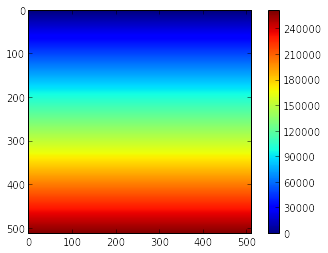

In [31]:
A_cpu
imshow(A_cpu)
colorbar()

In [32]:
matrixArray, copyMatrixArray = np3DtoCudaArray(A_cpu,allowSurfaceBind=True,prec=presGPU) 
# Creamos el CUDA Array a partir de arreglo numpy

In [33]:
A_gpu = gpuarray.zeros((512,512), dtype=presCPU)  # Aqui escribiremos 

<matplotlib.colorbar.Colorbar instance at 0x6546cb0>

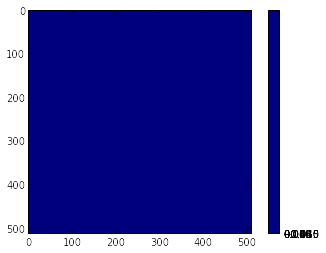

In [34]:
A_gpu
imshow(A_gpu.get())
colorbar()

In [35]:
textureR.prepare('P',texrefs=[texR]) # Preparamos el Kernel y pasamos la textura a usar

In [36]:
texR.set_array(matrixArray) # Paso crucial: ligamos la textura con el CUDA Array
# Ojo toda la informacion esta en el CUDA Array y ligamos a Texturas para hacer las lecturas estructuradas

In [37]:
cuBlock = (16,16,1) # 512,256,1024 thread per Block
print cuBlock
cuGrid = (32,32,1)
textureR.prepared_call(cuGrid,cuBlock,A_gpu.gpudata) 

(16, 16, 1)


In [38]:
512/16

32

In [39]:
512*512==16*16*32*32

True

<matplotlib.colorbar.Colorbar instance at 0x6ad2c20>

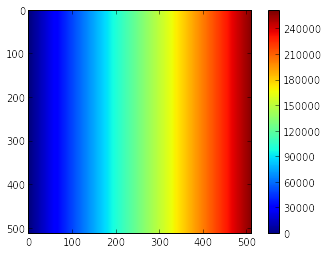

In [40]:
imshow(A_gpu.get())
colorbar()

In [41]:
A_gpu.get()-transpose(A_cpu)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [42]:
A_gpu.dtype

dtype('float32')

In [43]:
#A_gpu.gpudata.free()

Una desventaje de las texturas es que los espacios de memoria que referencias no permiten escritura, es decir no existe una funcion **tex_2D_write**. Para este proposito se creo una textura con este atributo conocida como **Textura de Superficie**. *Ojo* Los CUDA Array y la texturas son dos elementos del mimo esquema: **Memoria de Texturas**, Los CUDA Array son inmutables dentro del kerne a menos que se usen texturas de Superficies

In [44]:
#Declaramos la superficie a usar (las librerias son importantes)
mySurf = '''
surface< void, cudaSurfaceType2D> mySurf ; \n '''

In [45]:
# Observe como se modifica el Kernel
surfK = '''
__global__ void rwSurf(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
cuPres temp;
fp_surf2Dread(&temp, mySurf,  tid_y, tid_x , cudaBoundaryModeClamp); // Lectura de  Suprficie
// surf2Dread(&temp, mySurf,  tid_y*sizeof(float),        tid_x ,  cudaBoundaryModeClamp);
A[tid] = temp; //Escritura a memoria global
//surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),   tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
fp_surf2Dwrite( temp, mySurf, tid_y, tid_x,  cudaBoundaryModeClamp);
}
'''

In [46]:
kernelSurf = optKernels(incLib+mySurf+surfK,pres=presGPU,subBlGr=False)  
print kernelSurf

#include <MYpycuda-helpers.hpp> 

surface< void, cudaSurfaceType2D> mySurf ; 
 
__global__ void rwSurf(float *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
float temp;
fp_surf2Dread(&temp, mySurf,  tid_y, tid_x , cudaBoundaryModeClamp); // Lectura de  Suprficie
// surf2Dread(&temp, mySurf,  tid_y*sizeof(float),        tid_x ,  cudaBoundaryModeClamp);
A[tid] = temp; //Escritura a memoria global
//surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),   tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
fp_surf2Dwrite( temp, mySurf, tid_y, tid_x,  cudaBoundaryModeClamp);
}



In [47]:
cuCode = SourceModule(kernelSurf,include_dirs=[myDir])
surfRef = cuCode.get_surfref('mySurf')
surfRW = cuCode.get_function('rwSurf')

Ahora podemos escribir en el Cuda Array previamente creado 

## All happens here! with setArray you ares binding the CUDA Array 'matrixArray' to the surface o textuture to make the read or write operations...

In [48]:
surfRef.set_array(matrixArray) 

In [49]:
surfRW.prepare('P')

In [50]:
surfRW.prepared_call(cuGrid,cuBlock,A_gpu.gpudata)

In [51]:
ctx.synchronize() # TOOL for check if kernel brokedown even if you have a free error compiling

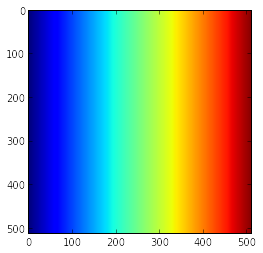

In [52]:
imshow(A_gpu.get())

In [53]:
A_gpu.get()

array([[  0.00000000e+00,   5.12000000e+02,   1.02400000e+03, ...,
          2.60608000e+05,   2.61120000e+05,   2.61632000e+05],
       [  1.00000000e+00,   5.13000000e+02,   1.02500000e+03, ...,
          2.60609000e+05,   2.61121000e+05,   2.61633000e+05],
       [  2.00000000e+00,   5.14000000e+02,   1.02600000e+03, ...,
          2.60610000e+05,   2.61122000e+05,   2.61634000e+05],
       ..., 
       [  5.09000000e+02,   1.02100000e+03,   1.53300000e+03, ...,
          2.61117000e+05,   2.61629000e+05,   2.62141000e+05],
       [  5.10000000e+02,   1.02200000e+03,   1.53400000e+03, ...,
          2.61118000e+05,   2.61630000e+05,   2.62142000e+05],
       [  5.11000000e+02,   1.02300000e+03,   1.53500000e+03, ...,
          2.61119000e+05,   2.61631000e+05,   2.62143000e+05]], dtype=float32)

In [54]:
texR.set_array(matrixArray)

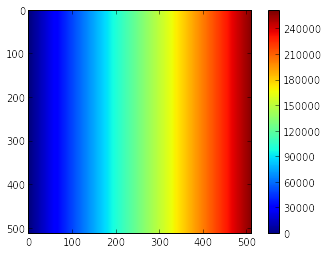

In [55]:
textureR.prepared_call(cuGrid,cuBlock,A_gpu.gpudata)
imshow(A_gpu.get())
colorbar()
ctx.synchronize()

Veamos el rendimiento de las Texturas

In [56]:
surfK2 = '''
__global__ void rwSurf(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
cuPres temp;
//surf2Dread(&temp, mySurf,  tid_y*sizeof(cudaPres),        tid_x ,  cudaBoundaryModeClamp); // Lectura de  Suprficie
fp_surf2Dread(&temp, mySurf, tid_y, tid_x , cudaBoundaryModeClamp); // Lectura de  Suprficie

A[tid] = temp; //Escritura a memoria global
//surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),        tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
}
'''
cuCode = SourceModule(optKernels(incLib+mySurf+surfK2,pres=presGPU,subBlGr=False),include_dirs=[myDir])
surfRef = cuCode.get_surfref('mySurf')
surfRW = cuCode.get_function('rwSurf')

In [57]:
timeSurf = []
timeTex = []
nLoop = 1000
for i in range(8,14):
    N = 2**i
    a = np.ones((N,N),dtype=presCPU)
    A_gpu=gpuarray.to_gpu(a)
    matrixArray, copyMatrixArray = np3DtoCudaArray(a,allowSurfaceBind=True,prec=presGPU) 
    cuBlock = (16,16,1)
    cuGrid   = (N/cuBlock[0],N/cuBlock[1],1)
    t1 = 0
    t2 = 0
    texR.set_array(matrixArray)
    textureR.prepare('P',texrefs=[texR]) 
    for k in range(nLoop):
        t_tex = textureR.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        t1 += t_tex()/nLoop
    surfRef.set_array(matrixArray)
    surfRW.prepare('P')
    for k in range(nLoop):
        t_surf = surfRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        t2 += t_surf()/nLoop
    
    timeSurf.append(t2)
    timeTex.append(t1)
    A_gpu.gpudata.free()
    matrixArray.free()

([<matplotlib.axis.XTick at 0x79c9650>,
 <a list of 6 Text xticklabel objects>)

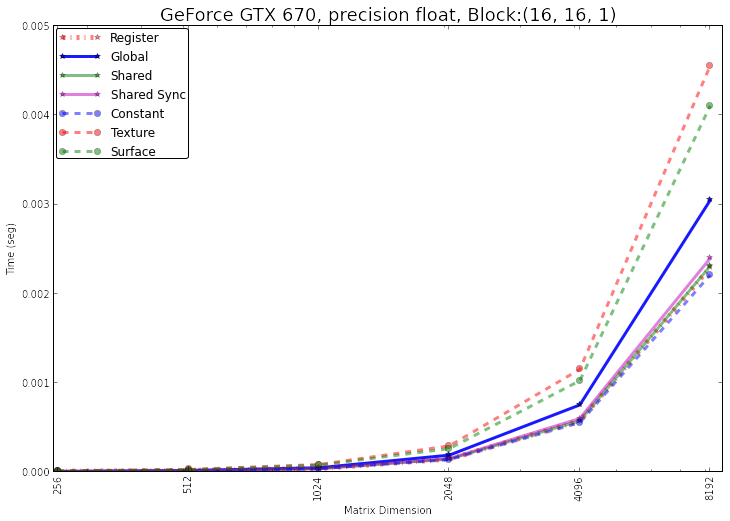

In [58]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('{0}, precision {1}, Block:{2}'.format(device.name(),presGPU,cuBlock),size=18)
plt.semilogx([2**i for i in range(8,14)],timeReg,'r-.*',label='Register',linewidth=5.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeGlo,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],timeSha,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeShaSy,'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeCons,'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeSurf,'r--o',label='Texture',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeTex,'g--o',label='Surface',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')


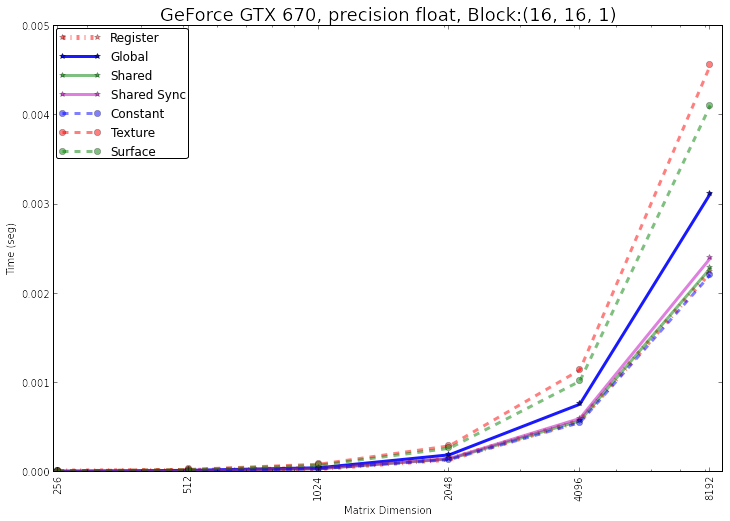
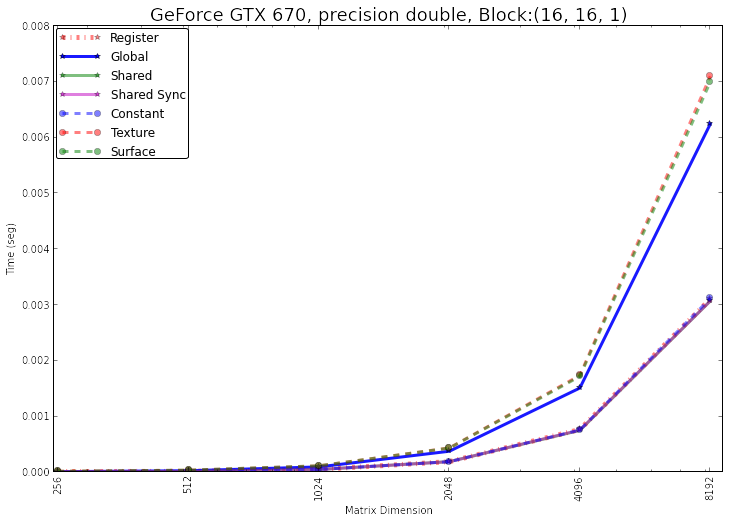

In [59]:
%%HTML
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtoAAAIJCAYAAACbRJqyAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdYU9cbB/DvTUjYeyNLhgwVRVEEFwKiuBCxDhygOOus1Wq1La5atWpbN46idde2Ks6fAkXRKoqDqiiKgkyRjWxI7u8PGhpTkCBL5f08z3kkN+fc+96ba3hzODmHYVkWhBBCCCGEkMbFaekACCGEEEII+RhRok0IIYQQQkgToESbEEIIIYSQJkCJNiGEEEIIIU2AEm1CCCGEEEKaACXahBBCCCGENAFKtAkh5APm7++/j8PhCOvbLjEx0ZTD4QhXrFgR2BRxSYtlWWb58uXLzczMnvN4vArRubzreX1omus8XVxcItq2bZvQ0P28evVKR1VVNX/v3r0BjREXqeLt7X3C1dU1vKXjII2PEm3y3igtLZXbvn37p66uruE6Ojqv+Hx+ubq6em737t1vLlmyZG1cXJzVu+47IiLChcPhCGsrN2/e7N6Y59ISYmJiOk2dOnV3u3btnigpKRXKy8uXmJqaJvr4+Px+8ODB8ZWVlTJ1XQfxYmZm9hwAfH19D3O5XEF4eLir5DFLSkrkrays4rS0tLJevXqlI02cOTk5GgsXLtxgYWERLy8vX6Kjo/PK1dU1/OrVq73E69UV35o1a5aK1xcKhZwffvjhM2tr68fy8vIlxsbGSQsXLtxQXFys0JDr+r5jGIZlGOadF0RoSNvGsG/fPv+VK1d+4+bmFvbzzz9PPnjw4Pjmji0iIsJlxYoVgfn5+aoN3ZepqWmi+H3K5XIF+vr66S4uLhHHjh0bXVOb5jrPxjjOV199tVpXVzdj0qRJweLbg4KCpo8bN+6QtbX1Yy6XK5Dmw8P169edvLy8Tmlra2fKy8uXmJmZPff19T1cUVHBe9f44uLirBYuXLjB1dU1XE1NLU+aD5PFxcUKK1eu/KZ9+/YPFRQUijU1NbOdnZ3/Onny5PB3jQOo3zVZsWJF4OXLl/uePn16aEOOSd4/Mi0dACEA8Pz5c7MhQ4acefz4sbWLi0vEggULNunr66cXFhYq3b171/7nn3+evGHDhoXJyclG+vr66e96HF9f38ODBg06J7nd3Nz8WcPOoGWtWbNm6ddff71KU1Mze/To0cc6dOjwgM/nlycnJxuFhoa6T5w48ZerV6/2Wrly5TfiiQxQ9csgMjKy948//jhfS0srS7RdSUmpEAC2bds2KyIiwiUgIGDv/fv3O4q2A8CSJUvWPn361PLo0aNjdHR0XtUV54sXL0xcXFwiiouLFQICAva2a9fuSV5entr9+/c7pqWlGYjXlYwT+Lf38/nz52bDhg0LEX/us88++2HLli1zRowY8ceiRYu+j42Ntd28efPcu3fv2oeGhrq3dELZVHbv3j01KChoen3bmZqaJpaWlspxuVxBU8QlrUuXLvVXU1PL271791TJ51iWZZojhoiICJeVK1d+M2nSpGBVVdX8hu7PyMgo+bvvvvsSAAQCATclJcVw//79fmPHjj2Snp6uP3/+/B/F6zfXeTZUSkqKYXBw8KRNmzYtkEwa165duyQnJ0fD3t7+bnFxsUJqamqbt+0rODh40pQpU/Y4OTldX7p06Ro1NbW81NTUNlevXu1VWVkpw+PxKt4lxuvXrzv98MMPn1lYWMQ7ODhEh4eHu77t/35ubq66m5tbWHx8vMXkyZN/7tSpU0xRUZHio0ePbJKSkozfJQaR+lwTOzu7v11cXCJWrVr19dChQ0835LjkPcOyLBUqLVqKi4vlra2tH8nKypaePHnSq6Y6paWlsmvXrl2clpam/y7H+PPPP10YhhFu3LhxQVOeS0FBgXJzX7/g4GB/hmGE/fv3v1jb8e/du9dp+/btM2t6zs/Pbx/DMMIXL14Y13aMkJCQoQzDCKdNmxYkeU1HjRp1TNpYe/XqFWlsbPzi5cuXuu9yrsnJyYYcDkfQvXv3KPHtDx48aM8wjHDkyJHHxbdv2bJlNsMwwsOHD49t7telpe+LD6X069cvvG3bts8lt4vuy+aIITAwcDnDMMLExESThu7LxMQksWPHjn9Lbs/Oztbg8/llnTt3vtsS59m3b9+Imq5zfcpXX321isfjlWdmZmpJPif+/jF48OAzHA5HUNt+Hj58aMvn88umTp26q7HPMycnRz0/P1+FZVlER0d3ZRhGuGLFim9qqz9+/PgDqqqqeY8ePbJu7Fjqc01Y9t/38jt37tg39f1ApflKiwdAhcrmzZvnMAwj/Oqrr1bVt21eXp7qF198sc7c3DxeVla2VFtb+9XYsWMPP3/+vK14vfok2pcvX+7j7u5+SVVVNU9eXr64S5cut/fu3TtZsl7fvn0jTE1NE54/f97Wx8fnN3V19RzxX5jp6el6c+bM2dy2bdvnsrKypTo6Ohn9+/e/eOnSJXfx/Tx58sRy/PjxB/T09NL5fH6ZqalpwqJFi9YXFRUp1BVrWVkZX19fP01VVTUvNzdX7V2uvzSJNsuymDhx4n6GYYT/+9//PAoKCpRNTU0T9PT00rOzszWkOc7ly5f7MAwj3Lp16yyWZVFeXs6T5hzFy8qVK79mGEa4a9euqeLbly1btpphGOHVq1d7im8vLS2VVVRULBw0aNDZd70/Rb/8QkND3QIDA5cbGxu/kJWVLbWzs4s5evToaMn6JiYmiS4uLn/euXPH3sPD43+qqqp54glOfV5vae6hmhK1pKQko0mTJv0silVHRyfD2dn52v79+yeK6iQkJJgyDCNcvnx5oHjbiooKmbVr1y62sbGJlZOTK9HU1Mzy9vb+4/79+x3E64m3P3369BAHB4dbcnJyJfr6+mmLFi1aX1lZyX3bdRX9n5QskyZN+rm282JZFjExMXbDhw8/oaGhkS0nJ1dia2v7cP369YsEAgFHvN6jR4+sZ86cud3W1vahsrJygYKCQlHXrl2j9+zZE1DT/S9ZJK+LtKW2RFsgEHCUlZULJD8kNvQ8pb1Pakq0s7KyNHv06HFdVVU1Lzw8vJ9oe3x8vPnjx4+tJI9jZWX12NnZ+Vpd16CupHLSpEk/y8rKloreswoLCxUrKipk3vX/aG3l1q1bDm9LtBMSEky5XG7lwoULv2dZFpWVldzXr18rNXYc0lwT0evIMIxwyZIl3zVFDFRaptDQEdLifvvtt5EMw7BTpkzZU592+fn5qs7Ozn8lJycbBQQE7G3fvv3DtLQ0g+3bt3/q6OgYFR0d7WBsbJwk3qaoqEgxKytLS3ybnJxcqWg4xOnTp4d6e3ufMDAwSFu4cOEGZWXl10eOHBk7ZcqUPc+fPzdbvXr1V6J2DMOwhYWFSn379r3cq1evq999992XonHKiYmJpj179rz26tUrHT8/v/0ODg7RhYWFSjdu3OgRFhbm5u7uHgoAt2/f7urq6hquoaGRM3PmzB1t2rRJvXfvXufNmzfPvXbtWs/Lly/3lZGRqaztGly7dq3ny5cv9fz8/Parqanl1ef61dfmzZvnhoeHu06ZMmVP7969I1+8eGHyxx9/jNDQ0MiRpv25c+cGAVV/Vh86dOjpCxcuDBQIBFxLS8un33zzzcpx48Ydelt7lmWZ4ODgSUpKSoVjx449Iv7crVu3unG5XEH37t1vim+XlZUt69SpU8ytW7e61fd8JS1evHhdcXGxwuzZs7eKYhk7duyR0tJSOT8/v/2iegzDsElJScZubm5ho0aN+vWTTz45XlhYqATU7/WW9h4SHVP0c2VlpUz//v0vpaWlGcyaNWtbu3btnuTn56vGxMR0unr1aq+JEyf+In5ekn9WHzdu3KHjx49/4uHhcXHWrFnb0tPT9bdt2zbLycnpemRkZO/OnTvfE69/7ty5Qdu3b/905syZO6ZMmbLn5MmTwzds2LBQXV0998svv/yututpa2sbe+DAgQnffvvtsqysLK0ff/xxPvD2YVzR0dEOffv2vSwrK1s2a9asbXp6ei9DQkKGLV68eF1MTEwn8eFGly9f7hsZGdl72LBhIW3btk0oKipS/PXXX0dNnTp1d2ZmpvaSJUvWAsCMGTN2vn79WvnEiRPe4sOn7Ozs/q4tjrpUVlbKZGdna7IsywgEAm56err+Tz/9NK+oqEhx+vTpQXW1r8951uc+EZeQkNB24MCBF4qKihSvXLnSR/x83dzcwpKSkoyFQmH197gyMjJ0nzx50m7evHk/vet1ETl//ryntbX14z///LPfokWLvn/+/LkZj8ercHd3D/3pp5/mWVhYxDf0GNK4cOHCQKFQyLGxsXk0YcKEA8ePH/+kvLyc36ZNm9TPP/98o+QQn6amp6f30tTUNDEiIsKlOY9LmlhLZ/pUqGhoaGSrqanlSm4XCASczMxMLfFSUlIiJ3p+7ty5PykoKBT9/fffHcXbvXjxwlhFRSXf398/WLSttt4zhmGEY8eOPcyyVb0ZxsbGL9TV1XPS09P1RG3Ly8t5PXv2vMrlciufPn1qIdret2/fCIZhhF9//fVKydg9PT3PcTgcwcWLF/tLPicUChnRz3Z2djE2NjaxhYWFiuJ1Tpw4MZxhGOG+ffv83nbtRH8N+PHHH+dJPldQUKAsfu2ysrI0a9qHtD3aLMvi/PnzA0XXbfz48Qfq8zoPHz78BMMwQh0dnYxevXpFHj58eGxwcLB/hw4d7jMMIwwODvZ/W/vQ0FA3hmGEkydP3iv5XIcOHe7r6eml19Tuk08++ZVhGOG79piJerRNTU0TxIeA5Ofnq5iYmCRqaGhki9+XJiYmiQzDCGv6K0h9Xm9p7yHJHtGYmBg7hmGE33///cK3nZeoR1q8t+/ixYv9GYYRjhkz5oh43ZiYGDsZGZmK3r17X5Fsr6Sk9Fry3unQocN9fX39NGmub21DGmrq6XV2dr7G4/HKJXvXR40adYxhGGFYWJiraFtNfyEQCoWMi4vLn6qqqnni94No6Ig0/wfqKqLXX7LIy8sX7969e0pjn6e094n4db5z5469np5euo2NTWxN52xqapog2fsaHh7ej2EY4ZYtW2bXdQ3e1nubl5enyjCMUFNTM4vH45UvWLBg48mTJ71WrFjxjZycXImuru7Ldx1aJlnq6tGeP3/+D6L3pPbt2z/Yt2+f36FDh3x79+59hWEYYWBg4PLGiKOuayJe3NzcQpWVlQsa67hUWr60eABUqMjIyFQYGxu/kNx+//79DpK/rDZs2PA5y1b9AtHU1MwaOHDg+aysLE3JhLx///4XDQwMUkX7EiXaM2bM2BEWFuYqXh4+fGjLsiyioqK6Mwwj/PzzzzdIxnLq1Klh4sdn2apfXBwORyAaDygq2dnZGgzDCOsarvD33393ZBhGuHLlyq8l43/16pW2oqJioa+v76G37WP16tXLGIYR/vzzz5Mkn/Px8flN/NopKSm9rmkf9Um0b9y44cjhcAQMwwiPHDkypj6vs5ubWyjDMEILC4un4klObm6umrq6eo6+vn6aeGIgWcaMGXOEYRjhtWvXnCWfMzMze2ZiYpJYU7sJEyb8wjCMUPJ1kraIEu1169Z9Ifncd999t4RhGOH58+cHiraZmJgkamlpZUqeS31eb2nvIfHXT/Q4MTHRhGEYoaen57lXr15p19aupkR75syZ2xmGEUomeCzLwtvb+w+GYYSiD2yi9jV94Jo9e/YWhmGE0gwNkjbRzsjI0GEYRujj4/ObZF3Rh4vZs2dvqekYJSUlcqL3iW+//XYpwzDCBw8etBc939iJtpmZ2TPR+0toaKjb/v37J/br1y+cy+VWSn6gbMh51uc+EQ11u3TpkruysnKBs7PztZycHHVpz+vYsWOjGIYRHjp0yLeuum9LKpOTkw1F70mSnRT79u3zYxhGuHjx4rUNfR1Ytu5EOyAgYA/DMEJ1dfUc8WtRUVEhY2lp+UReXr74XYfk1eeaiBfRh6nS0lLZxjgulZYvNL0faXEqKioFBQUFKpLbzczMnoeGhrqHhoa6b9iwYSHw75+5MzMztXNycjT+97//DdDW1s7U0dF5JV5CQ0Pda5puztLS8qmrq2u4eLG1tY0Fqv6UCgDt27d/KNlOso6ItrZ2poqKSoH4tvj4eAsAsLe3v/u283706JENAAQGBq6QjF9XVzejuLhYoa4p80THrun6LV++fHloaKj7pUuX+tvZ2f0tOUSgvkRDJNTV1XONjIySFyxYsCkvL09N2vby8vIlADB27Ngj4sNh1NTU8oYOHXr65cuXek+ePGlXU9ucnByNEydOeNvY2Dxydnb+S/J5BQWF4rKyMtna4mYYhlVQUCiWNtaa2NjYPKptm+R9YW5u/kzyetfn9Zb2HqqJiYnJi2XLln178eJFD319/XQHB4foxYsXr4uOjnaoq21CQkJbLpcrqOlca/s/IJoGUpympmY2AGRnZ2vWN/63xQbU/P/T2tr6McMwrHhshYWFSgsXLtxgbGycpKCgUCx6n/jqq69WA1WzTTRWbJIUFRWLRO8vbm5uYRMnTvzl0qVL/W1tbWPnzJmzJScnR6O2tvU5z/reJxkZGbqDBw8+a2FhER8WFuamrq6eK+05ie5ntoEzpIjeBxiGYf39/feJPzdu3LhDHA5HePny5b4NOUZ9YxkyZMgZ8WshIyNT6evre7i0tFQuKirKsTliEWFZlmEaOGUneb/QGG3S4jp06PAgMjKyd2JioqmpqWmiaLuCgkKxaAJ/yamkRG/2/fv3v7R48eJ1zRqwmIYkb6JzWLhw4YaBAwdeqKlOXb8IO3bseB8A7t69ay/5XIcOHR6Ifm6M8dtLly5d8+TJk3aHDx/21dLSyvLw8Lg4d+7czb/88stEadobGhqmAFXjECWfE03ZWFvyc+jQoXHl5eX8gICAvTU9b2BgkPb48WPriooKnuS0YKmpqW20tLSy3jbWvbHVdF80xustrVWrVn09efLkn8+ePTs4MjKy9549e6Z8//33i7744ov1a9euXdIYxxB52/SADU3KGsLX1/fw2bNnB0+fPj2oT58+VzQ1NbO5XK7g7Nmzg3/44YfPxMcfNwculytwdXUN37x589yoqChHT0/P8815fADQ0NDI6dq16+0zZ84MOXjw4Pj6fC9GW1s7E6j60NvQGOTl5UtKS0vlJN8LZGRkKrW0tLKa8kOQuLe9J4m2NVcsIjk5ORpKSkqFfD6/vDmPS5oOJdqkxX3yySfHRcmA+JcN30ZbWztTTU0tLz8/X7WxVtMSfQnrwYMHHSSfi42NtQVq7r2TZGFhEc8wDFtT8iuuXbt2T4CqDxHveg49e/a8pqen9/LEiRPemzZtWiDtFxPrKzIysvdPP/00z8fH5/cxY8YcBYBp06bt2rVr17RPPvnkuDTzvjo6OkYFBQVNT05ONpJ8LiUlxRAAapuLe+/evQF8Pr9c8ot8It27d7956dKl/lFRUY69evW6KtpeWloqd+/evc4uLi4RUp5qrWJjY20lz7M+90V9Xm9p76G3adu2bcLs2bO3zp49e2tZWZnsgAED/rd+/fovFi5cuEF8vnRxZmZmzwUCATc2NtZW9CFOJDY21pZhGLYxVhd8F6Lj1vT/8/Hjx9YsyzKi1yEvL0/tzJkzQ/z8/PZv3779U/G6Fy9e9JBs31y9h6KFWERfjq1Jfc6zvvcJn88v/+OPP0aMGjXq1+nTpwdVVFTwZs6cuUOatqIe9qdPn1pKU782DMOw3bp1u3XlypU+ycnJRlZWVnGi58rKymQzMzO1Rf9Xmpqjo2MUALzLe1JTiY+PtxDvJCEfPho6QlrclClT9lhbWz/+/vvvF9W2EpdkzxiHwxGOGzfu0M2bN7v//vvvPjW1yczM1K5PHF26dLljbGycFBwcPCkjI0NXtL2iooL3/fffL+JwOEIvL69Tde1HQ0Mjx9PT8/z58+c9w8LC3GqrZ29vf7dDhw4Pdu7cOUPyz/FA1cwFdfWm8Hi8ijVr1ix9/fq18ujRo4/VNIQEaFjPYlFRkeKkSZOCtbS0snbs2DFTtH3Dhg0LjY2Nk6ZPnx4kzRCS4cOHn1RWVn598ODB8UVFRYqi7enp6fonT54cbmVlFVdTwhodHe3w999/2w0dOvR0bQni6NGjjzEMw4pmrhDZvXv31JKSEvm6ZjSRxo4dO2aKX9/8/HzVnTt3zlBXV8/t27fv5bra1+f1lvYeEhFPFAsKClQkV9aTlZUts7a2fgy8vYfO29v7BACIFlsRefDgQYeQkJBhvXr1uioaFtIcxM9LR0fnlbOz81+nT58e+vDhw/ai7SzLMqJ4RfFzuVwBwzCsZK91enq6/p49e6ZIJtaiWYcac6iLpNLSUrkLFy4MZBiG7dKlyx3x5971POt7nwBV1+bXX38dNXLkyN9mzZq1bfPmzXMl6zx79sxcciVebW3tzPbt2z+8fv26U/3O/L8mTJhwAKj6PyW+fdeuXdNYlmVqWlSsKfTp0+eKiYnJi9OnTw8VXzCrqKhI8Zdffpmorq6e6+TkdL05YgGAly9f6iUlJRlL835CPhzUo01anJycXOnZs2cHDxky5MyIESP+cHFxiejfv/8lPT29lwUFBSqPHz+2Pnbs2GgZGZlKIyOjZFG7b7/9dtm1a9d6jho16tdRo0b96ujoGMXn88tfvHhhcu7cuUEODg7RwcHBk6SNg8PhCLdu3Trb29v7RLdu3W5NmzZtl5KSUuGxY8dGR0VFOS5btuxbyanHaktgt27dOtvZ2fkvT0/P835+fvu7dOlyp6SkRD4qKsqxbdu2CaI/3x84cGCCq6truJ2d3d+TJ0/+2dbWNra4uFghPj7e4sSJE95r165dUlsvroi/v/++tLQ0g6+//nqVubn5s9GjRx9r3779Qx6PV5Genq5/8eJFj2vXrvWU7KGU1hdffLH++fPnZr/++usoyZUj9+zZM0XaISRqamp5GzZsWDh9+vSgHj163Jg8efLPZWVlsjt27JhZWVkps2XLljk1tdu7d28AUPWBrLZ9d+jQ4cGsWbO2bd26dbaPj8/vnp6e5x89emSzZcuWOS4uLhG+vr6Hxevv27fPf/LkyT8HBgauCAwMXCHNddDW1s50dHSMmjRpUjD7z/R+KSkphnv27JkiJydXKs0+6vN6S3sPAW/eh+Hh4a7Tpk3bNXLkyN/atWv3RElJqfD27dtd9+7dG9CjR48blpaWT2uLz93dPXTUqFG/Hj16dExubq764MGDz758+VJv27ZtsxQUFIprSsoaQ23/jyS3//TTT/P69u17uXfv3pGzZs3apqurm3HmzJkhFy9e9Bg3btyhfv36/QkAysrKrz08PC4ePHhwvLy8fImDg0P0ixcvTHbt2jXNzMzsueR4dVEytXjx4nW+vr6H5eTkSjt27Hhf1IvL4XCEJiYmL2r6gFSTvLw8tUOHDo1jWZZhWZZJS0szOHjw4PiEhIS206ZN21XX+4i05wm8233C5XIFR44cGcvj8Srmz5//Y2VlpcyCBQs2ierVNL0fUPXXx1WrVn398uVLPcnhFqdPnx4aExPTCajqlWVZlvn222+XsSzLqKur586aNWubqO6kSZOCf/nll4mbN2+em5WVpdWrV6+r9+/f77hr165pHTp0eDB37tzN4vt2cXGJuHLlSp/ExERTySlbJRUUFKiI7lNR8nz58uW+or+Wenl5nRK9F3I4HOH27ds/HTZsWIiTk9P1Tz/9dDuPx6sIDg6elJqa2mbv3r0BonHcQNUKoq6uruF+fn77pfndUp9rAvw7Beonn3xyvK59kw9IS38bkwoVUSkpKZHbtm3bp/369QvX0tLK5PF45WpqarndunW7uXjx4rVPnjyxlGxTXFwsv2rVqq86duz4t7y8fLGysnKBra3tw2nTpgXdvHmzm6hefRes6d+//0UVFZV8OTm5ki5dutyuaVYPFxeXP9+20lpqaqrBjBkzdhgbG7/g8/llurq6LwcMGHBBfGEIlq2ajnDGjBk7TE1NE/h8fpmmpmaWg4PDraVLl36bkpLSRtrrd+/evU5TpkzZbWlp+URBQaFITk6uxMTEJHHEiBG/Hzp0yLe2BUT8/f2DORyOoKYZF0JDQ904HI5g9OjRR2s77vTp03dyOBzB6dOnh0gT5x9//OHdo0eP64qKioXKysoFAwYMuPDXX3851VS3uLhYXk1NLbe2GUXEi0Ag4GzcuHGBlZXVY1lZ2VJDQ8Pkzz//fENNM1+IpkWUXLykpiKadSQsLMxVcsGammZeMTU1TejXr194bfurz+stzT0kev1EjxMSEkxnzJixw8bGJlZFRSVfUVGx0NbW9mFgYOBy8ekJa5p1hGWrprlct27dFzY2NrGysrKlogVrxGfpeFt7lmWxfPnywNruKWn/H0mel6iIL+QiKytbamtr+/D7779fKDnLS1ZWluaUKVN2GxgYpMrJyZXY2dnF7NmzJ2Dfvn1+HA5HcPny5T7i9devX7/IzMzsGY/HK+dwOALReRUUFCgzDCPs1atXpDT3t2hqPPEZfxQVFQu7d+8etXPnzumNfZ7S3ic1XWehUMj4+/sHMwwjXLt27WLJc5A8Tlpamj6Pxyuv6X1UtB+GYYQcDkcgfg1qen2LiooUlixZ8p3o/4GhoWHynDlzNufl5alK1u3SpcttJSWl19LMHCS6L2uKhcPhCMQXbRKVy5cv93F1dQ0TLWzUq1evyDNnzgyWrCdaIVfaxdXqe01cXFz+lFzQiMqHX1o8ACpUqFBp7uLt7f1Hu3bt4upavZBl/020JRMzKq2jiKb2jIiI6NvSsbwPZcaMGTvMzMyeNcVKjjWVnJwcdS6XW/muK3U2Zvnss882aWpqZjXWlH/i5e7du53r02FB5cMpTTpG+8KFCwOtra0fW1paPl23bt3imurMnTt3s6Wl5dNOnTrFiH+ho7a2y5cvX25oaJhib29/197e/u6FCxcGNuU5EEI+LpWVlTJ//vlnv7Vr1y5524wZhABVX54cOnToaRo3W2XlypXfZGdna+7bt8+/OY4XGhrqrqurm/FggqtnAAAgAElEQVTFF1+sb47jvc3Fixc9li1b9m1TrMK7YsWKQBcXl4ghQ4acaex9kxbWVBl8ZWUl19zcPD4hIcG0vLyc16lTp3uxsbE24nXOnj07yNPT8xzLVi2E4ejoeKOutsuXLw+U5s//VKhQodIYhXq0qVChQoXKu5Ym69G+efNmdwsLi3hTU9NEHo9XMWbMmKOnTp3yEq8TEhIyzM/Pbz9QNc1OXl6e2suXL/Xqasu24NyshJDWhxaPIIQQ8i6abNaR1NTUNuIzRBgaGqZIrrBUU53U1NQ2aWlpBm9ru2XLljm//PLLRAcHh+iNGzd+LvlnHPqlSAhpbDR0gBBCSE3e1gHcZD3a0ia79e2dnjlz5o6EhIS29+7d66yvr5/++eefb6xlv9UlMDCwRf5c0FLHpfOqPc6WiP1jPmZTHaep4/9Q7mEqTfu6031Qv+v1sZT35XfDh3T9P9bfY43xnlCXJuvRbtOmTar4akvJyclGouVOa6uTkpJiaGhomFJRUcGrra34Kk1TpkzZI82KdC3FxcWlpUNoEh/Keb0vcbZEHM11zKY6zvvy2pGPC91X9fOxXq8P5bzepzg/1t9jzXGMJku0HRwcop8+fWqZmJhoamBgkHbs2LHRR44cGSteZ9iwYSFbt26dPWbMmKM3btzooaamlqerq5uhqamZXVvb9PR0fX19/XQAOHHihHddi3CkpKRg//79WLVqFYRCYVOdLnmPMQwDHR0dBAQEgGGaf3j/x/oG1ZTHeZ9+wZCPB91X9fOxXq8P5bzepzg/1t9jH3SiLSMjU7l169bZAwYM+J9AIOAGBATstbGxeRQUFDQdAKZPnx40aNCgc+fOnRtkYWERr6ioWCRaaam2tkDVyl337t3rzDAM27Zt2wTR/mrj7e2NqVOnYuHCheDz+U11uuQ9VllZiaSkJCxYsAAZGRlYvXp1S4dEWtj79AuMtBy6D4gI3QsEaJr7gJFmfMmHhmEYVnReXC4XJSUllGQTlJSUQEVFBRUVFS0dCiGEEEI+AgzDgH3L9w0/+kT7nwvQwhGR9wXdD4QQQghpLHUl2k26MiT58CQlJUFZWZmSUUIIIYSQBqJE+wNmamoKBQUFKCsrQ09PDxMmTEBBQUGD9mlsbIzXr1/X+aXBffv2oXfv3g06FiGEEELIx6xVJtosy+LahQvvRa9tQ2JhGAZnzpzB69evERMTg/v3738wX/SrrKxs6RAIIYQQQppUq0y0n8XG4vW2bXg2axawfDkQEfHfShERtW9fvrzR2j2LjcXrEyfwLDa2XucgSVdXFx4eHnj48CEA4MaNG3B2doa6ujo6d+6My5f/XdQuISEBffr0gYqKCvr3749Zs2ZhwoQJAIDExERwOJzqqRD37dsHc3NzqKiowMzMDIcPH8bjx48xY8YMXL9+HcrKytDQ0AAAlJWVYeHChTAxMYGenh5mzpyJ0tLSf04/AoaGhli/fj309fUREBDQoPMlhBBCCHnfNdn0fu+jv2/dwoPz56FbXo4BGhoIf/AAN7lcdNDTg10zT+3zRix6egg/cgQ3+Xx08PSEXbduUu9H1BOekpKCCxcuYOTIkUhNTcWQIUNw8OBBDBw4EKGhofDx8UFcXBw0NTXh6+uL3r17Izw8HFFRURg0aBC8vLz+s++ioiLMmzcP0dHRsLS0REZGBrKzs2FtbY2goCDs2bMHkZGR1fWXLFmChIQExMTEQEZGBr6+vli5ciXWrFkDAMjIyEBubi6SkpIgEAgaeAUJIYQQQt5vrapHu6ODA7qNGAG2rKzqW6ICAbrb2KCjlVXLx1JWhu4+Pujo4CD1PliWxfDhw6GiogJjY2OYm5tj2bJlOHjwIAYNGoSBAwcCANzd3eHg4ICzZ88iKSkJ0dHRWLlyJWRkZNCzZ08MGzas1qErHA4H9+/fR0lJCXR1dWFra1t9bMlYdu/ejU2bNkFNTQ1KSkr48ssvcfTo0Tf2tWLFCvB4PMjJydX3khFCCCGEfFBaVaLNMAwYhkFlQQH+x7KoLCur3t7isfzzJcb6xMIwDE6dOoWCggJEREQgPDwct2/fxosXL3D8+HGoq6tXl2vXruHly5dIS0uDhobGG4mukZFRjftXVFTEsWPHsHPnThgYGGDIkCGIi4ursW5mZiaKi4vRtWvX6mN6enoiKyuruo62tjbNZ04IIYSQVqNVDR0BgPzMTFjMnQvzV6/w7PhxFBQXt3wstrZ4FhuLArGktL769OmDOXPmYPHixRgwYAAmTJiAXbt2/afeixcvkJOTg5KSEsjLywOomtKvtgTfw8MDHh4eKCsrw7JlyzB16lRcuXLlP/W1tLQgLy+P2NhY6Ovr17ivlvhAQwghhBDSUlpdot1VNBa7fXtY9OtXe8Xaxmy7uNT+XD3bdRV7bNG+fe37lNL8+fPxww8/YNWqVfjpp59w8eJFuLm5oaKiAjdu3IClpSVMTEzg4OCA5cuXY/Xq1YiOjsaZM2cwbNiw/+zv1atXuH79Otzd3SEvLw9FRUVwuVwAVV++TElJQUVFBXg8HjgcDqZOnYr58+dj69at0NbWRmpqKh4+fAgPD48GnxshhBBCyIemVQ0d+dhpaWnBz88PmzZtQkhICNasWQMdHR0YGxtj48aN1TOJHDp0CNevX4empia+/vprjB49+o0hHaKeZ6FQiB9++AFt2rSBpqYmIiMjsWPHDgCAm5sb2rdvDz09Pejo6AAA1q1bBwsLC/To0QOqqqro378/njx58p/9EkIIIYS0BrQEO8Ho0aNha2uLwMDAlg6lydH9QAghhJDGQkuwk/+Ijo7Gs2fPIBQKcf78eYSEhGD48OEtHRYhhBBCyEel1Y3RJsDLly8xYsQIZGdnw8jICDt37kSnTp1aOixCCCGEkI8KDR0hrQrdD4QQQghpLDR0hBBCCCGEkBZAiTYhhBBCCCFNgBJtQgghhBBCmgAl2oQQQgghhDQBSrQJIYQQQghpApRof+T8/f3x9ddfS1WXw+Hg+fPn73QcU1NThIWFvVNbQgghhJCPESXaH4GjR4/C0dERSkpK0NXVRY8ePaqXSmcYplmWPm+u4xBCCCGEfChaZaLNsiy+/Xb7ezGfckNj2bhxI+bPn4/FixcjIyMDGRkZ2LlzJ/766y+Ul5dXH4MQQgghhDSvVplonz0bge3bM3Du3OWWDqVBseTn5yMwMBA7duzAiBEjoKioCADo3LkzDhw4AD6f/582u3fvhqWlJTQ1NeHl5YX09HSJeM7C3Nwc2tra+OKLL6qT9GfPnsHV1RVaWlrQ1tbG+PHjkZ+f/w5nTAghhBDSOrSqJdgPHPgd27efQnS0LQSC5Rg+fB0Y5mcoKHhBQcGnWWMpLv4dxcWnwLL/xuLg8DM+/dQLEyZIF8v169dRVlYGLy8vqeqHh4dj6dKluHTpEmxtbbFw4UKMGTMGly//m+SfPHkSt2/fxuvXr+Hu7g4rKysEBAQAAJYtW4Y+ffogPz8fPj4+WL58OX744Yf6nzwhhBBCSCvQqnq0x48fgaVL/QEI/xlPLISS0iTIy49o9ljk5UdASenNWJYtm4Tx46WPJSsrC1paWuBw/n0ZnZ2doa6uDgUFBURGRgJA9djpQ4cOISAgAJ07dwafz8d3332H69evIykpqbr94sWLoaamBiMjI8yfPx9HjhwBAJibm8PNzQ08Hg9aWlr47LPP3kjQCSGEEELIm1pVoi36wp5QWAYudzmEwlIALfMlvqpjvhlLfb9QqKmpiaysLAiFwuptf/31F3Jzc6GpqfnGdgBIT0+HiYlJ9WNFRUVoamoiNTW1epuRkVH1z8bGxkhLSwMAZGRkYMyYMTA0NISqqiomTJiA7Ozs+p42IYQQQkir0aqGjgDA8+dpCAnph0GD+uLcuct4/jwNc+a0TCybN6fB3PzNWOrDyckJsrKyOHnyJEaMqLsn3MDAAImJidWPi4qKkJ2djTZt2lRvS0pKgo2NTfXPoueWLl0KLpeLBw8eQE1NDSdPnsSclrpwhBBCCCEfgFaXaM+dO67658GDXVouEDQ8FjU1NQQGBuLTTz8Fy7Lw8PCAoqIi/v77bxQVFVXXE32hcezYsRg7dix8fX1hbW2NpUuXokePHjA2Nq6uu2HDBjg6OuL169fYvHkzPv/8cwBAYWEhVFVVoaKigtTUVHz//ffveNaEEEIIIa1Dqxo68jFatGgRNm3ahPXr10NPTw96enqYMWMG1q9fD2dnZwD/jtF2c3PDqlWr4OPjAwMDAyQkJODo0aNv7M/Lywtdu3aFvb09hgwZgsmTJwMAAgMDcefOHaiqqmLo0KHw8fGhebMJIYQQQt6C+RjnWGYYhhWdF8MwNI80qUb3AyGEEELEvYiLw7PQUHAqKiDk8WDu7g4TKyup2v6TV9Ta80iJNmlV6H4ghBBCiMiLuDjE798PN7G1R8LKy2Hh5ydVsl1Xok1DRwghhBBCSKv0LDT0jSQbANz4fDwLC2uU/VOiTQghhBBCWiVORUXN28vLG2f/jbIXQgghhBBCPjBCHq/m7RK93O+KEm1CCCGEENIqmbu7I0yi9zqsvBzmbm6Nsn/6MiRpVeh+IIQQQoi4F3FxeBYWBk55OYR8Pszd3GjWkbehRJvUhu4HQgghhDQWmnWEEEIIIYSQmuTmAlevAsXFTbJ7SrQ/Uvv27UPv3r1b7PimpqYIa6SpcQghhBBCmsStW0BoKLBpExAV1ei7p0T7A3f16lU4OztDTU0Nmpqa6NWrF6Kjo1s6LDAMQ0u0E0IIIeT9VV4O3LlT9XNlJaCh0eiHaJWJNsuyuPDnhfdirG5DYikoKMCQIUMwb9485ObmIjU1FYGBgZCVlW3UGCsrKxt1f4QQQgghLe7vv4HS0qqfNTQAC4tGP0SrTLRj42JxIuYEYuNiWzqUBsXy5MkTMAyD0aNHg2EYyMnJoX///ujYsWN1nUWLFkFDQwNmZma4cOFC9fbg4GDY2tpCRUUF5ubm2LVrV/VzERERMDQ0xPr166Gvr4+AgACwLIu1a9fCwsICWlpaGD16NHJzc6vbHDhwACYmJtDS0sKaNWve8WoQQgghhDQDln1zqIijI9AEf4mXafQ9vsdu3bmF83+dR2hGKBgzBjMPzQS3mAsLGwu0sWjTrLGkxqci/lE8BAqC6ljcdd3h6eyJbl26SbUPKysrcLlc+Pv7Y8yYMXB0dIS6unr181FRUfD390d2djaCgoIQEBCA1NRUAICuri7Onj2Ltm3b4sqVK/D09ES3bt1gb28PAMjIyEBubi6SkpIgEAiwefNmhISE4MqVK9DW1sacOXMwa9YsHD58GLGxsfj0009x/vx5dO/eHV9++SVSUlIa/6IRQgghhDSG1FQgM7PqZz4f6Ny5SQ7Tqnq0HewdMMJtBARCARiGgUAogE1nGxiYGzR7LAbmBrDpZPNGLD7uPnCwd5B6H8rKyrh69SoYhsHUqVOho6MDLy8vvHr1CgBgYmKCgIAAMAyDiRMnIj09vfq5QYMGoW3btgCAPn36wMPDA5GRkdX75nA4WLFiBXg8HuTk5BAUFITVq1fDwMAAPB4PgYGB+O233yAQCPDbb79h6NCh6NWrF/h8PlatWgUOp1XdWoQQQgj5kBgaAlOnAnZ2QNeuQCMPuxVpVdmQ6At6ZRVlYONZlFWUVW9viVjAoMGxWFtbIzg4GMnJyXjw4AHS0tIwf/58MAwDPT296noKCgoAgMLCQgDA+fPn0aNHD2hqakJdXR3nzp1DdnZ2dX1tbW3wxZYfTUxMhLe3N9TV1aGurg5bW1vIyMggIyMD6enpMDQ0fONYmpqa9b8ohBBCCCHNpU0bYMQIwMOjyQ7RqoaOAEBmTib2T94PWytbxMbFIis3C32d+rZILBF/RWBWt1lvxNIQVlZW8PPzw65duzBgwIBa65WVlcHHxwcHDx6El5cXuFwuvL293/hCpmTCb2xsjODgYDg5Of1nf/r6+nj06FH14+Li4jeSdkIIIYSQ91YTdri2qh5tAHBxdkF76/ZgGAbtrdu3WJLdGLHExcVh06ZN1eOuk5OTceTIkRqTYXHl5eUoLy+HlpYWOBwOzp8/j4sXL761zYwZM7B06VIkJSUBADIzMxESEgIAGDlyJM6cOYNr166hvLwc33zzDYRCYb3OhRBCCCHkY9PqEu2PibKyMqKiouDo6AglJSU4OTnBzs4OGzduBPDfXmnRY2VlZWzevBmjRo2ChoYGjhw5Ai8vrxrrisybNw/Dhg2Dh4cHVFRU4OTkhJs3bwIAbG1tsW3bNvj6+sLAwAAaGhowMjJqqtMmhBBCCPkgMO/DXNKNjWEYVnRe/6xB38IRkfcF3Q+EEEJIK8WyVcutd+gAiM3S1hD/5BW1jj2hRJu0KnQ/EEIIIa1UQgKwf3/VmOwOHQAfnwbvsq5Em4aOEEIIIYSQj59ogRqWBeTlm+WQlGgTQgghhJCPW24uEBf37+Pu3ZvlsJRoE0IIIYSQj9utW1U92QBgbg5oaTXLYSnRJoQQQgghHy+BALh379/Hjo7Ndmj6MiRpVeh+IIQQQlqh3Fzg5k3gxYuqpdcbaZEamnWEEisihu4HQgghpBVj2UZdCZJmHSGEEEIIIQRo0uXWa0KJ9kds37596N27d4sd39TUFGFhYS12fEIIIYSQlkSJ9gfu6tWrcHZ2hpqaGjQ1NdGrVy9ER0e3dFgAqv6cIrmUu0hKSgp8fHygra0NNTU1dOzYEfv372/mCAkhhBBCmk6rTLRZlsWVC1fei7G6DYmloKAAQ4YMwbx585Cbm4vU1FQEBgZCVla20eOsrKxs1P1NmDABJiYmSEpKQk5ODg4cOABdXd1GPQYhhBBCWrEHD4DU1BYNoVUm2k9jnyLpRBKexj5t6VAaFMuTJ0/AMAxGjx4NhmEgJyeH/v37o2PHjm/UW7RoETQ0NGBmZoYLFy5Ubw8ODoatrS1UVFRgbm6OXbt2VT8XEREBQ0NDrF+/Hvr6+ggICADLsli7di0sLCygpaWF0aNHIzc3t7rNgQMHYGJiAi0tLaxZs+atsUdHR8Pf3x/y8vLgcDjo3LkzBg4cCAAYPHgwtm7d+kZ9Ozs7nDp1CgDA4XAQFBSEdu3aQV1dHbNnz36j7u7du6vPq3379rh79249riohhBBCPnjl5cCZM8Du3cCePcDr1y0ShkyLHLWF3Lt1D7fP3wZCgS5MF0TOjMRp7mnYWtjCpo1Ns8byKPURYuNjoSZQq44l0j0SXT27onO3zlLtw8rKClwuF/7+/hgzZgwcHR2hrq7+Rp2oqCj4+/sjOzsbQUFBCAgIQOo/n+50dXVx9uxZtG3bFleuXIGnpye6desGe3t7AEBGRgZyc3ORlJQEgUCAzZs3IyQkBFeuXIG2tjbmzJmDWbNm4fDhw4iNjcWnn36K8+fPo3v37vjyyy+RkpJSa+w9evTAp59+ijlz5sDJyQnGxsbVz/n7+2Pjxo3VCXRMTAzS0tIwePDg6jpnz55FdHQ08vPz0bVrVwwdOhQDBgzA8ePHsWLFCpw6dQpdu3bF8+fPISPTqm5zQgghhNy/D5SWVv1cXAwoKbVIGK2qR7uTQyf0GtELQoEQDMNAKBCii00XWBtYN3ss1gbWsLexfyOW3j690cmhk9T7UFZWxtWrV8EwDKZOnQodHR14eXnh1atX1XVMTEwQEBAAhmEwceJEpKenVz8/aNAgtG3bFgDQp08feHh4IDIysroth8PBihUrwOPxICcnh6CgIKxevRoGBgbg8XgIDAzEb7/9BoFAgN9++w1Dhw5Fr169wOfzsWrVKnA4td9ex48fR+/evbFq1SqYmZnB3t6+emz50KFD8eTJEzx79gxAVU/5mDFj3kiYlyxZAhUVFRgZGaFfv36IiYkBAOzZsweLFy9G165dAQBmZmZvJPGEEEII+cixLBAV9e/j7t2bfbYRkVaVaIu+nFdZVomb7E1UllVWb2+RWNDwWKytrREcHIzk5GQ8ePAAaWlpmD9/fvXzenp61T8rKCgAAAoLCwEA58+fR48ePaCpqQl1dXWcO3cO2dnZ1fW1tbXB5/OrHycmJsLb2xvq6upQV1eHra0tZGRkkJGRgfT0dBgaGr5xLE1NzVrjVlNTw3fffYcHDx4gIyMDnTt3xvDhwwEAcnJyGDVqFA4cOACWZXH06FFMmDDhjfaS5yU6p5SUFJibm0t/AQkhhBDycUlMBESdjnw+0Fm6kQJNodX9TT03Mxdu+91gaWuJp7FPkZeVB9O+pi0SS0ZEBtxmvRlLQ1hZWcHPz++Nsda1KSsrg4+PDw4ePAgvLy9wuVx4e3u/8aVMyaTf2NgYwcHBcHJy+s/+9PX18ejRo+rHxcXFbyTtb6OpqYnPP/8c+/fvR25uLtTV1eHn54eJEyeiZ8+eUFBQgKOUy6UaGRkhPj5eqrqEEEII+QiJz77WqRMgJ9diobSqHm0AcHRxRLv27cAwDNq1b4fufbt/sLHExcVh06ZN1WOuk5OTceTIkRoTYUnl5eUoLy+HlpYWOBwOzp8/j4sXL761zYwZM7B06VIkJSUBADIzMxESEgIAGDlyJM6cOYNr166hvLwc33zzDYRCYa37Wrx4MR4+fIjKykq8fv0aO3bsgKWlZfUYcycnJzAMg4ULF2LixIlvjYtl2eoPCFOmTMGGDRtw584dsCyL+Pj46ngJIYQQ0goMHgz07w+oqVUNG2lBrS7R/pgoKysjKioKjo6OUFJSgpOTE+zs7LBx40YANc9jLXqsrKyMzZs3Y9SoUdDQ0MCRI0fg5eVVY12RefPmYdiwYfDw8ICKigqcnJxw8+ZNAICtrS22bdsGX19fGBgYQENDA0ZGRrXGXlJSUj0MxdzcHMnJydVJu8jEiRNx//59jB8//q1xiZ/nyJEjsWzZMvj6+kJFRQUjRox4Y2YUQgghhHzkFBSAnj2BefMAbe0WDYV5H+aSbmwMw7Ci8/pnDfoWjoi8iwMHDmD37t24cuVKo+2T7gdCCCGENJZ/8opav2BHPdrkvVRcXIxt27Zh2rRpLR0KIYQQQsg7oUSbvHf+97//QUdHB/r6+vD19W3pcAghhBBC3gkNHSGtCt0PhBBCyEcoPb1q9UdLy3rPmR0XH4fQ26GoYCvAY3hw7+oOKwsrqdrWNXSEEm3SqtD9QAghhHyEjh0DHj0C1NWBoUMBMzOpmsXFx2H/n/vBt/x33ZDyp+Xw6+cnVbJNY7QJIYQQQsjHKy8PePy46ufcXEBZWeqmobdD30iyAYBvyUfYnbBGCY0SbUIIIYQQ8uG6datq2XUAMDev15R+FWwFAOBl4UvcfXkX2SVVi+2VC8sbJTRKtAkhhBBCyIepogK4c+ffx/VcoIbH8MCCRVJ+EvJL83E/4z7SXqeBz+HX3VgKlGgTQgghhJAP0/37QElJ1c/q6lVfhqwH967uSI9JR3FFMQBAhiMDtTQ1uHVxa5TwZBplL4QQQgghhDQ3OzuAwwGiov79uR6sLKzg0MEBqddTIYAA7TTaIcAjQOpZR+pCs458BA4fPoxNmzYhLi4OysrK6Ny5M5YtW4aePXs2+rEiIiIwYcIEJCcnN8r+9u3bh7179yIyMrJR9leX1nA/EEIIIa0Oy1aVeibaIikFKfgr+S8MshwEJb6S1O3qmnWk1fVox8W9QGjoM1RUcMDjCeHubg4rK5MPNpZNmzZh3bp1CAoKwoABA8Dn83HhwgWEhIQ0SaJNCCGEEPLeYZh6z58tzlDFEKPaj2rEgKo06RjtCxcuDLS2tn5saWn5dN26dYtrqjN37tzNlpaWTzt16hRz9+5de2nbbty48XMOhyPMycnRkDaeuLgX2L8/HpmZrsjLc0Fmpiv2749HXNyLdzvBBmiMWPLz8xEYGIjt27dj+PDhkJeXB5fLxeDBg7Fu3TqUlZVh/vz5aNOmDdq0aYPPPvsM5eVV36KNiIiAoaEhNm3aBF1dXRgYGGDfvn3V+z537hzat28PFRWV6nrFxcXw9PREWloalJWVoaKigpcvX+LmzZtwcnKCuro6DAwMMGfOHFRUVFTvi8PhICgoCO3atYO6ujpmz54NAHj06BFmzpyJ69evQ1lZGRoaUr+UhBBCCCHvvSbr0RYIBNzZs2dvDQ0NdW/Tpk1qt27dbg0bNizExsbmkajOuXPnBsXHx1s8ffrUMioqynHmzJk7bty40aOutsnJyUaXLl3qb2JiUq8MOTT0Gfj8qsHtiYlVBXBDTEw4unWr6kl2cakqkiIiqoqkd60vHosIn++GsLBwqXu1r1+/jtLSUnh7e9f4/LfffoubN28iJiYGAODl5YXVq1dj5cqVAICMjAwUFBQgLS0NFy9exMiRI+Ht7Q1VVVUEBATgt99+Q8+ePZGfn4/nz59DQUEBFy5cwPjx498YOpKWloaffvoJDg4OSE5OhqenJ7Zv34558+ZV1zl79iyio6ORn5+Prl27YujQoRgwYAB27tyJPXv2NNvQEUIIIYSQ5tJkPdo3b97sbmFhEW9qaprI4/EqxowZc/TUqVNe4nVCQkKG+fn57QcAR0fHqLy8PLWXL1/q1dV2wYIFm9avX/9FfWOqqKj5dAWC5p98pbZYysuljyU7OxtaWlrg1DIe6fDhw/jmm2+gpaUFLS0tBAYG4sCBA9XP83g8fPPNN+ByufD09ISSkhLi4uIAAHw+Hw8fPkRBQQFUVVVhb1/1x4aaxjd36dIF3bt3B4fDgYmJCaZNm4bLly+/UWfJkiVQUVGBkZER+vXrh3v37tW6P0IIIYSQWlVUAHfvVv37nmuyHu3U1NQ2RkZG1d2ehoaGKVFRUY511UlNTW2TlpZmUFvbU6dOeRkaGqbY2dn9/bbjL1++/D/beDxhjXW53Jq3N6XaYuHzpY9FU1MTWVlZEAqFNSbbaWlpMDH5t3fc2NgYaWlpb7QXb6egoIDCwkIAwO+//47Vq+ogf1UAACAASURBVFdjyZIlsLOzw9q1a9GjR48a43jy5AkWLFiA27dvo7i4GJWVlXBwcHijjp6e3hvHKSoqkvo8CSGEEEKq3b8PhIQAly4BffoAteQnb3PmyRlwGS6cjZyhKqcqdbuIiAhE1DRkoRZNlmgzDCNVV+XbvqkpqaSkRH7NmjVLL1261L+u9qJEe8WKFdXb3N3NsX9/GPh8N5iaAqamQHl5GPz8LGBVxywutQ0Redf64rGIlJeHwc3NQupjODk5QVZWFidOnICPj89/njcwMEBiYiJsbGwAAElJSTAwMJBq3w4ODjh58iQEAgG2bNmCUaNGISkpCUwNXzSYOXMmunbtimPHjkFRURE//vgjfv/9d6mOU9P+CCGEEEJqxLJVU/kBQHHxvytC1kNuSS7upN+BkBXiVtotzOk+B+ry6lK1dXFxgYtYgieeZ9akyRLtNm3apCYnJxuJHicnJxsZGhqmvK1OSkqKoaGhYUpFRQWvprbPnj0zT0xMNO3UqVOMqH7Xrl1v37x5s7uOjs6rumKysjKBnx8QFhaO8nIO+Hwh3NwsWmTWkcaIRVVVFStXrsSsWbMgIyOD/v37g8fjITQ0FBERERg7dixWr16Nbt26AQBWrlyJCRMm1LnfiooK/PrrrxgyZAhUVVWhrKwMLpcLANDV1UV2djYKCgqgoqICACgsLISysjIUFBTw+PFj7NixAzo6OrXun2XZ6iEjurq6SElJQUVFBXg8ntTnTgghhJBW6MULICOj6mceD7C3f3v9GvyV/BeEbNUIAhNVE6mT7HfRZIm2g4ND9NOnTy0TExNNDQwM0o4dOzb6yJEjY8XrDBs2LGTr1q2zx4wZc/TGjRs91NTU8nR1dTM0NTWza2prY2PzKCMjQ1fUvm3btgm3b9/uqqGhkSNtXFZWJi02nZ+kxohlwYIF0NPTw+rVqzFu3DgoKyvDwcEBy5Ytg729PQoKCmBnZwcAGDVqFL766qvqtm/rTT548CDmzJkDgUAAa2trHDp0CABgbW2NsWPHwszMDEKhELGxsdiwYQOmTZuG9evXw97eHmPGjMGff/5Z63EYhqne5ubmhvbt20NPTw9cLhevXtX5eYkQQgghrZWoNxsAOnUC5OTq1bywvBB3X96tftzbpHdjRVajJl2w5vz5857z58//USAQcAMCAvZ++eWX3wUFBU0HgOnTpwcBwOzZs7deuHBhoKKiYlFwcPCkLl263KmtreT+zczMnkdHRztIJtqtbcEaIj26HwghhJAPVH4+8OOP/w4XmTUL0Nau1y5Cn4fiatJVAICBsgGmdpnaoGGsdS1YQytDklaF7gdCCCHkA8WyQHx8Va+2UAhMnFjvXZx5cga3026DBYvR7UfDRtumQSFRok2JFRFD9wMhhBDyERAIgH++P1ZfOSU5uPfyHvqZ9mvwpAyUaFNiRcTQ/UAIIYSQxlJXot38K7UQQgghhBDSClCiTQghhBBCSBOgRJsQQgghhLy/YmOrFqd5R5XCykYMpn6abB5tQgghhBBCGiQ/Hzh+vOqLjx07AkOHAhzp+4lZlsWu27ugraCN3ia9oaek14TB/hf1aBNCCCGEkPfTrVtV0/pVVlYl3fVIsgEgLjsOr4pe4WHmQwTfDUa5oLyJAq0ZJdqEEEIIIeT9U1EB3L797+Pu3evVnGVZRL6IrH7sYOAAPpffWNFJhRLtD5iSkhKUlZWhrKwMDocDBQWF6sdHjhyp9/4iIiJgZGTUBJESQgghhNTT/ftASUnVz2pqQLt29WqekJeA1NepAAAZjgycjJwaO8I6tbox2i/i4vAsNBScigoIeTyYu7vDxMrqg4ylsLCw+ue2bdti7969cHV1bYpQpVJZWQkZmVZ3SxFCCCGksbEscPPmv4+7d6/3sBHRUusA0FmvM5T4So0VndRaVY/2i7g4xO/fD9fMTLjk5cE1MxPx+/fjRVzcRxWLUCjE2rVrYWFhAS0tLYwePRq5ubkAgJkzZ2LkyJHVdRcvXgx3d3cUFxfD09MTaWlpUFZWhoqKCtLT0+Hv74+vv/66ur5kr7epqSnWr18POzs7KCsrQygU4saNG3B2doa6ujo6d+6My5cvN/icCCGEENKKMAwwbBjQqRMgLw/Y29eruZAVQkdRBzwODwwY9DTq2USBvl2r6n58FhoKN/4/Y3MSE4HERLgBCI+JgUm3blXbXVyqiqSIiKoi6R3rvxHLP9z4fISHhTW4h33Lli0ICQnBlStXoK2tjTn/Z+/O46Oq7v+Pv+5MJvtKSEIWwhoIa9jDJkVxQVSUurC4tlatbdXqt261rdjWta3aSrXSn1JcQNxBRVRUVBACssm+iCEhISQEsi+TzNzfHxcSULKRmUmA9/Px4OE9ybn3fCbyxyeHcz+f227j17/+NfPmzePJJ59k0KBBzJ07l+7du/Piiy+yceNGgoODWbJkCddccw3Z2dl1zzIMo8n2pK+99hoffvghHTt2ZP/+/Vx88cW88sorTJw4kaVLl3L55Zezfft2Onbs2KrPJSIiImeQhASYMsU6q+1wtOhWm2FjYs+JjOsyju8Pf09UUJSXgmzcGZVo22pqTvx1l8vHkTQSi7P1b8M+//zzzJo1i4SEBAAefPBBunTpwiuvvEJQUBAvv/wyEydOJDw8/Lh5DbUmb6xluWEY3H777SQmJgLwyiuvMGnSJCZOnAjAueeey7Bhw1i8eDHXXXddqz+biIiInGFamGQfK9gRTL/Yfh4MpmXOqETb3cD/KLfd7uNIGonFv/Vvw2ZmZjJlyhRsx5xl8vPz48CBA8THxzNixAi6d+/OwYMHufLKK1u93rFHSfbu3csbb7zBe++9V/e12traNj07LiIiItIWzqhEu8e55/Lp3LnWkY2uXaFrVz51Oul5/fXQ1HGNho6InOT842I54lOnk54TJjR/jQYkJyczZ84cRo068du1//73v3E6nSQkJPDEE09w3333AZzwiEhISAgVx3RjysvL+9GcY+9LTk7m2muvZfbs2a39GCIiIiKntDPqZcguvXvT8/rr+Sw2lmWRkXwWG0vP669vk6oj3ozll7/8Jb///e/JysoCoKCggEWLFgGwc+dO/vjHP/Lqq6/y0ksv8cQTT7Bx40YA4uLiKCwspKSkpO5ZgwYNYvHixRw+fJi8vDyefvrpRte+5ppreO+99/j4449xuVxUVVWxbNkycnJyWv25RERE5DS3bx8cOnTStxdXFXswmNY7o3a0wUpw26qc3w95K5Y77rgD0zQ5//zzyc3NJTY2lmnTpnHRRRdx7bXXct999zFgwAAAHnnkEa699lrWrl1Lamoq06dPp3v37rjdbrZu3cq1117L0qVL6dq1K926deOGG27gySefbHDtpKQkFi5cyD333MP06dOx2+2kp6fz7LPPevxzioiIyGnENOH99+HAAUhJgQsvhKjmv8RY7ixn1upZJIYnMjZ5LD2iejRZ0MHbjMZedDtVGYZhHv1chmE0+jKfnFn090FERKSd2rsX5syxrh0OuOsuq7RfM32651O+yrI6QcaHxnPz0Ju9nmgfySsaXOSMOjoiIiIiIu1URkb99cCBLUqyq2urWZO7pm58Vpez2nw3G5Roi4iIiEhbKy6G7dvrx+npLbp9Te4aqmqrAIgOiia1Y6onoztpSrRFREREpG2tWQNut3XdrRvExjb71hpXDav2raobj00ei81oHylu+4hCRERERM5cQ4fC6NEQGNji3WyA9MR0QhwhhAeEMzBuoBcCPDl6GVLOKPr7ICIi0o45neDnB7aW7wXXuGoorCykU2gnLwR2Yk29DKlEW84o+vsgIiIinqKqIyIiIiIibUCJtoiIiIiIFyjRljoHDhxg3LhxhIeHc/fdd7d1OCIiInI6Ky21Wq6fBNM0+f7w9+3+OOgZ14L9dLN8+XLuuecetm7dit1up0+fPjz99NMMGzasxc+aPXs2sbGxlJSUeCFSERERkWOsXg1ffQWJiXDOOdCjR7Nv3Vu8l7kb5xITHMO4LuMYEDfAi4GevDMu0d6xewdL1y6lxqzBYTg4d+i59O7Z+5SMpaSkhIsvvpjnn3+eq666iurqar766isCAgJaFIdpmpimyd69e+nTp09LP4aIiIhIy9TUwNq11nVOjlVtpAW+2mu1Wi+oKCCzKLPdJtpn1NGRHbt3MPfzuRTEFVDUqYiCuALmfj6XHbt3nJKx7Ny5E8MwmDp1KoZhEBgYyHnnnceAAQOYOXMm1157bd3czMxMbDYb7iPF4MePH88f/vAHxo4dS0hICNdffz0vvfQSTzzxBGFhYXz22WesXr2aUaNGERUVRUJCArfddhs1NTV1z9yyZQvnnXce0dHRdOrUiUcffRQAt9vNY489Rs+ePenYsSNTp07l8OHDHvrJiYiIyClv82aoqLCuIyOhd/M3GnNLc/nu8HcAGBiMSR7jjQg94oza0V66din+Kf4AZBZlklmUCQ7Y+NpGho8dDsD4ruMZ33X8j+5dlrmMZZnLfvT1k51/bCxH+af48+m6T5u9q927d2/sdjs33HAD06ZNIz09naioKMAqN9OUV155hQ8//JDevXvjdrvx8/Ojc+fO/PnPfwZg3bp1/POf/2TYsGFkZ2dz4YUX8uyzz3LHHXdQWlrKueeeyz333MMHH3yA0+lk69atADzzzDMsWrSIL7/8kpiYGG677TZ+/etfM2/evGZ9LhERETmNmaZ1bOSo4cNbVDd7edbyuut+sf3oENTBk9F51Bm1o11j1pzw6y5cPo6k4Vic7ub/00lYWBjLly/HMAxuuukmYmNjufTSS8nPz2/y5QDDMLjhhhvo06cPNpsNPz/rd65j7xsyZAgjRozAZrPRpUsXbr75Zr744gsA3n//fRISErjzzjvx9/cnNDSUESNGAPD888/z17/+lYSEBBwOBw8++CBvvvlm3W66iIiInMGys2H/fuva4YAhQ5p968GKg2wr2FY3Piv5LE9H51FnVKLtMBwn/Lodu48jaTgWf5v/Cb/ekNTUVObMmUN2djabN28mNzeX3/72t83a0e7cuXOj39+5cycXX3wx8fHxRERE8MADD1BYWAhAdnY23bt3P+F9mZmZTJkyhaioKKKioujbty9+fn4cOHCgRZ9NRERETkMxMXD++daRkYEDISio2bdGBUYxufdkooOi6RXdi7jQOC8G2npn1NGRc4eey9zP5+Kf4k/XyK50jeyKc5eT66dd3+RxjYaOiJzs/GNjOcq5y8mEsyc0e40f6t27N9dffz2zZ89myJAhVBw9+wTk5eX9aH5Tyfitt97K0KFDWbBgASEhITz99NO89dZbACQnJ7NgwYIT3pecnMycOXMYNWrUSX8WEREROU0FBcHo0TByZItfgrTb7AyOH0xapzSqaqu8FKDnnFE72r179ub6s68nNj+WyLxIYvNjuf7sppPs9hrLjh07ePLJJ8nJyQGsXeb58+czatQoBg0axJdffkl2djbFxcV1Lyoe64fHS344LisrIywsjODgYLZv385zzz1X972LLrqI/fv3889//pPq6mpKS0tZfeS81S9/+Ut+//vfk5WVBUBBQQGLFi1q9ucSERGRM4DNBoGBJ3erYSPYEezhgDzvjNrRBivBbatyfj/U2ljCwsLIyMjgySefpKioiMjISC655BL+9re/ERoaytSpUxk4cCAxMTHcc889vP/++8fd/8MdbcMwjvva3//+d26++WaeeOIJBg8ezLRp0/j888/r1v7kk0+44447eOihhwgICODOO+9kxIgR3HHHHZimyfnnn09ubi6xsbFMmzaNyZMnn/RnFRERETnVGO29o87JMAzDPPq57HY7lZWV+Pu37OyznH4qKysJDw8/rkShiIiIyMkyDAPTNBs8i3vaHx0ZMmQIf//733G28AyQnD5qa2v57rvvmDZtGhMmnPwZeBERETlJpgl79sBJVCCrrq1mbe5aat21XgjMu077He19+/YxZcoU1q1bp/JyZyibzUZsbCw///nP+dOf/tTizpkiIiLSSllZ8OKLEBUFo0bBkZLAzbEiawWf7PmEUP9Qzu1+LoM6DfJioC3T1I72aX9GOykpiTVr1rR1GCIiIiJnrowM67+HD8MJKqE1pNZdy8p9KwEoc5bhcvu+90lrnPZHR0RERESkDZWUwLb6JjOkpzf71g15GyhzlgEQ5h9GWqc0T0fnVUq0RURERMR7vvmm/mx2164Q17wmM27TzYqsFXXj0Z1H42c7tQ5jKNEWEREREe+orbUS7aNasJu9q3AXh6sOAxDkF8TQhKGejs7rlGiLiIiIiHcYBlxwASQkQEQE9G5+/5Be0b2YMWAGyRHJpCel428/9Uo1n/ZVR0RERESkjZkmlJdDaOhJ3e423diM9rc/3FTVESXaIiIiIiIn4YxvWCMiIiIi0haUaIuIiIiIeIESbRERERHxrNxcqKlp8W15ZXl8kfkFlTWVXgjK93RGW0REREQ8p7YWnnrKqp09ZAj85Cfg37yKIW9seYMtBVvwt/tzca+LGRg30MvBto7OaIuIiIiI72zebFUYqay0rv2a12SmsKKQrQVbAXC6nMQEx3gzSp9Qoi0iIiIinmGasHp1/Xj4cLA1L91ckb0CE+tEQs8OPYkPi/dGhD6lRFtEREREPGPfPut8Nlg72UOGNOu2kuoSNuZtrBuflXyWN6LzOSXaIiIiIuIZGRn11wMHQnBws27bcXAHLtMFQOfwziRHJHsjOp9r3qEZEREREZGmDB4M1dWwezeMGNHs24YnDichLIHlWcsZHD8Yw2jw/cJTiqqOiIiIiIhnFRdDRERbR+F1asEuIiIiIuIFKu8nIiIiItIGlGiLiIiIiHiBEm0REREROXlFRVaDmhbamLeRD3Z+QFFVkReCah9UdURERERETt7SpbB9O/TvD+PGQYcOTd7iNt18sfcLDlUeYu3+tUzrP41e0b18EKxvaUdbRERERE5OaSls3Qq1tbBhAzidzbpta8FWDlUeAsDf7k+XiC7ejLLNKNEWERERkZPzzTfgdlvXXbpAp05N3mKaJsuzlteN0xPTCfAL8FaEbUqJtoiIiIi0XG2tlWgflZ7erNt2H9pNXlkeAA6bg/Sk5t13KlKiLSIiIiItt2VL/UuQ4eGQmtqs2w6UH8BmWCno0IShBDua16b9VKSXIUVERESk5eLjYdAg2LTJardua97+7djksfSL6cfX2V8zKmmUl4NsW+oMKSIiIiInr7wc7HYIDGzrSHxOLdhFRERERLxALdhFRERERNqAEm0RERER8aoz9aSBEm0RERERaZ7aWigsbPFtH+z6gNe3vE5uaa4Xgmo90zR5+OFnPf4LgRJtEREREWmeLVvgmWfg1VchM7NZt5RWl7J+/3q2Fmxl9trZ7C/d790YT8IHHyzjmWcO8O67X3j0uUq0RURERKRppgkZGdb1rl2Qnd2s21buW4nLdAGQFJ5Ep9Cmu0f6yssvv8WoUdfx4IMZFBXN5NprV9Gv33W8/PJbHnm+6miLiIiISNNyciD3yNEPPz8YOrTJWyprKvkmt7575NjksRhGg0U6fO6aa35KZGQUt966ipoaA5fLTX7+zzjnnPEeeb4SbRERERFp2tHdbIABAyC46Y6Oq3NW43Q5AYgJjqF3dG9vRXdSDMOgtNQgL68au30mLpebCy80SEz0zC8DSrRFREREpHGlpdb57KNGjGjWbYZh4G/3x+lytrvd7KNmz84lPPxsAgJ+Qnj4Fwwa5LkXNtWwRkREREQaV14OX38N69ZBTAz8/OfNvrWyppL1eetJT0zHbrN7MciW+/pruOKK+vHLL8OECc2/X50hRURERMQzamqgrAyioto6klarrobzzoPdu63xxRfD7Nkte4Y6Q4qIiIiIZzgcp0WSDfDcc/VJdmgoPPSQ59dQoi0iIiIiZ5Tvv4d//rN+fO+9EB/v+XW8mmgvWbJkYmpq6vaUlJRdjz/++L0nmnP77bf/KyUlZVdaWtrG9evXD27q3j/+8Y9/SUtL2zho0KANEyZM+DQ7O7uzNz+DiIiIiDRfVW1VW4fQKNOE3//eOjoCMHAg3HCDd9by2hltl8tl7927946lS5eem5iYmDN8+PA18+fPn96nT59tR+csXrx40qxZs36zePHiSRkZGel33HHHP1etWjWysXtLS0vDwsLCSgGeeeaZ2zZu3Jj2//7f//vFcR9KZ7RFREREWu/QIeuoSDOrhZimyey1s3HYHYxNHktKh5R2V2lk4UK49Vbr2maDDz6AtLSTe1abndFevXr1iJ49e+7u2rVrpsPhqJk2bdprCxcuvPTYOYsWLZp8/fXXzwVIT0/PKCoqiszLy+vU2L1Hk2yAsrKy0I4dOx701mcQEREROWOVlsKsWfDf/8LGjdZWcBO+O/wd+8v2k1WcxetbXqeipsIHgTZfcTH86U/14xtuOPkkuzm8Vkc7JycnsXPnznW9OZOSkvZlZGSkNzUnJycnMTc3N6Gxex944IGHX3755WuDg4MrVq1aNdJbn0FERETkjPXNN+B2W90g165tVka6PGt53fWQ+CGE+Id4M8IWe/xxKCiwruPirLPZ3uS1RNswjGad3Whsu70hDz/88AMPP/zwA4899th9d95551Nz5sz52Q/nzJw5s+56/PjxjB8/vqXLiIiIiJyZamut5Pqo9PSG5x6RXZxNZlEmADbDxujOo70U3MlZvx7mzq0f//nPEBbWsmcsW7aMZcuWNXu+1xLtxMTEnGNfVMzOzu6clJS0r7E5+/btS0pKStpXU1PjaOpegBkzZsybNGnS4hOtf2yiLSIiIiItsHWrVS8bIDwcUlObvOXY3ewBsQOIDIz0VnQtVltr7V4fPf1yzjlW3eyW+uHm7UNN1AT02hntYcOGfbNr166UzMzMrk6n03/BggVTJ0+evOjYOZMnT1700ksvXQewatWqkZGRkUVxcXEHGrt3165dKUfvX7hw4aWDBw9e763PICIiInJGysiovx42DOyNd3Q0TZMukV0I9Q8FYGzyWG9G12IvvgibN1vXgYHw8MPNfr+zVby2o+3n51c7a9as31xwwQUfuVwu+4033vhCnz59tj3//PO3ANxyyy3PT5o0afHixYsn9ezZc3dISEj50SMgDd0LcP/99z+6Y8eO3na73dWjR4/vnnvuuVu99RlEREREzjhuN/TvDxUV1guRQ4c2eYthGIzuPJoRiSP4/vD3xITE+CDQ5snNhSeeqB/feSd06eKbtdWCXURERER+zO2GAwe808nFh268ET780Lru1Qs+/hj8/T3zbLVgFxEREZGWs9lO+ST744/rk2ywqo54KsluDiXaIiIiInLaqaiABx6oH0+f3qziKR6lRFtERERETkp+eT5u093WYZzQk09CTo513aHD8Um3r3jtZUgREREROYWUlEBoqHVkpBmqaqt4Yd0LhAWEMabzGNI6pWEz2sce7tat8Pzz9eM//tFKtn1NibaIiIiIwIIFUF4Ow4dbJf0CAhqdviZnDdWuaqorqvk6+2sGdRrko0Ab53bDffeBy2WNR42Cq65qm1jax68dIiIiItJ29u2zzlkUFcHnn1sdXhpR46ph1b5VdeMxyWMwfFGYuhnmzbO6xwM4HPDYY76pmX0iSrRFREREznTHNqjp3x9CQhqdvm7/OsprygGICIhgQOwAb0bXbAcPWs1ojvrVryAlpeH53qZEW0RERORMVlpqHWo+asSIRqe73C6+zv66bjy682jstsY7R/rKQw9BcbF13aUL3HFH28ajRFtERETkTLZ2bf2B5uRkSEhodLphGJzT7RxigmMIcYQwJH6ID4Js2ldfwVtv1Y8ffdRqt96W9DKkiIiIyJmsUydITLTOaDej0LTNsJHWKY2BcQM5VHkIh93hgyAbV1UF999fP770Uhg/vs3CqaMW7CIiIiJivRAZHw/29nEMpCX+8Q/rD0BYGHz5JcTFeX/dplqwa0dbRERERCApqa0jOCl79sAzz9SP77vPN0l2c+iMtoiIiIickkzTOjLidFrjtDS47rq2jelYSrRFREREpEnbCrZR46pp6zCO8+671kuQYDW0fOKJ9nXypVlHR8rLy0Oys7M7G4ZhJiUl7QsJCSn3dmAiIiIi4iXV1VYXF3//Zk3PKclhwZYFhDhCGN15NGOSx3g5wKYVFcGDD9aPb7wRBrSPct51Gky0S0tLw/773//e9Nprr007ePBgx7i4uAOmaRoHDhyIi46OLrz66qtfvemmm/4bGhpa5suARURERKSVVq6EVatgyBCrbnZkZKPTv8qyto3La8o5UH7AFxE26dFHrQY1YL3DeffdbRvPiTR4dOSyyy57NywsrPS99967ZM+ePd1Xrlw5atWqVSO///77bu+///7FISEh5ZdeeulCXwYrIiIiIq3kclk9yquq4OuvrWojjSgoL2D7we1147HJY70dYZO++QZefrl+/Je/QGho28XTEJX3ExERETmTbNpU39klLAx++9tGDza/s+0dNh7YCEDv6N5MHzDdF1E2qKYGLrywvpnluefC3LnWSRhfa3V5v7Vr1w41DOO4rDUiIqK4S5cue/38/Go9EaSIiIiI+EhGRv318OGNJtkl1SVsyt9UNz6ry1nejKxZXnihPskOCoKHH26bJLs5mky0f/3rX/977dq1QwcOHPgtwKZNmwb069dvS3FxccRzzz136wUXXPCR98MUERERkVbLyak/KmK3w9ChjU4P8w9jxoAZLM9aDkBSeNvW2s7Jgb/9rX78f/8HnTu3XTxNabK8X0JCQu6GDRsGrV27dujatWuHbtiwYVD37t33fPLJJ+fdc889T/giSBERERHxALsdevWytoD794eQkEanG4ZBzw49uWHQDcwYMMNHQTbsD3+AykrrOjUVbrqpbeNpSpM72jt27Ojdr1+/LUfH5MeVbAAAIABJREFUffv23bp9+/bUHj16fPfDIyUiIiIi0o516gQzZsChQy0+b+Fvb14pQG/56CPrz1GPPw4OR9vF0xxNJtr9+vXbcuuttz43bdq010zTNF5//fWr+vbtu7W6ujrA4XC0r6rlIiIiItK0Dh3aOoIWKS+3drOPmjHDOl7e3jVZdaSioiL42Wef/dWKFSvGAIwZM2bFr371q2cDAwOrysvLQ8LCwkp9EmkLqOqIiIiIyOnjz3+G//zHuo6Ohi+/hKioto0Jmq460qzyfhUVFcFZWVnJqamp25uc3A4o0RYRERE5OTWuGlbuW8mwhGEEO4LbOhy2bIGJE63y3wD/+hdccUXbxnRUU4l2ky9DLlq0aPLgwYPXT5w4cQnA+vXrB0+ePHmRJ4MUERERES+qqGj21A15G/js+894auVTfLX3Ky8G1TSXC+69tz7JHjMGLr+8TUNqkSYT7ZkzZ87MyMhIj4qKOgwwePDg9Xv27Onu/dBEREREpNVycuAf/4B33oHc3EanutwuVmSvAKDGXYPD3rZvG776KqxbZ137+8Njj7Xfmtkn0mSi7XA4aiIjI4uOu8lmc3svJBERERHxmNWrrS3hjRuPb1ZzApvzN1NUZaV9wY5ghsQP8UWEJ5SfD488Uj/+9a+hR482C+ekNJlo9+vXb8urr756dW1trd+uXbtSbrvttmdGjx79tS+CExEREZFWKCuDzZvrxyNGNDjVNM26xjQA6YnpbVrS76GHoKTEuu7WDW67rc1COWlNJtrPPPPMbVu2bOkXEBBQPX369Pnh4eElTz/99G99EZyIiIiItMLatfUHnJOSIDGxwanZJdkUVBQAVs3sEYkNJ+Xe9uWX1kmXox59FAID2yyck9asqiNHuVwue1lZWWhERESxF2NqNVUdERERkTOeywVPPw2lRyoxX345DBjQ6C37S/ezPGs5UUFRnNv9XB8E+WNVVTBhAnz/vTW+7DJ49tk2CaVJra46Mn369PklJSXh5eXlIQMGDNjUt2/frU888cQ9ng1TRERERDzK6YSUFPDzg7Aw6Nu3yVviw+K5st+VTOg2wQcBntisWfVJdng4zJzZZqG0WpOJ9tatW/uGh4eXvPvuu5ddeOGFH2ZmZnZ9+eWXr/VFcCIiIiJykoKCYPJkuOsuuPJKsNubfavRRqU9vvvOSrSPuv9+iI1tk1A8oslEu7a21q+mpsbx7rvvXnbJJZe853A4agzD0LkMERERkVNBcDAkJ7d1FE0yTbjvPmsjHmDIELj2FN/abTLRvuWWW57v2rVrZllZWei4ceO+zMzM7Nrez2iLiIiIyKnlrbdghVXCG7sdHn8cbE1mqu1bi16GBDBN06itrfVzOBw1Xoqp1fQypIiIiEjTDlYcZGX2SsYkj6FDUIc2i+PwYRg3DgoLrfEtt8CDD7ZZOM120i9D/u9//7uhtrbW7wQPNB0OR43T6fSfM2fOzzwVqIiIiIh4QHV1s6cuz1rO2v1reSbjGb7Obrs2KY88Up9kJyTA737XZqF41I8S6aPKyspChw8fviY1NXX7sGHDvomPj99vmqaRl5fX6Ztvvhm2ffv21Jtuuum/vgxWRERERBrhcllvE8bFQXo69OzZYM/y4qpivj3wLQAmJknhSb6MtM6aNVar9aP++lcICWmTUDyu0aMjpmkaK1asGLN8+fKxWVlZyQBdunTZO3bs2OWjR4/+ur2+FKmjIyIiInJG2rwZ3nzTug4NhTvvbLDayIe7PiQjx2rJ3iWiCz8b7PuDCjU1cMEFsH27Nb7gApgzx+dhnLSmjo40uKN95GZz7Nixy8eOHbu8sXkiIiIi0g5kZNRfDx/eYJJd7ixn3f51deOzupzl7chO6L//rU+yg4Ks3ezTySn+LqeIiIiIAJCbC9nZ1rXdDkOHNjg1qzgLl2m1Zo8PjadHVA9fRHic7Gz4xz/qx7/7XaMd4k9Jje5oi4iIiMgp4tjd7H79rKMjDegT04fb029nZfZKukZ29XmDGtOEBx6Aykpr3Lcv/OIXPg3BJ5Roi4iIiJwOoqKs5jQVFdaLkE2IDIzkwpQLfRDYj334ISxdal0bBjz2GDgcbRKKVzV5dCQvL6/TjTfe+MLEiROXgNWS/YUXXrjR+6GJiIiISLONH2+9/Dh1ars+g1FWBn/8Y/34mmtg2LC2i8ebmky0b7jhhv+df/75H+fm5iYApKSk7Hrqqafu9H5oIiIiItIiDgf06dPWUTTqb3+D/fut644d4f772zYeb2oy0T548GDHqVOnLrDb7S4Ah8NR4+fnV+v90ERERETkdLJpE7zwQv145kyIjGyzcOqYpsmXS77E0+Whm0y0Q0NDywoLC6OPjletWjUyIiKi2KNRiIiIiIhXbc7fzGubX2Nfyb42Wd/lgnvvBbfbGp91FkyZ0iah/MiurbvIeieLXVt3efS5jTasAVi7du3Q22677ZktW7b069ev35aCgoKYN99884q0tLSNHo3Eg9SwRkRERM4INTXg59dg98ejTNPkP9/8hwPlBwC4tPelDI4f7IsI68yZY1UaAfD3h08/hR6+ryp4nA1rNrD2w7VEOiMZUDyA1cWrqepRxbBJwxg0fFCT97eqYQ3A0KFD137xxRc/2blzZy/TNI3evXvvcDgcNS38HCIiIiLiaR98AAcOWFVG+ve3ku4T2HVoV12S7W/3J7Vjqi+j5MABq7LIUbfd1vZJNkDasDSCgoJY9591VG6vpLKykv5p/RkwcIBHnt9kol1bW+u3ePHiSZmZmV1ra2v9PvroowsMwzDvuuuuJz0SgYiIiIi0XHm5dejZ5YJ334WYmBNWGzFNk6/2flU3Hho/lCBHkC8jZeZMKC21rnv0gN/8xqfLN8gwDEynSfH6YjL8MnBVu3AecEItEND65zeZaF9yySXvBQUFVQ4YMGCTzWZzt35JEREREWm1tWutJBsgKanBkn57i/eSXWJ1jLQbdkZ1HuWrCAFYtgwWLqwfP/ooBHggifUE022S+VYmvdN60zWmK5mHM/Eb6Yc95MSt61uqyUQ7Jycn8dtvvx3okdVEREREpPVcLlizpn48YkSDU4uqigiwB1DtqiatUxrhAeE+CNBSVXV8+b7LL4exY322fJOKPisi1ZEKsdZ4xM0jCOkf4rHnN1l15Pzzz//4o48+usBjK4qIiIhI62zbVn8WIzTUarnegEGdBnHnqDs5p9s5jOk8xkcBWv75T9i717qOiIA//cmnyzeqbFMZxcvrC+lFnBXh0SQbmrGjPXr06K+nTJnyjtvtth19CdIwDLOkpMR3vw6JiIiISD2bzWq5fviw1VbR3vhRh0C/QMZ1Geej4Cy7dsGzz9aPH3jAOkbeHlTnVlO4sLBuHNQriMizPV/Qu8nyfl27ds1ctGjR5P79+28+Vc5oq7yfiIiInPbcbti9GxISrF3tdsQ04YorYOVKazxsmPW+pq3JsxTe5ypzkTs7F1eJdb7d0dFB/C/isQW2PLimyvs1+cTk5OSsfv36bTlVkmwRERGRM4LNBr16tbskG+D11+uTbLvdKu3XHpJs02WS/3p+XZJtC7QROz0WI8BgyedLPN4ZssmjI926dfv+7LPP/vzCCy/80N/f3wnWjrHK+4mIiIi0Ty63C5thw2iikY03HD4Mf/lL/fiWW6BvX5+H8SOmaVK4uJDqrGrrCwbEXBGDI9rBlu1beGfjO3SO70y/1IbPu7dUsxLtbt26fe90Ov2dTqe/aZqGYRg6lyEiIiLSTn2y5xP2lezjrOSz6BXdy6cJ91//CocOWdeJiXDXXT5bulGl35RStrasbhx1bhSbSzbz4awPcQY6CUkN4e8f/p1uS7tx4egLGT5keKvXbPKM9qlIZ7RFRETktOM+coq3iTMYFTUVPLXyKWrcViPv69Kuo3tUd29HB0BGBkyZUj/+3//g/PN9snSjqjKryHspD478CEMGhtBxSkcAtmzfwuzPZrM9fDvl28u5Ztw13HzezdhtTdfSPukW7L/5zW9mzZo16zeXXHLJeyd4qLlo0aLJTX8sEREREfGIbdvg449h+HAYMgSCg084LWNfRl2S3Sm0E90iu/kkPKcT7r23fnzhhe0jya4tqiX/9fy6JNs/wZ/oS6LrdvmdbifrctZRvqUYe2gAOwt3UuYsIyIwotVrN5hoz5079/pZs2b95v/+7//+8cPv6eiIiIiIiI9lZEBxMSxdCrW1MH78j6ZU11azOmd13Xhs8lifHRt5/nnYudO6Dgk5/px2W3E73eS/lo+7wsqy7aF2YqfFYnNY/yrgcrt4Y90bdIlLgupKbIm9GBkz0iNJNjSSaPfs2XM3wPjx45d5ZCUREREROTn790NWlnVts8HQoSectnb/WiprKwHoENSBvjG+eQtx71546qn68d13W1UH25JpmhxceBBnntP6gh1ipsbgF+5X9/1nP/wXO/esItTloltYGIkFIbhW7uDbyDUMHN76M9oNJtoFBQUxTz755F0nOneiqiMiIiIiPpSRUX/drx+EhZ1wWpBfEOEB4ZRUlzCm8xhshvdr6pmm1Yymqsoa9+8PP/+515dtUvFXxVRsqagbR18UTWDnwLrxyn0rKQwpJjiiK9s/zCfMSKSw1p9LfjuaAcOGeSSGBhNtl8tlLy0tPfH/RRERERHxjfJy2LSpfpye3uDUwfGDGRA3gM35m+kf298HwcEHH8Bnn1nXhgGPPw5+Tda1866KHRUUfVZUNw4bEUbYkPq0dvvB7Xyy6yMOfraebRt7EFJ8DkWBSVBWxjsLD9IlJYvevbu0Oo4GfwydOnXKe/DBBx9q9QoiIiIicvLKyyE+Hvbts+rlJSU1Ot3P5segToN8ElppKfzpT/Xj66+HwYN9snSDnAVOCt4uqBsHdgukwwUd6sa5pbm8tfUtTJvBntw4Qg6mMSBlFNHde3D4YAHVFRV8+ul33k20RURERKQdiI2FX/wCcnLA5WrraI7zxBOQl2ddx8YeX3WkLbgqXeTPz8estup2+EX6EXNlDIbdOgldXFXM/E3z66qyBEZ0ZvCwSRzIyGNjTin9R8fiFwNOZ6ZH4mnw4M7SpUvP9cgKIiIiItJ6iYmQnNzWUdT59luYM6d+/NBDEOGZYh0nxXSbFLxZQO2hWgAMh0Hs9FjswVY97OraauZtmkepsxSwzrOnJw+iyB3Ld47eFO0rZf03LpxO8Pd3eySmBhPt6OjoQo+sICIiIiJeU1pditv0TGLYXC4X3HNPfQ+dceNgcht3WDn8yWGqvquqG3ec0hH/OH8A3KabN7e+yYED3wFgN+xM7T+VEYPS2Lz5U0xHACQk4Bdgx+X6lAkTengkJh0dERERETmFvbH1DcqcZYzpPIa0Tmn42byf3s2da+1oAwQEwKOPWi9CtpWyjWWUrCypG0f8JIKQviGAVcZvye4l7NqdYb1UGh/PJRf/jq6RXTG7WpUSd+z4jIAAG+PGubnwwp4eOZ8NSrRFRERE2ie3u8l261nFWWQVW/W1F+9aTEp0CuEB4V4Na/9+eOyx+vEdd0A33zSfPKHqnGoK36s/iBGcGkzk+Mi6cUZOBqt3LYMtW8A0GZfrYNBnW+HKfnTrFsA993Rh4cIuXHUVREV5NjbvF1cUERERkZYpL4cnn4SPPoLDhxuc9tXer+quB8YN9HqSDTBzJpSVWdc9e8Ktt3p9yQbVltaS/1o+Zq318qMj1kHHKR3rumHuOLiDj3Z/BEFBEBNDf2I5m66we7d1wLy8nE6d4OabPZ9kgxJtERERkfZn3Torm125Et5664RT8sry2HVoFwAGBmOSx3g9rM8+g/feqx8/9ph1dKQtmLUmBQsKcJValVhsQTarvXqAld7uL93PW9vewsQEw6DziHO5bNzNGBw54xIUBIFWAxtvHXvR0RERERGR9sTlgjVr6scjRpxw2vKs5XXXfWL60DG4o1fDqqyE+++vH195JYwe7dUlG2SaJoXvF1K9r9r6ggExV8bg6OAAoKS6hHmb5uF0We3XowKjmNpvOgWHQoiPirY6bU6dCna7V+PUjraIiIhIe7J9O5QcebEvJAT69j3htNSOqcSGxAJwVvJZXg/r6achO9u6joo6vlGNr5VmlFK2oaxu3OGCDgR1DwLA6XIyf9M8SosOABDoF8iMATNYuyqE2bPhG9dg66xIYOAJn+1J2tEWERERaU8yMuqvhw1rsJ95/9j+9Ivpx76SfcSHxXs1pB074Lnn6sd/+ANER3t1yQZV7qnk0MeH6sahg0IJS7faq7tNN29tfYv9Bd/Dhg3YeqZw1Xn/x76dMXz+uTX//fchONjW0O8vHqVEW0RERKS9qK21zg4bhvVn2LBGpxuGQeeIzl4Nye22Oj7WWn1gGDHCOnXRFmoO1VDwRgEcqd8dkBRA9MXRdS8/fvzdx+wo3GH9DNPSuHibG/eSQt7b2Q2OnM3u0QN69/ZNvEq0RURERNoLPz+YPt2qNJKVBWFhbR0Rr78Oq1db135+1guQTVQd9Ap3tZv81/JxV1pZtj3MTszUGAw/K4FenbOaVftW1c0f2+cC4nuNZM7dW3AH74RevejUyeCqq7x+NLuOEm0RERGR9iYqyjv15lqosBD+8pf68S23QGqq7+MwTZOD7xykJr8GAMPPIHZaLH5hViq7q3AXH+76sG5+35i+TOg2gZwcA78RQ3FmHyQiwuDqq31bJUUvQ4qIiIicInJKcqhx1fhsvb/+tb6Md+fOcNddPlv6OMVfFFOxvaJuHH1JNAGJVsacV5bHG+tfwdy+DWprSQxLZErqFAzDICkJbrzFj4TBnbj6at//A4F2tEVEREROAU6Xk1e+fQXDMBiZNJJRSaNw2B1eW2/lSliwoH78yCPW0WdfK99WTtGyorpx+KhwQtNCASitLmXe+pdwblgLZWVElruYfv2vjvu5REfDTTe1TYt47WiLiIiItDXTbHLK2ty1VNZWUlFTwfr967HbvHfQ2Om0XoA86qKLYMIEry3XcBwHnBx852DdOLBHIFHnWUdqnC4n8zfPp2R/JpSVEYCdGaVdCZ07H/LyjntOWyTZ4OVEe8mSJRNTU1O3p6Sk7Hr88cfvPdGc22+//V8pKSm70tLSNq5fv35wU/fefffdf+vTp8+2tLS0jT/96U/fLi4ujvDmZxARERHxupdfhrffhpycE3671l3Lyn0r68ajO4/GZngvjXvuOatLOVilvP/8Z68t1SBXhYv8+fmYTuuXEL8OfsRcEYNhM3Cbbt7e9ja5pbkQG4utT1+uMgbgKo2D0lJ44w2rXEob89r/IZfLZf/Nb34za8mSJRO3bt3ad/78+dO3bdvW59g5ixcvnrR79+6eu3btSpk9e/bNt95663NN3Xv++ed/vGXLln4bN25M69Wr185HH330/hOtLyIiInJK2L8f9uyBb7+FF16A8vIfTfn2wLeUVFtNbEL9QxkcP/hHczwlMxP++c/68b33Qrx3y3T/iOkyKXijgNoiq6ag4W+9/GgPsnbxl+5ZyvaD2+vmTzrr5xT0v5vnN6azPLcb5k8vb5vSKD/gtQhWr149omfPnru7du2a6XA4aqZNm/bawoULLz12zqJFiyZff/31cwHS09MzioqKIvPy8jo1du955533ic1mcx+9Z9++fUne+gwiIiIiXne0dh5YXSBDQo77ttt0syJrRd14ZNJI/Gzeec3ONK0261VV1njAAPjZz7yyVKMOfXyIqu+r6sYxl8fgH+sPwDe53/B19td13xvdeTTBRcP4aHMiDB7C0sBLWH8gwecxn4jXXobMyclJ7Ny5c/bRcVJS0r6MjIz0pubk5OQk5ubmJjR1L8CLL7748+nTp88/0fozZ86sux4/fjzjx49v1ecRERER8biKCti0qX6c/qN0BwODi3pdxPKs5eSW5jI8YbjXwlm0CL744si6BjzxhO9qTh9Vuq6U0ozSunHkOZEE9w4GYPeh3SxeMw+KDkOXLqR2TKWX37m8Mv/IMfeQEDqnhjBggHdiW7ZsGcuWLWv2fK8l2oZhNH2qHzBN86SOpz/88MMP+Pv7O2fMmDHvRN8/NtEWERERaZfWrq1vuZiQAEk//od6wzDoHtWd7lHdKXOWEeDnnULQJSXw4IP145/9DNLSvLJUg6qyqyj8oLBuHNw3mIizrNfx8svzeWPLG7iDAmH3QRJqgxjX615eftlW9yOMjrb6/Ti8VIzlh5u3Dz30UKPzvZZoJyYm5mRnZ9f1BM3Ozu6clJS0r7E5+/btS0pKStpXU1PjaOze//3vfzcsXrx40qefftoG77+KiIiIeEhNjdVusbbW2s1uojxGqH+o10J5/HHIz7eu4+Lgnnu8ttQJ1ZbUUrCgAFzW2BHnoONlHTEMgzJnGa9++yrVrmrw9yci/SdMz4yi/K338WMK4EdICFxzDQQH+zbuxnjtjPawYcO+2bVrV0pmZmZXp9Ppv2DBgqmTJ09edOycyZMnL3rppZeuA1i1atXIyMjIori4uAON3btkyZKJf/vb3+5euHDhpYGBgVUnWltERETklHDOOVYXmAsugH792iyM9evhf/+rHz/0EISH+259d43VXt1VZmXZtmAbcdPjsPnbqHHVMH/TfIqriwEIsAcwY9C1hM34GZ26B/OL5I9JTISrr24XzTSP47UdbT8/v9pZs2b95oILLvjI5XLZb7zxxhf69Omz7fnnn78F4JZbbnl+0qRJixcvXjypZ8+eu0NCQsrnzJnzs8buBbjtttuecTqd/uedd94nAKNGjVr57LPP/spbn0NERETEq4KDYdSoNlu+thbuu6++lPfZZ8Mll/hufdM0KXyvEGeu0/qCDWKvisUv0g/TNHln29vkFH4P/v4YGFzR9wriQuOsuZMmEVFbyy/82q5WdmMMsxkF0k81hmGYp+PnEhERkTPHhrwNpHRIIcQ/pOnJrfDf/9afzQ4MhM8/hy5dvLrkcYq/Lubwx4frxh0mdSB8hLWdvvS7T1j+6Rw4eBAGDOCiIdMYnui9l0FbyjCMRt83VAt2ERERkXbmQNkB3t3+Ln42P4bGD2Viz4kYXtiyzc21Kosc9dvf+jbJrtxdyeFP6pPs0KGhhA0PA2Dd/nUs//o1K0hg5MZCEqOiIdF38bVW21fyFhERETmTNONf3ZdnLQesjpAl1SVeSbIB/vSn+v44KSnwy196ZZkTqimsoeDNAjjy4whIDiB6UjSGYbDn8B7e3/k+hIWBnx+9iSYmO53Zf8zis+d2NOdH2C4o0RYRERHxpRUrrJbrO3eeMOk+VHmIzfmb68Zjk8d6JYxPPoHFi+vHjz8O/v5eWepH3FVu8ufn466y2qTbw+3EXhWLYTcoKC/g9S2v4zbdEBlJ/NiJpNVcyAc7U8GEL9eFsGqVb+JsLR0dEREREfEVtxvWrIHiYvjuO7jiCujf/7gpX2d/jXlkm7d7VHcSwz1/VqKiAh54oH48bRqMHOnxZU7IdJsUvF1AzcEaAAy/I+3VQ+2UO8t5ddOrVNVaheXCA8I5O/4m3nT44w7dDJERdBqaxJAhvom1tZRoi4iIiPjK9u1Wkg1Wq/XU1OO+XVVbxYa8DXXjs5LP8koYTz0F+450KOnQAf7wB68sc0JFnxdRubOybhx9aTQBCQFWGb91cymqPAyGgb/dn4s6X82i18JwAgweRESkjauvhgDv9OzxOB0dEREREfGVjIz666FDrWY1xwj0C+SmITcxIHYAncM70zWyq8dD2LYNnn++fvyHP1jJti+Uby6n+KviunH4mHBCB4Rimibvbn+Xfdsy4NtvMWpdXNH3CjoGxdV1eQwMtnPNtQZhYb6J1RO0oy0iIiLiC3l5sHevdW2zwbBhJ5wWFxrH5X0vx+V2efwlSLfbqpl9tGX5yJEwdapHl2hQ9f5qDi48WDcOSgkiaoLVYeaz7z9jS8EW6NoVvvuOiZur6DUsFiLhxhvh9ddhwgSIifFNrJ6iHW0RERERXygqqu8P3rdvk60X7Ta7x0OYP986Ig7gcMBjj/mm0Yur3EX+a/mYNdbZc79oP2Iuj8GwGWzI28BXWV9ZEw2DET+ZQfrIy+HFF2H/fkJD4Wc/823ZQU/RjraIiIiIL6SmQs+esHkzxMX5fPmDB+Hhh+vHt94KvXp5f13TZZL/ej6uYqu9uhFgWO3VA21kFmXy3o736uamdEhhYs+JkGKDiIi6rff22PWxOZRoi4iIiPiKnx8MGtQmS//5z9amOli7w7/9rW/WPfThIar3VlsDA2KuiMHR0cHBioMs+OxfuNxO6NiRuJA4RkdegXH0wEWfPr4J0It0dERERESkDbncLj7a/RGFFYVeW2PFCnjzzfrxI49Y7da9rfSbUkq/Ka0bR02IIjglmIqaCuZ9+W8qN2+ALVsIO3CYwfZreGlOAEuWWGfJTwdKtEVERETa0LcHvmXlvpXMWj2LD3Z+4PHnV1dbL0AeNXkynH22x5f5kaq9VRQurv/lIaR/COFjwql11/Lapvkc2roW3G4cpsFZK2NY+q88TNMkIwO++ML78fmCEm0RERERb2qkX7jbdLMie4U1DZPwgMZfkDwZ//631RsHrI7mM2d6fIkfqS2qJf/1fDiyM+0f70/0pdEALNy+kKySbBgwACM8grPLR/D55nRqM3Mgex8dO0J6uvdj9AUl2iIiIiLecuCAVbR6/XqoqfnRt3cc3MHBCqvkXYA9gOGJwz26/J498Mwz9eP77oNOnTy6xI+4a9zkv5aPu9zKsm0hNmKnxWJz2FiWuYxN+ZusiQ4HY867l9X5U6msdUB4GCEpCVx9dX1xllOdXoYUERER8ZaMDKt+9sKFVg3tyy6r+5ZpmvVl7YDhicMJ9PPcwWnThN//3jo6ApCWBtdd57HHN7CmSeHCQpx5TusLdoidGotfhB8b8zbyxd76MyHDEoYxLHYUO4abYMvCv0sCV19nJyp8IBbHAAAgAElEQVTKuzH6khJtEREREW+oqIBvv60fDxly3LcLKws5UHYAAD+bHyOTRnp0+YUL4csvrWubDZ54AuyeL819nOLlxZRvLq8bR0+KJjA5kL1Fe1n0ySyIiYbAQHpE9WBSyiRshsHPbzR4Pawro0dDQoJ34/M1JdoiIiIi3rB+fX0Lxvh46Nz5uG93DO7IHSPvYGX2SmyGjVD/UI8tXVwMDz5YP/75z2HAAI89/oQqdlZQ9FlR3ThseBhhQ8MorCjktc2v4bIB69cTO+wnXNnvSmyGdYI5KMjaaT9Va2U3Rom2iIiIiKe53bB6df04Pf2EmWR4QDgX9LzA48s/+igUFFjXnTrB3Xd7fInjOAucFLxVAEfe+wzoEkCHiR2sMn6b5lFZWwmJiYSGdmDGuhoCk/dC795195+OSTYo0RYRERHxvOLi+nMawcHQv7/Pll67Fl5+uX78l79Y1Ua8xVV5pL169ZH26pF+xF4Vi8twsWDzAgorrRJ/DpuDs1NvIWKoGxa8ZrWgj4/3XmDtgGE2UnLmVGUYhnk6fi4RERE5hZgm7N5tndVOS/PJkrW1cOGFsGWLNZ4wAV56yXs7xqbbJH9ePpW7KwEwHAbxN8bjiHPw7qbX2XhoW93ckcFXs3pJCgMHwiXnlGMPCz7lt7INw8A0zQY/hHa0RURERLzBMCAlxadLvvBCfZIdFGR1gPRmLnv408N1STZAx8s64t/Jny92fMTGJXOhQwfo0YPBYRex7uMU3G7YsAECA0OYONF7cbUXqqMtIiIi4iNFVUXM3zSfrOIsjz87Jwf+9rf68V13/ej9S48q+7aMkhUldeOIcRGE9AthU+56Pl/8rLWTv28fvTa52fnpEJxHKv5FRsKYMd6Lqz1Roi0iIiLiI19nf82Owh28uP5FPtr9kUef/Yc/WLktWO8Z3nyzRx9/nOrcagoX1bdXD+odROTZkWQVZ/HujkXg7w9AUk0cB5ekU75iI9Q4CQyEq6/27pnx9kSJtoiIiIgPlDnLWLd/Xd24Z4eeHnv2Rx9Zf456/HFwODz2+OO4yo68/FhrvQ/niHEQ89MYDlcdtsr4GSb060dM9/5cZvYjwGZCRSV2Vw3Tp0NMjHfiao90RltERETEE9xu+N//oFcvqznND/qIZ+zLoNZt1dVOCEuge1R3jyxbXm7tZh81fTqMGOGRR/+IWWuSvyAfV4kLAFug1V692lbNvI3zqKixttRDHCHMuPIOojbt4oaAz3gz4kYGnRdCly7eiau9UqItIiIi4gk7dkBWlvVnzRr47W/r3kSsqq1idU59Xe2xyWMxPPSW4pNPWuezwXr38Nik25NM06RwcSHV2Ud6uhsQc2UMtigbr6+fx8GKg4DV5XJa/2lEBUXBiBEE9OnDjNCwU73AyEnR0RERERERT8jIqL8eOPC4ch95ZXl1iXXH4I706djHI0tu2QKzZ9ePH3wQoqI88ugfKV1TStm6srpx1PlRBHYP5P1t7/L9J2/AQSvRnpI6hc4Rx7yFGXZmJtmgHW0RERGR1jtwADIzrWubDYYPP+7bXSO7cufIO1mTu4YOQR08spvtdsN994HLOsXB6NFwxRWtfuwJVX5fyaElh+rGIWkhhI8MZ3nWctYXbLIa8mzaxKDqEfQZ1887QZyClGiLiIiItNax7db79LG6Hv5AgF8AY5PHemzJV1+1ukCC9eLjY495p2Z2zeEaCl4vALc19k/0p+MlHdlasJVPv//U+mJoKAkDbuXb/3SievN6fjozDUeADk7oJyAiIiLSGqYJhw/Xj731JuIxCgqsZjRH/frX0NNzRUzquJ1u8l/Lx11pZdn2UDuxU2PJqcjhne3v1M2LNlM5uGky7kHD2JYVwgfvuTwfzClIO9oiIiIirWEYcN11kJsL27ZBcrLXl3zoISgutq67doXbb/f8GqZpcvCdg9QcqLG+YIeYqTGU+pUwf+Fj1MZGgd1OqBlP1bqf4qy2gZ+N0MG9+MkEz8dzKlKiLSIiIuIJCQnWnyNM06oz7anqIkd99RW8/Xb9+NFHITDQo0sAUPxlMRXbKurG0RdHQzzMm/8g5d9thtww/PuNwrb7GkpKrQY1/v4wY4b3Xsg81ejoiIiIiIgX7CjcwX/X/ZetBVvrku7WqqqC+++vH192GfzkJx559HEqtldQ9HlR3Th8ZDjBacG8vvx5Cr7bBIC9tIwrNrqIch+pqW2DK6887neNM54SbREREREPM02Tr/Z+RW5pLq9veZ0V2Ss88tx//xv27LGuw8Nh5kyPPPY4znwnBW8X1I0DuwUSeV4ki3ctZg+HrYY8hsFlpNKr0sW1Zf+hX48qLrkEUlI8H8+pTEdHRERERDwssyiTnFKri4yfzY9BnQa1+pnffQfPPFM/vu8+iI1t9WOP46pwkT8/H9Np7cD7RfkRc2UMK3NWsnb/kRInCQmcnfwTBny5F5xO/Makc8W4wDO2VnZjlGiLiIiInIyPP7aKWY8YYbVkPMZXWV/VXQ/qNIhQ/9BWLWWa1pERp9MaDx4M117bqkf+eA23ScGbBdQettrEG/4GsdNj2Vm+k6V7ltbNS4tLY1zqZdAjDzZvhnHjlGQ3QIm2iIiISEtVVlpt1mtqrI6Qt95at72cU5LDnsPW+Q4DgzGdx7R6ubffhuXLrWubDR5/HOz2Vj/2OIc/PkzVnqq6cccpHSkwsnn7s1mYcTEARNakMqnnJdYLnvHx1h9pkM5oi4iIiLTUunVWkg0QFwcxMXXfqqipICIgAoD+sf2JCmpdCY6iouPPYv/iF1YjRk8qXV9KyaqSunHk+EhqutUwf/Nr1GTvhV278CvtTPGqn/LGAj+qqz27/ulKibaIiIhIS7jd1m72Uenpx7VkTIlO4fb027ks9TLGdRnX6uUeeQQKC63rhAT43e9a/cjjVO+rpvD9wrpxcJ9gAsYEMG/TPMqMGhg0CLMwAPe8vphOO7t38//Zu+/wqM873/vv38xomtpo1HtBokh0sMFdGGzjEmPjBt70npyNs3v2OZvdlF3nHJ/k5Dln98nJk92cJLvJOsW4dxsXTO+9gwoI1FCb0Uij6eV3/rhBQkiAJCTbwPd1Xboyv5lfuUdXLvPh5nt/b1577RI3FP0kaAshhBBCjEZtrZpmBrDbYcaMIacYDUZm58wmMzFzyGejsWsX/OlPA8f/7b9B0pWVew8S9UbpeKEDzm7kmJCVgPMhJ68ce4UOXwcAsVgiRu3/Ja6nweFD2Kw6i2VDmhGRGm0hhBBCiNFoa1Mz2LoO8+aBaWLiVCSiOoucc/fdsHTp+N1fj+p0PN9BzHu2D7bNQOaKTN5reJd6dz0AsagB45HPEg9kwNR0TJEAK1Zq51fKiEuQoC2EEEIIMRrV1TB7NuzcCfPnT9hjfvtbtaM7gM0GzzzDuHX30HWdrre6CLecbWNigMzHM9lT8wa7N/5OFYEnJnJb4e10tBVS3wug8fCTdoqLx2cM1wMJ2kIIIYQQo+VwqCnmsyKxCEaDEYM2PlW5zc3wT/80cPw3fwMFBeNyawB6t/fiO+DrP3be4+R0cDcfrPk1xKKwbx8zblnOXZPvIF4Ob7+tmqpUVY3fGK4HErSFEEIIIa7QpsZNHGw/yC2FtzA7ZzYJxoQx30vX4Yc/VB0EAaZNg699bZwGCgROBOj+oLv/OGlOEt5pXl5Z9zr62Rnzomgiyza2ozkPYpw1iwcfHL/Z9OuJLIYUQgghhLgCoWiInS078QQ9vFP3DnXuuiu633vvqb1wzvkf/wMSxp7bB4m4I3S+1Alq40cshRZMi008f/h5IqnJMHs2aVYHT1CFSddg/37QdQnZYyRBWwghhBDiCuxu3U0wqjZ6SbelMzVj6pjv1dcHP/rRwPFnPws33HClI1TioTgdqzqIB+MAGFOMpC5PZdWxVXjDXgAi8SKe+Nz/R2J2oaoVeeIJmcq+AlI6IoQQQghxObW1cOiQ6pmdn98fPiOxCNuat/WfdkvRLVdUp/2//he0tqrX6enw/e9f0aj76bpO56udRDrVJjuaSSPjsXRebXyVdl87AIGeJPS9n+XdLicrV34ZmyEEVuv4DOA6JTPaQgghhBCXs22bCtr/9m9qy/Wz9rftpy/cB0CKJYVZ2bPG/IjDh9Xtz3n6abXmcjx41nkI1AT6j9MfTGfdsd9Tt+FViMUI+c3E9q/ArjlpbIQX37BASsr4PPw6JkFbCCGEEOJSOjqgoUG9NhjU6sSzHFYHOUk5ANxUcBNGg3FMj4jF4HvfU5tOAtx6KyxffkWj7uc74qNnY0//ccrNKRxxHmFnQgdYrUR3HSKw/QGSdNXWxGwe1FBFXAEpHRFCCCGEuJSdOwdeT50Kqan9hxXpFZQ7y6l311PsGHuD6T/+EfbtU6/NZvjpT8enNDrcFqbr9a7+Y+skK51zOnnvyHugacQnTaHn8EzSa3ww04chOZHHH4fc3Ct/tpCgLYQQQghxcYEAHDgwcLxgwZBTNE2jIr1izI/o6FDB+pzvfAcmTRrz7frFfDE6nu9Aj6gWI6Z0E/GlcV45/gr62bYj+ckFTL3pM9RGXdDVxWeeTKS8/MqfLRQJ2kIIIYQQF3NuZSJATg4UFY37I55+Gryq6QdlZfCf/tOV31OP6XS+1EnUEwVAs2jYlsR4dsevCCepXoEOq4PPzl6Bbb6J9x3Z2GwwZ86VP1sM0HRd/6THMO40TdOvxe8lhBBCiE9AIKDqOhwOqKwc11tv2AArVw4cv/AC3Hbbld/X9Y4L766z6V2DtGWJPL/2rzjjbYXJk7EWlvKVOV8hMzETUJvkgHTyGy1N09B1/aK/NZnRFkIIIYS4FJsNbr65/9AT9GBPsGM2mq/otsEg/P3fDxwvXz4+Idu7xzsQsoHURam8u/8ZzvS2AGCoqeXxlNvItGf0nyMBe2JI0BZCCCGEGIW3at6i1dvKjfk3srBgIbYE25ju84tfwKlT6nVqKvzjP1752IKNQVzvuvqPE6cnsiN3BzVBC3Ql4Ws3styST9muejC+D0uXXvlDxUVJez8hhBBCiBFq9bZyovsEgWiAjac3EogGLn/RMOrr4V/+ZeD4+9+HzMwrG1u0J0rHCx0QU8fmHDMN8xrY3rIdzGYC5TfhafgGB/ffizeeCDNnXtkDxWVJ0BZCCCGEGKHNjZv7X1dlVeG0OUd9D11XPbMjapNG5s2Dv/iLKxtXPBKn4/kO4j7ViNuQaMB7t5fVp1cDEAkm0LHzXvKrlnImZQrPmT6Hnpt3ZQ8VlyVBWwghhBDifIEA/PnPUFMzsIMM0OXv4ljnsf7jW4tuHdPtX35ZbTQJYDTCz36m9sEZK13Xcb3pInwmrN4wgGF+B6+cfA4dnVjUQPPW2yhMmAWaAVPlZO79Yo7UZX8MJGgLIYQQQpxv3z6oq4NVq1QbkLO2NG7p7z9d4azo3xFyNLq74cc/Hjj++tevvJFJ75ZefId8/cfWJVZe6vgz4V3b0Xt9nN42j3x9IQbNiKapRZcT0KVQDEOCthBCCCHEOfH44J0gp0zpfzk7ZzblTrWby23FY2sP8swz4Har1/n58J//85hHCoC/zk/3R939x9a5Vt60vElPdiqUl2M+eJTFqRX9HVLuuWfcOxSKS5CuI0IIIYQQ59TVgcejXttsMGNG/0fFjmKKHcV0+jr7+0+Pxs6dapL8nP/+3yExcexDjXRF6Hy5k7OT7FiKLGwo3kBrt9pkx5CVzRPTnmDS6jdZX/Y44ewiFi4c+/PE6EnQFkIIIYQ4Z8eOgdfz5kFCwpBTxhKyw2G1APKcpUvh7rvHMkAlHozTvqodPaRStjHFyKEbDnHMNVBDfm/5vZTn3wC5VSyy2dDH1oVQXAEpHRFCCCGEALUIsr1dvdY0uOGGcbv1b3+r1lYC2O2qhGSs9LhO5yudRF1nt1c3QZv9Dbbu+lP/OTcV3MQN+WfHn54OdrssfvwEyIy2EEIIIQSoUpG//ms4cgS6utQuMuOgsRH++Z8Hjv/Lf4G8K+is51nrIVA30L87kL2H1S2vADr+LhNVd9zFXZPuGvsDxLiRGW0hhBBCiHNMJpg1CxYvBuCU5xTekPcyF12crsMPfqAmywGqquArXxn78PoO9dGzuWfg/vPjvBZ+iTg6oZCNho9uwvP/F9HbFhr7Q8S4kaAthBBCCDGMaDzKK0df4X/v+N+8Xfs2gcjod4F891346CP1WtNUz2zTGOsJQq0hXG8MbK+ulWm84XyTUOUUolnF1B26l4pQKd3NEf74867zW4CLT4gEbSGEEEKIYexv24837CUaj1LTVUOCcejCyEvxeuFHPxo4/vznYe7csY0l1hej4/kO9Kha/GhwGlhTsQZP2EM8bqCmZTkl6fdgxoShMJ97v1Z4RZvgiPEhNdpCCCGEuC6drqnhxJo1GCIR4gkJTFqyhOKzfbPjepwtjVv6z72p8CZMhtHFpv/5P6GtTb3OzIS/+7uxjVOP6XS82EGsNwaAZoEd83bQFGpC16Fu2xRyo7eSVJoOzmw+89kUysvH9iwxviRoCyGEEOK6c7qmhvpnn2Wx2ax6Zycl8VFjI3z5yxRPmcKRjiN0B9VGMDaTjXm580Z1/0OH4He/Gzj+8Y/HtrZS13Vc77oINZ6rudap0//EkfZOcDoBWFA8B8+JdACqlzmYM7qhigkkQVsIIYQQ150Ta9aokO33Q0sLAIvNZta+/z5FkyezpWlgNntBwQIsJsuI7x2Lwd/+Lf010rffDsuWjW2c3t1e+vb09R93zulis9YNh49DSQkLb3iYpdVT2LZNNUq5446xPUdMDAnaQgghhLjuGMJh1TP75MmBN1NTMcTjaJrGI9MeYXPjZmpcNdyYf+Oo7v2HP8CBA+q1xQI//Slj6mEdPBXEvdrdf9xX1sfq1NVACsyZw+QjbdxzyohWrnPzzRq6PrbniIkjQVsIIYQQ1534oUODQ7amQUEBcbMZULs/PjztYULR0Khms9vaVLA+56mnoLR09OOLeqJ0vNgBZ2fFQ+kh3il6h/jZN3IyS3nk63+H4bU31VR2ZqaE7E8hWY8qhBBCiOvOpAce4KOo2lkRiwUqK/nIZmPS2f7Z54wmZAM8/TT0na30KC+Hb3979GOLh9X26nG/CtXRkIsPpq4mQIBgnxVz1MmTM57EkpKmWplkjn5LePHxkBltIYQQQlx3ih9+GI4dY217O4aiIuJ2O+WLF/d3HRmLdevgzTcHjn/6U5XhR0PXdbpe7yLSHgEg7u1mMz/HdbiXSPkcDq+Zw4L8hYRnp4AFqRX5lNN0Xf+kxzDuNE3Tr8XvJYQQQohR0HVoaICSEoZtKh2PD//+GASDUF2ttlsHePRR+MUvRn8fz0YPnrUeAPRwmP29/8qBjP3EYkYOHvsMRfmPkp5WQHKyKktJGF1rbzHONE1D1/WL/m1HSkeEEEIIce3p6oI//1mtTNy9e/hzLgjZu1p20enrHNPjfv7zgZDtcMA//MPo7+E/7u8P2QAN5c0cWNiHjoFjx24ns6uM9KOn0Xx93HuvhOyrgZSOCCGEEOLaEQzChg2wY8dAf71162D6dLDbL3qZy+/i3bp30dGZljGNRysfxWgwjuiRtbXwq18NHP/wh5CRMbphhzvCdL46EPI7nB1sLN6Ibiig/thcLO4cCkgGq5V7HrRQWTm6+4tPhgRtIYQQQlwb3G74938Hn2/gPU2DqqrL1jJvadqCjio7jcQjIw7Zug7f+x5EVEk1N94IK1aMbtixwNnt1cPq+b2WXj6c8iEYAR2KSisw+2+AEye46cuVLLxNprKvFhK0hRBCCHFtSEtTP+eCdnEx3Hsv5OQMe3pNfQ1r9qzBG/Gy+fRmSkpLyMjL4Lai20b8yBdeUJPnACaTWgA5mrJvPa7T+XInUbfqgBLobePD6i1ELCq55yRl8+Uv3s7hAxZONczl7mWy+PFqIjXaQgghhLg2aJoK1g6HWo34xS9eMmQ/u+5ZOrM7OWI/Ql9+H/uP7cfUa6IotWhEj3O74ZlnBo6/8Q2YNm10Q+7+sJvgiSAAkXCAjYZ/x9u5H4Akc5Jq42eyMG8eLH9EkyYjV5kJDdrvvffe0qlTpx6vqKio+9nPfva94c556qmnflFRUVE3a9asA/v27ZtzuWtfeumlx6qqqo4YjcbY3r17507k+IUQQgjxKRSNQnPz8J/l58N3vqNqsi+RStfsWYO5wkxcj9PmawPANMlExBVBG2GafeYZFbYBCgrgr/96VN+CvgN99G7rBSCux9lVso8zS7PB6yXh6HGenPoYqdbU/vMlZF99Jixox2Ix41/+5V/+8r333lt69OjRylWrVq08duzYoL/nvfvuu/fV19eX19XVVfzmN7/5+re+9a1fXe7aGTNmHHrttdcevv322zdO1NiFEEII8Smk63DsGPzyl/DHPw7sDHMh4+XrqyO6Ks0waAZuyLuBotQiUq2pOKyOEQ1l+3Z4/vmB45/85JJrLYcINYdwveUCQEfnSPIRaitqCYXthMoWsDx1IXmvrYFweOQ3FZ86E1ajvXPnzhvLy8vrS0pKTgGsWLHi+TfeeGPZtGnTjp07580333zwC1/4wrMACxYs2OHxeBxtbW05DQ0NpRe7durUqccnasxCCCGE+JRqb4f33lN9sc9ZuxYefHBMt0vQBhYUmo1mytLKALB0XH6HmXBYLYA85777YMmSkT876o3S8UIHelQtfjxtPM3emXuJRowcWjOT0sTppH27GDzHpYffVW7CgnZLS0t+YWFh07njgoKC5h07diy43DktLS35ra2teZe79nKefvrp/tfV1dVUV1eP4VsIIYQQ4hO3cyesXq1mtM+x2SAvb1S3ae5t5ljnMZaULWHJvCU8u+5ZzBXm/s/DdWEWL1p8iTso/+f/QF2dep2YCP/1v458DHpUp/OFTmLeGEQitNdsYfNjdcSMZo6smU5KpIJ0YzHP/kHju9+dhlXKRT5V1q9fz/r160d8/oQFbU3TRrQ146V207kS5wdtIYQQQlzFis5bnGgwwA03qG0YbbYRXX7Ge4Z1p9ZR66oFYJJzElPKp/AFvsBHez8iHA9jNphZvGgxU8ovvQX76dNqc5pz/vZvR573dV3H9baLUHMI4nE8h3awsfQNInV91OxfieYpoyKrAtC45x6wWkd2X/HxuXDy9sc//vElz5+woJ2fn9/S1NRUeO64qampsKCgoPlS5zQ3NxcUFBQ0RyKRhMtdK4QQQojrRE4OzJunVh4uXQpZWSO6rMPXwfpT6znaeXTQ++tPracsrYwp5VMuG6zPp+vw/e+rPXEAZsyAL31pxJfj3eGlb7+qKw/0dLElZy2+tG5O1c2hr9HKnKlZaJqBRYtg9uyR31d8ek3YYsj58+fvrqurqzh16lRJOBw2v/DCC088+OCDb55/zoMPPvjmH/7wh88DbN++faHD4fBkZ2e3j+RamLjZcCGEEEJ8Ajyeiy9wXLoUPve5EYdsgHp3/aCQraExI2sGy6YsG9Pw3npLbTIJqgPIz36memePROBkAPcHqkVJJB5hZ/4xOh9IA7OZJKPODD0LU/0J5k4PcfvtYxqe+BSasBltk8kU/eUvf/mX99xzz/uxWMz4la985d+nTZt27Ne//vU3AL7xjW/8+r777nv33Xffva+8vLw+MTHR9/vf//5Ll7oW4LXXXnv4qaee+kVXV1fG/fff/86cOXP2rV69+t6J+h5CCCGEmGDhMGzZon6qquDhh4eeM9JEe54b8m5ga9NW+sJ9VGZWUl1STVbiyIP6+Xp74R//ceD4i18c+axzxB2h86VOiKs2fge0A5yadwqMyZjm3cDfJ1rpttdzZPJy7n/YIm38riGaro+olPqqommafi1+LyGEEOKaoutw5Ah88IFKsud89auqMfUIeUNeksxJw/a/rnXVkmxOJjc594qG+sMfwu9+p15nZcHGjZCScvnr4qE4Z/79DJGOCDo6x/zH2FO9h5g9BsDjVY9TmVQKzc3o5RUSsq8ymqZdssJCtmAXQgghxMcvHle9sM9v1wdqZeEI+mAD9IX72Ny4md2tu3lo6kNMz5o+5JzJ6ZOveKgHDsDvfz9w/OMfjyxk67pO12tdRDoi4PPR2LCL/Y8394fsJWVLqMysVCdXVCAZ+9ojQVsIIYQQHz+DQU0NnwvaiYmqGfXs2ZfdAtEf8bO1aSs7mncQiauNZ9Y1rKMysxKDNr7Lz6JR1Vnk3D+UV1ePvHW3Z70H/3E/AB26l51Td+E72U7EOJtbp8/klsJbxnWs4tNHgrYQQgghPhnV1XD0qGrfcfvtI+pn19bXxu/3/Z5QLDTofavJSl+4jxTLCKaaR+E//gMOHTr7DKvaAXIk5R2+oz56NvQA0BPqYWfObnpnZ3PoubnYNtn59jM3jXird3H1kqAthBBCiInV1qZa9F3IZoOnnhrV7odZiVkkmZMIBVTQzknKYVHJIianTx734HrmjOoscs53vwslJZe/Ltwepuu1LgAC0QC7TbvpnO3i2KZKosZiKvJz+fNPmvnu7zNJShrXIYtPGQnaQgghhJgYbje8/z7U1Kg2HcOl1FFuMW7QDFSXVLPx9EaqS6qpzKycsJnhf/gH8PnU64oK+Na3Ln9NzB+jY1UHeiROxNvDPo7SfFcL9Xsm0dOcx7zcGZhMNhZ/MV9C9nVAuo4IIYQQYnyFQrBpE2zbBjG18I+cHPj611Vt9mVE41H2ntmLxWhhVs6sIZ/ruo6OPu712OdbswY+//mB41degZtuuvQ1ekyn/U/tBBuCxE+e4EDrDo4+3sHJ8Awa9lQwO2cWKZZUbroJ7rlnwoYuPkbSdUQIIYQQH5/WVnjuuaEbz+TmQiQCFstFL43FYxxoP8CGUxvoCfWQZE6iMrOSBOPgWW9N09AmsEdHIAA/+MHA8RNPXD5kA7g/cBNsCKK3naG2cR+10/cQaXVh1OETZicAACAASURBVJxMy3iAFEsqVVVw990TNnTxKSNBWwghhBDjJz198HFBAdx7L+TnX/QSXdc51HGI9afW4w64+9/vC/ex98xeFhQsmKjRDuuf/xmamtTrtDT40Y8uf413rxfvDi8ATcY+jk2rI5DhAuCzegPZZUfYnZzFww9r0iv7OiJBWwghhBDjx2KBxYth7Vq46y7VUWQEyXJny85BITsxIZFbi25lbu7ciRztEMePw69/PXD8ox+B03npa4JNQVzvqFDd4evgUEYtPbdmwtEOZndbuI0itGkGJt8hIft6IzXaQgghhBi9aBS8XjXleyFdV2UiZvOIb3fCfYI/HvwjNpONmwtvZkHBAszGkV8/HuJxWL4cdu5UxwsWqNrsS5WVR3ujnPnNGWJ9MXpDvewM7aTl3hb0BJ2SlCI+15CM0ZgAy5aNrC+guKpcrkZbgrYQQgghRk7XobZWdRMxGuGb3xzxTo66ruMJekizDQ3nuq6zr20flZmVWE2X76c9EVatgr/5G/XaZIIPP4QpUy5+fjwSp+33bYQb/QTDfnb1HeDEXc34MFGUZ+Wrc7+KzWRVCX6EvyNxdZHFkEIIIYQYH11d8N57UF8/8N7u3Wrq9zJOeU6xtmEt7X3tfHfhd7En2Ad9rmnax14mcj6XC555ZuD4W9+6dMjWdR3XWy7CrWGiXe0cPLmZpicCHNg5i4DbycrvzsKWYFMnS8i+bknQFkIIIcTlbd6s6q7j8YH3rNbL9sFu7m1mbcNaTnaf7H9va9NWlpQtmaiRjoqu6/zkJ7+ivf1bdHericmiIvirv7r0db3bevEd9BHX4xzRumi8vZcDaxPoiduZVTyLd15xUJo7fGWNuH5I0BZCCCHE5aWmDoRsTYN582DRIkhMvOglG05tYN2pdYPeM2pG4nr8Ild8/N55Zz0//3k7sdgGrNZqQG2zbrNd/JpAfYDuD7vR0alz19FY2Mgh62TaY1lMc0FqWpjb75WQLSRoCyGEEGIkpk+HXbtUyL733uG3VL9ARXpFf9A2aAZmZc/ijpI7cFgdEz3ay/rjH1/hX//1DUKhSnp6nkbXf0Zf3++45ZZl3HnnIxe9LuKK0PlyJ+hqtr7B1sChNDOndxRTklNCdmEmcyu83H77x/hlxKeWBG0hhBBCDOjtBbtdrQY8n6bBypWqXGSE3TPykvOozKzEqBmpLqkm3Z5++Ys+JkuWLGfTpjT+9KftxGIaBkOcjIwv8dxz1Re9Jh6M07Gqg/iZLjq7mqhN7aTzM50YWzPITcmixFFMRYXG/SsSpcGIACRoCyGEEAJUO75t29TW6dXVcMstQ88Zpp7CE/Sw8fRGbi++fdiZ6kcrH53QrdJHIxJRZearVsFHH2n4fBqhUAij8WlisTiPPaaRmzt8QtbjOp2vdhI53U3v4b0c1Zton9FEzFrIDXMt3FY9ma2bNR57TNY+igEStIUQQojrma6rXVrefx88HvXexo0waxYkJV30st5QLxtPb2TfmX3E9BgAD055cMh5n4aQfeIEPP88vPQSdHQMvB+LtZKauoiMjDu47bYNTJrUetF7eNZ5CNQGCDae5HDsDB3TjhEOduA8HGbFF7+LPdlEeZm0yhaDSdAWQgghrlehkEqgDQ2D33c4wO8fNmj7wj42NW5id+tuovFo//v72/ZTXVJNiiVlokc9IoEAvP02PPcc7Ngx/DlLlvwFK1fC/feDzVZ90Xv5Dvvo2dRDNB7lUEqQztwefI4ObJh40pWHfcNWeOABCdliCAnaQgghxPXqwp0b7Xa4806YO/ei2yGGYiF2tuwc1DmkOLWYRaWLPvGQretw4IAqDXn9dbVx5YWysuDxx2HFCigru/w9Q2dCdL3RhY7O0c6jtGW4aZybg8M/iScaksnILFZbzgsxDNkZUgghhLietbfDb3+r2vVVV1+6r91Zb9W8xZ4ze8hPzufO0jspSytD+wSnc7u74dVX1ez1sWNDPzcaYckStZbzzjuHrvO8mJgvRutvWon2RKlz1dHAadYkO3G1p/GdL+bysCMKhYXqXwDEdUm2YBdCCCGE6iaScpEZ576+IWUi4ViYUDREsiV5yOk9wR7a+tqYnD75EwvY8Ths2aLC9erVEA4PPaesTIXrRx+F7OzR3V+P6bT9oY3QlnqaNS81ehsb8uw0NuZQ7CimLK2Ub35z9PcV1xbZgl0IIYS4nnk88MEHUFcH3/nO8GH7vJAdiUXY1bqLzY2bKUotYsX0FUNOT7WmkmpNnchRX1Rrqyorf+EFaGoa+rnNBg88oAL2ggVjX5zoXu0mdDpEV0KU+rrd7K500thYRlZiFqWOEm66SUK2uDwJ2kIIIcS1KBxWU75btkD07KLFDz+ER4bfjCUaj7L3zF42nd6EN6yKm493HafV20pect7HNephhcPq7wqrVsH69aoW+0KzZqlw/dBDF5+4Hynvbq/6CXs5Gmzi6Mw8jh20kuqIMLV4CtOna9x115U9Q1wfJGgLIYQQ15pTp1TRcm/v4Pc1TdVcXLDQMa7H+fXuX9Pp7xz0fqollUAkMMGDvbjaWhWuX3oJ3O6hnzscsHy5CthVVePzzODpIK53XYRiIQ61H6K3tBd/iU6idzLTz1goTWjjoYfypcOIGBEJ2kIIIcS1JilJ1V2fk5entk0vLBz2dINmYGrGVDobVdBONidze/HtzMmdg8nw8UaFvj546y1Ve71nz/Dn3H67Ctf33KM2qhwvUU+Ujj82Ew3HOdRxCK/Di+tmFwVWC19bWMW+Tak8sdI44sWUQsj/VYQQQohrTUaGKlA+eFC125g9+7LFyjcX3szRzqPMz5vP/Lz5JBgTPqbBqlKQPXvU7PUbb6gW3hfKy4MnnlA/RUXjP4Z4OE7Hn1qJbd/HMb2dnnwLHYs60BI0Hq96nLK0dGZWyIY0YnSk64gQQghxtYrFVAHzcC35QiGVYM9O+eq6Tq2rllpXLQ9MfmDYbiG6rn+sXUS6uuDll1XArqsb+nlCAtx9Nzz5pJrFnoitzXVdZ+P7G5nqmULgpZ3Uuepo1npou6mW0O0lPDjrcebmzh3/B4trgnQdEUIIIa5F9fXw3nsDO7BcyGIBVJA80X2CdQ3raPG2AFCZWckk56Qhl3wcITsWgw0bVLh+//2BdZrnq6hQ4frRRyE9fWLHU3e0jvpf1RPPj2G2RmjS+2jI78JobuPWA6nMnZU7sQMQ1zQJ2kIIIcTVxO1WCbWmRh13dakt1EtLh5za2NPImpNraOxpHPT+psZNwwbtidTYqNryvfiiatF3Ibsdli1Ttdfz5k18icbeLXvZ/tx2Es8kknnIyeGOIxz313DGOZPutkLuS7GxOD9NLR4VYowkaAshhBBXi3XrYPNmNS18jsUy/F7jQEtvy6CQbTKYmJ83n1uLbp3okQIQDKpJ91WrYNOm4c+ZP1+F6898ZsieOeMu6onir/Hjr/GT1pDG1PgUdh/eju7NoIlG/JMX4M4qIEVPwFtfQdNjuRTl50/soMQ1TYK2EEIIcbWIxQaH7DlzYPHiiybU+Xnz2dq0FX/Ez9zcudxWfBsplitsMj0CR46ocP3qq2q/nAs5nfDYYypgT548cePQdZ3wmTD+Gj+BmgDhtoHtIw8fPMDr296iodtAxN5Ib1syTaFTFFbauXnhZ5j/kEbhoo9vQai4NknQFkIIIa4Wt90GBw6oBtJLl8LZ2dZOXyfp9nQM2uD+2AnGBJZPW06aLQ2H1TGhQ+vthddfV235Dh4c+rnBANXVKlzfdReYzRMzDj2qEzwV7J+5jvVGwdsH3d1QVIg/EsAdcHPa3MX+BCeetApi2Yl0NJVi03czt3QaVVPNPPCwdBgRV066jgghhBCfNoHA8J1EQE0Rp6aCpuHyu1h/aj2HOw6zfNpyZmTP+FiHqeuwfbuavX7nHTXsCxUWwooVqi1f3gRtMBkLxAjUBdTMdX0APXQuA+jEd+2ix+fCRYCuknS68/34i/ys23+GxlMLaWmoQ4tl4O+dQlFGOXNnHec//uPOCfuLgLi2SNcRIYQQ4moRjarkunGj6iRSXj70HIeD7kA3G05v4EDbAXRUqFx3ah1VWVVDZrUnQnu72q3x+efh5Mmhn5vNcN99avb6lluGbEQ5LiLdEQI1KlwHTwfB5weTCRLMhGIh3AE3Lr+LLnMDfUmn8Gd00T0lm2hhMYlpPqKHTIT8QSYVlDPVkorblE7zqQCzZhkkZItxI0FbCCGE+KTputpv/P33B/Yaf+89+Na3hjSPbu5t5nf7fkdcH9wNI8OeQSASINGcOCFDjEZh7Vo1e71mzeBS8XMqK1VbvocfhrS08X1+f731cVUSEmmPDHyGjvdUDS5jGFeSkW5LN4HCAN78AO1dPty7knA3TMFfn03WjTYefjxAIDfIHMejWLQEqK2lbNpU5s/RSE4+Pb4DF9c1CdpCCCHEJ8nrVdsh1tcPfl/T1GeOwbXVecl5OG1OuvxdAExKm8Si0kUUpBRMyPBOnhxoy9fRMfTz5GQVrFeuhJkzx7euWY/qBBoC/TPXsS4/uF1gMhFNd6pZ64ALd8BNn7MNf8JJ/IvyiDgi9HUnsvfd+cTDGraWVtJ1G+WanUxtEY9NszLXfJpnn90C5sUwbRoA4fBHLF48zL8iCDFGErSFEEKIT5LVCp2dg48XLVJ974bZCtGgGVhUsoidLTtZVLqIEkfJuA8pEIC331az19u3D3/OwoUqXD/wwMXLycciFogRqD2v3jqsSmN0Vxf+Q3txEcBl0+kJOfDn+OkrDRIq8RGzhGHrcUhxYjAkUFWcTV9GOSnGTOzeWtAMmLKclJQa8PlgypRivvAF+OijtYTDBszmOIsXlzNlSvH4fRlx3ZPFkEIIIcQn7fBheOUVtVPLokUELUa2NW0jxZLCvLx5Q04/92fceO7kqOuqW8iqVfDaa8O35s7KUm35VqyASeO4302kO4L/uGrBFzzlh+4eSEsjpsfwBD24/C7cvk58Tcfwp3XRlRymtepGXK4sPO2pLHxkB85UM+UHm5k8ezFl8+/CarLywgtqFr58kk55hUZJidrWXYjxIoshhRBCiE+LUKh/a/RBqqogJ4eQI5kdLTvY2rSVYDRIkjmJGdkzMBsHr84bz4Dd3a2C9XPPwdGjQz83GmHJEjV7vWjR+ARVXdcJt55Xb90xUG8dDAVwHdqKqyIfT7iXUFIIf5Eff6Gfmo1x2k5OJ9iRBL0ZpDhzKUpKZ1HKDJbclImWdlwN2GQFYPnyc+OVPn3ikyFBWwghhJhoPT1qBWFLC3z726o7xnni6GwP1LK5ZjP+iL///b5wHwfbDzI/b/64Dicehy1b1Oz16tUq/1+otFSF68ceg+zsK3/muXpr/3E/gWN9xJpc4HKhlxTTEw/011r7wj5C2Wfw53fgn2kmkhrpz8m6PZfkYBYl2HFSiDl3lvo+fWdrw8/WWp8js9fikyZBWwghhJgokQhs3aq2TY+cnbXdvh1uHbwFuobG0c6jg0K20+akuqSa6VnTx204ra3wwgtqcWNT09DPbTa4/37VOWTBgitf2Bjzn+1vfdxP4MRAvXV4327cPW24CeCOniCSbKU3M0RzmplW7CSaLORlHgXHFDLsGUxOn0yFs4KA0c6LxxsxZ6dRNs9JxQJVwuKY2L14hBgzCdpCCCHERKivVysKL9yD3OUacqqmadxZeid/OPAHUi2pVJdUMytn1rj0xA6H4cMP1ez1+vVqNvtCs2ap2euHHoKUK9yhPeKO9JeEhI6q76onJtIX7lO11gE3vYYWYgkduFN8nLTn0ebMxdOeiq5rGDQD5fnZ3OfppOLGp0izOwe+ywL44i+zKSwcdp2oEJ86ErSFEEKIiRCNDg7ZOTnE77mbjkw7OcOcXuoo5fGqx5mcPhmT4cr/eK6rU+H6pZeGzfY4HKqGeeVKVSI+VrquE245r966U83cR+NRuttP4fa243LaCMfCRFIi+Mv9+Bd0ETq9lV5vOsf2z8VizCI3KYN0mxOHLY0Eo5FZcwxYTEmDnmU2Q0nJ2McqxMdNgrYQQggxEaZMgbIyaGtDX7SIo0VW1p1+l97mXv5q4V9hT7APOl3TNCozK6/okT4fvPmmCti7dw9/zm23qXC9dKnqJDgW8UicYEMQ/zEfgT3txJq6QNfx52f397b2BD3EYmE6gm20OcrJvL2FSIqqt9YwUtSZTTk2koxODMmV4HCQmwsVFWpDzISCO2DiN7kUYkJJ0BZCCCGuRDyufi5Y4IimoT/4IDV9p1h3Zhvtx9r7P9rSuIW7Jt01Lo/XddizR4XrN99UYftCubnwxBPqp3iMbaJjvgvqrSM68b5ePLu34CaAyxAkQC5B3UiT1UyzxUGbIZFQ1A5nnFSb25mRXcjk9MlMck7CHtsGXi+2ykrMZXYmTYOkpMuPQ4iriQRtIYQQYqwaGtRW6dOmQXX1kI8/dO1ka9PWQe9ZjBZsCVe+w4vLBS+/rAJ2be3Qz00muOceNXt9xx1jq2mOuCL4a/z4j/kI7WiAvDxCsbCatfa76A64iZm6iGkB/OkuAjcE2FizkL5etQ18kjmJHIeVdGMa92XcxY2V501RL14MwA1j+fJCXCUkaAshhBCj5fHABx8MNJ52u2HOHEhNHXTajKwZ/UE7wZDAgoIF3Fx485CykZGKxWDjRtXz+oMPBhqZnK+iQoXrRx+FjIzR3V+P64RaQmrL8+N+Il0RdHS8IS+u0wdwhU7Rp0UIRkxEUyPEqnrxT2kkFKgHTSfBHmZGlR137WSc9nQsRguJOb2UZ/eRnSV1IOL6I0FbCCGEGKl4HDZsUE2oo9GB9zUNzpwZErRzk3OZmT2TxIREbim6hSTz2GojmppUS74XX1StuC9kt8OyZSpgz5s3urZ88Uic4Mkg/n0u/Nuaibe4iBTk0p0Q6+9tHYpGcMcTaO6AltR83JqFwsknKZndTVpvFrP3+qkgnRJ/BU33LWKtaaDWOjc3BU27wlYmQlylZAt2IYQQYjSee25QrUbrtAI2lBq4d+ZyHNahDZ11XR/TTo7BILz/vioN2bRJ1WJfaP58Fa4/85nR1TfHfDH8tX78x/0ETwaJR+L4jx3E1X4KF356U63oaWnETXFOm63saisgYAige91oeXk4LKlMKU3i//mOg3RjMtrLL6tUPXkypKWN+rsKcbWSLdiFEEKI8XTPPXDiBO0ZNtZX2jmmN4Mf7Kc2sGzqsiGnjzZkHz2qsvyrrw5twQ3gdKrdGleuVLl2pCJdZ+utd7QSavARc6bhCXr6e1sH4m40uoklhPGnncF/Z5hgXhC/10707RJyrEU4u3WcOTeSYLNRlA1pFtCMwF/8xai+oxDXCwnaQgghxHCi0aGdRABPopE1i7I5Em1F1/v63z/YfpDFZYvHVB7S2wuvv65mrw8cGPq5pqm1litXwt13q37Sl6PHdULNIRWuj/uJuqIEo0Fc7adxNdfiyXHQFzLR3ptMaywTjzWTOXM/IJzsAQ3yy8qpKFhAhXMyz5/MRdM0KioTKb8JSivH3hpQiOuJBG0hhBDifLEY7Nyptk3/6leHlELous7RWBvnV3JUZlZSXVI9qpCt67BjhwrXb78NgcDQcwoKYMUK1ZYvP//y94yH4wTrfPg3nsS/q52oJ0Dv5OL+Wmtf2Ieu6xw+k0ZLuIhui5lIaoS4JY7JYCQrZyrz/R7KcZJkvRlK5gPwjW9AYiJoWtGIv58QQoK2EEIIMaC+XrXr6+pSx++/r5LuedJsaczNncvu1t1MSZ/CotJF5CQNt9fj8Do61G6Nzz8PJ04M/dxshvvuU7PXt9wChss064j1Da63Dvn9uLdtxqX76CZItKUTjCbipjiB4gCBwgB1/lR68ZLoyCLLnkW6LZ1USwqzivKYndGgalIKCvqfIf2thRgbWQwphBDiunK6poYTa9ZgiESIJyQwackSirOzYfVqqKnpP6+PMNG0VBxffwpsg/tee0NeekI9FKQUXHj7YUWjsHatmr1es0ZNml9o2jR48km1Lfql1hPquk6kK6Ja8L25j2BCHn16qL/W2h3w4joVot1jJ9fRjPXGEP5ZVoJ5QYwJRkocJfR+kEXjjiySZs2mpEStYywvh/T00XUsEeJ6J4shhRBCiLNO19RQ/+yzLD6vyPmjZ5+Fhx6i+Oz0sp8IWxLOsLM4gbIZVay0Dd1cJtmSTLIl+bLPO3lSzVy/9BK0tw/9PDkZHnpIzV7PmnXxkKvHdUJNA/XWwa4g3cFu3Mdrcdlq8BiTOdOTSntvBu2xQkJGL9HEdjqLO5lT2k7VghVUOCsoTSvFbDTjdvpxzXVRchskJIzsdyeEGD0J2kIIIa4P8Tgn3nyTAncH/xJoJaLFSdANLEkr48Tu3WQvnM/WLc+zPTdGuKQQzGZquuto6W0hP2UEBdJnBQLwzjtq9nrbtuHPWbhQhesHHhgyWT4w3HCcwO5WAuvq8e/ros/hxJWSgDvgxhP0oOs6mEPovgCN6Rnsw0mkIIJu8ZFiSCTvpJ0p7pv5654atEn3Dtoa0llgx1kwtk1zhBAjJ0FbCCHEtamzE/bsUbs2ut3Q3U3z2vdZY+vCfONATfWzJ/czuTWJAzP99MxNV9PMZ+Uk5RDX45d9lK7DoUMqXL/2muoicqGsLNWWb8UKmDRp+PtEvVECtQH8NX58J3x46o/jPn2cLt1PR3cqgdQ8slO8qt46P4A/10vgzCYsCxJwvFtJus2J0+YkNzuB8oq9VMxJQqu+f2z7rwshrpgEbSGEEFeXWAy6uwcCtMmkdm65kM8H27cPemt3vBtnweDgbC4zsa+zgWX5d7MxuhGATHsmi0oXMS1j2iX7YHs8Klg/9xwcOTL0c6MRFi9Ws9d33jm0TEPXdSKdEfzbW/BvbsRrycEdcOPyu2jv66G920x7Vy4dASc+zYSh3MzCh+sJ5QXJTs1mrnMBk9/TyK98iNV6KdnZqtba4QCYO5LfphBiAknQFkIIcXXo6FCJtqdn8DaJmZnDBu2YI5V2vHgI0k2AboI0Furss3tZfN55DbEYJVMmcXPhzZxwn2BhwUKqsqowaMO3+4jH1Q7sq1ap9ZOh0NBzSktVuH70Uci5oCGJHo0Ralabx/iO+3C3uXH3tuM6vo++wixAIxrXWH14BmGzTsRyhkiyCywR0rImM7vqXm6uKiHFcnZb84crITWV+0tG9dsUQnwMJGgLIYT4ZMTjqrzj3Mz0uZ94HL70paHnJyYO2ioxQgwPQfrcXkp1fchKwqAtgd+UdasiaJsTbDbCJg+x9BQa+hLRYjF0oxFnWRnZsQKsJitfm/e1iw63tRVefFEtbmxsHPq51apqrleuVDXY5w8nHowReHsv/m3N9B7rxTVtCq5QN23eHuJ6CKNBB1MMPRwkWAyBwgB6WjNRfzYZnhTSO41km4yUl6YwK7eKFMt5D87NHelvXAjxMZOgLYQQYuKEQiocZ2cP/9mvfjX0fYNBlYdcUFcct1l5PaGe7qgXjwW8NgPYbBjsifwwGsGQMHi7RLs5EXNpOeFYuP+9srIy9h/rJb96FmajOj9cF2bxosUMJxxW7fieew7Wr1d/B7jQzJkqXD/0EKSmDrwf9UYJ1ATwHffhqnHh2rmHrmA3jWEzbXtT6Qhn0u3L4YaKE6RWteMv6yCUVU/hwjuYnT6byZOn0VyfyuR0N+XmRgpuKcaQ4Rz+9yyE+FSSoC2EEGJ86Dps3Dh4dtrnU1O7P/jB0O3MbTb8NhPdAffZ8g5V4uGJB1nh7iIhc3A4NxiM1N1YTsAYH7SLSxzoifpIuyBoa5rGpLRJxPQYadY00mxpOKY76Jrexb6j+4gRw2wws3jRYqaUTxl0bV2dKg156SVwuYZ+1dRUeOQRtbBx+vRzX18n3B7B//xWvEEnHe4ILr8LV8BFKBripD+FmtYyQjEz8UQjkVwT0RwfJ27QePDBAirCU5m06TCW2V9Q9ysAbQlA+tkfIcTVRoK2EEKIS9N11bPu/AB9881qC8PzaRrs2gV9ff1vRYjh0YOkubswZQ3dPfFXqbV47b6z5R02sGWCzYbHCpnDDCXNmUfA2wqAQTOQaknFYXUQ04fZAQZ4YvoTQ9/MgFtm3MJPfvIrvvv9b/UvdvT54K23VMDetWv4X8Wtt6pNZZYuBatFRw9HCDTECNQEcB120XGmA9fpE3ii+4mrFYkDv8YsnR6vn4i9i8REM9lV88iwp3NjSTLLpmpqujyratCvUwhxdZOgLYQQ4uJWrYLTpyEYHPz+tGnDloNsT+ympa+uf4a6zxAFm41v9pwhZ5ignbagGm/P0IJnT7iXTIbef0nZEnWdNY1Ua+pFFyxezjvvrOdf/7WdWbM2kJtbzapV8MYbKmxfKDcXnnhC/RQXQ7ypjcDv9tK+q422mIOutFRaeno45TbR3ptMQjyP2da96GmpBHOC+Av9xEpiVDgn0fkDMwUGC1U5AcpXZDFpZiL2c+2sDYahKyeFEFc1CdpCCHE98XpVLcSFCxCXLRt2UZ0eCuEP9g4q7egmyE2t9WQOE7RrixI5mepQs9N2u5r11jS6HVaGi5BZiVmEoiEcVgdptjTSrGk4rI6LbhBTllY26q8cjao1lx0d8Oc/v8Krr75BKFSJx/M0K1f+jFDod9jty7DbH+m/xmSCu+9WtdfV1aD7ovhr/Jxe182Z7TW4jh+mPRbluN9MhzkHT0CVduhGHRxBciuOkvyQlfKyGUxOn0xhSiFGg5GlPzxCZlkyWmHBoPIXIcS1SYK2EEJcS+JxtVuK1ap+LvTGG1BfP+itMDG0zjYShgnaLxqOcoydamFif3mHjVJzeNjSDkf5dDgzsPjwXHnHxTZ9eWDyA6P6eueLRFSAbm9XIbqtTf1ve/vg97q6BroB6vpyQqE0vN7txOMaBkOc5OQvYbFUA6oH9ZNPwiOP6KR63Pj+tIGaI1PptWBmKAAAIABJREFUONmBO+CmN9QL6GAIEI9r1LvziDoTiGSEiDliJGUkkZ5YxH3ly5nhKIJJNwwac9aiKoQQ1w8J2kIIcTWrq4MTJwbtfkgsBg8/DLNmDTn9pD1EAyfpJtjfX9pHhIeaSpg9c86Q85Nn3Qg5piH12J6k4f/4mJk9k4KUgv7FhymWlFGXd4TDAwH6/J/zQ3R7u5qYP7+d9kioemyNaDSA3XQf/uhcLBaNJx+P8sQKI9OzQvQe6+H0r5tpb+2kbn8rLXYrFTkuzKZzdeAa4Swdv7WBxKQUYik3kFEyhZmTHUydbKKiArLs94DVcqmhCCGuAxK0hRDi0ygWU23xzgXovDwoLBx63smT6Nu34SMyaGOWotajlAwTtOvtQbameAb1lsZmo7u8YNhhpDnzsfTWDSntKHYUD3t+iaOEEkfJsJ+FQipAXzjzfOGP2z3i39KIpadDTo5OVpZGff1hutr7sLqzMKe3c3/e63y5bS8tL87g9Z4wtZ067b3JdHqziPalgMlEalKI9GltBIoCOKucVIYKqdjSx4MOjVCVTtnnM7AMytVJ4/8lhBBXHQnaQgjxabJ3L2zapEL2edO1+i23oA0TtLdrLXzEJiKcV5phNnNLoJmSYW7vmHEDWDsHvWfQDISNw5wMLChYwMKChZfchjwYHL5k48Jyju7uS33x0dM0yMhQazKz00JkmdzkJPrIzjKRPT2PjKQYzsQ4qdY48ZoaArUn+ec9e9hzpJd0bSkFCXm0tJ/hlTOraWrayaL5RvZ6ZtDoVr2qdaNOND2ObuqirzqHZSvLKXeWY0uwqVWTeadg0qThS3SEEAIJ2kIIMbGi0eEXH5aVwW23DTndHe6hofvIoNKOboLMbAqzlLuGnG/OLyJSVjKofhqjke7M4Weci1KLuKP4jkEz1MmW5GHLOwIBaG83XLL+uaNj0GaNV06PY4hHyUwNk50eI68kkdy0ONmOGJnJcZz+VpI7jmO7aTpmQ5CIL0SoL0S4uZ3I4VoiMYi22gl05XEyHmF/UKepO5GQL0LYq7O3pxjdchsen488o0YcyEi+j5h5LQQCpGe7qTMkYs5MwJHpoDSzgHn1a6m67x7Kss/7IzMxEaqk3loIcWkStIUQ4kqFQuonJWXoZ0eOwGuvoaPjI9IfnG24qRgmaDebg7xFrZqutVj6e0t3Zw9zbyAtbxJ0FmExWvqDc5otjYKU4UtBcpJySDHk0N4ObafhwDDB+VyY7u29gt+JHodoTM3KaxoGkwmbIUauM06eM0a2pZeMYDOpVdmk2AIkWkLYTEEs3k60o4cJRwxodhsRRwGRWIRoZ5RIW4QTPWHqTyUSqW0gHDMRjhqJxIwkGe0sNJ/t3x2JQFD1zPME7OxvyodYFAIB3IEowWgiWjxOU+QUBt1A1BQi4PRhn36MxV++g7ztM5kxzUZ5uSo50QKfAbv8cSmEGD35L4cQ4rpxuqaGE2vWYIhEiCckMGnJEoqnTLn8hefzeODgwcGz0319ql3FZz875PRGc4C32ImH4KDyjkldfiqGub2jaDLceKMqRziv/VtPkmOYs6EwtZDv3fI9rCYrPp/WH5prD8Gmiywm9HpH8X31uKoXP1fGkmDGoOtY9BhmPY45HsEW8ZGVDxmOAGlJAVITgyTpHmytJzASQ7NYMBbkkpbsJ6pHVHAO+Ii7OunzlLD1cAGRmJFwzEQk5CTimU+quY/qkkMQsA8aTkRP4KQnF2KD/+KhJcTADLqmEzcGiTnCxC1xovEYYXcItBiGnh60pAjBcACbM4HJi6fQeOI00UYX1ZmJPF40A5xl3Pol2+DfgX3wGIQQYqQkaAshrguna2pY94t/wtfXTESLk6AbaDx6gEVP/Y0K2xfufhiPw+zZQ+4T9npoWvvywHbhZ/tLp7SdYgVDg7bJmUGnTQebY1B5h8c5fJ/o9JQcZpXe1F/a4bCkYYo58Hcns2XLcDPPprM/w2+2MkBXZSznBWZgIDTHIphDfsw2AwmGAGZDAJspgNPuJyXcjt0UwWzWMaWnoWk6xoQo+c5uDLofzX0GLV99n76QmW0nJhEO24l4JqlnGQ0khcwsmdY6MByDBrE46Bod3vNCsx4HNMLxBHQ9StwaI2aNEbfEiVljhCIQOdWLsSAJY4IBk9mE0WLEmmSixNGE3WjAbk3C/s0vYDPZ0GI2pmxMJMkUx/7mC7Tfs4jVq+tJSlpMSgpMKZhKuOs17v7cF2HB0MWjQghxJSRoCyGuXbGYKiOIRFj3H/9Grfco5rKB/+y1nDwKf/gdXyyeBG43ejBAH2G6CRJKslExTND22DT+yMHBbxoM+LD0l0mcL82ZDwsWAGA1WftLO5y2dHp6hgvOiXR0PDxoMWEgcP4dhw/McDY0xyKYg37MNtPZwOzHrAUx48eseUkwhNEMGrZEI9YEHaNBBxMYjWHKEo6SkOMkway6+ZlM4Pcb+HBnEcSAiAbGVABs5jDFeWcgpqu/lJxlNMTxhS1nA/O5IeuE40Zithgxy9nQnBD5v+3deVwV5f4H8M8sZ2U7YIAICpQpi6iIW6iJiqapRGqaJYpr91eWdsvUrqX92jBverW6XTW3rOvSoqGm4UqmkYGouOUGCiio7HDWmXl+fxwPIpi3303OKfy+X6/vS8/MMzPfs3j8zpxnngccLgMdAwATIKgFiGoBgshDdb4AnjozOvYqhv7ZUdCr9NCpdNCr9BBlFXpdWwvds4Oh03M3z100CtzTE+1Xn/V6oM7ENokJ9hzwyNOAICAiAti9ew+sVh5qtYJ+ozuhbdvb92knhJDfgwptQohrKEptEVwbfn4N2zEGHDzYsK3NBgwf3qCwBWNASgpgs0FWJEhQYIOCjB+/QfO4Frc0Vd8v4ufCU1CpztbefCjd6N7hVqPGDEmyV5t1GLwD7PNw1/af1gEaDSo5HjJTwENARcXNrhpXrmihLn4G1de8caVYi4zabhwMpirbbQtmABAUCWqTESqtBu6cGSq+BmreBDVngkqugFqwQs3boFJxsNjs3TnAA5xaATQW8G5qRPrnQ62271otKFCXXIECHrsux6LGzQt1L4CrYUM3fTVg8Ln1NVLXGajakSvHYOF4WA1WKBoJirkYQrgvVG5q6LQcVDYRolqAeL4Aeo0Ed40NXo/EIi65GdzUeuhEHfSiDqp3UsCmJ2NAgnCzYNYy6HafBa/3BnSjgWZtbn2PVcBDH48FxPqjoPDA0KENPz8OHGefdAdA27bBVFgTQpyCCm1CSEOM3b6wDQhoWNgCwPff22cZqd9+5MjbTjNd/tYc2CQLbFAg3QgbZDw4ZxF4UXVrY47D7t3LYVFste0c24xKGAJRrW3Q/j3bPpgVKxTcLBKzvMswiPmD5wRcvHQZwa3sRbeiUeGcuhrMarkx+6E7oNOhRqeD1WKEWvSsfUnKy4HiYjUUt4EwVelgKTLAVOqFqlwRlUUGxF414mq1ByyWW19Lwehuv8KMG1eY+Rr4cUZouAqoBQtUvBVqDaCBDSKTUG7xBOMASStD4gUwTgAncIj2Pwu1mkFlrIBakKEWFfD+/thzoT0E3v5SMzCgogLQeSI0NL/uCwNU2qAwDgC7ERzAMTCRwSxwMHmWgguxF8wqNxVUbip4uKnhcb4KOtEGd40N7n2D4emjgae7Go8nhsJNo4P2vYXgp4+HYyDphGE3zj/SzoHX3LjCHBvQ4KQFs2aBE3i0aYNb83zsDgUz0HA/hBDyB0XfVuSecFdugvsjkaTbF7ZBQbctbLFvn32wY5sNzGqFZDNDslqgHZ0ETqVq0PzM23+FVbLcUtTaoCB21kcQtQ1vDFuf/hFMsrm2nWObqebBUOs9GrT/J36GFZYGy2ebjdC4ezVYfogvgkUxN3wZLKaGhTYAReChKOzmVUxBgLu7J45X1UBbVI3ionJYzICthQFRD/aGECLgSrUJ1SUWWKs0UEq8YBXvx+TpAkqLbl6BtpYbIeh0ULER0PAmqDgjVFwNRGs5RK4QnuI53KfhoNZZoIbNHkxCgewLCTwk8JBlAZJNhMR4dDAcg0aUoRIUqL30UKsBQQXsv9gSggCoaiqhMXiA5+0nNxGRAM9xwMWK2qvLzCBDrWJg7GbRrKhtkPQyzCEytB4C1O72wlmTUQYtZ8MDqsvQ9WgBj/t08DKo4OWuhpe7Bn2zAqCdmgS43zrZyjDtNnC8FtB5Az0CG8wSiZdevmWZj+Oi+H8qmOvvhxBCmhgqtEmT57gJrroqH0dOnETHyIhbb4JrDGbz7Qvh4ODan6/rMqZtg81UDclqgWQzw2azQLJZ0HLMcxC0ugbtD86fCpPNeEtha4OMx2asgNqt4TBwHx1YhCpbTW0B7DDT+Bh0nj4NrlJvYidhuk0h3LnwEkQ3g73I8/OrfS6XhGoY5Rr789Zoavdnsxih1ntAOX4SthorJAmwPRgBJqtgtVqh8DwYBCg1NVDcPXHkiBmC1svezgZIP2fDZrTh8lU3GH18IfMqyBCgQIAMHp/MPAa+7UOwQX1zGwnYfykMJmaEzHhwPi3AoMGFcg4lP1+CoYUH3OCOnCIe5Rkm7CnlYGj+GFSyBE2VDLXCQ+BtENQCzOKP0PBW3A8b2oo2aAwW8CLwS1UIJEmAxATITISkcJCgRrj7SfAiD0Gw15BqFSCqgNzcQHB6HTQC56j7IQhAZ+9iiJDsL26rVrUnSV6lMmwKD0WSwHQSFDUPXsVDiVDDzUeA2q0SWtkCjYqDdkRP9DzmBZ275kbRrIH3tznwGtkVYV263Hrx18cNUBQMSNQBPVo1nGil5wu3nXyFGzK4wbJb0IQthBByW0260F6zajXWr1uFnJwTiIqKxJOjx2Pc+GRXp0Uag6LYi7v63RpsNuz9fA2OFGfhMleKc0oFKs2/ILD6KrD6EyRP+gugUgGyDNliBv9Aa/sV3uJie8WmKEBAAC7t2ACLsRI2qxmSzQJb8WVIbnp0Gv8qVO51CtucHMBiwTfr5qLGTQ2JR+1VYRsUTIh9DvqH+zUoTD7c8b8w2oz2B97etQXXC+VjoPXUwbZpK6SH+8Km0kOSgF3mQtRYq8Cul4DJChQGMO9m8E6vgqj3rC04bVu/gxT7MM4XKTDJEphir5FZWTmYrODDEduh9BwOSdTd3MYGXD1phsWTh8KLkJm9qJUhYOITxbCaFUgyB6lVM8iMg2QDzM1CYeWrIJsskNQ6yOAhKTy+7l4O2cQBRg04JoKHAs6tAKWtYyGJVvCKAJ4JgFUGz2vw/foLUMmF9nacAt5iBMcYrnsPhqLiwTMRHOPAySJ4xqO0pgKqnbvBA+DBwEEBBwaj8VEwWQTPBHA3TgbEMgV+TA+l/AQkVg4V542AinB4q85BV2qBTVGBKfYJTBRoYJN4hHlfhsDfPDEReRtUOhGwaCBwItQCwAuAYDZB4GS087sGj9BmENS3frXmllTD6K4GU3PgVfaiWVDzUDe3wVsog1YFaIZ0gba5L/SeeuhO+ECr18CwMwfeQwfBo6UvdDrA1zfafm6z3dP+Rul0QOeHENvb7dbPfewI+7r6P248+uid/x3pGp7UNWX79u1DXFycq9MgfwD0WSBA43wOGrXQ3rFjx8Dp06f/Q5ZlYdKkSZ/MnDlzfv02L7zwwpLt27cP0uv1xtWrVydHR0dn32nb0tJSn1GjRm24ePFicEhISN7GjRtHGgyGBvOSrVm1GstWLEAzHxFaHQeVqgTLPn4TOHMW416f0/A/lIwMoEOHhssPHACMRnt10rNnw/FU09OBLl0aLt+zxz7WFmNAv372WcTq2r4d6N7dvh1j9lAU+0/8juM9+mjtT7hKyXUwSQL7bgdY925gej2YIkMd0NJeGG7ebB8clzHg8cdReSUPstUMpihQmAK2axdYl85o1jXu1iukGzYAFRUoLDgJ20PdwLRaMEUGYwyMKQi+VAHViFGA160/5//yt7/AUlUGxhSwrl2haDVgjKHdwLHQeHoDK1cCw4YBBvvYv5lfLIa5pgJK5s9gJhMYGFh0R3R/ehZ03r43d/zxx8CTT2LfpkWoqbbvX1EUKDk5YGYz4lr2gW7abDBvH8iy/SVTFGDntD6oCfSFIopQmAJFsecfx7rjk42roQ1WAPigssKIkus6FDY/iT0//IJzeTtg9W0GiecgM4a+PT4HrwuEtOkn2KoskBQetvhBOHxsA0xyZe1bxcoroLh7IPhyBSTBs84VWAk2E0NVs2rYPAGF424WtwzYs8EDFn8GSbFAlmVINgWyJMPHywuyyn6SwHip9p6zQWvOwsqqAXNL8JqL4DkGjlPgG2KFpLaCMQ8o4O1RLOLotp/AmN+NglMBb2PgvvsBZcGesGoEKODBwIPJ/mBMROEFCbq8NPt+wcAz+/6PeA2GdF0Bp4iAIoJXeHCKCtGVeWimXAQHBuRlgnH2vr6ZBfGwKipwMg8OIgRFBVER0F7/M7Q6CVDLN99jgUfO8XhYlTrdBhQF4DlEGk5CrbLdXM7Zt7MURcIKDYBbT6QCPHKg4aUGy4ssYTf3L3MAODAuCO5CAHTloahiW+DBDYZVpYFOYwLPAaLIQWCS/Xo5r0DQaRB8vwiDuxVqlf2GQuHKVbDmvriaa4VR4WuLZlV5NfScES1al8N3SBg0gb7Qe+ihc9dB76lHm8W7oOsbDkNoEPR1RspQ7S60Dymi1wMPPVQ74U07xwDbscPs6+oXzIMG4Y7qf9+Q26LiijjQZ4EAf7JCW5ZlYerUqR/u2rUrPjAwsLBLly4/JyQkpIaHh59ytPn2228fPXfuXOuzZ88++NNPP3X7n//5n48zMjK632nblJSUWf3799/5yiuvvDd//vyZKSkps1JSUmbVP37KW/MQFKyGtYZBhArV6hKILSW8t+Uj5F7OBwQBjDFExoyGzqMZ2PcHwTpZoGjt/0Ed+eFjmG2VQMl1QJGhMAasMKBt1LPQevraCyEGKD+dAPuBw8mcD2BWKsBuDGmlVFei8Ho54rzHQP2TN5hGay+2bhRdvxx6G5ZPZHshxsFe2HJA68oRUMseUBgH9v0RMFEDBcD5/Nmw8JVgZgvwjRrgODAAIfq/QdS2gHLWBGYFGOOhfHcMV6rnwipU2m8FYwCsNrD9qfDj5oBXt7iZ/yUVmOSNckMWbEcOgnEc6tw/Bo/8KWDrT4LxYu02RaVZMBhOQ1JVAuCACxfBbhQ6wqJgMC4QrDQIyr9Og0EAY4DKa6u9vSLX7p8V7oe8rBesSuDNYtQYAWXRGRha/AhZUwmwG80ZA8BjyQ9dYP3iXMMh1AJFKFfyb1lWUlqJ9VdHIV92RxhE3CgBoeaASkGDKkjIvq4FSoy125zbvgcKaw7OxoFnGnuxemw3WIsaKJo6YzQwAagwwfTjFgjM1341lTFwsg08YyjTamCTq8E4HiWllfDy8YECHsFyJu67ch71C8Pj+iBYYQZTVGBMbQ9FhXaaE9Cz84AoAwJfu93B66Ng5Zi9sJVFcEwABxGduCro+UpcNp5GC30YAPt25acngZN0EJkAKCI4xf4m+HqdgEYsvZnPjT+8c3vBAm2DPFUeOYBgtb8nPI/Lxl/QQh8GbVUAOEVTWzDXbqe/WSHyYOA4Bk7gIfIMMnejFQdwsgJOEOxFqAooqD6NVl5h4EwWcEyBm8oKUdDAMUs4d+MQ/h5GuHmL4ASh9gcNjgcum00w2xT7vnVacDwHI69AZWMQJKBGqYRBALQ6G0Lb2CBqZVRLPNSVFdChGnqNDW4RrdB5UCh8A0ToPO0Fs37bN9AP6IF4XVtoVGJtwSzuKQKqZEDXC4iNrT3BdGg5c4S9YBbq/eIycCDuqF5fafL7UDH1/9NUX68/y/P6I+XpilyccUxnHKPRCu1Dhw51bd269bmQkJA8AHjyySfXf/PNN4/VLbRTU1MTxo0btwYAunXr9lN5ebmhqKioeW5ubuivbZuampqQnp7eGwDGjRu3Ji4ubt/tCu1WoYHQ6KpgM8rgAFS7WSCpJFi8GbIun6xtl//jCYjMB5C9gP0Xagu4a/65kDT15h8uNaHks1MQWfHNZbIGyDqPa81LGrQ/U1oNn3IdxLyGheE1PxGS3PDmrtw8xV4MAUD+2drtKvwVSBoFgAowO0YMAK4dPw+RldnHC3a4fgY1zR3tHQTAymDOv9G+Nv8bVwz1AiS+bvsbW1WXQqw5fUv+ZSU74KEHZMdNd/LN7ZqVXYDIyu37Ledvvp46ufbqpAMnKwiw3mjvoJIB8LimyGDKre0BIFRzESJX0/D1ZAokdmv78rIKRGouItcchELuKkIYBw6AwHiUKgKYrIYF2ptXhCEgVLgKjSLbC9vaRHn8UtMBNosVTFFBYWowyf5nGETouRsFOAfgRg6FlyfDChEcE3GtdAOsXmPBKSKCVPmAqNSvX4HTk8EU+4gNHMeBu/H8BO9T4EULOMbAC/YikuOBZiWRsMgaQJbAOU5zVCIM/qehV1lwsuY02vmEgTOawel1MNh0MIvaG/sHYLWCYwoCPKrh1kwNXhRqi1SOA4otJhhFDTieq32pOQ540KsCHnyVfZn/fSg4ewpRHdqg9KwCk40B1ZXgPdzAqwQIAkOXjjw8PXjwF86Dt1rA8QxcZAS4MwrMVhm8YO8lI1wuAB/YHA9184SHh4L1Wy8h7vFe4H/+CZyxBl5X1LC26QDeTQfB0c9Z5BFdeh3ufbqCN3iB53nwIg9e4NF6+c+wVVog8gxi/z4QvLxQdLUtPvl4E5r5DoUqVwdDkB7lpt14/ZMpCA4Osd+IuHcXUHajS0b3B4D77rv1fRozEdDr4Vl/1IsBAxp8Vm/h0fCGUOJ8f6TC5c+gqb5ef5bn9UfKkwrt38HeReDuxxdffDFi0qRJyx2P165dO2bq1Kkf1G0zZMiQLQcOHIh1PO7Xr9+uzMzMmC+//HL4r21rMBjKHMsVReHqPnYEbo5dRUFBQUFBQUFBQdFocad6uNGuaHMcx35LO8bYbQblbdjmdvvjOI7dbvlv2SchhBBCCCGN6TYD7t4dgYGBhfn5+S0dj/Pz81sGBQUV3KlNQUFBUFBQUMHtlgcGBhYCgL+/f3FRUVFzALhy5UqAn5/f1cZ6DoQQQgghhPy3Gq3Q7ty5c+bZs2cfzMvLC7FareoNGzaMSkhISK3bJiEhIfXTTz8dCwAZGRndDQZDub+/f/Gdtk1ISEhds2bNOABYs2bNuMTExM2N9RwIIYQQQgj5bzVa1xFRFKUPP/xw6iOPPPKdLMvCxIkTV4SHh59aunTpMwDwzDPPLH300Ue//fbbbx9t3br1OTc3t5pVq1aNv9O2ADBr1qyUkSNHblyxYsVEx/B+jfUcCCGEEEII+W9xjP2mrtSE/GnZbDaVSlV3cGbg+vXr9913333XXZUTIYQQQpq+Rus64koWi0WjKErtc9uzZ0/fv//97y9v3779P8zyQJqSvXv39gkKCipo3rx50YABA9Jyc3NDHev69++/05W5EUKcr6SkpNkbb7wx95NPPpmkKAr/9ttv/23w4MHbZsyYsaCsrMzb1fkRQpxvx44dA1esWDExLy8vpO7ylStXTrgb+2+ShXaXLl1+rqio8AKABQsWzJgzZ85bZrNZu3Dhwr/OmjUrxdX5EeeYMWPGgu++++6R69ev3zdlypRl/fv33/njjz8+5Oq8iOv17dt3j6tzIM43ZsyYz4xGoz4rKyumb9++e4qKiprPnDlzvlarNScnJ692dX7EOb7++uthJSUlzQDg6tWrfmPHjv20Xbt2x0eNGrWhoKAgyNX5EeeZPXv2u++8886rOTk5Uf369du9ZMmSFxzrPvjgg+fvykEaaxxtV0ZkZORxx987deqUZTQadYwx2Gw2sV27djmuzo/COREVFXWs7uPjx49HtmnT5pdNmzYlduzYMdvV+VE4J9q1a5cTFRV1rF27djmOUKvVFsdyV+dH4bxo3779UcbsczAEBARcvt06iqYfYWFhpxx/f+KJJzYuXLjwxUuXLrVctWpVcnx8/E5X50fhvIiMjDxutVpVjDGUlZUZBg4cuH3atGn/UBSFu1t1QqPdDOlKHh4eVTk5OVFRUVE5vr6+10wmk06n05lsNpuK0Rjb9wy1Wm0tKipq3rx58yIAiIyMPLF79+5+gwcP3nb+/PkHXJ0fcY7Q0NBcDw+Pqjlz5ryl1+uNjDGuV69e+7du3TqEvg/uLYqi8KWlpT7V1dXu1dXV7rm5uaGhoaG5169fv69ud0PStNV9r8+fP/+AY1CF5OTk1YsWLXrRdZkRZ5NlWXDcw2UwGMq3bNkydMqUKcueeOKJL6xWq/puHKNJfrEsXbr0mTFjxnyWlJS01s/P72rnzp0zk5OTV/fs2fOH2bNnv+vq/IhzvPvuu7MdY647BAUFFaSnp/emLkT3jtTU1IThw4d/NWXKlGVHjhzpGBISkieKohQcHHwxJCQkz9X5Eef561//uvDBBx8827dv3z3r1q0bHR8fvys+Pn5Xx44dj8yYMWOBq/MjztG7d+/0119//X9NJpMuLi5u39dffz0MsN/XYzAYyl2dH3Ge+++//0J6enpvx2NRFKWVK1dOCAsLO33q1Knwu3GMJjvqiCRJYlpa2oCzZ88+aLPZVC1btswfMGBAmre3d5mrcyOEOF91dbX7a6+99uaFCxfuz8zM7FxYWBjo6pyI81mtVrUoihLP80plZaXn6dOnw0JDQ3N9fX2vuTo34hxWq1X99ttv/80xpHBBQUGQXq83Dh06dMv8+fNntmrV6pKrcyTOYTKZdACg0+lM9dc5JlH8vcdosoU2IXcyaNCg7TQKzb3pyJEjHTMyMrr/5S9/+ZercyGu989//vPZZ5999p+uzoO4Rnl5uUGSJLFZs2YlHMdRQXQPYoxxmZmZnQsKCoIEQZDbtGlzJiws7PTd2n+T7KO9Y8eOgQMHDtwB2P8RvfTSS+8fOnSoa1SdQLBnAAAPWElEQVRUVM6iRYte9Pf3L3Z1jqTxZWVlxdzui5MxxmVnZ0e7IifiOo7x1Dt27HikY8eORwAaT/1e8/77779Uf9k777zzqtls1gL2riXOz4q4SmZmZuf8/PyWjVFckT+H9PT03i+99NL7BoOhPCsrKyY2NvZgeXm5QaVS2dauXZvUsmXL/N97jCZZaM+ePftdR6H90ksvvR8QEHBly5YtQzdt2vT4M888s3Tz5s2Jrs6RNL6uXbseevjhh7+/3TrH8I+k6du7d2+fpKSktSaTSRcTE5O1dOnSZ0JDQ3MB+3jqdNJ175g7d+4bgwcP3hYREXESsJ90K4rCV1VVebg6N+I8ziiuyJ/DtGnTFu/cubO/r6/vtdzc3NAXX3xx0YEDB3rs3Lmz/8SJE1ekpaUN+N0HcfXQKo0RdYdkad++/VFFUbi6j12dH4VzIiIi4sQvv/zS5nbrgoKC8l2dH4VzIiYmJvP48eORiqJwX3zxxYgHHnjg3MGDBx9i7NbvCoqmHxcvXmw1fPjwL2fMmPFeTU2NnjGGkJCQXFfnReHc6NChw5GrV6/6MsZw4cKF0Mcee2wzYwxpaWn9+/fvn+bq/CicF3WHeJUkSaj7f0J4ePjJu3GMJnlF+9q1a74LFy78K2OMq3/lktFwXveMefPmzfu1IbvqDkpPmjar1aqOjIw8AQAjRoz4Mjw8/NSwYcO+nj9//kxX50acq1WrVpe+/PLLEZs3b06Mj4/f9eKLLy5ydU7E+RRF4R03v7Zq1erSxYsXgwH7L1zTpk1b7NrsiDPFxMRkTZw4cUWfPn32pqamJvTp02cvANTU1LjdrSE/m2ShPWnSpE8cPwWOHz9+1bVr13z9/PyuXrlyJcDRN5M0fU888cQXdR/v37+/l6Ov/uOPP77JVXkR56Lx1El9iYmJm+Pj43fNmzdvHnUTuPc4o7gifw5Lly59Zvny5ZMzMjK69+/ff+eECRNWAgDP88qOHTsG3o1jNNlRR06dOhVeWFgY2L179wx3d/dqx/Lt27cPGjRo0HZX5kaco2vXrocOHTrUFQCWL18++aOPPnru8ccf35SWljZgyJAhW2lM9XuDo/9d/ZPs8vJyw4cffjh1zpw5b7kqN0KI81mtVvXy5csnnzp1KrxDhw5HJ0yYsFIQBNlkMumKi4v9aXx9cle5un9MY8TixYtfaNOmzS+PPfbY5latWl3ctGlTomMd9cm8d6Luex0TE5Pp6JNXXV3tFhkZedzV+VFQUDg3ysrKDDNnzkxp27btaYPBUObt7V3atm3b0zNnzkwpKyszuDo/CgqKP04MHDhw+93YT5PsOrJs2bIpWVlZMe7u7tV5eXkhI0aM+DIvLy9k+vTp/3B1bsR5ZFkWSktLfRhjnCzLgqNPnpubW40oipKr8yPOUV5ebkhJSZm1efPmxOLiYn+O45ifn9/VxMTEzbNmzUqhmeDuHSNHjtzYr1+/3fv27Yvz9/cv5jiOXblyJWDNmjXjRo4cufGujDBA/vDoO4E4HD58uNPtlrO7OAxwk+w6EhkZeeLEiRORjsfV1dXuw4cP/yoiIuLk3r17+xw5cqSjK/MjzhESEpLnGEeb4zh24MCBHgEBAVeqqqo8evXqtZ8+B/eGAQMGpPXr12/3uHHj1tQvrvbs2dOXiqt7R5s2bc6cOXOmzf93HWla6DuBOAiCIP/aMMAZGRndHTNH/i6uvjTfGBEXF7c3Ozu7Y91lVqtVlZSU9CnHcYqr86NwbdTU1OgvXLgQ6uo8KJwTDz744Jn/Zh1F04v4+Pid8+fPf6WoqMjfsezKlSvNU1JSZvbr12+Xq/OjcE7QdwKFI5wxDHCTvLv2008/HesYYcBBpVLZ1qxZM+77779/2FV5kT8GvV5vdExYQpq+4ODgi++9994rxcXF/o5lRUVFzefPnz+zVatWl1yZG3GuDRs2jLp+/fp9vXv3Tvf29i7z9vYui4uL21dSUtJs48aNI12dH3EO+k4gDs4YBrhJdh0hhBCH0tJSn5SUlFmpqakJjv9Y/f39ixMSElJnzZqV4uPjU+rqHInzOEak6tat208eHh5VjuU7duwY6JhRmDRt9J1AHCwWi2b9+vVPBgYGFsbHx+/6/PPPnz548GBsRETEycmTJy9Xq9XW33sMKrQJIfesVatWjR8/fvwqV+dBnGPJkiUvfPTRR8+Fh4efys7Ojl68ePG0xMTEzQAQHR2dfbdufiJ/PklJSWvXrl2b5Oo8iHM99dRT/5ZlWTAajXqDwVBeXV3tPmzYsK937doVDwBr1qwZ93uPQYU2IeSe1bJly/z8/PyWrs6DOEe7du2OZ2RkdHeMSDV8+PCvkpKS1k6fPv0fVGjfO4YOHbqF4zjG6swUvWfPnr59+/bdw3EcS01NTXBlfsR5oqKicnJycqIkSRJbtGhx+fLlyy1EUZQYY1z79u2P5eTkRP3eYzTJ4f0IIcQhKioq59fW1e2jSZo+xhjnmMAsJCQkLz09vffw4cO/unjxYnDdoos0bQUFBUEREREnJ02a9AnP8wpjjMvMzOz88ssv/93VuRHnUhSFt1gsGqPRqDeZTLqKigqvZs2alZjNZi1NwU4IIb/B1atX/Xbs2DHQ29u7rP662NjYg67IibiGn5/f1SNHjnR0zBLq7u5evXXr1iETJ05ccezYsfauzo84R2ZmZufFixdPe/vtt/+2YMGCGdHR0dlardbcu3fvdFfnRpxrzJgxn4WHh59SqVS2999//6VevXrtj42NPZiRkdF93Lhxa+7GMajrCCGkSZswYcLK8ePHr+rVq9f++utGjx69bt26daNdkRdxvvz8/JYqlcpWf1Qqxhh34MCBHj179vzBVbkR5ysoKAh68cUXF/n5+V1NTU1NoG5k96a8vLwQT0/PSh8fn9Lz588/kJmZ2TksLOx0hw4djt6N/VOhTQghhJB71tatW4ccPHgw9p133nnV1bmQpocKbUIIIYQQQhpBk5ywhhBCCCGEEFejQpsQQgghhJBGQIU2IYQQQgghjYAKbUIIaUQ8zytJSUlrHY8lSRJ9fX2vDR06dMudtjt69GiH7du3D/q19VlZWTHTpk1b/FvzWL16dbKvr++1Tp06HW7Tps2ZgQMH7vjxxx8fcqyfO3fuG7t37+73W/d3t2zZsmXo/PnzZzr7uIQQ4gw0jjYhhDQiNze3mhMnTkSazWatVqs179y5s39QUFABx3F3vBM9Ozs7OisrK2bQoEHb66+TJEmMiYnJiomJyfqteXAcx0aPHr1uyZIlLwDAvn374oYNG/b13r17+4SFhZ1+44035v7/n93vN3To0C3/6aSDEEL+rOiKNiGENLJHH330223btg0GgHXr1o0ePXr0OsdMhIcOHeoaGxt7sFOnTod79Ohx4MyZM22sVqv69ddf/98NGzaMio6Ozt64cePIefPmzUtKSlrbs2fPH8aOHftpenp6b0eBOn369H+8+eabrwHAd99998ivTbxRd/bDuLi4fVOmTFm2bNmyKQCQnJy8+quvvhoO2GdNfPXVV9+Jjo7O7ty5c+bhw4c7DRgwIK1169bnli5d+oxjHwsWLJjRtWvXQx06dDg6b968eYB9TNrw8PBTU6ZMWdauXbvjjzzyyHdms1kLAEuWLHkhMjLyRIcOHY4+9dRT/wbsV9qff/75Dxzb9u3bd0+HDh2OxsfH73KMa5ycnLx62rRpi3v06HHggQceOO/IkxBC/uio0CaEkEY2atSoDevXr3/SYrFocnJyorp16/aTY114ePip/fv39zp8+HCnN954Y+6rr776jlqttr755puvPfnkk+uzs7OjR44cuREATp8+HbZ79+5+//73v5+qWzS/++67szds2DBq7969faZNm7Z49erVyb8lr+jo6OzTp0+HAfYr3o6r7BzHseDg4IvZ2dnRDz/88PfJycmrN23a9HhGRkb3uXPnvgEAaWlpA86dO9f60KFDXR1X3/fv398LAM6dO9d66tSpHx4/frydwWAodxTG8+fPn3nkyJGOR48e7fCvf/3rL45jOfJ5/vnnPxg/fvyqo0ePdnj66ac/f+GFF5Y41hUVFTU/cOBAj61btw6ZNWtWyn/9ZhBCiBNR1xFCCGlkUVFROXl5eSHr1q0bPXjw4G1115WXlxvGjh376blz51pzHMckSRIB+9XnusU0x3EsISEhVaPRWOrvX6fTmZYvXz65V69e+xcvXjwtNDQ097fkVXf/9SUkJKQ6cq+pqXFzc3OrcXNzq9FoNJaKigqvtLS0AWlpaQOio6OzAaCmpsbt3LlzrVu2bJkfGhqa2759+2MAEBMTk5WXlxcCAO3btz/21FNP/TsxMXFzYmLi5vrHzMjI6L558+ZEwD418iuvvPKe47k72oeHh58qLi72/y3PjxBCXI2uaBNCiBMkJCSkvvzyy3+v220EAF577bU3+/XrtzsnJydqy5YtQ00mk+7X9qHX642/tu7YsWPtfX19rxUWFgb+1pyys7OjIyIiTt5unaOg53leUavVVsdynucVx8nA7Nmz383Ozo7Ozs6OPnPmTJvx48evqrstAAiCIDvab9u2bfBzzz330eHDhzt16dLlZ1mWhfrF/q8V/3VzuNMJAiGE/JFQoU0IIU4wYcKElfPmzZsXGRl5ou7yyspKzxYtWlwGgFWrVo13LPf09Kysqqry+C37vnjxYvDChQv/mp2dHb19+/ZBhw4d6lq/Tf3iND09vffy5csnT548efmd9n27opbjOPbII498t3Llygk1NTVuAFBYWBh47do13zvt59KlS63i4uL2paSkzKqoqPCqrq52r9smNjb24Pr1658EgM8///zphx9++Ps7P3NCCPljo64jhBDSiBx9kAMDAwunTp36oWOZY/krr7zy3rhx49a89dZbcwYPHrzNsbxPnz57U1JSZkVHR2fPnj373br7qr+PSZMmffL++++/1Lx586IVK1ZMTE5OXp2Zmdm57lVgjuPYhg0bRv3www89jUaj/v7777/w9ddfD2vbtu0v/yn/+scFgP79++88depU+EMPPfQjAHh4eFR99tlnY+q3d2wjy7KQlJS0tqKiwosxxk2bNm2xl5dXRd32H3zwwfPjx49ftWDBghl+fn5X65543C4HQgj5o+MYo+8rQgghhBBC7jbqOkIIIYQQQkgjoEKbEEIIIYSQRkCFNiGEEEIIIY2ACm1CCCGEEEIaARXahBBCCCGENAIqtAkhhBBCCGkE/wff1mRZTtxHkQAAAABJRU5ErkJggg=="/>
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtoAAAIJCAYAAACbRJqyAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdYFMcbB/Dv3nH0cvRepIMVBRFFRcBeEDEWooJi77FHE7HFFkvEFixBYkGjiSWKRgFRNIhiISqKoiBVRKpIv7vfH+b4nRfAQ0AU3s/zzPPA7szOO3PL3bA3O8sIBAIQQgghhBBCGharqQMghBBCCCGkOaKBNiGEEEIIIY2ABtqEEEIIIYQ0AhpoE0IIIYQQ0ghooE0IIYQQQkgjoIE2IYQQQgghjYAG2oQQ8hny9fU9wGKx+HUtl5ycbMJisfgrV670b4y46mvFihUrWCwWPyUlxaix64qMjHRhsVj84OBgH0nyf2yffyqfKj4XF5fIVq1aJdX3OK9evdJSUVEp2L9/v19DxEXe8fT0POnq6hrR1HEQydBAmzS60tJS2V27dk13dXWN0NLSeiUtLV2uqqqa17lz55tLlixZn5CQYPWxxxZ+kNaUbt682bkh29IU4uLi2k+aNGmvpaXlE0VFxSI5ObkSExOTZC8vr98PHTo0prKyUupD/SCaTE1NnwOAt7f3ETabzYuIiHAVr7OkpETOysoqQUND4/WrV6+0JIkzNzdXbcGCBZvMzc0T5eTkSrS0tF65urpGXLt2zVk034fiW7t27VLR/Hw+n7V169ZvrK2tH8vJyZUYGRmlLFiwYFNxcbF8ffr1c8cwjIBhmI9+0EF9yjY3demLT9lvJiYmyaLnPpvN5unq6ma6uLhEHjt2bGRTxtcQ9Xz33XdrtLW1s8aPHx8kuj0wMHDK119/fdja2voxm83mSfLPQ3R0tJOHh8dpTU3NbDk5uRJTU9Pn3t7eRyoqKjgfG19CQoLVggULNrm6ukZwudx8Sf5BLS4ull+1atXy1q1bP5SXly9WV1fP6dq169+nTp0a+rFxAHXrk5UrV/pfuXKl559//jm4PnWST0OqqQMgzdvz589NBw0adPbx48fWLi4ukfPmzduiq6ubWVRUpHj37l27X375ZcKmTZsWpKamGurq6mZ+bD3e3t5HBgwYECq+3czM7Fn9WtC01q5du/T7779fra6unjNy5Mhjbdq0eSAtLV2emppqGBYW5j5u3Lhfr1275rxq1arlhw4dGiNaNjAwcEpUVFT3n376aa6GhsZr4XZFRcUiANi5c+eMyMhIFz8/v/33799vK9wOAEuWLFn/9OlTi6NHj47S0tJ69aE4X7x4Yezi4hJZXFws7+fnt9/S0vJJfn4+9/79+20zMjL0RPOKxwkAAoGAWbFixYrnz5+bDhky5Izovm+++Wbr9u3bZw0bNuyPhQsX/hgfH28bEBAw++7du3ZhYWHuzXVAuXfv3kmBgYFT6lrOxMQkubS0VJbNZvMaI67mTiAQMJ+yPkNDw9R169Z9CwA8Ho+dlpZmEBwc7DN69OiQzMxM3blz5/7UlPF9rLS0NIOgoKDxW7ZsmSc+aFy/fv2S3NxcNTs7u7vFxcXy6enp+rUdKygoaPzEiRP3OTk5RS9dunQtl8vNT09P17927ZpzZWWlFIfDqfiYGKOjo522bt36jbm5eaK9vX1sRESEa23vJ3l5eapubm7hiYmJ5hMmTPilffv2cW/fvlV49OiRTX2/oalLn7Rr1+4fFxeXyNWrV38/ePDgP+tTL/kEBAIBJUqNkoqLi+Wsra0fycjIlJ46dcqjujylpaUy69evX5yRkaH7MXVcvnzZhWEY/ubNm+c1ZlsKCwuVPnX/BQUF+TIMw+/du/fFmuq/d+9e+127dk2rbp+Pj88BhmH4L168MKqpjjNnzgxmGIY/efLkQPE+HTFixDFJY3V2do4yMjJ68fLlS+2PaWtqaqoBi8Xide7cOUZ0+4MHD1ozDMMfPnz4cdHt27dvn8kwDP/IkSOjP/Xr0tTnxZee/P39V3zovGyoJDyXg4ODx0mSX/g386n6wtjYOLlt27b/iG/PyclRk5aWLuvQocPdpoivZ8+eka1atXpen2N89913qzkcTnl2draG+D7R137gwIFnWSwWr6bjPHz40FZaWrps0qRJexq6nbm5uaoFBQXKAoEAsbGxnRiG4a9cuXJ5TfnHjBlzUEVFJf/Ro0fWDR1LXfpEIPj/58OdO3fsGvt8oFS/RFNHSKPZt2/fxISEBKuFCxf+6OHhcbq6PDIyMmWLFy/eIH41u6CgQGXx4sUbzM3NE2VlZUu1tLReeXt7H0lKSmr1sfFcvXq1R+/evS9xudx8eXn54k6dOt3+5ZdfJojnE85PTEpKajV8+PATampquSoqKgXC/S9fvtSZPXt2gKmp6XNZWdlSbW3trD59+lwMCwtzFz3O06dPLcaOHXtQV1c3U0ZGpqxVq1ZJixYt2ijJlIfy8nLppUuXrlVWVi787bffRigpKb2pLl/79u3jpk2btvtj+gMABg8e/OfYsWMP7t27d9LFixf7vHnzRmn8+PFB2traWbt3754myTGuXr3a4/r1690WLVq0UVtbO6uiooJT12kdQUFB4wUCATNx4sR9ottDQkJGA4D4Vb1JkybtlZeXL67u6rikDhw44Mtisfjh4eFuK1asWGFsbPxCVla2tH379nHVfW1vYmKS3KtXr8t3796169u3719cLje/ffv2ccL9dXm9JTmHqpuPm5qaajhhwoRfhLFqa2tndevW7fqvv/46TpinpjnalZWVUhs2bFhsa2sbLycnV6KhofF62LBhfzx48KCNaD7R8mfPnh3k4OBwS05OrkRPTy9j0aJFG3k8HluS/uXz+ax169Z926pVqyQ5ObmStm3b3j9y5Ih3Tfn/+eefdp6enifV1dVz5OTkSlq3bv3wxx9/XMjn89/7nKpp/nBtc9MFAgGzffv2WZaWlk/k5ORKrKysEnbs2DFTknYAQGZmpu60adN2GxkZpcjIyJTp6+unT5kyJTA7O1tT0mPUBZfLzZeRkSmTlpYulyS/pH0HSP7+JS4nJ0fdyckpmsvl5l++fLmXcPuzZ8/Mqpv+d/z48a8cHBxuiX6bJmRkZJQiSbsAYNOmTQsYhhFs3LhxEQC8fftWobKyskG+jVdVVc1TVlYuBD78TUFycrJJSEjI6EmTJu21trZ+zOPx2EVFRYoNEQdQtz4BgH79+l0AgN9++21EQ8VAGgdNHSGN5sSJE8MZhhGID54+pKCgQKVr165/p6amGvr5+e1v3br1w4yMDL1du3ZNd3R0jImNjbUXf1N6+/atwuvXrzVEt8nKypYKp0P8+eefgz09PU/q6ellLFiwYJOSktKbkJCQ0RMnTtz3/Plz0zVr1nwnLMcwjKCoqEixZ8+eV5ydna+tW7fuW+E85eTkZJNu3bpdf/XqlZaPj0+wvb19bFFRkeKNGze6hIeHu7m7u4cBwO3btzu5urpGqKmp5U6bNm23vr5++r179zoEBATMvn79ercrV670lJKSqqypD65fv97t5cuXOj4+PsFcLje/Lv1XVwEBAbMjIiJcJ06cuK979+5RL168MP7jjz+Gqamp5UpSPjQ0dADw7ivwwYMH/3nhwoV+PB6PbWFh8XT58uWrvv7668O1lRcIBExQUNB4RUXFotGjR4eI7rt165YDm83mde7c+abodhkZmbL27dvH3bp1y6Gu7RW3ePHiDcXFxfIzZ87cIYxl9OjRIaWlpbI+Pj7BwnwMwwhSUlKM3NzcwkeMGPHbV199dVz4QVuX11vSc0hYp/DnyspKqd69e1/KyMjQmzFjxk5LS8snBQUFKnFxce2vXbvmPG7cuF9F2yX+FfjXX399+Pjx41/16dPn4owZM3ZmZmbq7ty5c4aTk1N0VFRU9w4dOtwTzR8aGjpg165d06dNm7Z74sSJ+06dOjV006ZNC1RVVfO+/fbbdR/q13nz5m0JCAiY3bNnzyvz58/fnJWVpT1jxoydwnsERMXGxtr37NnzioyMTNmMGTN26ujovDxz5syQxYsXb4iLi2sv/g9VbV/vV7dv+/bts16+fKkzderUn5WUlN4cOXLEe/bs2QG5ublqy5cvX1VbO1JSUoycnJyiKysrpfz8/PabmZk9e/r0qcXu3bunXb58uVdsbKy9cLD2MSorK6VycnLUBQIBw+Px2JmZmbrbtm2b8/btW4UpU6YEfqh8XfquLueeqKSkpFb9+vW78PbtW4WrV6/2aNeu3T/CfW5ubuEpKSlGooP6rKws7SdPnljOmTNn28f2i9D58+f7W1tbP758+XKvhQsX/vj8+XNTDodT4e7uHrZt27Y55ubmifWtQxIXLlzox+fzWTY2No/Gjh178Pjx41+Vl5dL6+vrp8+fP3+z+MWAxqajo/PSxMQkOTIy0uVT1ks+QlNfUqfUfJOamloOl8vNE9/O4/FY2dnZGqKppKREVrh/9uzZ2+Tl5d/+888/bUXLvXjxwkhZWbnA19c3SLhN+NVwdWn06NFHBAIBKisr2UZGRi9UVVVzMzMzdYRly8vLOd26dbvGZrMrnz59ai7c3rNnz0iGYfjff//9KvHY+/fvH8pisXgXL17sLb6Pz+czwp/btWsXZ2NjE19UVKQgmufkyZNDGYbhHzhwwKe2vgsICJjFMAz/p59+miO+r7CwUEm0716/fq1e3TEkmToiTOfPn+8n7LcxY8YcrMvrPHTo0JMMw/C1tLSynJ2do44cOTI6KCjIt02bNvcZhuEHBQX51lY+LCzMjWEY/oQJE/aL72vTps19HR2dzOrKffXVV78xDMOvqKiQ+pjzU/jVq4mJSZLoFJCCggJlY2PjZDU1tRzR89LY2DiZYRj+/v37J4gfqy6vt6TnkPg0gbi4uHYMw/B//PHHBbW1KykpyUT8K/CLFy/2ZhiGP2rUqBDRvHFxce2kpKQqunfvflW8vKKi4hvxc6dNmzb3dXV1Mz7Ut48fP7ZiGIbv7u5+SbRNd+7csWMYhs9isXiix+7atet1DodTfv/+/TaixxkxYsQxhmH44eHhrsJtNU1rqK7dwvcHZWXlgvT0dD3h9vLyck7nzp1jOBxOeVpamn5NfS4QCDBkyJDT2traL0XLCwTvphpISUlVrFixwv9jzj/Rc0o8ycnJFe/du3eieP7q4qtL30l67on28Z07d+x0dHQybWxs4qt7LzExMUkSn+YQERHRi2EY/vbt22d+qA9qmyaRn5+vwjAMX11d/TWHwymfN2/e5lOnTnmsXLlyuaysbIm2tvbLj52uJp5u3bplX9vUkblz524Vvs+1bt36wYEDB3wOHz7s3b1796sMw/D9/f1XNEQcH+oT0eTm5hampKRU2FD1Umqc1OQBUGq+SUpKqsLIyOiF+Pb79++3Ef9g2bRp03yB4N2bvbq6+ut+/fqdf/36tbr4gLx3794X9fT00oXHEn6QTp06dXd4eLiraHr48KGtQCBATExMZ4Zh+PPnz98kHsvp06eHiNYvELz7kGGxWDzh3D1hysnJUWMYhj9gwIBztbX7n3/+acswDH/VqlXfi8f/6tUrTQUFhSJvb+/DtR1jzZo1yxiG4f/yyy/jxfd5eXmdEO07RUXFN9Udoy4D7Rs3bjiyWCwewzD8kJCQUXV5nd3c3MIYhuGbm5s/FR305uXlcVVVVXN1dXUzRD/ExdOoUaNCGIbhX79+vav4PlNT02fGxsbJ1ZUbO3bsrwzD8MVfJ0mTcKC9YcOGReL71q1bt4RhGP758+f7CbcZGxsna2hoZIu3pS6vt6TnkOjrJ/w9OTnZmGEYfv/+/UNfvXqlWVO56gac06ZN28UwDF98MCYQCODp6fkHwzB84T9swvLV/cM1c+bM7QzD8N++fStfW+wbNmxYxDAMPzQ0tL/4vr59+14QPS+zsrK0GIbhe3l5nRDPK/znYubMmduF2z5moD1t2rRd4vlDQkJGMQzD371799Sa+jw/P1+FxWLxJk2atEf8tc3OztawsrJ63LVr1+sfc/4JzylTU9NnwvessLAwt+Dg4HG9evWKYLPZleL/pIrHV5e+q8u517Nnz0gTE5OkS5cuuSspKRV27dr1em5urqqk7Tp27NgIhmH4hw8f9v5Q3toGlampqQbC9znxCx8HDhzwYRiGv3jx4vUf2/+i6UMDbT8/v30Mw/BVVVVzRfuioqJCysLC4omcnFxxXl4etyFikXSgLfxnqrS0VKYh6qXUOInmaJNGo6ysXFhYWKgsvt3U1PR5WFiYe1hYmPumTZsWAP//ujc7O1szNzdX7a+//uqrqamZraWl9Uo0hYWFuVe33JyFhcVTV1fXCNFka2sbD7z72hMAWrdu/VC8nHgeIU1NzWzxr4MTExPNAcDOzu5ube1+9OiRDQD4+/uvFI9fW1s7q7i4WP5DS+YJ666u/1asWLEiLCzM/dKlS73btWv3T31X3RBOkVBVVc0zNDRMnTdv3pb8/HyupOXl5ORKAGD06NEhotNhuFxu/uDBg/98+fKlzpMnTyyrK5ubm6t28uRJTxsbm0ddu3b9W3y/vLx8cVlZmUxNcTMMI5CXly+WNNbq2NjYPKppm/h5YWZm9ky8v+vyekt6DlXH2Nj4xbJly364ePFiH11d3Ux7e/vYxYsXb4iNjbX/UNmkpKRWbDabV11ba/obqG6Kh7q6eg7wbr5ubfU9f/7cFACsra0fi+8Tj6G2v09ra+vHDMMI6nNvRnV1im6r7dgJCQlWAoGA2bdv30Tx11ZLS+vVkydPLCVd/rImCgoKb4XvWW5ubuHjxo379dKlS71tbW3jZ82atT03N1etprJ16bu6nntZWVnaAwcOPGdubp4YHh7upqqqmidpm4R/I4J6rpAifG9hGEbg6+t7QHTf119/fZjFYvGvXLnSsz511DWWQYMGnRXtCykpqUpvb+8jpaWlsjExMY6fIhYhgUDAMPVcBpQ0PpqjTRpNmzZtHkRFRXVPTk42MTExSRZul5eXLxYuti9+s5fwjbl3796XFi9evOGTBiyiPoM3YRsWLFiwSXjDirgPfWi1bdv2PgDcvXvXTnxfmzZtHgh/boj520uXLl375MkTyyNHjnhraGi87tOnz8XZs2cHiN5gVxsDA4M04N2cQfF9wptc8/LyVKsre/jw4a/Ly8ul/fz89le3X09PL+Px48fWFRUVHPElvNLT0/U1NDRe1zbXvaFVd140xOstqdWrV38/YcKEX86dOzcwKiqq+759+yb++OOPCxctWrRx/fr1SxqiDqHalges7wCqPmoaVDTUDXKihO0cO3bsQdH5+qKEA7CGxGazea6urhEBAQGzY2JiHPv373++oev4EDU1tdxOnTrdPnv27KBDhw6Nqcu9NpqamtnAu3+k6xuDnJxcSWlpqaz4+4uUlFSlhobG65reWxpabe9zwm2fKhah3NxcNUVFxSJJb5olTYMG2qTRfPXVV8eFgwHRmw1ro6mpmc3lcvMLCgpUGurJV8K1tMVXVwCA+Ph4W6D6q3fizM3NExmGEVQ3+BVlaWn5BHj3T8THtqFbt27XdXR0Xp48edJzy5Yt8yS9MbGuoqKium/btm2Ol5fX76NGjToKAJMnT96zZ8+eyV999dVxSdZodXR0jAkMDJySmppqKL4vLS3NAABqWot7//79ftLS0uXiN/IJde7c+ealS5d6x8TEODo7O18Tbi8tLZW9d+9eBxcXl0gJm1qj+Ph4W/F21uW8qMvrLek5VJtWrVolzZw5c8fMmTN3lJWVyfTt2/evjRs3LlqwYMGm6lZ4AN61g8fjsePj422F/8QJxcfH2zIMI2iIJwEKCf/mHj16ZCN+XGHfirYHqP7v8/Hjx9YCgYARfR3U1NRy79y501E8r/AqenXE6xTdVttrLHy9ysrKZD71k/iED2KpbWWLuvRdXc89aWnp8j/++GPYiBEjfpsyZUpgRUUFR9IVjoRX2J8+fWohSf6aMAwjcHBwuHX16tUeqamphlZWVgnCfWVlZTLZ2dmawr+/xubo6BgDvFv5R3zfh97nGktiYqK56IUX8plq6rkrlJpvKikpkbWxsYmXlpYuO3ny5NDq8ghvmhFdB1s4D/TEiRNe1ZURnZ8qyTraPB6PZWxsnKyqqporeuNMeXk5x9nZOYrNZlcmJiaaCbfXtobswIEDzzIMww8LC3Orre1t27b9R0VFJf/58+etxPdVVFRISTLfUTiH2N3d/VJN85B79OhxpaabYT40R7uoqEjBzMwsUUtLK0t0rds3b94oGhsbJ+vq6mZIMucwLy+Pq6ysXGBgYJAqejNgRkaGroKCQpG1tfWj6soJ50SKr5Etmu7fv9+GxWLxxOegCm8WlWQO6If619jYOFm0f/Pz81WMjIxeVHczZK9evSLq+3pLeg75+PgcEJ2nWVBQoFxeXs4RzzdlypSfGYbhP3nyxEIgqH6u8qVLl9xFbxAW7V82m13Zo0ePK8Jt1ZUXJknXwH78+LEVi8Xiubm5hfF4PJZw++3btzuyWCye+M2Q3bp1u8bhcMofPHjQWriNz+czwvn7ERERvYTbv/3227UMw/Bv3rzpINzG4/FY/fr1O1/THG0lJaVC0Zsey8rKpB0cHG5WdzOk+NzYQYMG/cnhcMpv3LjhKN5OPp/PVLdOtKSppnW0S0pKZE1NTZ+xWCye6HtTdfHVpe8kPfdE3wMrKyvZwrnA27Ztmy2eNzEx0ezx48dW4tvbtGlz397e/taH+uBD85H37dvnxzAMf86cOT+Jbhe+B6xbt27Jx/a/aPrQHG0ej8cyMTFJUlBQKBK9MbaoqEjB0NAwRU1NLae4uFiuIWKRZI52ZmamDsMw/G+//XZtQ9RJqfESXdEmjUZWVrb03LlzAwcNGnR22LBhf7i4uET27t37ko6OzsvCwkLlx48fWx87dmyklJRUpaGhYaqw3A8//LDs+vXr3UaMGPHbiBEjfnN0dIyRlpYuf/HihXFoaOgAe3v72KCgoPGSxsFisfg7duyY6enpedLBweHW5MmT9ygqKhYdO3ZsZExMjOOyZct+EH+CpKCGr8Z37Ngxs2vXrn/379//vI+PT3DHjh3vlJSUyMXExDi2atUqSfj1/cGDB8e6urpGtGvX7p8JEyb8YmtrG19cXCyfmJhofvLkSc/169cvqekqrpCvr++BjIwMve+//361mZnZs5EjRx5r3br1Qw6HU5GZmal78eLFPtevX+8mfoVSUosWLdr4/Plz099++22E+JMj9+3bN1HSKSRcLjd/06ZNC6ZMmRLYpUuXGxMmTPilrKxMZvfu3dMqKyultm/fPqu6cvv37/cDgNq+km7Tps2DGTNm7NyxY8dMLy+v3/v373/+0aNHNtu3b5/l4uIS6e3tfUQ0/4EDB3wnTJjwi7+//0p/f/+VkvSDpqZmtqOjY8z48eODBP8u75eWlmawb9++ibKysqWSHKMur7ek5xDw/nkYERHhOnny5D3Dhw8/YWlp+URRUbHo9u3bnfbv3+/XpUuXGxYWFk9ris/d3T1sxIgRvx09enRUXl6e6sCBA8+9fPlSZ+fOnTPk5eWLAwICZkvSTklZWVklCF83V1fXiGHDhv3x6tUrrZ07d87o0KHDPfGrqtu2bZvTs2fPK927d4+aMWPGTm1t7ayzZ88OunjxYp+vv/76cK9evS4L806ePHnP5s2b53t6ep6cM2fONg6HU3HixInhta3vbWlp+cTR0TFm6tSpPysqKhYdOXLEOzY21n758uWr9PX100Xziv/t7969e5qzs/O1Hj16XB03btyvHTp0uMfn81nPnz83PXPmzBAfH59g0SUCWSwW39jY+IWk88rz8/O5hw8f/logEDACgYDJyMjQO3To0JikpKRWkydP3vOh96a69N3HnHtsNpsXEhIymsPhVMydO/enyspKqXnz5m0R5qtueT/g3Teaq1ev/v7ly5c64tMt/vzzz8FxcXHtgXdXZQUCAfPDDz8sEwgEjKqqat6MGTN2CvOOHz8+6Ndffx0XEBAw+/Xr1xrOzs7X7t+/33bPnj2T27Rp82D27NkBosd2cXGJvHr1ao/k5GSTD61NXVhYqCw894VPsL1y5UpP4TewHh4ep4XvrywWi79r167pQ4YMOePk5BQ9ffr0XRwOpyIoKGh8enq6/v79+/1EpxFFRka6uLq6Rvj4+ARL8nlVlz4B/r+s6ldffXX8Q8cmTaypR/qUmn8qKSmR3blz5/RevXpFaGhoZHM4nHIul5vn4OBwc/HixeuFV+JEU3Fxsdzq1au/a9u27T9ycnLFSkpKhba2tg8nT54cKHolqy5Phrxy5UqP3r17X1RWVi6QlZUt6dix4+3qVvVwcXG5XNtT0dLT0/WmTp2628jI6IW0tHSZtrb2y759+14QvXIkELxbjnDq1Km7TUxMkqSlpcvU1dVf29vb31q6dOkPolfRPpTu3bvXfuLEiXstLCyeyMvLv5WVlS0xNjZOHjZs2O+HDx/2rqysZFdXztfXN0j8yqEwhYWFubFYLN7IkSOP1lTvlClTfmaxWLw///xzkCRx/vHHH55dunSJVlBQKFJSUirs27fvhb///tupurzFxcVyXC43r6YVRUQTj8djbd68eZ6VldVjGRmZUgMDg9T58+dvqm7lC+FVrn379vl96LjCK9rh4eGu/v7+K4yMjF7IyMiUtmvXLq66lVdMTEySarqiXdfXW5JzSPj6CX9PSkoymTp16m4bG5t4ZWXlAgUFhSJbW9uH/v7+K0SXJ6zpinRlZSV7w4YNi2xsbOJlZGRK1dXVX3t6ev4heiW0tvICgQArVqzwr+mcEk98Pp/54YcflhobGyfLyMiUtm3b9p8jR46MrukYcXFx7YYOHXpSTU0tR0ZGptTW1vbhjz/+uKC6FWtCQ0P7d+jQ4a6MjEypvr5+2pIlS9YlJCRYVndFm8Vi8YKDg8cFBATMsrCweCIjI1NqaWmZEBAQMKumvxnx7a9fv1ZfuHDhRktLywRZWdkSLpeb165du7i5c+duFX1KYGFhoRLDMHxnZ+coSf5mhEvjia4ipKCgUNT5CiAqAAAgAElEQVS5c+eYn3/+eYqk8dWl7yQ596p7D+Tz+Yyvr28QwzD89evXLxZvg3g9GRkZuhwOp7y692bhcYRLPYr2QXXvvW/fvpVfsmTJOuHfloGBQeqsWbMC8vPzVcTzduzY8baiouIbSVYjEp7r1cUiPG/Ey1y5cqWHq6truJKSUqG8vPxbZ2fnqLNnzw4Uzyd86u533323WpJzoa594uLicln8SbqUPs/U5AFQokSJUkMlT0/PPywtLRNq+udDNAkH2leuXOnR1HFTah5JuFxoZGRkz6aO5XNIU6dO3W1qavrsY9e6r2vKzc1VZbPZlfVZ27yh0jfffLNFXV39dUMt+Sea7t6926EuF0EoNW1q1OX9Lly40M/a2vqxhYXF0w0bNiyuLs/s2bMDLCwsnrZv3z5O9OvEmsrevHmzc+fOnW/a2dnddXBwuNUQT4YjhHz5KisrpS5fvtxr/fr1S2pbMYOQxnLx4sU+gwcP/rNnz55XmjqWz8GqVauW5+TkqB84cMD3U9QXFhbmrq2tnbVo0aKNn6K+2ly8eLHPsmXLfmiMJ/uuXLnS38XFJXLQoEFnG/rYpBE01gi+srKSbWZmlpiUlGRSXl7Oad++/b34+Hgb0Tznzp0b0L9//1CB4N0DMxwdHW98qGzPnj0jL1y40FcgePf1oYuLy+Wm/m+FEiVKX16iK9qUKFGiRKmxU6Nd0b5582Znc3PzRBMTk2QOh1MxatSoo6dPn/YQzSO8kQR4t3ROfn4+9+XLlzq1ldXV1c0sKChQAd7dRCJ+IwshhEiKHvRACCGkMTXaqiPp6en6oitJGBgYpIk/Nam6POnp6foZGRl6NZVdv379Emdn52sLFizYxOfzWdHR0U7iddOHJyFEUvQ1PyGEkPoQ1PIQr0a7oi3pYLe24Krj5+e3PyAgYHZKSorR1q1bv5kwYcIvNRy3Kvn7+zfJ1wVNVS+1q+Y4myL25lxnY9XT2PF/KecwpcZ93ek8qFt/NZf0uXw2fEn931w/xxriPeFDGm2gra+vny76BKXU1FRD4SNMa8qTlpZmYGBgkFZb2Zs3b3b29PQ8CQDDhw8/cfPmzc6N1Yb6cnFxaeoQGsWX0q7PJc6miONT1dlY9Xwurx1pXui8qpvm2l9fSrs+pzib6+fYp6ij0Qba9vb2sU+fPrVITk42KS8vlz527NjIIUOGnBHNM2TIkDPCh2HcuHGjC5fLzdfW1s6qray5uXnilStXegLvHuDwocevpqWlITg4GGw2GwzDfNLUq1evT14nteu/cbJYLOjo6GDZsmWorKxsrFO+Rs31Daox6/mcPmBI80HnVd001/76Utr1OcXZXD/HPkUdjTZHW0pKqnLHjh0z+/bt+xePx2P7+fntt7GxeRQYGDgFAKZMmRI4YMCA0NDQ0AHm5uaJCgoKb4VPT6qpLADs2bNn8owZM3aWlZXJyMnJlezZs2dybXF4enpi0qRJWLBgAaSlpRurueQzVllZiZSUFMybNw9ZWVlYs2ZNU4dEmtjn9AFGmg6dB0SIzgUCNM55wEgyv+RLwzCMQNguNpuNkpISGmQTlJSUQFlZGRUVFU0dCiGEEEKaAYZhIKjlfsNmP9D+twOaOCLyuaDzgRBCCCEN5UMD7UZ9MiT58qSkpEBJSYkGo4QQQggh9UQD7S+YiYkJ5OXloaSkBB0dHYwdOxaFhYX1OqaRkRHevHkDhql91cUDBw6ge/fu9aqLEEIIIaQ5a5EDbYFAgOsXLnwWV23rEwvDMDh79izevHmDuLg43L9//4u50a8pVv8ghBBCCPmUWuRA+1l8PN7s3IlnM2YAK1YAkZH/zRQZWfP2FSsarNyz+Hi8OXkSz+Lj69QGcdra2ujTpw8ePnwIALhx4wa6du0KVVVVdOjQAVeu/P/hd0lJSejRoweUlZXRu3dvzJgxA2PHjgUAJCcng8Vigc/nA3h35drMzAzKysowNTXFkSNH8PjxY0ydOhXR0dFQUlKCmpoaAKCsrAwLFiyAsbExdHR0MG3aNJSWlv7b/EgYGBhg48aN0NXVhZ+fX73aSwghhBDyuWu05f0+R//cuoUH589Du7wcfdXUEPHgAW6y2Wijo4N2n3hpn/di0dFBREgIbkpLo03//mjn4CDxcYRXwtPS0nDhwgUMHz4c6enpGDRoEA4dOoR+/fohLCwMXl5eSEhIgLq6Ory9vdG9e3dEREQgJiYGAwYMgIeHx3+O/fbtW8yZMwexsbGwsLBAVlYWcnJyYG1tjcDAQOzbtw9RUVFV+ZcsWYKkpCTExcVBSkoK3t7eWLVqFdauXQsAyMrKQl5eHlJSUsDj8erZg4QQQgghn7cWdUW7rb09HIYNg6Cs7N1dojweOtvYoK2VVdPHUlaGzl5eaGtvL/ExBAIBhg4dCmVlZRgZGcHMzAzLli3DoUOHMGDAAPTr1w8A4O7uDnt7e5w7dw4pKSmIjY3FqlWrICUlhW7dumHIkCE1Tl1hsVi4f/8+SkpKoK2tDVtb26q6xWPZu3cvtmzZAi6XC0VFRXz77bc4evToe8dauXIlOBwOZGVl69plhBBCCCFflBY10BY+MbCysBB/CQSoLCur2t7ksfx7E2NdYmEYBqdPn0ZhYSEiIyMRERGB27dv48WLFzh+/DhUVVWr0vXr1/Hy5UtkZGRATU3tvYGuoaFhtcdXUFDAsWPH8PPPP0NPTw+DBg1CQkJCtXmzs7NRXFyMTp06VdXZv39/vH79uiqPpqYmrWdOCCGEkBajRU0dAYCC7GyYz54Ns1ev8Oz4cRQWFzd9LLa2eBYfj0KRQWld9ejRA7NmzcLixYvRt29fjB07Fnv27PlPvhcvXiA3NxclJSWQk5MD8G5Jv5oG+H369EGfPn1QVlaGZcuWYdKkSbh69ep/8mtoaEBOTg7x8fHQ1dWt9lhN8Q8NIYQQQkhTaXED7U7CuditW8O8V6+aM9Y0Z9vFpeZ9dSzXSeR389ataz6mhObOnYutW7di9erV2LZtGy5evAg3NzdUVFTgxo0bsLCwgLGxMezt7bFixQqsWbMGsbGxOHv2LIYMGfKf47169QrR0dFwd3eHnJwcFBQUwGazAby7+TItLQ0VFRXgcDhgsViYNGkS5s6dix07dkBTUxPp6el4+PAh+vTpU++2EUIIIYR8aVrU1JHmTkNDAz4+PtiyZQvOnDmDtWvXQktLC0ZGRti8eXPVSiKHDx9GdHQ01NXV8f3332PkyJHvTekQXnnm8/nYunUr9PX1oa6ujqioKOzevRsA4ObmhtatW0NHRwdaWloAgA0bNsDc3BxdunSBiooKevfujSdPnvznuIQQQgghLQE9gp1g5MiRsLW1hb+/f1OH0ujofCCEEEJIQ6FHsJP/iI2NxbNnz8Dn83H+/HmcOXMGQ4cObeqwCCGEEEKalRY3R5sAL1++xLBhw5CTkwNDQ0P8/PPPaN++fVOHRQghhBDSrNDUEdKi0PlACCGEkIZCU0cIIYQQQghpAjTQJoQQQgghpBHQQJsQQgghhJBGQANtQgghhBBCGgENtAkhhBBCCGkENNBu5nx9ffH9999LlJfFYuH58+cfVY+JiQnCw8M/qiwhhBBCSHNEA+1m4OjRo3B0dISioiK0tbXRpUuXqkelMwzzSR59/qnqIYQQQgj5UrTIgbZAIMAPP+z6LNZTrm8smzdvxty5c7F48WJkZWUhKysLP//8M/7++2+Ul5dX1UEIIYQQQj6tFjnQPncuErt2ZSE09EpTh1KvWAoKCuDv74/du3dj2LBhUFBQAAB06NABBw8ehLS09H/K7N27FxYWFlBXV4eHhwcyMzPF4jkHMzMzaGpqYtGiRVWD9GfPnsHV1RUaGhrQ1NTEmDFjUFBQ8BEtJoQQQghpGVrUI9gPHvwdu3adRmysLXi8FRg6dAMY5hfIy3tAXt7rk8ZSXPw7iotPQyD4fyz29r9g+nQPjB0rWSzR0dEoKyuDh4eHRPkjIiKwdOlSXLp0Cba2tliwYAFGjRqFK1f+P8g/deoUbt++jTdv3sDd3R1WVlbw8/MDACxbtgw9evRAQUEBvLy8sGLFCmzdurXujSeEEEIIaQFa1BXtMWOGYelSXwD8f+cT86GoOB5ycsM+eSxycsOgqPh+LMuWjceYMZLH8vr1a2hoaIDF+v/L2LVrV6iqqkJeXh5RUVEAUDV3+vDhw/Dz80OHDh0gLS2NdevWITo6GikpKVXlFy9eDC6XC0NDQ8ydOxchISEAADMzM7i5uYHD4UBDQwPffPPNewN0QgghhBDyvhY10BbesMfnl4HNXgE+vxRA09zE967O92Op6w2F6urqeP36Nfh8ftW2v//+G3l5eVBXV39vOwBkZmbC2Ni46ncFBQWoq6sjPT29apuhoWHVz0ZGRsjIyAAAZGVlYdSoUTAwMICKigrGjh2LnJycujabEEIIIaTFaFFTRwDg+fMMnDnTCwMG9ERo6BU8f56BWbOaJpaAgAyYmb0fS104OTlBRkYGp06dwrBhH74Srqenh+Tk5Krf3759i5ycHOjr61dtS0lJgY2NTdXPwn1Lly4Fm83GgwcPwOVycerUKcxqqo4jhBBCCPkCtLiB9uzZX1f9PHCgS9MFgvrHwuVy4e/vj+nTp0MgEKBPnz5QUFDAP//8g7dv31blE97QOHr0aIwePRre3t6wtrbG0qVL0aVLFxgZGVXl3bRpExwdHfHmzRsEBARg/vz5AICioiKoqKhAWVkZ6enp+PHHHz+y1YQQQgghLUOLmjrSHC1cuBBbtmzBxo0boaOjAx0dHUydOhUbN25E165dAfx/jrabmxtWr14NLy8v6OnpISkpCUePHn3veB4eHujUqRPs7OwwaNAgTJgwAQDg7++PO3fuQEVFBYMHD4aXlxetm00IIYQQUgumOa6xzDCMQNguhmFoHWlShc4HQgghhDSUf8cVNV55pCvahBBCCCGENAIaaBNCCCGEENIIaKBNCCGEEEJII6CBNiGEEEIIIY2ABtqEEEIIIYQ0AhpoE0IIIYQQ0ghooE0IIYQQQkgjoIE2IYQQQgghjYAG2s3UgQMH0L179yar38TEBOHh4U1WPyGEEEJIU6OB9hfu2rVr6Nq1K7hcLtTV1eHs7IzY2NimDgsMw9Aj2gkhhBDSokk1dQBNQSAQ4K/Iv9DXpW+TDwbrE0thYSEGDRqEwMBAjBgxAmVlZYiKioKMjEyDxlhZWQkpqRZ5qhBCCCGkmXuRkIBnYWFgVVSAz+HAzN0dxlZWDXLsFnlFOz4hHifjTiI+Ib6pQ6lXLE+ePAHDMBg5ciQYhoGsrCx69+6Ntm3bVuVZuHAh1NTUYGpqigsXLlRtDwoKgq2tLZSVlWFmZoY9e/ZU7YuMjISBgQE2btwIXV1d+Pn5QSAQYP369TA3N4eGhgZGjhyJvLy8qjIHDx6EsbExNDQ0sHbt2o/sDUIIIYSQT+dFQgISg4Phmp0Nl/x8uGZnIzE4GC8SEhrk+C3qMuWtO7dw/u/zCMsKA2PKYNrhaWAXs2FuYw59c/1PGkt6YjoSHyWCJ8+risVd2x39u/aHQ0cHiY5hZWUFNpsNX19fjBo1Co6OjlBVVa3aHxMTA19fX+Tk5CAwMBB+fn5IT08HAGhra+PcuXNo1aoVrl69iv79+8PBwQF2dnYAgKysLOTl5SElJQU8Hg8BAQE4c+YMrl69Ck1NTcyaNQszZszAkSNHEB8fj+nTp+P8+fPo3Lkzvv32W6SlpTV8pxFCCCGENKBnYWFwk5Z+b5ubtDQiwsMb5Kp2i7qibW9nj2Fuw8Dj88AwDHh8Hmw62EDPTO+Tx6Jnpgeb9jbvxeLl7gV7O3uJj6GkpIRr166BYRhMmjQJWlpa8PDwwKtXrwAAxsbG8PPzA8MwGDduHDIzM6v2DRgwAK1atQIA9OjRA3369EFUVFTVsVksFlauXAkOhwNZWVkEBgZizZo10NPTA4fDgb+/P06cOAEej4cTJ05g8ODBcHZ2hrS0NFavXg0Wq0WdWoQQQgj5ArEqKt79wOO9S8Lt5eUNc/wGOcoXQniDXllFGQSJApRVlFVtb4pYwKDesVhbWyMoKAipqal48OABMjIyMHfuXDAMAx0dnap88vLyAICioiIAwPnz59GlSxeoq6tDVVUVoaGhyMnJqcqvqakJaZH/8JKTk+Hp6QlVVVWoqqrC1tYWUlJSyMrKQmZmJgwMDN6rS11dve6dQgghhBDyCfE5nHc/ZGQA0dFAYiJQWgq+2FXuj9WoU0cuXLjQb+7cuT/xeDz2xIkT9y1evHiDeJ7Zs2cHnD9/vr+8vHzxgQMHfO3s7O7WVnbUqFFHExISrAAgPz+fy+Vy8+/evWsnaUzZudkInhAMWytbxCfE43Xea/R06tlQTa6TyL8jMcNhxnux1IeVlRV8fHywZ88e9O3bt8Z8ZWVl8PLywqFDh+Dh4QE2mw1PT08IBIKqPOIDfiMjIwQFBcHJyek/x9PV1cWjR4+qfi8uLn5v0E4IIYQQ8jkyc3dH+IEDcEtPByorgbQ0hEtLw3z8+AY5fqMNtHk8HnvmzJk7wsLC3PX19dMdHBxuDRky5IyNjU3ViCw0NHRAYmKi+dOnTy1iYmIcp02btvvGjRtdait79OjRUcLyCxYs2MTlcvPrEpdLV5eqn1tbt26Ipn60+saSkJCAc+fOYeTIkdDX10dqaipCQkKqHQyLKi8vR3l5OTQ0NMBisXD+/HlcvHjxvZsoxU2dOhVLly5FcHAwjIyMkJ2djejoaAwZMgTDhw+Ho6Mjrl+/DgcHByxfvhx8Pr/O7SGEEEII+ZSMrazwzNwEs6P/BB+VYLFlMHTEsM9/1ZGbN292Njc3TzQxMUnmcDgVo0aNOnr69GkP0TxnzpwZ4uPjEwwAjo6OMfn5+dyXL1/qSFJWIBAwv/3224jRo0eHNFYbPndKSkqIiYmBo6MjFBUV4eTkhHbt2mHz5s0A/ntVWvi7kpISAgICMGLECKipqSEkJAQeHh7V5hWaM2cOhgwZgj59+kBZWRlOTk64efMmAMDW1hY7d+6Et7c39PT0oKamBkNDw8ZqNiGEEEJIg0hITEBY+g2o9daFhosO1MZ0QFjq30hI/MxXHUlPT9c3NDRMFf5uYGCQFhMT4/ihPOnp6foZGRl6HyobFRXVXVtbO8vMzOxZY7Xhc6enp4djx45Vu8/Hxwc+Pj7vbeOJTPKfPn06pk+fXm1ZFxcXpKSkvLeNYRh88803+Oabb6otM27cOIwbN67q96VLl0rUBkIIIYSQphJ2OwzSPYwBngGQlQVoaEBaWhrhd8JhZV7/q9qNNtBmGEbw4Vzvrkx/zPFDQkJGe3t7H6lp/4oVKz7msIQQQgghpIWoEPy76gibDej9fxW6cn71q45ERkYiMjJS4uM32kBbX18/PTU1tWr+QGpqqqGBgUFabXnS0tIMDAwM0ioqKji1la2srJQ6efKk5507dzrWVL9woL1y5cqGaRAhhBBCCGlWOAyn2u3SrOpXHXFxcYGLi0vV7x8aZzbaHG17e/vYp0+fWiQnJ5uUl5dLHzt2bOSQIUPOiOYZMmTImV9//XUcANy4caMLl8vN19bWzvpQ2bCwMHcbG5tHenp6GY0VPyGEEEIIad7cO7mj/On7V6/Ln5bDraNbgxy/0a5oS0lJVe7YsWNm3759/+LxeGw/P7/9NjY2jwIDA6cAwJQpUwIHDBgQGhoaOsDc3DxRQUHhbVBQ0PjaygqPfezYsZEt+SZIQgghhBBSD/8uaWxlbgUf+CD8TjjK+eWQZknDrZdbg8zPBgBGdO3k5oJhGIGwXQzDoDm2kXwcOh8IIYQQgrt3gVu3gC5dgNat383R/gj/jitqvN+wRT0ZkhBCCCGEtHACAXDjBpCRgYQ/9uBu+CFU8isbpSoaaBNCCCGEkJbjxQsgKwsCCBDOTsFp1lNsjd6K1ILUD5etIxpoE0IIIYSQluPGDQDAc+ThlY4SICWFCn4FNBU0G7wqGmg3YwcOHED37t2brH4TExOEh4c3Wf2EEEIIIe/JywMS3j318QbSAH19AICdjh1kpWQbvDoaaH/hrl27hq5du4LL5UJdXR3Ozs6IjY1t6rAAvLtBQPxR7kJpaWnw8vKCpqYmuFwu2rZti+Dg4E8cISGEEEJalIICQEUF2XiLp2oA5OXBgIGjgeMHi36MFjnQFggEuHrh6mex+kR9YiksLMSgQYMwZ84c5OXlIT09Hf7+/pCRkWnwOCsrG/YmgbFjx8LY2BgpKSnIzc3FwYMHoa2t3aB1EEIIIYS8x8QEmD0b/7jYvPsZgJWGFdTk1BqluhY50H4a/xQpJ1PwNP5pU4dSr1iePHkChmEwcuRIMAwDWVlZ9O7dG23btn0v38KFC6GmpgZTU1NcuHChantQUBBsbW2hrKwMMzMz7Nmzp2pfZGQkDAwMsHHjRujq6sLPzw8CgQDr16+Hubk5NDQ0MHLkSOTl5VWVOXjwIIyNjaGhoYG1a9fWGntsbCx8fX0hJycHFouFDh06oF+/fgCAgQMHYseOHe/lb9euHU6fPg0AYLFYCAwMhKWlJVRVVTFz5sz38u7du7eqXa1bt8bdu3fr0KuEEEIIadZYLLj2HA/vblPRitsKTgZOjVZVoz2w5nN079Y93D5/GwgDOjIdETUtCn+y/4StuS1s9G0+aSyP0h8hPjEeXB63KpYo9yh06t8JHRw6SHQMKysrsNls+Pr6YtSoUXB0dISqqup7eWJiYuDr64ucnBwEBgbCz88P6enpAABtbW2cO3cOrVq1wtWrV9G/f384ODjAzs4OAJCVlYW8vDykpKSAx+MhICAAZ86cwdWrV6GpqYlZs2ZhxowZOHLkCOLj4zF9+nScP38enTt3xrfffou0tLQaY+/SpQumT5+OWbNmwcnJCUZGRlX7fH19sXnz5qoBdFxcHDIyMjBw4MCqPOfOnUNsbCwKCgrQqVMnDB48GH379sXx48excuVKnD59Gp06dcLz588hJdWiTnNCCCGEfADDMLBUt4SlumWj1tOirmi3t28P52HO4PP4YBgGfB4fHW06wlrP+pPHYq1nDTsbu/di6e7VHe3t20t8DCUlJVy7dg0Mw2DSpEnQ0tKCh4cHXr16VZXH2NgYfn5+YBgG48aNQ2ZmZtX+AQMGoFWrVgCAHj16oE+fPoiKiqoqy2KxsHLlSnA4HMjKyiIwMBBr1qyBnp4eOBwO/P39ceLECfB4PJw4cQKDBw+Gs7MzpKWlsXr1arBYNZ9ex48fR/fu3bF69WqYmprCzs6uam754MGD8eTJEzx79gzAuyvlo0aNem/AvGTJEigrK8PQ0BC9evVCXFwcAGDfvn1YvHgxOnXqBAAwNTV9bxBPCCGEEPKptKiBtvDmvMqyStwU3ERlWWXV9iaJBfWPxdraGkFBQUhNTcWDBw+QkZGBuXPnVu3X0dGp+lleXh4AUFRUBAA4f/48unTpAnV1daiqqiI0NBQ5OTlV+TU1NSEtLV31e3JyMjw9PaGqqgpVVVXY2tpCSkoKWVlZyMzMhIGBwXt1qaur1xg3l8vFunXr8ODBA2RlZaFDhw4YOnQoAEBWVhYjRozAwYMHIRAIcPToUYwdO/a98uLtErYpLS0NZmZmkncgIYQQQpq/Jrovr8V9p56XnQe3YDdY2FrgafxT5L/Oh0lPkyaJJSsyC24z3o+lPqysrODj4/PeXOualJWVwcvLC4cOHYKHhwfYbDY8PT3fuylTfNBvZGSEoKAgODn9dy6Trq4uHj16VPV7cXHxe4P22qirq2P+/PkIDg5GXl4eVFVV4ePjg3HjxqFbt26Ql5eHo6NkdwMbGhoiMTFRoryEEEIIaQGysoCQEMDREbCzA2Qbfhm/mrSoK9oA4OjiCMvWlu/m5rS2ROeenb/YWBISErBly5aqOdepqakICQmpdiAsrry8HOXl5dDQ0ACLxcL58+dx8eLFWstMnToVS5cuRUpKCgAgOzsbZ86cAQAMHz4cZ8+exfXr11FeXo7ly5eDz+fXeKzFixfj4cOHqKysxJs3b7B7925YWFhUzTF3cnICwzBYsGABxo0bV2tcAoGg6h+EiRMnYtOmTbhz5w4EAgESExOr4iWEEEJIC3TjBpCfj5S/fkPU8U0oqSj5ZFW3uIF2c6KkpISYmBg4OjpCUVERTk5OaNeuHTZv3gyg+nWshb8rKSkhICAAI0aMgJqaGkJCQuDh4VFtXqE5c+ZgyJAh6NOnD5SVleHk5ISbN28CAGxtbbFz5054e3tDT08PampqMDQ0rDH2kpKSqmkoZmZmSE1NrRq0C40bNw7379/HmDFjao1LtJ3Dhw/HsmXL4O3tDWVlZQwbNuy9lVEIIYQQ0oK8fQvcvw8AuIYUhKvkYkv0Fjx49eCTVM98DmtJNzSGYQTCdjEM81msl03q7uDBg9i7dy+uXr3aYMek84EQQghpQa5eBSIikINibFd+DHTsCACY1XkW1OVrvpdMUv+OK2q8wY6uaJPPUnFxMXbu3InJkyc3dSiEEEII+RLxeMCtWwDef9y6pbplgwyyJUEDbfLZ+euvv6ClpQVdXV14e3s3dTiEEEII+RK9eQMoKaEEFbgnkwdoaQFAoz6gRhxNHSEtCp0PhBBCSAsiEODevQs49ewcoKEBHUUdTOk0pcGWdv7Q1BEaaJMWhc4HQgghpOVJL0xHdFo0LNUt0U67XYMdlwbaNLAiIuh8IIQQQkhDoZshCSGEEEIIaQI00CaEEEIIIc3HZ/TNNQ20CSGEEEJI81BeDmzfDly6BBQUNHU0NNAmhBBCCCHNRFwckJuL3OthuLD/W+QV5zZpODTQbgaOHDkCe3t7KCkpQU9PDwMGDMD169cbpa7IyMhaH61eVwcOHED37t0b7HiEEEIIaaEEAiAmBgAQgzTc0K5AwM3tiHoR1WQhSTVZzU0kIeEFwsKeoa+rsV0AACAASURBVKKCBQ6HD3d3M1hZGX+xsWzZsgUbNmxAYGAg+vbtC2lpaVy4cAFnzpxBt27dGilyQgghhJDPzLNnwOvXKEUl7kq9BnQ6QwAB9JT0miykFnVFOyHhBYKDE5Gd7Yr8fBdkZ7siODgRCQkvvshYCgoK4O/vj127dmHo0KGQk5MDm83GwIEDsWHDBpSVlWHu3LnQ19eHvr4+vvnmG5SXlwN4d2XawMAAW7Zsgba2NvT09HDgwIGqY4eGhqJ169ZQVlauyldcXIz+/fsjIyMDSkpKUFZWxsuXL3Hz5k04OTlBVVUVenp6mDVrFioqKqqOxWKxEBgYCEtLS6iqqmLmzJkAgEePHmHatGmIjo6GkpIS1NTUGqZzCSGEENLy3LgBALiNDJTraAJsNrQUtGCqatpkIbWoK9phYc8gLe0GAEhOfpcAN8TFRcDB4d2VZBeXd0lcZOS7JO5j84vGIiQt7Ybw8AiJr2pHR0ejtLQUnp6e1e7/4YcfcPPmTcTFxQEAPDw8sGbNGqxatQoAkJWVhcLCQmRkZODixYsYPnw4PD09oaKiAj8/P5w4cQLdunVDQUEBnj9/Dnl5eVy4cAFjxoxBampqVT0ZGRnYtm0b7O3tkZqaiv79+2PXrl2YM2dOVZ5z584hNjYWBQUF6NSpEwYPHoy+ffvi559/xr59+xAV1XRf6xBCCCHkC8fjASwW+BDgJpMBGHQA8O5x6w31FMiP0aKuaFdUVN9cHu/Td0NNsZSXSx5LTk4ONDQ0wGJVX+bIkSNYvnw5NDQ0oKGhAX9/fxw8eLBqP4fDwfLly8Fms9G/f38oKioiISEBACAtLY2HDx+isLAQKioqsLOzA4BqH/bSsWNHdO7cGSwWC8bGxpg8eTKuXLnyXp4lS5ZAWVkZhoaG6NWrF+7du1fj8QghhBBC6oTNBry9keY7DIWWxoCsLBQ4Cmir3bZJw2pRA20Oh1/tdja7+u2NqaZYpKUlj0VdXR2vX78Gn199mYyMDBgb///quJGRETIyMt4rLzpIl5eXR1FREQDg999/R2hoKExMTODi4oIb/34dU50nT55g0KBB0NXVhYqKCpYtW4acnJz38ujo6LxXz9u3byVuJyGEEEKIJIxM2mP20PXoYtAFXQ27QorVtJM3WtTUEXd3MwQHh0Na2g0mJoCJCVBeHg4fH3NYWdVetqYpIh+bXzQWofLycLi5mUtch5OTE2RkZHDy5El4eXn9Z7+enh6Sk5NhY2MDAEhJSYGenmQ3BNjb2+PUqVPg8XjYvn07RowYgZSUlGq/fpk2bRo6deqEY8eOQUFBAT/99BN+//13ieppyq9zCCGEENL8qMqpop95v6YOA0ALG2hbWRnDxwcID49AeTkL0tJ8uLmZN8mqIw0Ri4qKClatWoUZM2ZASkoKvXv3BofDQVhYGCIjIzF69GisWbMGDg4OAIBVq1Zh7NixHzxuRUUFfvvtNwwaNAgqKipQUlICm80GAGhrayMnJweFhYVQVlYGABQVFUFJSQny8vJ4/Pgxdu/eDS0trRqPLxAIqqaMaGtrIy0tDRUVFeBwOBK3nRBCCCHkc9eiBtrAuwFuUy3nJ64hYpk3bx50dHSwZs0afP3111BSUoK9vT2WLVsGOzs7FBYWol27dgCAESNG4LvvvqsqW9vV5EOHDmHWrFng8XiwtrbG4cOHAQDW1tYYPXo0TE1NwefzER8fj02bNmHy5MnYuHEj7OzsMGrUKFy+fLnGehiGqdrm5uaG1q1bQ0dHB2w2G69evapXfxBCCCGkBREIgM/423GmOd6MxjCMQNguhmHohjtShc4HQgghpBkJDgZUVABHR0BX95NX/++4osaRfou6GZIQQgghhDQT6elAUhJK78Xi1N75SM9KbOqI/oMG2oQQQggh5Mvz7+PW7yIT97T42PvoEE49PvVRhxIIBPjhh10N/q03DbQJIYQQQsiX5c0b4MED8CHADaQB+voAAENlw4863Llzkdi1KwuhoVc+nLkOaKBNCCGEEEK+LLduAXw+HiEbBSqygJIS5DnyaKfdrk6HOXjwdzg5jcOKFTEoKFiBadNuoHPncTh4ULJlij+kxa06QgghhBBCvnCVlYCUFG5UpgEG765i2+vZg8Ou21LBY8YMA5erivnzb6CkhEFmJh/AePTt69IgYdJAmxBCCCGE/I+9+wyPukr/P/6eJBPSCyUJyQQCJEAohiCQwLKKioAIwbaCBUFZRQRB2L+6zd/qNld3RRSERUUWbGBZJWpEQURWJaGEXhMgkEIJJY2ElJn5PxhCaKnMpH5e18XlOZlzztxf5cGd2/M9p2kZNozcfr04lpAObdvibHCmf3D/Wi9TfuRwVlYxzs7PYzZbCAszEBBgnyMDlWiLiIiISJPj2zqYWWPnsPnoZopKi/Bu5V2ndTZuzMLN7Sa8vW+kuPgHYmKy7BajztGWFkV/H0RERORiv/kNfPihrf3LX8Ly5TWfq3O0RURERESu4sgR+Pjjiv6sWfZdX4l2E+bl5YW3tzfe3t44OTnh4eFxof9h+a9mtbB27VpCQ+t2LI6IiIiIQzng/0jPnWt7rxJg0CDbBZP21OL2aB/et48Dq1fjVFqKxWiky9ChdOzWrUnGUlBQcKHdqVMnFi1axM033+yIUGukrKwMF5cW91dKRERE6sM338CpU7ZsuEsXMFzbC4sZGfDRRxV9e1ezoYVVtA/v20fqkiXcnJ3NkJwcbs7OJnXJEg7v29esYrFYLPzjH/8gPDyctm3bMnbsWM6cOQPAlClTuOeeey6MffbZZxk6dCiFhYXcdtttZGVl4e3tjY+PD0ePHmXixIk899xzF8ZfXvUOCwvj5Zdf5rrrrsPb2xuLxUJiYiKDBg3C39+fPn368MMP9j38XURERFqYc+cgORlLyn7++94f2L/9+2t+52rePCgttbVjYmDgQDvEeZkWVX48sHo1t7i62jppaZCWxi3Amm3b6Nj//JEwQ4bY/lxu7Vrbn8vVcfwlsZx3i6sra7777por7HPnziU+Pp5169bRrl07nnzySaZOncoHH3zA7Nmz6dOnD0uWLKFz58688847bNu2DQ8PD1auXMmDDz5Ienr6hbXKj72pyrJly/j6669p27YtR48eZdSoUbz33nuMGDGC1atXc/fdd7N3717atm17Tc8lIiIiLdTWrVBSwj5Ost2zgO1n1hG65RCPRD9SbZ5yNVlZFS9Agq2afY0F8qtqUYm2U/mvLZf/3Gyu50iqiKWk5JrXXrhwIfPmzSM4OBiAP/3pT3Ts2JH33nsPd3d33n33XUaMGIGPj88l4yr7zbCq3xgNBgPTp08n5PzVp++99x4jR45kxIgRAAwdOpR+/fqRkJDAQw89dM3PJiIiIi2MxQJJSQCsJwNMJgDC/MLqlGQDvPFGRTW7f38YPNgukV7BoVtHVq5cOaJ79+57IyIiUl566aVnrzZm+vTpr0dERKRERUVt27JlS3RN5s6dO/fJyMjIPb169dr57LPPvlTTeCzGq98WZHF2rukSdlNpLJdVuesiLS2NO++8E39/f/z9/enRowcuLi4cP34cgAEDBtC5c2cAfvWrX13z9128leTw4cN8/PHHF77b39+fn376iWPHjl3z94iIiEgLtH8/nDlDJnkcMRZCYCDOBmcGhAyo03JHj8L771f0HVXNBgdWtM1ms/O0adPmrV69emhISEhm//79N8bFxcVHRkbuKR+TkJAwMjU1NTwlJSUiKSkpZsqUKQsSExNjq5r7/fff3xQfHx+3ffv264xGY2l2dna7msbUZehQvluyxLZlIywMwsL4rqSE8AkToLrtGpVtEanj+EtiOe+7khLCb7ml5t9RiQ4dOrB48WIGVrLZ6I033qCkpITg4GBefvllfvvb3wJc9bdCT09PCgsLL/SvljBfPK9Dhw6MHz+eN99881ofQ0RERASKisDdncSi3dC+PTg50TOgZ50vqJk/H8o3EPTtCzfcYMdYL+OwivaGDRsGhIeHp4aFhaUZjcbScePGLVuxYsWYi8fEx8fHTZgwYQlATExMUk5Ojt+xY8eCqpq7YMGCKb/73e9eNBqNpQDt2rXLrmlMHbt1I3zCBNYEBLDWz481AQGET5jQIKeOODKWxx9/nN///vccOXIEgOzsbOLj4wHYv38/zz33HO+//z5Lly7l5ZdfZtu2bQAEBgZy6tQp8vLyLqzVp08fEhISOHPmDMeOHWPOnDlVfveDDz7IF198wbfffovZbObcuXOsXbuWzMzMa34uERERaYGioymd8SSHe5rg/FbVgaa6vbl4/Hj9VbPBgRXtzMzMkNDQ0Atv1ZlMpoykpKSY6sZkZmaGZGVlBVc2NyUlJWLdunU3/P73v/+7m5vbuX/961//r1+/fptqGlfHbt0a7Di/yzkqlhkzZmC1Whk2bBhZWVkEBAQwbtw4br/9dsaPH89vf/tbevfuDcDf//53xo8fz+bNm+nevTv33XcfnTt3xmKxsHv3bsaPH8/q1asJCwujU6dOTJw4kdmzZ1f63SaTiRUrVvDMM89w33334ezsTExMDPPnz7f7c4qIiEjLYHTzYPrdL7Pj+A4y8jJo792+TussWGA7wAQgKgpuusmOQV6FwxJtg8FQozNXqrq28mrKyspczpw545+YmBi7cePG/vfee+9HBw8e7Hz5uOeff742yzZ5hw4dutA2GAzMnDmTmTNnXjEu6fzLBOUef/xxHn/88Qv9RYsWsWjRokvGLFu27JL+U089ddXvLTdgwADWXu3EFREREZE6cnFyIbp9NNHto6sffBXZ2fDuuxX9ulSz165dW6scx2GJdkhISGZ6evqFt+TS09NDTSZTRlVjMjIyTCaTKaO0tNRY2VyTyZRx1113/Regf//+G52cnCynTp1q06ZNm1MXr12eaL/wwguOeDwRERERaUL+/W/bdm+A3r1h6NDarzFkyBCGXPQOXnV5psP2aPfr129TSkpKRFpaWlhJSYnr8uXLx8bFxcVfPCYuLi5+6dKlDwEkJibG+vn55QQGBh6vau4dd9zx+Zo1a24G2L9/f9eSkhLXy5NsEREREWnCrFa7Xrl+6hT85z8VfUfvzS7nsIq2i4tL2bx586YNHz78G7PZ7Dxp0qRFkZGRexYuXDgZYPLkyQtHjhyZkJCQMDI8PDzV09Pz7OLFix+uai7AI4888s4jjzzyTu/evXe4urqWlCfqIiIiItJMbN8OiYkQGws9e4LLtaWsF1eze/aEYcPsEGMNGK71+srGyGAwWMufy2AwXPMVndJ86O+DiIhII2e1wptvwtGjfME+QmKH0fvWBzE6X/0OkuqcPg0DBkD5acVvvw0jR9on1PN5RaW1cYdeWCMiIiIiUitHjsDRoxwln81Ox4l3TuX1pNcpNV/9Vu3qvPlmRZLdvTucv7y6XijRFhEREZHGIzHR9g8yICgIjEbC/MLqVNE+cwbeeaeiP3MmONVj9qtEW0REREQah5wc2LuXfIrZyQkwmQCINcXWabm334aCAlu7a1e4/XZ7BVozSrRFREREpHHIzQU/PzaQibm1P3h40MG3AyE+IXVa6u23K/r1Xc0GJdpykePHj3PDDTfg4+PD008/3dDhiIiISEvTsSPWadM4PKAbhIUBdb9u/e23IT/f1g4Ph1Gj7BRjLTjseD+pHz/++CPPPPMMu3fvxtnZmcjISObMmUO/fv1qvdabb75JQEAAeXl5DohUREREpHoGZ2cevu33pJxOYeeJnXRr263Wa+TlXVrNfuopcHa2Y5A11OIS7X2p+1i9eTWl1lKMBiNDrx9Kt/Da/wdsDLHk5eUxatQoFi5cyL333ktxcTH/+9//aNWqVa3isFqtWK1WDh8+TGRkZG0fQ0RERMSuDAYDXdt0pWubrnWa/847tq0jAJ07Q1ycHYOrhRa1dWRf6j6WfL+E7MBscoJyyA7MZsn3S9iXuq9JxrJ//34MBgNjx47FYDDg5ubGrbfeSu/evXn++ecZP378hbFpaWk4OTlhsVgA2xWif/zjHxk8eDCenp5MmDCBpUuX8vLLL+Pt7c2aNWvYsGEDAwcOxN/fn+DgYJ588klKSyuO1tm1axe33norbdq0ISgoiBdffBEAi8XCP/7xD8LDw2nbti1jx47lzJkzdvo3JyIiIlK5ggLbkX7lpk+/5vtu6qxFVbRXb16Na4QrAGk5aaTlpIERti3bRv/B/QEYEjaEIWFDrpi7Nm0ta9PWXvHzuo6/OJZyrhGufJf8XY2r2t26dcPZ2ZmJEycybtw4YmJi8Pf3B2y/CVbnvffe4+uvv6Zbt25YLBZcXFwIDQ3lz3/+MwDJycm89tpr9OvXj/T0dG677Tbmz5/PjBkzyM/PZ+jQoTzzzDN89dVXlJSUsHv3bgDmzp1LfHw869ato127djz55JNMnTqVDz74oEbPJSIiIi2M1Wq3O9EXL7YdXgLQsSPcdZddlq2TFlXRLrVe/aBzM+Z6jqTyWEosJTVew9vbmx9//BGDwcCjjz5KQEAAY8aM4cSJE9XefmgwGJg4cSKRkZE4OTnhcv5XvYvn9e3blwEDBuDk5ETHjh157LHH+OGHHwD48ssvCQ4OZubMmbi6uuLl5cWAAQMAWLhwIX/9618JDg7GaDTypz/9iU8++eRCNV1ERETkghMn4LXX4KefKu5Jr6OzZ2Hhwor+jBkNV82GFpZoGw1XP+jcmfrfHV9ZLK5Orlf9eWW6d+/O4sWLSU9PZ+fOnWRlZfHUU0/VqKIdGhpa5ef79+9n1KhRtG/fHl9fX/7whz9w6tQpANLT0+ncufNV56WlpXHnnXfi7++Pv78/PXr0wMXFhePHj9fq2URERKQFSEqCnBxWr1rIuo/+SWFpYZ2XWrLEduU6QGgo3H23nWKsoxa1dWTo9UNZ8v0SXCNcCfMLI8wvjJKUEiaMm1Dtdo3KtojUdfzFsZQrSSnhlptuqfF3XK5bt25MmDCBN998k759+1JYWPEX9dixY1eMry4ZnzJlCtdffz3Lly/H09OTOXPm8OmnnwLQoUMHli9fftV5HTp0YPHixQwcWLfjeERERKSFKCyEbdsooIT1pGP2a8P/1r/K1AFT8XPzq/VSCxZU9KdPB2PtL5O0qxZV0e4W3o0JN00g4EQAfsf8CDgRwISbqk+yG2ss+/btY/bs2WRmZgK2KvOHH37IwIED6dOnD+vWrSM9PZ3c3NwLLype7PLtJZf3CwoK8Pb2xsPDg71797Lgor+9t99+O0ePHuW1116juLiY/Px8NmzYAMDjjz/O73//e44cOQJAdnY28fHxNX4uERERaSE2b4ayMjaSidnbC3x9CfQKrHWSDbB0KZz/H++EhMCvfmXnWOugRVW0wZbgNtRxfpe71li8vb1JSkpi9uzZ5OTk4Ofnx+jRo/nnP/+Jl5cXY8eO5brrrqNdu3Y888wzfPnll5fMv7yibTAYLvnZv/71Lx577DFefvlloqOjGTduHN9///2F7161ahUzZszghRdeoFWrVsycOZMBAwYwY8YMrFYrw4YNIysri4CAAMaNG0dcQ52tIyIiIo2P2QwbNlCKmY1kgSkcqNsFNUVFl1azn3wSXGu3G9chDNW9NNcUGQwGa/lzOTs7U1RUhGtj+LctDaqoqAgfH59LjigUERGRBpKbCx99RHLmJuJdD0FsLL7u/syInYGToXabLt56C/70J1s7ONj2XmUtrxWpE4PBgNVqrXQvbrPfOtK3b1/+9a9/UVJS89M8pHkpKyvjwIEDjBs3jltuqfseeBEREbEjX1949FEybo2Brl3ByYkYU0ytk+xz5+CNNyr6U6fWT5JdE82+op2RkcGdd95JcnKyjpdroZycnAgICOCRRx7h//7v/2p9c6aIiIg4VlZ+FhsyNzAifARuLm61mvvOO/DHP9raQUHw88/gVrsl6qy6inazT7RFREREpHk6dw4GDYLyw9X+8heYNKn+vr/Fbx0RERERkeZp+fKKJDsgAB54oGHjuZwSbRERERGpP3badVBcDPPmVfSfeKL+tozUlBJtEREREakfpaUwdy58+y3k5FzTUh9/DOevEqFtWxg/3g7x2ZkSbRERERGpH9u3w+nT/Pzzcr5e9DtOF56q0zIlJfD66xX9KVPA3d1OMdqREm0RERERcTyrFRITKcPCTxwhKbCUuRvmkZaTVuulPv0UMjJs7datYcIE+4ZqL0q0RURERMTxDh6E7Gx2cJyzzhYICsK7lTehPqG1Wqa0FF57raI/ZQp4eNg5VjtRoi0iIiIijpeYiBUriWRA+/bg4kJMSAzOTs61Wua//4UjR2zt1q1h4kT7h2ovSrRFRERExLHMZnBy4pAhl+OGQggJwehkpG/7vrVapqzs0mr2Y4+Bp6edY7Ujl4YOQERERESaOWdnuO8+snb6YthehNXdnej20bgba/cG4+efQ1qare3nBw8/bP9Q7Uk3Q4qIiIhIvck5l0NSRhL9gvvRxqNNjeeZzTBkCBw4YOs//TTMnOmYGGtKV7CLiIiISJP32Wcwdaqt7eMDGzbY/tmQdAW7iIiIiDRpZjO8+mpF/9FHGz7Jrgkl2iIiIiLiGHbaYfDll5Caamt7e8OkSXZZ1uH0MqSIiIiIOMa779oy45gYCA6u0xIWC8yZU9GfNMn2ImRToIq2iIiIiNhfVhYcPMiObd/y8VszyTi2v07LJCTAvn22tqenbdtIU6FEW0RERETsLykJK1Z+Ip1dAfD23g/YcnRLrZawWC7dm/3II+Dvb+c4HUiJtoiIiIjYV0EB7NxJGjkcowBMJoxORrq17VarZb75BvbssbU9PGDyZAfE6kBKtEVERETEvjZuBLPZdt26ry94exMVFIWH0aPGS1itl1azH37YduV6U6JEW0RERETsy2zmlHMJ+zkFJhMAsabYWi2xahXs3Glru7s3vWo26NQREREREbG3oUM5FuGHy/9OUdq2LV3bdKWtR9saT7da4ZVXKvoTJkDbmk9vNHQzpIiIiIg4RFFpEclHkwn1DaWDb4caz1u9Gh56yNZ2c4OkJGjXzkFBXoPqboZURVtEREREHMLd6M4vOvyiVnOsVpg9u6I/fnzjTLJrQnu0RURERKTRWLsWtm61tVu1gieeaNBwrokSbRERERG5dnbYtnt5NfuBByAw8JqXbTDaOiIiIiIi1+7bb+HECYiNhfBwMFS6dblS//sfbN5sa7u6wtSpdo6xnqmiLSIiIiLXprgYkpM5fGAz/3n/afZt/Y7aHkxxeTX7/vuhfXs7x1nPlGiLiIiIyLXZuhWKi1lPBmkeJXyY+yPfHfquVkv89BNs2GBrG40wbZoD4qxnSrRFREREpO6sVkhK4jRF7OPkhQtqogKjarXMxdXsceMgONieQTYMJdoiIiIiUnf798Pp0ySRgdXFBQIDCW8dTjvPmp/Jt349JCba2i4u8OSTDoq1njk00V65cuWI7t27742IiEh56aWXnr3amOnTp78eERGREhUVtW3Lli3R1c19/vnnnzeZTBnR0dFboqOjt6xcuXKEI59BRERERKpQVMQ5dyNbOGYrQzs7M9A0sFZLXFzNvvfeC0XxJs9hp46YzWbnadOmzVu9evXQkJCQzP79+2+Mi4uLj4yM3FM+JiEhYWRqamp4SkpKRFJSUsyUKVMWJCYmxlY112AwWGfNmjV71qxZs6v6fhERERGpB336cDLUF9c1JynxcSPAM4DO/p1rPD0pybY/G8DZGaZPd1CcDcBhifaGDRsGhIeHp4aFhaUBjBs3btmKFSvGXJxox8fHx02YMGEJQExMTFJOTo7fsWPHgg4dOtSpqrlVXXUpIiIiIvXL1KYTT939T3ae2Im7izuGWhzt9+qrFe1f/Qo61Pym9kbPYYl2ZmZmSGhoaHp532QyZSQlJcVUNyYzMzMkKysruKq5c+fOfXLp0qUP9evXb9Mrr7zyGz8/v5zLv//555+/0B4yZAhDhgyx27OJiIiIyKVcnFzoE9SnVnM2boR162ztplDNXrt2LWvXrq3xeIcl2gaDoUaHJ9a2Oj1lypQF//d///dngOeee+4vv/nNb15ZtGjRpMvHXZxoi4iIiEjjc3E1+667ICyswUKpkcuLty+88EKV4x2WaIeEhGSmp6eHlvfT09NDTSZTRlVjMjIyTCaTKaO0tNRY2dyAgIAT5T//9a9//fbo0aO/cNQziIiIiMhVlF9GU4fbH8slJ0N5cdjJqfFXs+vCYaeO9OvXb1NKSkpEWlpaWElJievy5cvHxsXFxV88Ji4uLn7p0qUPASQmJsb6+fnlBAYGHq9q7tGjRy/cEfTZZ5/d2bt37x2OegYRERERuYqdO2HhQqxbtkBZWZ2WuLiafccd0KWLnWJrRBxW0XZxcSmbN2/etOHDh39jNpudJ02atCgyMnLPwoULJwNMnjx54ciRIxMSEhJGhoeHp3p6ep5dvHjxw1XNBXj22Wdf2rp1ax+DwWDt1KnTofL1RERERKQeWK2wfj05x9L4cMUXDDh6F9cNfwijs7HGS2zbBt+dvzjSYICnnnJQrA3MUNt76JsCg8FgbY7PJSIiItLg0tNh0SK+IZX1TlkwcCA9gqO4t+e9NV5i4kT49ltb+447YP58x4TqaAaDocr3DXUzpIiIiIjUXGIixZSRzFEIDASjkeig6OrnnbdzZ0WSbTDAjBkOirMRUKItIiIiIjWTmwt79rCFYxRjBpOJth5tCW8dXuMlLr4FctQo6NbNAXE2Ekq0RURERKRmcnOx+PqQSAb4+4OnJ7Gm2BpfULNrF6xcWdFvrnuzyznsZUgRERERaWY6dCDv0YcwrjkN5nw8jB5EBUbVePqcORXtkSMhMtIBMTYiehlSRERERGrFarVy4MwBzpacJSqoZon23r1w880V/W+/hV69HBRgPanuZUhVtEVERESkVgwGQ632R4OEoQAAIABJREFUZcOl1ezhw5t+kl0TqmiLiIiIiEPt3w833VRxoeQ330Dv3g0bkz3oeD8RERERuTbXWMCcM6diiVtvbR5Jdk0o0RYRERGRyp08CXPmYP3xRygqqvX01FRYsaKiP3OmHWNr5JRoi4iIiEjlkpIoyT3NG6v/zg/LXuJsydlaTX/ttYpq9s03Q58+DoixkVKiLSIiIiJXV1QEW7eyhaOcpJDv/XNYum1pjacfPAiffVbRb0nVbFCiLSIiIiKVSU7GUlpCEpng5QV+fvQL7lfj6a+/DhaLrX3jjXD99Q6Ks5FSoi0iIiIiV7JYYMMG9nOK0xSByYS7i3uNz81OS4NPP63oz5rlmDAbMyXaIiIiInKlggLw9mY96eDqCgEBXB98Pa7OrjWaPncumM229i9/Cf37OzDWRkoX1oiIiIjIlXx8KHn4IQw/5MGpAzg5uzAgZECNph45Ah9/XNFvidVsUKItIiIiIpVwdXZl4s2zOJp/lMz8THxa+dRo3ty5UFZmaw8aBDExDgyyEdPNkCIiIiJiNxkZ8ItfQGmprf/JJ7ZkuznSzZAiIiIiUm/mzatIsmNiYODAho2nISnRFhEREZEK17ArICsLPvywoj9rFhgqrfc2f0q0RURERMSmrAzmzsW6ciWcOVPr6W+8UVHN7t8fBg+2c3xNjBJtEREREbHZsQPr6VO8mTiPhEW/5dTZkzWeevQovP9+Rb+lV7NBibaIiIiIgG3LSGIiKZzmKAVsCCzj7S2LKLOU1Wj6/PlQUmJr9+0LN9zgwFibCCXaIiIiImK7yvH4cdsFNc7O0L490e2jcXGq/jTo48dVzb4aJdoiIiIiAomJHKOAQ+RAUBBORldiQmp2APaCBXDunK0dFQU33eTAOJsQJdoiIiIiLZ3FAk5OrDdk2PohIfRo1wNfN99qp2Znw7vvVvRVza5Qo5shz54965menh5qMBisJpMpw9PT86yjAxMRERGReuLkhPXee2FzCU4pP2Hx8CDWFFujqf/+NxQV2dq9e8PQoQ6Ms4mp9GbI/Px877feeuvRZcuWjTt58mTbwMDA41ar1XD8+PHANm3anHrggQfef/TRR9/y8vIqqOeYq6WbIUVERETqJvdcLntO7qlRon3qFAwYUJFoL14Mw4c7OMBGpM43Q95xxx2fe3t753/xxRejDx482Hn9+vUDExMTYw8dOtTpyy+/HOXp6Xl2zJgxKxwTtoiIiIg0BF833zpVs3v2hGHDHBhYE1RpRbspU0VbRERExLFOn7ZVswsLbf2334aRIxs2pvpWXUW72j3amzdvvt5gMFyStfr6+uZ27NjxsIuLS80OVhQRERGRxsdqrfObi2++WZFkd+8OI0bYMa5motqKdmxsbOLmzZuvv+6667YD7Nixo3fPnj135ebm+i5YsGDK8OHDv6mXSGtBFW0RERGRGnj3XSzubjgNHAQhITWeduYMxMRAwfk39RYuhNGjHRRjI1bnPdrlgoODs7Zu3dpn8+bN12/evPn6rVu39uncufPBVatW3frMM8+8bN9wRURERKReHDsGBw7wwc4P+fjtWaRn7a3x1Lffrkiyu3aF2293UIxNXLWJ9r59+7r17NlzV3m/R48eu/fu3du9S5cuBy7fUiIiIiIiTURSEscpIJXT7Gpn5Z39y8krzqt2Wm6uLdEuN3MmOOlmlquqdo92z549d02ZMmXBuHHjllmtVsNHH310b48ePXYXFxe3MhqNpfURpIiIiIjY0dmzsH07iZy/oMZkIrJdJD6tfKqd+vbbkJ9va4eHw6hRDoyziat2j3ZhYaHH/Pnzn/jpp59+AfCLX/zipyeeeGK+m5vbubNnz3p6e3vn10uktaA92iIiIiJV+OEHCr7/hldZj9nHG/r2ZVL0JEJ9Q6uclpdn25udm2vrz5sHd91VD/E2Utd86oiHh0fhE088MX/UqFFfdu/e/ZLNO40xyRYRERGRapjNbHI5gbnMCiYTJh/bn+q8805Fkt25M8TFOTjOJq7aHTXx8fFx0dHRW0aMGLESYMuWLdFxcXHxjg9NRERERBzi5pvhnntwjegO7doRa4rFUM0xfwUFtiP9ys2YAS7Vlmxbtmq3jvTt2zd5zZo1N990003fb9myJRqgV69eO3fu3NmrXiKsA20dEREREaneubJzbDu2jf4h/XEyVF1/nTsXXnzR1g4Lg3XrlGhf89YRo9FY6ufnl3Pxz5ycnCz2CE5EREREGo6bixsxpphqx509azsru9z06Uqya6LarSM9e/bc9f777z9QVlbmkpKSEvHkk0/OHTRo0M/1EZyIiIiINLwlS2xXrgN06AB3392w8TQV1Sbac+fOfXLXrl09W7VqVXzfffd96OPjkzdnzpyn6iM4EREREbGTOm6rLSyEBQsq+tOng9Fop5iauWr3aF/MbDY7FxQUePn6+uY6MKZrpj3aIiIiIpdZtQpzVibOAwdBRARU8/JjuX//G/78Z1s7JAR++glcXR0YZxNyzVew33fffR/m5eX5nD171rN37947evTosfvll19+xr5hioiIiIjDlJTA5s0kHPqGxR88zZ7kb7BYq3/lrqjoymq2kuyaqzbR3r17dw8fH5+8zz///I7bbrvt67S0tLB33313fH0EJyIiIiJ2sG0bZ8/lsY3jHHYvYXl+Ipl5mdVOe+89yM62tYOD4d57HRxnM1Ntol1WVuZSWlpq/Pzzz+8YPXr0F0ajsdRgMGhfhoiIiEhTYLVCYiKbyKIMC5hMBHsHV3tBzblz8MYbFf1p06BVKwfH2sxUm2hPnjx5YVhYWFpBQYHXDTfcsC4tLS2sse/RFhEREZHzUlMpO5XNRrJsZ/IFBTHQNLDaC2o++ABOnLC1g4Jg3Lh6iLWZqdXLkABWq9VQVlbmYjQaSx0U0zXTy5AiIiIi523fztavF/N50RYIDcWnRzQzYmbg7ORc6ZRz52DQIDh2zNb/61/hkUfqKd4mpM4vQ/7nP/+ZWFZWdsVR5AaDwWo0GktLSkpcFy9e/HBVX75y5coR3bt33xsREZHy0ksvPXu1MdOnT389IiIiJSoqalv5zZM1mfvKK6/8xsnJyXL69OnWVcUgIiIi0qJddx088ABePaMhJIQBIQOqTLIBli2rSLIDAuD+++shzmao0jt9CgoKvPr377+xe/fue/v167epffv2R61Wq+HYsWNBmzZt6rd3797ujz766FuVzTebzc7Tpk2bt3r16qEhISGZ/fv33xgXFxcfGRm5p3xMQkLCyNTU1PCUlJSIpKSkmClTpixITEyMrW5uenp66KpVq27t2LHjYfv+6xARERFpfvqY+tHr7j7sOrGLrm26Vjm2uBjmzavoT50Kbm4ODrCZqrSiPW3atHnJycl9p06d+kZpaanxxx9/HPzTTz/9oqyszKX8syeeeGJ+ZfM3bNgwIDw8PDUsLCzNaDSWjhs3btmKFSvGXDwmPj4+bsKECUsAYmJiknJycvyOHTsWVN3cWbNmzdYRgyIiIiI15+LkQlRQFO5G9yrHffQRZGXZ2u3awYMP1kNwzVSVt9QbDAbr4MGDfxw8ePCPtV04MzMzJDQ0NL28bzKZMpKSkmKqG5OZmRmSlZUVXNncFStWjDGZTBnXXXfd9qq+//nnn7/QHjJkCEOGDKntI4iIiIi0KCUl8PrrFf0pU8C96ry8RVm7di1r166t8fgqE+1rUdMjAKvaQH65oqIi97///e+/X7Vq1a3Vzb840RYRERFpUcoPhajh7Y/lPvkEMs8fr92mDTz0kJ3jauIuL96+8MILVY6v9ni/ugoJCclMT08PLe+np6eHmkymjKrGZGRkmEwmU0Zlcw8cONAlLS0tLCoqalunTp0OZWRkmK6//vrNJ06cCHDUc4iIiIg0Obt2UbbgDazJyVBWVqMppaVXVrM9PBwUXwvhsES7X79+m1JSUiLS0tLCSkpKXJcvXz42Li4u/uIxcXFx8UuXLn0IIDExMdbPzy8nMDDweGVze/XqtfP48eOBhw4d6nTo0KFOJpMpIzk5uW9AQMAJRz2HiIiISJOTlMT6E5t5I/6PbFr5DqXm6k9l/vRTOHLE1m7dGiZMcHCMLUC1ifaxY8eCJk2atGjEiBErwXYl+6JFiyZVN8/FxaVs3rx504YPH/5Njx49do8dO3Z5ZGTknoULF05euHDhZICRI0cmdO7c+WB4eHjq5MmTF86fP/+JquZe/h26oVJERETkMhkZmNMPs4FMTjqd40vXNHZn765ySlnZpdXsyZPB09PBcbYA1V5YM2LEiJUPP/zw4r/97W9/2L59+3WlpaXG6OjoLTt37uxVTzHWmi6sERERkRbr00/ZvmM1/2UPBAXhfV1/nop9qsqzsz/+GGbMsLX9/CApCby96yneJqzOF9aUO3nyZNuxY8cud3Z2NgMYjcZSFxeXmm32EREREZH6k5eHdedO1nP+8DaTif4h/atMss1meO21iv5jjynJtpdqE20vL6+CU6dOtSnvJyYmxvr6+uY6NiwRERERqbW8PA77WjlKAfj5YfTxp19wvyqnrFgBBw/a2r6+umrdnqo93u+VV175zejRo784ePBg50GDBv2cnZ3d7pNPPrmnPoITERERkVowmbA8NJ6A9XCiLJeooCg8jJUfHWI2w5w5Ff1f/xp8fOohzhai2j3aAKWlpcb9+/d3tVqthm7duu0zGo3Vv7ragLRHW0RERFoyq9XKwTMH8Xf3p7V760rHrVhhO8YPbNtFkpJse7SlZqrbo11tol1WVuby1Vdf3Z6WlhZWVlbmcn5R66xZs2bbOVa7UaItIiIiUjWLBW6+Gfbvt/VnzoSnn27YmJqa6hLtareOjB49+gt3d/ei3r1773BycrLYNzwRERERaQhffVWRZHt52baNiH1Vm2hnZmaGbN++/br6CEZERERE6sBqrdV16xbLpXuzH3kE/P0dEFcLV+2pI8OGDfv2m2++GV4fwYiIiIhILZ06heXV2ZT98D0UFtZoysqVsOf8VYAeHrYj/cT+qq1oDxo06Oc777zzM4vF4lT+EqTBYLDm5eXpnVQRERGRhrZhA7vzDvD19yvpf2Ag/R98Fk/Xyq91tFrh1Vcr+g8/bLtyXeyv2or2rFmzZicmJsYWFhZ65Ofne+fn53sryRYRERFpBM6dw5qczHrSOUspa/1z2Zi1scop334Lu3bZ2u7u8Pjj9RBnC1Vtot2hQ4cjPXv23KUXIUVEREQamS1bSC89SSb54OmJS+u29A/uX+lwqxVmX3Ru3MSJ0KZNpcPlGlW7daRTp06Hbrrppu9vu+22r11dXUug8R/vJyIiItLsWSyQlHTJdevXBUVVuW1k9WrYscPWVjXb8WqUaHfq1OlQSUmJa0lJiavVajUYDAYdUi0iIiLSkM6e5YyXM3tzToLRCIGBxJpiKx1++d7s8eOhXbt6iLMFq9HNkE2NLqwRERGRluB4wXFWblrGoez9dOkay/io8ZWOXbMGHnzQ1nZzg/XrITCwngJtpup8M+S0adPmzZs3b9ro0aO/uMqi1vj4+Dg7xmlXSrRFRESkJTlWcAyAIK+gq35utcLo0ZCcbOtPmgR/+Ut9Rdd81TnR9vb2zs/Pz/deu3btkKssar3xxht/sF+Y9qVEW0RERKTCDz/AfffZ2q6utmp2+/YNG1NzUOcr2MPDw1MBhgwZstYBcYmIiIhIPbj8pJEHHlCSXV8qTbSzs7PbzZ49e9bVsnSdOiIiIiLSQGp53fqPP8LG80drG40wdaqD4pIrVJpom81m5/z8fO/6DEZEREREqlBWBgsWcK5LR9xiB9foSseLTxoZNw6Cgx0Yn1yi0j3a0dHRW7Zs2RJdz/HYhfZoi4iISLO0bRvpn/2HpWyjj0cXYqe+SBvPtpUO//lnuOceW9vFxdY3meop1haguj3a1d4MKSIiIiKNgNUKiYkkkkEpFjYGmflf+o9VTrm4mn3vvUqy61ulifbq1auH1mcgIiIiIlKFI0fIOXqI3WSDszO0b1/lBTVJSfDTT7a2szNMn15PccoFlSbabdq0OVWfgYiIiIhIFRITSSIDK0BgIJ3ada303Gy4tJr9q19Bhw4Oj1Auo60jIiIiIo2dxUIxZpINtotpMJkYGDqw0uEbN8K6dba2qtkNp9JTR0RERESkkXByoviOUURsK2H3gURat+1AROuISodfXM2+6y4IC3N8iHKlSk8dacp06oiIiIg0V7nncskrziPUN/Sqnycnw6hRtraTk+1WyC5d6jHAFqTON0OKiIiISOPj6+aLr5tvpZ9fXM2+4w4l2Q1Je7RFREREmomtW+G772xtgwGeeqph42nplGiLiIiINFa13Ao7Z05Fe8wYCA+3czxSK9o6IiIiItJYffABha4GPAbeUO1tMzt2wLff2toGA8yYUQ/xSZVU0RYRERFpjE6cIDdlB6/seovli2ZyJGNXlcMv3ps9ahR06+bg+KRaSrRFREREGqOkJDaQiRkre9rCmpMbKx26axesXFnR197sxkGJtoiIiEhjU1hIydbNbOaorW8yMdBU+QU1F+/NHjkSIiMdHJ/UiBJtERERkcZm82a2mjM5Rxl4e9M6MIyubbpedeiePfDVVxV9VbMbDyXaIiIiIo2MpayUROeKanZs6EAMhqvfi/LaaxXt4cOhV696CFBqRKeOiIiIiDQyZTcMpmtAPslbv8apfSh9gvpcddz+/fDFFxX9WbPqKUCpEV3BLiIiItJInSs7x/GC43T063jVz594Aj7/3Na+9VZYsqQeg5Nqr2BXoi0iIiLSBKWmwo03Vtxpk5AAfa5e+BYHqS7R1h5tERERkSbotdcqkuybb1aS3Rgp0RYRERFpDCyWGg89cAA++6yiP3OmA+KRa6aXIUVEREQagzVrKEg/gNegIRARAU6V10Pnzq3Iy2+8Ea6/vn5CbI727TvM6tUHKC11wmi0MHRoF7p1u/qe+NpSRVtERESkoZWWUrIpiTcOf8w7Hz7D7s0rsVivXuFOS4NPP63o66SRutu37zBLlqSSnX0TOzaZyM6+iSVLUtm377Bd1leiLSIiItLQtm9n27k0iijjiHsJq8r2Vzp07lwwm23tX/4S+vevpxibodWrD+Dqeguns7Mp3ruH09nZuLrewnffHbDL+to6IiIiItKQrFas69eTSIatHxJCbOhAnAxX1kOPHIGPP67oq5p9bQ4fyODAlh9oVWwh/YQFp+07yHRxoUt0hl3WV6ItIiIi0pAOHiTl5D5OUQQuLrQydaz0gpq5c6GszNYeNAhiYuoxzmaoQ6dg8lP8+X5PCXl5bSl1yWTAbb3p2KXMLutr64iIiIhIQyoqYn2rE7Z2UBDXh8bQyqXVFcMyMmD58oq+qtnXrqhoDyvW/ZczOc54OPuQntGBhM/+SuHZ3XZZXxVtERERkQZk7dmTLp5PcHJzPGe9XBkQMuCq4+bNq6hmx8TAwIH1GGQz9Zv/N5XjaS/w6dIEPMwd8DNup2/HMqY8+rBd1ndoRXvlypUjunfvvjciIiLlpZdeevZqY6ZPn/56RERESlRU1LYtW7ZEVzf3ueee+0tUVNS2Pn36bL3lllu+S09PD3XkM4iIiIg4ksFgYHCnG3nqrpeZEPs4fm5+V4zJyoIPP6zoz5oFhkrvI5SacnJyIiIgmOGep+nplcJA9wJCQgKxONf8TPMq17fLKldhNpudp02bNm/lypUjdu/e3ePDDz+8b8+ePZEXj0lISBiZmpoanpKSEvHmm28+NmXKlAXVzX3mmWde3rZtW9TWrVv73HHHHZ+/8MILf3LUM4iIiIjUF2cnZzr6Xf385jfegNJSW7t/fxg8uB4Da06sVjh06EI3+etkUlem0r63D7feFkbbwf60HtgaHx8fu3ydw7aObNiwYUB4eHhqWFhYGsC4ceOWrVixYkxkZOSe8jHx8fFxEyZMWAIQExOTlJOT43fs2LGgQ4cOdapsrre3d375/IKCAq+2bduedNQziIiIiDS0o0fh/fcr+qpm15HVSsl/v8S4fTOG20eyOduZHR/voGf3ngC4mlyZNfd3ePt42+0rHZZoZ2ZmhoSGhqaX900mU0ZSUlJMdWMyMzNDsrKygqua+4c//OFv77777ngPD4/CxMTE2Kt9//PPP3+hPWTIEIYMGWKX5xIRERG5Zlar7Z81yJjnz4eSElu7b1+44QYHxtWMnft+Pe/+x0p7764E/nsFu3KDwNuWVLuaXBn97Gi8vatOsteuXcvatWtr/J0OS7QNBoO1JuOsVmutfyf729/+9oe//e1vf/jHP/7x25kzZ766ePHiK3asX5xoi4iIiDQqe/aQt+ZrvGNvxBAVBUbjVYcdP65qtj2cOwfv7u1PpmEHG/ecwaMM+rTZD1hx7dGWuGfj8PLyqnady4u3L7zwQpXjHbZHOyQkJPPiFxXT09NDTSZTRlVjMjIyTCaTKaMmcwHuv//+DzZu3Kj7kERERKRJsa5fz7snv2Pel8+xceU7lJpLrzpuwQJbkggQFQU33VSPQTYTxcXw3nuQecJIpltbTuS74udq24ncqp2lxkl2XTgs0e7Xr9+mlJSUiLS0tLCSkhLX5cuXj42Li4u/eExcXFz80qVLHwJITEyM9fPzywkMDDxe1dyUlJSI8vkrVqwYEx0dvcVRzyAiIiJid1lZHEjfRjaFnHIqZpV7Fmar+Yph2dnw7rsVfVWza688yc7IgMy9GWTvP01Ut9OEtT1Nqx7+xL3yqMOSbHDg1hEXF5eyefPmTRs+fPg3ZrPZedKkSYsiIyP3LFy4cDLA5MmTF44cOTIhISFhZHh4eKqnp+fZ8i0glc0F+N3vfvfivn37ujk7O5u7dOlyYMGCBVMc9QwiIiIidpeYyHrOv4rWrh19wwbi5uJ2xbB//xuKimzt3r1h6NB6jLE5WL0ac5felJQEkrkng+x9J4kypdOp7Rncwjoy+ukxeHp6OjQEg9Vao63UTYrBYLA2x+cSERGRJi4/nxOv/pX5liQADNf3Y/rQP+Dv7n/JsJMnbZfSlCfaixfD8OH1HWwTt2sXfP01az37sHipJx1bn6Jzu5O4dXJj9NOj8fS49iTbYDBU+b6hboYUERERqS95eSR65UAe4OtLZOcBVyTZAAsXViTZPXvCsGH1G2ZzYO3Rg8TV+0j7ZD03hgXh1MqIW2c34p6Ow8Pdo15icOjNkCIiIiJykZAQwu5/gsABN0PnzsSarjyl+PRpWwW73MyZ2ptdW1arlfUfrWffljxo0xqnE8dw72is1yQbtHVEREREpN5ZrVYy8jIw+ZgwXJZF/+Mf8Prrtnb37rB6NTipNFo1q5XSzdvZVHIdMbGw/qOfSVmZcuFjN5OBMX+8F3c3d7t+bXVbR5Roi4iIiDQSZ87Y9mYXFNj6CxfC6NENG1OjZ7VS+t8v+PA9MwfdetCqvZnAUxtwOp/+uke4M+Y3Y3Bzu/KF02tVXaKt349EREREGom3365Isrt2hdtvb9h4moLSjVtZ9l4ZB8/4c2R3Jklf5XAizwcA966OS7JrQom2iIiIiKNZLNUOycmxJdrlZs7UlpHqlJXB8n1RHGjVgyOnLZzOdaKH+16Cyg7i0c2dMbMaLskGJdoiIiIijnX6NHmv/oOytWvg7NlKhy1aBPm2CwsJD4dRo+opvibsu+8g9YCBw8VunD7nRqTfIbr6HcGjiytjfnNHgybZoERbRERExLE2bOCL/E28uvZFvl/2IoWlhVcMycu7tJr91FPg7FyPMTZRv/yllbOHUzhzKIfunXPoZjqFR3Rrxrw8mVaurRo6PJ2jLSIiIuIwxcVkJ/9ICqcBWOefT1TZOTyMlx4x9847kJtra3fuDHFx9R1oE7JqFZhMWLt3Z+NH6+hadgTPUD/C2pzCs0cH4p4a0yiSbFCiLSIiIuI4W7aQVHLQ1vb0pFtELK3dW18yJD8f3nyzoj9jBrgoQ6tcr15Y33ufH1bsIG1vIUZnbEl2T0/GzBiDq6trQ0d4gbaOiIiIiDiCxUJh4v/YyjFbPySE2NCBVwz7z39sL0IChIXBnXfWW4RNitlse6fUGhTEDy5dSVu1Dwpt23C8enkx5qnGlWSDKtoiIiIijlFYyKZWpyjDAkYj7bv0oaNvx0uGnD1rOyu73PTpqmZfjdkMn3wCzs4W/E/9QPq20xAYCMeP49XHh7gZcbgaG1eSDUq0RURERBzDy4vQcZPpvD2Ygyf2MTBs8BW3QC5ZYrtyHaBDB7j77gaIszGzWjH/72c+TR/A7v0upCUfxisfru8ITq6ueI2IYMzMuzG6GBs60qvSzZAiIiIiDna84DhtPdri7FRxlEhhoe0WyFOnbP1//Qvuv7+BAmyMrFYsn8fz6QfF7CwOJ83sS25mPuEBJ+jZPgufaG/ipsU1aJJd3c2QqmiLiIiIOFigV+AVP1u6tCLJDgmBe+6p56AaOUvqQf77YTE7s9uRdjKH3HNn6RJWSM/2R/G93ofRT4xutJXscnoZUkRERKSeFRXB/PkV/enToZG9x9fgSjt04Uznvhw6aSW3wInOHofp5ZyMb19vRk9t/Ek2KNEWERERsa8aXLf+3ntw8qStHRwM997r4JiaIKOLheCgNFxcLXT2zqS3fyp+fb2JmzYGo3PjT7JBW0dERERE7MdspuCNV3Hq3AWPgTdAmzZXDDl3Dt54o6I/bRq0ahz3qzQsqxXOvyxqMVtYvWA12VuzGNTLgHN+Ln6RbRn9l8dxcW466WvTiVRERESksdu1ix9OJ7PldAJRu79k8NSX8fe8NNn+4AM4ccLWDgqCceMaIM7GaO1aMBiwDL6BVfNXcTT5KAAuTlZ8bw1l9OTRTSrJBm0dEREREbEPq5Wi9evYyjHKsLA50EJOSd4lQ86dg3nzKvrTpoGbWz3H2QhZrbDJJZbSrbtY9ezbF5JsAL9YvyaZZIMq2iKV/KPTAAAgAElEQVQiIiL2kZ7OpqObKcUCTk4EhfchzC/skiHLlsGx8xdFBgToOD+wJdlffAGbN7nx34MxhB//FidPD/Dzw2+gH6N+PapJJtmgiraIiIiIXZjX/8wGMm2dwEBiu9x4yQU1xcWXVrOnTlU122qFL7+EzZusHNhwgN07XTjs0hMKz+Lfy5nRjzbNSna5phu5iIiISGNhtbKrNJN8QylYwSusK70Cel0y5KOPICvL1m7XDh58sAHibCwsFqyrv+Or0wPZtNuTA0kHKDheQIfWp+kYcIbWg3pw+6Nxl1zw0xQp0RYRERG5VgYDgXc8SO+97diV8jMDut+Ci1NFmlVSAq+/XjF8yhRwd2+AOBsDiwXi40n68iQbj3iRavbj7KliQv1P0yf0CG1vaM3tD9/e5JNs0BXsIiIiInaVV5yH0cmIu7Eik/7gA/h//8/WbtMGkpLAw6OBAmxox4/DW29RVGjl99/05NCZtoSaSojulEG7G9swcuLIJpNkV3cFu/Zoi4iIiNiRTyufS5Ls0tIrq9ktNskGCAyk7J6xrNlfRk/PXfTwSSXamEi7X/o2qSS7JpRoi4iIiDjQp5/CkSO2duvWMGFCw8bT0MpKyvhmxX6yXYJwcbbQ1e8IATe1ZuQjTX9P9uW0R1tERESkriy2o/wqU1Z2aTV78mTw9KyHuBoTiwWrxYrVyRlLWRnfzP6G7L3Z4OYOgQG0u86Jkb977JITWpoLJdoiIiIidXTug6UUulhp/YuhYDJduEK83GefQVqare3nBxMn1nuIDc66YSOrvijiRMQv8M78hjMpJy981u72Dox8cGSzTLJBibaIiIhI3WRnszl1Has5SLd9Cfzy138mJCTywsdmM7z2WsXwxx4Db+8GiLMBWa2wOrcfP+7eRWrCJny8vegfdgpnJysBtwZw2/23NdskG7RHW0RERKROzIm2C2qswN42Vk44nbvk8xUr4OBBW9vXFx55pP5jbEhWK6xZA//70UBqbisKCywY8vMwYCVgePNPskGJtoiIiEjtFRWxZ9t35FIMgGdYV3oH9r7wsdkMc+ZUDP/1r8HHp76DbDhWK3z/PfzwvZnUn1IoPF1EUPtS+gfto31/A7eNa/5JNmjriIiIiEitWTdtYn3ZIVvHy4v+PW+95IKaL7+E1FRb29sbJk1qgCAbgsUCX32FJbIXaQdCSfn5AEWniwjyyWVA2GGCR/Zi+NgRLSLJBiXaIiIiIrWWXniUTOdCMINLaEf6hwy48JnFAq++WjH217+2vQjZ7Fkstv0y27Zh2bQN37xOeJV2wMfHSv+wNEJGBzHsnmEtJskGJdoiIiIiteY3ZAQDQ91I3vo1PXrfgqdrxZl9X30F+/fb2l5etkS7RTh7Fg4dorQMEraXkF+QSkz7sxjcWmGKC2LY3S0ryQZdwS4iIiJSZ8VlxZRaSvFy9QJsRd1bb4U9e2yfT58Ov/1tAwZYz0ozjpMw4y3OnCqz/cDJQPCkaG69f3SzTLJ1BbuIiIiIg7RyaXUhyQZYubIiyfbwsB3p1xLs2gVnc4v56q31nHEPBBfbDY8ho9o32yS7JrR1RERERMQOrNZL92Y//LDtyvVmy2KB4mJ+SnZnZUIZBbt30Ms7F2cXIwQFYRrgzC1PPtxik2xQoi0iIiJSM9Vct/7tt7bKLoC7Ozz+eD3F1VD27uXnd/ay0nAbKRvSOJfrgmtgIJHtjxH6q87cHHdzi06yQYm2iIiISI1Yvl/D0UM7CBl8G3TteknSbbXC7NkVYydOhDZt6j/G+rQ+J5Kvj7YiZcsmzhk9aetdSHjgcTrc04Gbbr+pxSfZoD3aIiIiItUrLWXvxq95K2MFi5Y9w/7N317y8erVsGOHrd0Sqtl79sBXX5jZn17COYsLbcoyiemYQvhYJdkXU6ItIiIiUp0dO1h/LgWAdLcSMlpXbAq4fG/2+PHQrl19B1gPLjrRLTTwHAW7tlKcV0ybtmZiuxwk4kYXJdmX0dYRERERkapYrWT89DXp5AHgbAplQGjshY+//x62brW13dxgypSGCNLBLBb4/HMwmTjX7Tq+/VcCvf3ycS0OIjzwGBH3RTHktiENHWWjo0RbREREpCqHDpF4aput7exM7+tuvXCk3+V7sx94AAIDGyBGRypPsrdvp2jTdhKyt5Jf6oqzE0QGZ9FpbCeGjBjS0FE2Sto6IiIiIlKF3LwT7HbNtXWCgojtfMOFz9atg+RkW9vVFZ54ogECdLSyMqynz1BUDAlbreSnZEF+HlaDlS73dVGSXQVVtEVERESq0KpXH27x/QNJyfG0CepMkFcQcPVqdvv2DRSkA23e4cqWonF4751PUeFZAKynTxF+f2d+OeyGama3bA6taK9cuXJE9+7d90ZERKS89NJLz15tzPTp01+PiIhIiYqK2rZly5bo6uY+/fTT/4yMjNwTFRW17a677vpvbm6uryOfQURERFo2Nxc3ftHpBmbc+RJ39Rt/4ec//ggbN9raRiNMndpAATpQcjL89+NSVi07zKrsGMqM7lgNViLGdeKXd49q6PAaPYcl2maz2XnatGnzVq5cOWL37t09Pvzww/v27NkTefGYhISEkampqeEpKSkRb7755mNTpkxZUN3cYcOGfbtr166e27Zti+ratev+F1988XeOegYRERGRcs5Ozni38r7Qv/ikkfvug+DgBgjKESwWOHOGLVvg0+UlpPwvheKzJZRZXLAEBdL14UgGT574/9m77/gsynz//6+Zu6c30hsQSOi9qkgRFVSsqyiufXXdVddtZ0/7fY+75+yue7Yce1t7dy0oq4gCClKkSQ01AdJ7T+5+z8zvjwmQmwiKEkLg83w88iD3zDVzX3MbzHsuPnNdvd3LPqHHgvaGDRsm5uXlFefm5pbYbLbg/Pnz3/zggw8u79pm0aJF826++eaXACZNmrS+paUlrqamJvV4x86ePXupqqr6oWMqKioye+oahBBCCCG+ztq1sG6d+b3NBvfc07v9OakqK9n6u0W881wzRauLCbgDxLk8TMkrZthtgzjnpvm93cM+o8eCdmVlZUZWVlb5odeZmZkVlZWVGd+mTVVVVfo3HQvw/PPP3zZ37tzFPXUNQgghhDhLGUbYvNFH6zqafe21kHkGDfsZmVlsjT2Pok+3E2jzEuvyMmVQMSNuz+OcGef0dvf6lB57GFJRlGP/dHZhGMZ3mtX897///X/Y7fbADTfc8PrX7X/ggQcOfz99+nSmT5/+Xd5GCCGEEGejvXsp/fRtsqfOQRk1yhy27rR+PaxZY35vtcK99/ZSH3uIu7EDV9tXJCbE4GnpYEpODSPvGMqUaVN6u2u9bsWKFaxYseJbt++xoJ2RkVFZXl6edeh1eXl5VmZmZsXx2lRUVGRmZmZWBINB2/GOffHFF29ZvHjx3OXLl8861vt3DdpCCCGEECeiavXHvNC0nIQP1zK16nLGzzuypnrX0ewf/ACys3uhgyeTroOigKLQUd/Bx3/8GG+TmwmDPQQ9HkZdHMNkCdlA98Hb3/72t8dt32OlI+PHj99UVFQ0qKSkJDcQCNjfeuut6+bNm7eoa5t58+Ytevnll28CWLdu3eS4uLiWlJSU2uMdu2TJkov//Oc///qDDz643Ol0+nqq/0IIIYQ4S9XU8GXFlwA0KT7KMqIO79q40Zw7G8BiOQNGs3UdFi6ERYtor2lj8R8X424yp/BTbDqj7x/L5FsW9HIn+64eG9G2Wq2hxx577J6LLrroE03TLLfffvtzQ4YM2f3000/fBXDXXXc9PXfu3MWLFy+em5eXVxwZGel+4YUXbj3esQD33nvvo4FAwD579uylAFOmTPnyiSeeOBOnhxdCCCFEL2hb8xk7qTdf9OvH5MEzD+/rOpp99dWQm3tq+3ZSdYbsA19UEGtrZfnrB/G44gAwLAbDbh/GxKkTe7mTfZtiHKfQv69SFMU4E69LCCGEED2so4Nlf7uH1XoJADnTLuPWmb8EzDmlL+2cOlpVzZHtAQN6qZ8ng2Gw6/HPeO1NlabmVsYl7sAa68JITmT4HcOZMGVCb/fwtKcoynGfN5Ql2IUQQgghOgWaG/jK1WK+iIlhyshLDu/rOpp95ZV9PGQDu/covFo6lX3NLqrdcWxvykN3tzLisiQJ2SeJLMEuhBBCCNHJkpHFRTf+F+u2fkgAjcGJgwHYuhWWLzfbKAr87Ge92MmTYM8eeOV5H0WrDhC0OYmK6qAgoZhRtw1h3BWX9Xb3zhgStIUQQgghOllUC6PTxjAqdTQdgQ5UxfzH/4ceOtLm8sshL6+XOvh96DpUVlKhZPHKc16KVu0n6AsR5fAxdWQVk68Zy9h5l3zzecS3JkFbCCGEEOIoiqIcXm59xw749NND2+H++3uxY99HSwu89RauMdNwF4YI+iKIdPiZml/M5PuGM3b82N7u4RlHgrYQQgghxHF0rc2+7DIYPLj3+vK9JCTQPHMey/7jH4yMSsDSL4+BaXVM+dkwxowb09u9OyNJ0BZCCCGE0HVzKpGj7NwJS5Yced2Xa7Oby5r55IXN+OKTUWtrGZaiMeb+cxkzVkJ2T5GgLYQQQoizUunevexftgy1rY3KrZ8z6ZLrybv6WoiMPNyma232JZfAkCG90NHvStchFMKw2Wkua+LTv3yKr90Hdjt6ZhJjL01itITsHiXzaAshhBDirFO6dy+fP/JX3B0VtDdWs9ooI8Lm4MrJl3Hdb55EVVR274ZZs44cs3QpDBvWe30+IboO773HgWKdJcqFRB38FN3nAcBwGIz9yVhGjRrVy53s+75pHm0Z0RZCCCHEWefzt15lX/su7P0tHIysocOu0XLQzdLqIq7vnGnk4YePtL/44j4Usg3DXPFxVSXPbhrBvoZCohPTmTrwINaIEON+Oo6RI0f2di/PCrJgjRBCCCHOOluqdmPPUdAb6qmy+QCw5lkJeswxyH374J//PNL+5z/vjV5+R4rCQXUgz20azr5qlZA/hK/Jh18xGH/PeAnZp5AEbSGEEEKcdYJWQNfZpdQTVMxyU6c94vCUfg89ZA4MA1x4IYwY0Usd/Q5KSuDZ1YPY2xZDSAeXxc+UlPVMvzaBEX3pQs4AErSFEEIIcdZJzR/KQVXF4ogwN9jtqNYE0vKHU1wMH3xwpG2fGs0GVn3Syt4vDhCy2HDFqEzJ2sis+/IZfumlvd21s44EbSGEEEKc+UKhsJfXzVlAVORQ1KQ8WmPj0OIzyImcyLVzbuDhh4+MZs+aBaf9M4O6bs5DaBjUFdehbllMWlQ9TluQqWMruOAPMxh29TW93cuzksw6IoQQQogzV10dxqefUm/1kzz/9rBde4v3snzzcpp8TcQ74rlg3AVYlXzOP9/MrgAffghjT/cFE71eeOEF6mKzWbaqjYAvgG6A12ph5q/GM6RPzUnYt8isI0IIIYQ4+3R0wOefU7P5Cz41ijlIM3cXjSN50OjDTfLz8snPyw877P77j4Ts6dP7QMgGcLmomzqXZf/2BgGHC+LiIEJn5s8mMaRAQnZvkqAthBBCiDPLmjW0rviEz4J72U4tBoCisHT7QhZ0CdpHKymBd9898rov1GZXV4O/tpa1T60l0C8ZamowHCGm/tulFOQX9Hb3znoStIUQQghxRtnTsId3gqsJ0Tk0nZCAMnAgMXnj0XQNi2r52uMefRQ0zfx+2jSYMOEUdfhE6Tp0dFDZHsPjf22nblMJE7M17FYLRv9kpl6RTr6E7NOCBG0hhBBCnFEyZ1yOWvg22C0wcCD5gyZzwYDZ9Ivsd8xjysrg7bePvD5tR7N1Hd59l8rCZp6ov5K9G2rQQg42leYweWQx595/PoMHDe7tXopOErSFEEII0Te1tJj1yEeJikninEt+zN5QLRfmXURuXO43nurRR49MTHLOOTBp0knu68myaBFV68p4Yt1I9tTsRouMxG43GJJXwXm/OI9BAwf1dg9FFzLriBBCCCH6lo4OWLGCsq8+w37NdaQO656KNV1DVVQU5ZgTQgBgGAa/+c2TvPHG3Wia2fadd2Dq1B7p+ffWvKWEv9y7nz2VFjQD7LYQUydXc8lvJzNogITsU01mHRFCCCHEmSEYhC+/pGHVJywL7mUPDWR/2sCtBeNRLOF118eqwz7aRx+t4Mkna7HZVuJ0Tmfy5NM3ZAN0qDY8Vg0NC3Y1yNSMDVx6w2jyJGSfliRoCyGEEOL0V1NDx2svsLJ9B19RjW7OJUKZ2s6eqm0MyTqxefheeeVdnnjiA9zuoXg8D6Cqf6Kj43mGDLkcuLoHLuD7q9xeyRePrWBkThDVSCJT3cFlvxrBwDmX9HbXxDFI0BZCCCHEaU+Pj+PZwDpaaDU3REbCwIGMLDiftH4DTvh8c+dexfLl8bzxxjpAAXTGjr2V//7v6Sez29+PrsP69TBxIhU7qln5+EqCwSCKAsNH1XP+jy9lwNARvd1LcRwStIUQQghx2lMdTiZPvIol61+D/v3pXzCF2XkXkh6dfkLnqa2Fp5+Gl15SaG5WCIX8WCwPoGk6V12loKrHr+k+pQwDSkspX72blXtthELm3INGjMH5vzyfATknfoMhTi0J2kIIIYQ4fbjd0NYGaWnddk04/wYOJiiMz55CXkLeNz7o2FVlJTzxBLz+Ovj95jZNqyI2dgbDhp3P7NkrcbmqTtZVnBR1jRZe3zeL6HWvYSEAyf0wYmDGr2aQm53b290T34LMOiKEEEKI3hcMwrp1VK1azGZHE5f87HEU6/cfDzx4EB57zJwj+9D0fYcMGwY/+xnMmQOWb/fs5ClTXw8P/U8zu1eVE+Xo4Jzo9dhjPcz4ywJyc3J7u3uik8w6IoQQQojTl2HA9u20LP+I5W1b2UEdBCDr8zcZNfvG73zaffvMubEXLjRLnbsaM8YM2LNnwwkMivc8TYP6ehqsqTz0ezNk67qOx+/APTSNObelky0hu0+RoC2EEEKIXuN96zVW7fmE9VSgdc4kQkQEK/x7GWHoqIp6QucrLIRHHoGPPjIzfFeTJ8P998N5551mARvMkP3eezRsKef/qq9i97Y2dF3HqmpMHr2fa347lezM7N7upThBErSFEEII0Wv2ZrlYu6fcfGG3Q24uBSNmcMHA2ScUsr/6ygzYS5d233f++eYI9uTJJ6nTPeGTT2DnTj4p7M/uwlL0iAisdpXJY/Zz3e+mkJWR1ds9FN+BBG0hhBBC9JqRU67gyy2LqI2EzGFTmD14DjlxOd/qWMOAdevg4Yfhiy+677/wQjNgjxlzkjvdEyZP5uDyQvTWErIjbZS7U5k0qpz5/zOLzLTM3u6d+I7kYUghhBBC9KxQCDZtwhg7FsVu77a7pPkg7qCHof2GfquZRAwDVq6Ehx6CDRvC9ykKXHYZ3Huv+bBjX3Hwy4OsfvJztKpKjKBGu03hqn+dTOYFF/V218RxfNPDkBK0hRBCCNEzDAN27KB+6Qcsbd/KwPEXMunSu77z6XTdLA156CHYti18n8UCV14J990HeXnfs9+n2IE1B1jz/Bo0TYNQEKOjlAvvOY8MCdmnPQnaQgghhDj1Sktp//gDVtR8yWaqMYAIq4v77n0VZ2ziCZ1K08yHGx95BHbtCt9ns8G118JPfwq5uSet9z1L12H5clqGTqV8Vy1b31iDpncuRpNkcNHPZpCeldu7fRTfikzvJ4QQQohTSqusYNUL/8VayglgBkjsdry5Wez3VjLsWwbtYBDef9+cpq+4OHyf0wk33AA/+Qmkn9jikL1PUWjxOfnLTZsodzuYMlDBaQOjn8FFv76I9OS+dkHiWCRoCyGEEOKkUtMz2N/PSqBeA1WFrCwGjjyf2flzSY1K/cbj/X5zgZnHHoOysvB9ERFwyy1w552QnNwz/e9prW0Kf/mkgF1VB9ADftaRy7Rzi5jz64tJS+6+Iqbou6R0RAghhBAnXfn+zTy39H9JGTaR2cPmkZfwzYXTXq+5RPoTT0B1dfi+mBi4/Xa44w6Ij++hTp8Cra3w5/+sZ9fqKnTDQPV7mJSzgZtf+gGpKRm93T1xgqRGWwghhBAnn2FAYSHu1gYiz53xtU0ONB8gNy73G+fD7uiAl1+Gp56ChobwfQkJ5uj1LbeYYbtP0jTYvx9v1mB+/+s6dq2pNkO2ojNp/EFuvj+P1GGjeruX4juQGm0hhBBCnFylpTQvWcjy6rUUqS3cV5BPZFL3uuIB8QOOe5qWFnj+eXj2WfP7rpKT4e674cYbITLyZHb+FNM0ePdd2LWLsuRx+PdFoBuJqIrOxAkl3PLHc0lJTOntXooeIiPaQgghhPh2GhvxfPoRX+z9lI1UHl4yfeKg6cxd8MCJnIZnnoEXXjBHs7vKyDAfcLz+evOBxz5vxQpYsYK9FQrri0FLiGdXRz4JuW5uf/BckhP6aKG5AGREWwghhBAnya6PX2ZR8Uf4CJkbVBUyM/EMG4xhGN+42ExNjVke8sorZj12V7m55iIzV19trsR+xpgyhT0fF7KhuBEdA6WpiWGDdzL3wRslZJ8FJGgLIYQQ4ltJnD4H//5/ggGkpJA18lwuHH4FWbFZxz2uosJ8wPGNN8wZRboaNMhcJn3ePLCegalk94oDbKyNQne2g88PMW4uuXEa/SRknxWkdEQIIYQQ39r7//wz5Q4fF4y5hoKkguOOYh84AI8/bk7VFwqF7xs+3AzYc+aYA+Nnmo4OePr3lUSVr8RhDYChowRKmXv3+fSbNrO3uydOEpl1RAghhBDfXlkZdZ+8h/OSy4lJ799tty/kw6basKiWY55i715zFccPPjAXQexq7FgzYF9wAXxDpUnf9OGHuIdO4I9/0dn5ZR2Rdi/nDNyPq3+QS381l6R4Gck+k0iNthBCCCG+WVMTbUs+4PN9n7CVGkZ+VM6VP/prt2ZO67GfUNyxAx5+GBYv7r5vyhS4/34499wzNGB3cqcO5MGbt7GzNQlDVXEHHLTGRvCDfzmPpNik3u6eOMUkaAshhBBnM68X/+dLWbNpIV/qpQQxh6C3V29lcuUe0jIKvvEUmzaZAXv58u77pk83R7AnTTrJ/T4NeTzw4HOxFDZ1YHjbUSIjGT+1kh89OI3Eb7nsvDizSNAWQgghzmJBn4fHv3qKNt1zZGNKCgPHzMIWf+wRWMOAtWvNgL16dff9F11kBuzRo3ug06ephY/vp3BdO4bNhoKLcWmruPt/riNBQvZZS4K2EEIIcRazxScyZMg01hcugdhYUodP5sLx1x1zsRnDMKeGfvhh2LAhfJ+imLOH3HsvDB3a833vdZoGmzdjjBtH4T93Ety5mbx+qRTXJTPuvBp++p9XEt+v+0I+4uzRo8/5Llmy5OKCgoI9gwYNKvrTn/70m69rc9999z0yaNCgolGjRm3bsmXLmG869u233/7BsGHDdlosFm3z5s1je7L/QgghxBnl6Kk/Op1/8V2kjD+fK+f/lrsu+NevDdm6DkuWmLOELFgQHrItFvjBD2DlSnjyybMoZL/zDsaHH7Hjv15m8/ubAYOhadVMn1XET/98HvGZub3dS9HLeixoa5pmueeeex5bsmTJxbt27Rr6xhtvXL979+4hXdssXrx4bnFxcV5RUdGgZ5555s677777yW86dsSIETsWLlx45bRp077oqb4LIYQQZ5SmJpreeJ41zz9gDkkfJSIqnh9f8gCj0kZ3m65P08zZQy64AG67DbZvP7LPZjOXSF+92hzhzsvr4es4nWzZgrFrN9sPKmxZVYLRUA+AOkDh5t9eSHx0fC93UJwOeqx0ZMOGDRPz8vKKc3NzSwDmz5//5gcffHD5kCFDdh9qs2jRonk333zzSwCTJk1a39LSEldTU5N68ODB/sc6tqCgYE9P9VkIIYQ4o3i9eD7/lJWb3mGjXoGOQebWFeSMmdGt6dEBOxiE996DRx8158Puyuk0R7XvvhvSz9LKCO/QsXz15h72lxWbC9G3d6Cm+rj8V/cSGxnb290Tp4keC9qVlZUZWVlZ5YdeZ2ZmVqxfv37SN7WprKzMqKqqSv+mY4UQQghxbMGN61m37AVW+4vwox3evnTXh9w+evoxF5rx++Gtt+Cxx8wVHbuKjIRbboE774R+/Xqw86c5r9fgDz+v4MCWQZyT0ESErwk1qZ3Lb71cQrYI02NBW1GUb7VizPEm+f4+HnjggcPfT58+nenTp/fE2wghhBCnpXW1X7Hc3+UfgWNjyRk1jQvHz//akO31wquvmjXWNTXh+2Ji4I474PbbIf5srYgwDFAUfD6DP95fTuGGJgzDwZqmScwatZwrb7uc2CnTeruXooetWLGCFStWfOv2PRa0MzIyKsvLy7MOvS4vL8/KzMysOF6bioqKzMzMzIpgMGj7pmO/SdegLYQQQpxtJl5wM+sKl+BWgiQNGcfsKTcyOCm/W8hub4eXXoKnn4bGxvBzJCTAXXfBzTebYfus9tFH+DIG8IenItmxoflwqfugcQ1c89d7iIk42z+gs8PRg7e//e1vj9u+x4L2+PHjNxUVFQ0qKSnJTU9Pr3rrrbeue+ONN67v2mbevHmLHnvssXvmz5//5rp16ybHxcW1pKSk1CYmJjZ+07HQc6PhQgghRJ/R0gKxsd2WW3Q4I7nwil8QjHQxNnMCqhI+/0FzMzz/PDz7LLS2hp8yOdmsv/7hDyEioqcvoG8IjhrHH67fzPbmZPMpUGD0lEp+8dfzJGSLY+qxoG21WkOPPfbYPRdddNEnmqZZbr/99ueGDBmy++mnn74L4K677np67ty5ixcvXjw3Ly+vODIy0v3CCy/cerxjARYuXHjlfffd90hDQ0PSJZdc8tGYMWO2fPzxx3N66jqEEEKI05LXS+tnH/P5V+8wdPYNDJ5yabcmowqmd9vW0ADPPAMvvggdHeH7MjLgpz+F+fPNBx6FyTAMtq2swu/QwesBXIw+v4Ff/nUa0a7o3u6eOI0pxtdM83MuKWcAACAASURBVNPXKYpinInXJYQQQqBp+L5cxeovXmVd4AAhdPq5krj7F6+j2uzHPKy6Gp56yqzD9nrD9+Xmwn33wVVXgf3YpzgrGYbBV699ReGyQgD2lCfisJbyq5evIDols5d7J3qboijHrbCQlSGFEEKIPkJrqGfTy39kZdsOPAQPb6+3B9lfWcig3O7ruJWXw+OPw5tvQiAQvm/wYHOZ9MsuA6skgiM0DVauxJg6lU3/2MHOz3Ye3jXswhauvGs+UXHHXp5eiEPkr5UQQgjRRxixMXyplR4J2S4X6cMmc+E5N5Eb3z+s7f795hR9777bfUHIESPMgH3xxaD26BrRfZCmwdtvY+zew6a3C9npiYLO+nbrUCtX3HcFUc6oXu6k6CskaAshhBB9hNXmYOa0m3lv2aPEDRzGrGk3M/yo1Rx37zYXmVm0yFw2vatx4+D++2HmzG7PTopD9u8nULiPh1cMIcI4SGS0G1JSsAy3ceV9VxLpiOztHoo+RGq0hRBCiNONz0eorgZrdm63XYaus7V8AyOyxmNVj4yXbd8ODz0ES5Z0P93UqWbAPuccCdjfJOA3+MP8DWzd4sVl9XFuylZih3Rw5aO/IVIefBRHkRptIYQQoq/QNNxffsGKL15mv9LMT37+OlZn+Px6iqoyJmfy4dcbN8LDD8Nnn3U/3YwZZonIxIk93fG+yzAM1n7yCVMvuohQEH7/0/1sO+iACHOCkcZIO7feNZcICdniO5CgLYQQQvQ2wyC4awdfLnmW1e07CXQumb5hyXNMveLer2vOmjVmwF6zpvvpLr7YDNijRvV0x/u2vXtLef3FlSx9431mXldHS3EuFfs758S2OxgxuoRf/XwyEROm9m5HRZ8lQVsIIYToZbvfeYrFOxfSTpdpQVwuyl3BsHaGYY5cP/wwbNoUfg5Fgcsvh3vvhSFDTkGn+7gP3v4nzz/6Fe6y/vhbrmbJS+k0eIvJTkokITqH4efW829/u4wIu6zYI747CdpCCCFEL1MH59O+szNkW630GzSa2dNvY1CymZh13ay9fvhh2LEj/FiLBa65Bu65BwYOPMUd7ysCASgrg5IScDjgvPNY+OFOisoKsHcY5KpZVLY1ojKAyuZdTJsbwX/87VxcNldv91z0cRK0hRBCiF42eOQMcta/TZMtxIzptzI6dzKqohIKwT//aQbsffvCj7HbzRUcf/ITyM7unX73GbW18OqraLpCpT+Dwn35xPlSSbWm0eFpQ7c7wFDIiPeSNDzIv/9VQrY4OSRoCyGEEKeCptGybgURo8Zjj4oN26UoClf98I+47BHYLXaCQfjHu+Y0fQcPhp/G5YIFC+DuuyEt7RT2vy/weOD99+GGGwDzQceDWwNsXqVS+MloShpiaA9a0GIrsNtqCfjSQVGpNupQVAtBaxvnT0sjwi4hW5wcErSFEEKInmQYeHduY9Wnf2d92y7OrZzDjGv/pVuzWFccPh+8+Iq5kmNlZfj+yEi45Ra4807o1+/UdP205XabpSD5+WEr7hh2J95dtVQu3EJNRQfNB5r5YEMyjW4nuJMgGAIMCIVISehHadUKXKmziU6PxoMbm2Mnc35wXa9dljjzyDzaQgghRA8JlZey8aNn+KJmPV7M5RltqpX77nyO6NScw+08HnjlFXjqKbPKoavYWLjjDrjtNoiPP5W9P029/DIcOACA78Y72VMWzeYvG4nyV2FrrqX9wH50lxOizNUbd1Sms78+Gfw+8Pqw27zEZ7czYk4U8dleDpYaRFgScDph1qyB5OfnHO/dhQgj82gLIYQQvcBbX8Uzz/+YZsN7ZKPVSvLg8fhcdqKB9nZ48UV4+mloago/PiEBfvxjuPlmiD4bp3AuKoKkpLC7C92vs7skllWr89hbH0fVO9UEbHUYBuSntDEkrRWcdjNUdwbtfskt+Pqp9B/gZURMOSPOGUTq0AtQ4xN668rEWUSCthBCCNEDXP3SSc4soLl8CygK8Tn5XDDzDoZmjaOlReEvf4HnnoPW1vDjUlLMBxwXLICIs2VmOV0PKwEBYO9etMp6GhPzqNhdQf2+elrLW9lZZLDtQKbZxuYDq7kkeoPbDNahRAsWXw1J8/JJy0/j0txcEiMSw5apF+JUkdIRIYQQoofUVxXz4ge/5bxpNzJ+yCyaG60884w5iu12h7fNzDSn6Lv2WnA6e6W7p1Z5OXz1lTnl3siRGDNmUl8WZOvqZrZtasF/sJy84HZ8/cLrZVrbrHy+2QzaigqRuVZSB/oYNNbG5Flx9M/OJSagQExML1yUONt8U+mIBG0hhBDiuzIMOgo3U1ZeyNC5N39tk5Aeoq7GypNPwmuvgc8Xvr9/f3ORmauvBpvtFPT5VDMM8Pu73T0YhYUEX13I3jor/6wcwX6tPy1NOppurorptPi5KPYTlC5zFxqKQTAuSMmuEHnZXsZOiWPwdVcTERl3Si9JiEOkRlsIIYToAYHyEtZ+9BRrazaiKQZpwycTn50f1qa0FB5/3Mpbb0EwfJFH8vPNZdIvu8xcdOaMVVICn3+OfsutBBr8VOyuoGpPFc176mnfYuDVQ2wsj8KIDQBH8opPc9BhROCM7SB6SBIpg1PIKsgiOyUbu4Y5kbgQpzkZ0RZCCCFOgN7SzJaPnuXzoqV0dFkyfXjmWK65428A7N8PjzwC770HmhZ+/IgRcP/9cNFF3cuS+yTDgLo6866iqQkuvhiAUNCgeKuHTSur2f3Odsosg5g+cBsWNXTk2MpKCAZZUTWOFnsaVifEpXeQMwSGTIxgXHIb2UNGYUk62+czFKcrGdEWQgghTqJlix9jbdHyIxsUhZScYYyefSu7dpmLzCxaZObPrsaPNwP2jBlwRj2XFwrBM89gBDVaO1TKPAm8u8jJvr0qPl/I/Bw6+oHTT6PbRXJ0++FD9SgbKA1M7beFtOkBxl4/lbT4FFTlTLgDEUKCthBCCHFCJl54K+v3f4GmBYlJzmLGzNswvOfz+/9U+eST7u3POccsETnnnDMgYC9cCLNnQ1QU3g6dxpJG6orKqS+KoLXCg0fXoGIjDXVD8Xq7PMRotUIoRGPQQcrADhIGJZCen05urIsEzWbWYTscvXddQvQQCdpCCCHECYhLymTa1Pmo0TFY9Cv48+9srFjRvd3MmWbAnjDhlHfx+9E0qK4256+OjDy8ua1RY8tana1LtlNUE01NBQxLK6F/UiO0qdD5ECM+P0lRHVS2xOOK9JI6wM/AHDejkhsY8aMriHPFHuONhTjzSNAWQgghjuItP8AXHz3B6FkLSBk0JmyfYYBqv52H/gRfftn92DlzzIA9cuQp6uzJtGIFrF0LgQDBWXOoikylcnclqz/TWL8lFs2bYc557TJDdUNHlBm0nU6glZDTR2RikAlzR3FpnothwwYTYT9bJgMXojsJ2kIIIUSnUHMjGz56hi+Kl+MjRMOSNhbkPQ2KgmHAsmXw8MOweXP4caoK8+bBffdBQUHv9P2E1Neb06CkpwPmzUN1qY8DG/3ohV6aWlXaN61GS0o097dFo+nRZgmIxwOAgkHApRAxNoLkARlklvjIHn4e9gGDoMuUfEKczSRoCyGEOKt8tvRj3n//RXQ9gKraueKKW5gxbSY7PnmZz7YupEX3HG5b1FREadFmCovG8fDDUFgYfi6rFa65Bn76Uxg48BRfyLdlGN2Kw/WycspWlbLBNZpdm90c3KfT1mIQa3MxPaJzrkGrBzCDdkKkG4uqEZPiJdvYTcF1Ixg3M5OBOSOxqIfmJpx96q5JiD5CgrYQQoizxmdLP+bZF3/H4EFHHrx79sXf4fO0sbXwXQL6kdVk4vrlYrf9iB/+aCzFReHnsdvh+uvNpdKzsk5V709AWxts3GhOuedyYcyfT1t1G2W7yqjZU0PF1hYWfZaCERO+/ntrIJpghA0bQQwthJIUIK4gmdSCVC7OSyczJRWlcQgkJJwhcxMK0bMkaAshhDhrvP/uc+T1Dw+Igwc5+OTT97jqksv5fMNbOKMSsao/5K3XLqO0JHwlGZcLbrwRfvxjSEs7lT0/jlDIHFrvIugNsfPNbWyuiSLNtYfWNW/i6/AfaWCAw+LHp2vQOSJttYbol+UjOt3BoIh2cobnkXjxZSgpKeHvl5TU01ckxBlDgrYQQogzkreplt2rFtLcXE1Taw3NHfVsql5FksvC2NgCSsuqyMk2a5Q1PcCYc29h1VcRvP2Pa6mucIWdKzISbr0V7rzzNMuZfj/83/+h//yXbFrTzKa1jRRtD1BZAoGG8aDrzExvJcbSFjZ9nqJAamILWkKIAZPjGDE5hvFTBhAXHQOeseYdRZ+fi1CI3idBWwghRN+iaYSaGmiuLaW5vgxfwMPIi27q1szjaWPRljfDDwW8BGlsbKGqMkBUVAtxcXEcPGhn2jQXdXU3h7WPi4Pbb4fbbjNnu+sVHo9ZAlJaaq5243AQCoSo3FtJ5Z5KGrbrtP3oJT7fX0CjO+rIcVYLBHQafbHE+L3osTYiciNIyksiY0gG11oNImxOGDAg/P0iZJYQIU4WCdpCCCH6BF9rI28+fS9N3ibaDR+HFl50WJ2MmH0jylE1w3EpOSiKimHoh7f1c0VQuK0ae2QrupHLvn1lFBVV0NxwDq4jU0aTmGiWh9x0E0RHn4KLO55XXqF5fwPrK6PYvjCK2Ag3EW11aIfWdu9wgsVNYpQ7LGhHxgbJsB9kSHYd42ckk3XbAhxWWRRGiFNJgrYQQoheYeg6bQd301RXRnNDOU3NVTS31tLmbea2X73eLTjbo2Ip99WiGVrYdn/Ih7e9iYhYs6ZD16GhASoq7ETYLqHDHUObO5O65mzaGzPxFT7OV8YbWK3xhEKNBIJ34oz4DQCpqeYDjgsWmNUTp9T69WYHcnLwtHpYv6KKtZ+7ObBuME01+eaNhdPCwCyFERldPgOnEzraSclsxZYbTf5oJ+OmJZGfno21JBZyLjeH46UURIhTToK2EEKInqHrhFqaaK45SGL+GFRL9185j7/+cwJaoNv29qZqYpIywrapFivxrgTqO+rxG04sRgKEkgn6U/mP/8+gqhYqKqCqyixdNv2y27kDoSm0tvqxWBQ0bQSxsZPJzla45x649tpTsBJ4a6t5N9ClFqWtoY3SzQepKdlMEwn46nyUNMSzpTwbglGA22wYCh0etVaTVGIHxpKS25/sXZtI+/k13W5OiE/o4YsRQhyPBG0hhBAnzbqFj1Jbd5Cm9lqaPU206V4AfvbjF4lPzQ1rq6gq8RGJ1LZXh23XNNiyvoSgI4OKCqisNL8qKqCm9n+orItDDyShGOEzgnxbmlZFUtIM8vLOx2pdSf/+Vfz972CzfafTfXt798KSJeiNzeztN4qNyhD2bPUSqG9nePwB8PmguQXSzKH0xKgO8zirBUXRSIppJrdfE8Nvncg5F19KYkIiyqFR6jnn93DnhRDfhQRtIYQQx6V73LTVltFcV0pTQwXNzVVMmH0zsSk53dpuL91AVUt5t+3NtSXEp+ZiGIfKOsyvyqp86lpj8LlTaW1Jp67BLPF47vlBHC7CDpMPwDcVQcTFQUYGZGZ2/zMzcwFJSYcqKaaf4KfxLXi9UFcHOebno+s6dWV17F5RwuI3kilvLMCnuyDaByjYLREMiwPF4YBgAAwdw6IQPxDOG+hj6PhYJjTuICklEXKnQn7+KbgrEEKcDBK0hRDibGcY5tfXLEDy7lM/Y1fNdrSjUm/2kMlfG7RjI5I5WFuO32+Wb3hDDnRfAv/vdzoltebItN/f9YgHTri7imKWMh8rSGdk9O4DjIHGFmpffJPy0edRt6+O9gPtaF4NTYP9tTnohgLoYOigqAQ0K60hB2n5KokJNtJnZZEzcyqREV2ezmRIb12OEOJ7kKAthBBnkfr9O6gpKaS5qZKmlmqa2+tocjdwyYX3UDDpkm7tVaczLGRruhmU13xRwZeFR0o6Dv0ZbL8Mi20S3kAW7mAuoWDyCZd4OBxmWD5WkE5LM1dm7DWaBps3Q0kJ1Nfj/uEdrF9Vzfb1LRQXhqgpU5kdqeEo3gVd6tItFoiP8tDYHonD6iMjJ0TelHhGT4ln7OSrcTrt5nB/VJT5gKMQos+ToC2EEGcI3e/rLPEoIzY1h4TMQd3afLn2LTbvX91te1NjBYYBjY1HyjoqKuDA5jRK21X8vli8rf1wd6QS9KfyQft42n3dTsPRpRhfV+IRG9u1jKN7kE5KOo1W9zY6bzK6zNjh9fkpfftDqmp9/HPXKEqf2Y5++NepeVPRZCST5vNDpLldjVCJHhDNZZlt5DRvYfiwJGzTp8HQoeHvd1qthiOE+L4kaAshRB+2c9V7bNn6Mc0d9bT4Ww+PPs8adw3nHRW0g0HASKOtjcOlHYe+tq2pYds95vN4XanqHWjGj1GMbzfCqiiQktI9SHd93evzUp+IZ5+lesJMypu9tJRW0bS/CV+FD+oiwa2geVV0XQN7+K/TDkc8CWllJM8ZR/bQbFKzUlFV1Vx8RlVlxFqIs4QEbSGEOI0Yuo63qZammoPm3NKNFTS31JDTfzRjZi7o1r6tvYHixiLALOsIdAbnlV9UsWrHUTN21ECCcwTxiSWEAqn4Ahl4A9m4gzkEgqkoX/Pwoa5HhY1K2+3fXNbR49PjfU9795by6adFvP3qe/xgwZVcOCqGfGsI8vIgJYWD+5tZv7KGXV+5Kd3Qn9b/a2B4bgN5yfVHTuJ0gttDoqOFsvYQCekK2YNh6LhIJp6fQnZMOurBgzBpUviby6qLQpxVJGgLIcQppgcDBLwdOGO6z3H81fJX+HDNC922a4pCVsOCw6H50FddcSb1neE6EFLRQzEY/iS8rTmUNnZ/7wbPNBo807ptPxSmY2KO/YBhZib063calXV0pevQ0WF+EIYBycnh+1tbYedO9iZm8NJLxezcFkfzvnNZ+kqAojf+ybk5zbhyhrKxdADb96R1HmSFYAyEgjR0RIUFbWdWDPHOKoZFlXNXuofU//fz7gvCHN0HIcRZR4K2EEL0oJaaEnZ/tYSmpiqa22ppaq+j1d9KQeZofnD73w63C4WguhqqatOpr+9S1hEwR6nXf17Hvf/Z/fx2ywRiI/4ddyAXTyALjOMvZ5iScvwgHRNzsj+BExQImHcQPp+Z6AsKwvc3N8OqVTBvXvhhVdUEnn4Sb0jHGxOH77Ir8Lv9tLUE2FloxVPfgafwAK8XLqOpdgZOJcgwV38qd9eyXxtOYfESbhrfTkxkR/j7Wa1YfG4cSU6yZmSRVpBGzpAcIqMjYPVqyMoyPzhZdVEI8TUkaAshxHdg6Dqe1nqaa0poqi9DVS0MP/eqbu2a68r4ZOOb6Hp4TXRdeR0rtxyZsaO62hyUjbblkj3IiRFIQvOnEAqk4vdn4PEP/Np+BLR+1LdfCJhTKx9vyrv09B4o6zAM84KOrjn2+WDrVnOfxQLnnnvUB9MM770Ht9+Orhu0t/tpafbQWlJP26sL8WoKSf38+GdeSMAbIOAxvzrqvKz5yMD/3Ab8XgW/TyHgU7DpAS6K6vyVZvXD3rUAeAI2Pt01zLwBac+GoILNnk7Q68OieVF1CwlRkSTHJIPPT3ySG4ddIyVLZ+AwK6MmxzNhzzoib7vBnJy7q/POO8kfphDiTCNBWwhx1vhs6ce8//6L6HoAVbVzxRW3MHP2nBM6R0PZHt5553c0uxvxa0cmhI61p6LHXBVW1lFZCbVlORh2c8T6EAMFwxdkZ1H387cF8yjc9THK18zXER197Jk6MjLMSoXvXNYRCkFtrXmirrxeWLbsSGC+8srw/a2tBJ99Ft+P7sLb4aWj3cuBYp322jY6Fq+nI2DFSwTBRQ6G5dQS9AYJ+UKE2r1ou0pxr3+NjzcNBb3zeg0dWifjsASYk7sO6vaEvZ0/oFBanQue8Pn9FLXLrzNdP/ytzaJ1NlDAMLCgAwqGYaE8WIlqqCiqQmxUgLxcC5k3FnDTuaOwObqcb87dMmIthPhOJGgLIc4Kny39mGdf/B2DBzkoLasiJzudZ1/8HYauMTy/v7nqYWMFzZ0lHoZh8MOfPAWYGbSmxgzOB/fGsGl3lVkT3WWEWg828r+P6ijKUUnXyGBQ2kyCgTS8gSw8wWzcgVx0o/tDccnJkJmpHHPqu9jYruc1zI4dvUJgMAi7dsGoUeHbvV54801zpNligTvv7Lw2ndYWH+3VTdj+8Ty+axfg8/rwe/z43X48jW42vlyLJ2DFpzvwvbERnwf0oM75+fvQ3EE46IHCd8231yx8tGMEYEBLZx8UsFRaSBnZEN7/DgsWX+hIyIbDgTaoWzE0vdvths1q8HVLRoYMK6oKFquO1WJgyYrCGmHF4rAyLlYjMkolYsdeWkb259U3XyUuby7jJk6jaO8eWite4xc3DSF/yhgYPhQcR/1qlJAthPiOJGgLIU57hmGgaUGCPg+hoI9QwE/Q7yEpczCq2n0xlC0r3sTvdxMKBQiFAgSDPh79xyuMHpJAY2MLVZUBoqJaGDwojvcWPsfK5OZu090F/Bbe+zRERaWVmhpzjRKzL6mMHGYDSxBDc4A/CS2QTCiQgkUJoHNUCYVipajm/2GzmaUbeYfCc4ZBZrKfjEQ/GUl+0kcnh1dfhEKwYgVccEH4+fx+eOgh8PsxrDYCv/gl9bVeWpt8tDYHaG/00PH+StxTLAzIaDFLLrwBgh0+Qqv24g9a+PTgJPyvfkXArxAMqGCAqujMi9OhfFXY2+k6rCvO67wWoMPW+a1BKFUzbywMHTP8KlhVDQUDA8Vs35mLNV1B1xVUNXxeags6qqKjqgp2p47DYWA3WnBaA8QlBnGO64ctyoHdZcceYccR4SBVWUn0NZcQ3S+KuDgnsQkOYuKcWJ5aZZ7X6YSb5x1e1eayQxezSYPRo7nylnyWL99PILCN/BE6s2b9mvz87qtcCiHE9yVBWwjxvdWU7iTgcxMK+gkGvISCfkLBAMMnXYbF1n0JvyVv/R6vr4OgZgbhkBYkpAVZcNtDOCK6T7L84B/m4vV70XVzIFTXQTfguqveQ7ElmME4YA7WBgKw7JMXCWi+w+0MHYoay/BtqAMtCj0Ux57dbRhGDSXFOQwcGA/Wo1df0TiwuxJ3KDyAKYpKWfHf8Gqp+EOJKIoCmkaUS2dwZoDMgqPmkE7VyNj4Psl3X42l6z1BSEP77z/i22fg1aAh8Ud4PT58HX6271BxtwbxrDiAZ/FXeN3gc+tMyi9D84XQNrejhRT0kIa29zUWbRsT3vXWkbAzyLxRxahdB2ObnBg6NLdHY1hUui4noxsqmqFiMYywEVxVBYuqo+lq50CyGagNFEK6is1ijuIrNgVLpA2L00J2RwCbQ8VZUYlL9RNpD+E6dxxDxw0lMtqJI9KBI8KB643XcP1oDjckJmJ3Wc3PEuCt/eZ/aOcEmHNBt8LyMYMSzA/XctRN1n33dfvZCTN+PAD5+TkSrIUQp4QEbXFWOBm1uacTwzDQ9JAZbP1ec5TX7yMxtT+qpftf622r38Xn6yAY9IWN8s667GfYXVHd2r/05F10eNsIhoIEQkECoRD+YJCbrn8dxZ50ZNQ3YP754fu/xhfyHA61eufXkLXnEVKSw0Kw3w/NtWsJ4A4LwroOb7zjxh2IDh9ZDkDBQCvYunWTd17z4dW6bx9RYANbeHAO+B1o1lj0oAcnzfhCISyWRIKhXPSOVFB9aN5kAr4UvP5MPMZAPKG0w8f362eQGTxI5nn9ycgYQXqaTlJ8kOgID673XkDTNBIjmwlceTUBn4bf6yfQGqChOsC7b/jwrNyI36eEPcA3J8rSWTMMVC87HHAXbRuJbqjQOhiqDwViC/mKG6tFB7/9cB2yahhYLRohrUvoVBQwIKRZsFu7fECqimLo2NQQgS6B2mbTcDgNLBEqEel2rNEubC4bVpcVe4Sdi9r24zB8RNhDRF96AdFpMcTGOUnNyCYqJgL7C8+h3nTV4SlL5h96v887zH46nTB+ePcnMX/zM3C5uheWX3dd9/+oXeVISBZC9A1ndNA+FK7KK6rIykzv8+FKfDefLf2YR578T/olhti+rZSRo3J45ElznrSe+nmordiD39vRObJrfgWDPoaOuQibs3tt7tL3/kyHu4WQZo7uBgIB/MEAl1zxJ6yOxG4jtu+8dQWeQBuGbhwOtYYBo4e9gW5JOxJSfRq+gEp16Yv4jXb0ztFgQzOP+/tzN+A2IvEHlLDgnJ1ShW5rP7z69CGvP9+BN9hZKGy1cmhEdES+DeyYnegyGvrZEh+eEGYx86GT2R1m+66ZS9dBVSk54Mfd5aFBfF4ziQcVFIsFdCsYVgzdhqLbwOcGqw5H1UX7ayaiKj50w4ZhjUI3nDjboyixbGZgdiItrR6iY2PYf6AJf1s25er9JCYEifOWkWLz4HQGcA4MMargC6KdfpyWEIRChDZtQ3MM5sMlBWzxWo98Pq3jwDCYm7Uae9tWOKqcZX9tJoEOS7d+hrBjwXfkM+gcobVZNPwh9fADfIfrljWLGbRVhUP5HEUnOjqArlpxOMHhMnDW1eAabCNtQhrRcWZYtrvsOJdV4vB5GT1kPVE/nE/cwFRi413Y7J39facEZs8+qhgcZo1J7hxhdkL//t3rwu/5KV9rxoyv335IZOTx9/ewFStWMH369F7tgzg9yM+CgJ75OejRoL1kyZKL77///oc0TbPccccdz/7mN7/509Ft7rvvvkc+/vjjOREREZ4XX3zxljFjxmw53rFNTU0J11133VulpaU5ubm5Jf/4xz+ujYuLazn6vF3DVeHOYpKS23o8XJ0URyebox/C0XVz29HbNe3IsRZL9/2h0NdvDwaPHGezdd/v95vbjx5x8vmOHOdwdN/v9YZt13QNXdcwPG6MUAjD0DGcThyuqPAaW7cbnE5a2+oIBQNmO13H6GjH0EIk9svBGpfQ7Z+MK3d+SVAxMFQFAOphfwAAHjVJREFUQ9fRO4/LSR7EK889RGxkkNoaaGywUVsL1sQmHnrq33G07ibosBHqHB0+Z9ZdWBzx+IvK8LcHzOCZms3Hi35Jq6eJQChAKBQi2N5KwGZl4pjnUOxZR0Zg95YQ8IbY33IPPkcQHeXICK8BtposvHGj8YesYcG5X8QKNFsruq5gqJbDH+2f/9KBO5QIXo8ZcjqD2ojBKjgMcylAjvx3X/ahj46uQdXthYiIsGBrGICuoxgGpdsa8NiTO3+kdBR0FEXDiNdQrMHOGH3oZ9IgTtmNi3ZQdBS7A1UFxdCxe6MhqEBIQVEcoFsxDCtpjl0EHVWoVi+KoaNgoDqtUHsOBiEMbBiaHSOkoitOcuw7sLh2oZrzcqA4/Sjo1O79JVgjUFQVVQFVNVAVOCdxAxExm7FYFSyqgUUxUC0Guw6eSyBkw4KB4nKBYsHf4kQJTaCsYxlt3nZiXXFYvVcwJdPAFlFFIGSDoIHX78SLE4oNRjprCNpCBA99nh4bNPswgnr4X9XOQBwyrNh1A47662CzaJ0jyOHbA9hwWt2oVh1rkoolNgKby8bwyBBYFSJKSogYOYjIlGiiYqzkDR5HTKwTxwfv4mprxmW3Y/vxpdySmhp+4hUeGDu8+6TYw9KP1DDHxHQvvbjmGr7WiBFfv72Pk3AlDpGfBQF9LGhrmma55557Hlu2bNkFGRkZlRMmTNg4b968RUOGDNl9qM3ixYvnFhcX5xUVFQ1av379pLvvvvvJdevWTT7esQ8++OC/zp49e+m//Mu//O+f/vSn3zz44IP/+uCDD/7r0e//ysuPERutUVsLhh5BdXUHUQ4ff/+vn1AQ83f02BgMQye1/0hzhPHpp+HqqyEpCYDSwtX4vR0YH32I0dqKgYFx8cUMPHcejkjzl5dhgPHEk+hX/4Cd+9bgdrdhGDq6YaB//jmb9x5kfv4MnHfdi5GYdHjkUddh6x9uw5s/ECPCha7r6LqBoesMK4nE0aFjoKBfvwA9LgFdh20r/4bb14ReWIiR2x/dYccwDIaPux9nTDr6Pxait7SZ9atXXMX2HX/D7W8wRzwNA73kIEZqCsMn/A/26Owjta4fLkVvbWdn8CXc6ZEYNguGYRz+GtJwGdapV2BExRzu+549K1BKH8SjNZqfS0I8ukXFMAwGZT2OJXIQ+qrN6CNHobui0HWoPDAfr16P0dYOmmY+KBUdTUa/5zAcg458Npv3QX4+LW334qfhSEmo242h68TW/Aeh/DnodtfhazAM0GofIBjtxegMogZQX9dCcsv/sqFuF3kFLixYUbHhdwepjm2gsa6aB//+D3SLOTKpG/DrX8/Eq+WAL9gZDHXUiCoG9t+P7mwGwzCzkmHe8GxYsgO/1twZUHVUvwfF0EkZoKO7PAA0NrWTmBCNAvhKdxCsbEUBVAysio4NA8XmQbF4sAAYZhpTgKGRH6MbqaiuAIrVggIoioFhtKLpHai6ao7y6lYUQ2W860MsJFDr2U1aRAFKRBBVtdDakIGm9sPQbWDYMDQLhmFncsxG7LZCjk6AJQeuJ4ADQ7ejd/5p4GBMdBGRUaWoioHidFDp2UdObAGba+7FrzlQggGw21BUc3K6c7J2EemoQW1tQTE0VAzUxHjWVkzDG3KgKqBYAL8bxeViev5eol1+iuv3UJBagFJThRoKsrxyIu6IqG4jxRNja4jKigFr+AhrTXUAt7/zmiIUUBVcHidRTEdrGkub8RrRwQU4+rlwRn2FRdHMoK0cenrP/Ase1Cy4bF3uXFQVdB2bRcMbBKtNw+7QcdCBHS8RcX7iC1zYkuLNsguXHUekgzjndmzj4onJTSQ6zk5cvPkAX/QHW7G2Wc3ge9Wl5rKLwOEJ9HY4YMCA7iO/uT8xb4Ctx/hf+LF+UaSn///t3XtcTPn7APDnTDPTnQld6KJW0v2iNjZSusmmNnJfqVyyv13E2ihfu/K1qLXYsPvatCTtLmHVFlsKaW20fSdTytYSlYouqOg6zcz5/ZHjO9pY39Wcw/S8X6/n9XLuz6mcnjl9znP6nz9IYDH1v5HXr9ebcl6vU55M5ELHMek4hswK7YKCAkdjY+MKQ0PDKgCA+fPnH/v555/fky6009LS/IKCghIBACZMmPB7S0sLr76+XqeystLoedumpaX55ebmugAABAUFJbq6ul7sr9AuKLgGo3SVQYHgAAc40MR7CHc5InjUKIH/++y/q2vUhQCb0AToUgUy9jwAQQAJAK0jvoUexUfP3mG+Xg5Dw1qAkGj2Pg5EAoB4CMBX5+DxyAMgUnrUu96TTW7cvgtXr88E1s/Zz/4CB4BH2pUgKrv2l68b7/ZCUJD0/rKFzMyn2z3SPgM9yq29u6it/e95HtYFFjniyR1tdm+59NtpaNXJgx6l1md33vQAKs6kAJscAU8TfXInvGVUF/S0Nf4ln6aqRmAXpgJIdfUVPEgBQ3Mh9Cg9OZ+25qfr9/ya3rt/sRjgjwqAJ50HHmo9hB6ltt5p6seuvQOgIA045Ij/lnkSMUBNMTRrNz9ZXxoB3OYK4Px+DFhAPH3IiwCA+1o90CPueGbtezWNYKRQBCrAA0WCAIIkQQEAOKQCsEgusMQEgEQELElvIaUAAA6KucAhNQG4z45rbXrysN4zSABzVimwCamvm2Lvds3tI0DcowQg4UDr3ZswihwDIGGDJqsVOHDnL385qK/zBBIkQEo4QJJckIASkCQHdJUVQJXdAgQIgcXlAEuBAIIFUHJ7C3SKVQHE4t4iHwAIRS68rVcOatxuqK0uBWN9Y2A9agXWEHW4cvd96OxWevrHEKKzAwhSDON0+KCuywUWlw0Eq7eOZBEA7XwtaOOO6B2uIcVmaDOoE09+znV14fb1cjA3N4W7BAlt3QDwuAtAVeFpQayrS4C6EgAQ7b1/PQEAGDEU1FpIgG6pHQvFAFwSlJQBlJUAbj0oByt9UwAWCUCQQBB/becGACABlvR/q6f6W58FEugRiQCGAHDb2SBSkQBLIgSuugRGaAiBR7JA8UEjKIvbQJkjAhXbsTDOcTRoDGeDoooiKKkqgWJ2Jii7OoDPaGNQH6oEilxO7wN8v/wC0NINoGQF4OICMHz4swe3Neid1/elLiHB/Z7XU8+7k6z84rc/ov69ToXLm0Bev15vynm9Tnliof0KpO9eDmScOHFi9rJly+Kp6aSkpEUrV67cJ73OjBkz0vPy8pyoaXd393N8Pt/+5MmTAc/blsfjNVPzJRIJIT1NBTxtKIWBgYGBgYGBgYEhu3hRPSyzO9rE825B9UGS5N++CYAkSaK//REEQfY3/2X2iRBCCCGEkCz905f1/i1dXd26mpoafWq6pqZGX09Pr/ZF69TW1urp6enV9jdfV1e3DgBAW1u7ob6+XgcA4N69eyO1tLT+Ot4BIYQQQgghhsms0HZwcODfvHlzbFVVlaFQKOQmJyfP8/PzS5Nex8/PL+3IkSOLAQDy8/Mn8ni8Fm1t7YYXbevn55eWmJgYBACQmJgY5O/vnyqrc0AIIYQQQuifktnQETabLdq/f//KadOmnRWLxQpLly49aGZmVhYXF7cCAGDFihVx77777i+//PLLu8bGxhWqqqrtCQkJIS/aFgAgIiIieu7cuccPHjy4lGrvJ6tzQAghhBBC6J8iyL59mxGSMz09PRwOh/NMy5D79++PGDFixH2mckIIIYSQ/JPZ0BEmdXd3K0okkqfnduHCBbcvv/zyk4yMjNf4TTVooOXk5EzV09Or1dHRqffy8sqqrKw0opZ5enpmM5kbQoh+Dx48GL5ly5bN33333TKJRMLatm3bv3x8fM6Eh4fvbG5u1mA6P4QQ/TIzM70PHjy4tKqqylB6/qFDh5YMxP7lstB+++23/9Pa2joUAGDnzp3hmzZt+ryrq0tp9+7dH0dEREQznR+iR3h4+M6zZ89Ou3///ojQ0NADnp6e2VeuXHmH6bzQ68HNze0C0zkgei1atOj7jo4OlcLCQns3N7cL9fX1Ohs2bIhRUlLqCg4OPsx0fogep06dmvXgwYPhAACNjY1aixcvPmJpaVk6b9685NraWj2m80P0iYyM3LF9+/aNJSUlVu7u7uf37t27mlq2b9++VQNyEFn10WYyLCwsSql/jx8/vrCjo0OZJEno6elhW1paljCdHwY9YWVldU16urS01MLExOTPlJQUf1tbWwHT+WHQF5aWliVWVlbXLC0tS6jgcrnd1Hym88OgJ6ytrYtJsvcdDCNHjrzb3zIM+Q9TU9My6t9z5sw5vnv37rV37tzRT0hICPbw8MhmOj8M+sLCwqJUKBRySJKE5uZmnre3d0ZYWNhXEomEGKg6QWYPQzJJXV39cUlJiZWVlVWJpqZmU2dnp7KysnJnT08Ph8Qe24MGl8sV1tfX6+jo6NQDAFhYWFw/f/68u4+Pz5lbt26NYTo/RB8jI6NKdXX1x5s2bfpcRUWlgyRJwtnZ+dLp06dn4DVh8JBIJKyHDx8Oa2trU2tra1OrrKw0MjIyqrx///4I6eGGSL5Jf69v3bo1hmqqEBwcfHjPnj1rmcsM0U0sFitQz3DxeLyW9PR039DQ0ANz5sw5IRQKuQNxDLm8sMTFxa1YtGjR94GBgUlaWlqNDg4O/ODg4MOTJ0/+LTIycgfT+SF67NixI5LquU7R09Orzc3NdcEhRINLWlqaX0BAwE+hoaEHioqKbA0NDavYbLZo9OjR1YaGhlVM54fo8fHHH+8eO3bsTTc3twtHjx5d4OHhcc7Dw+Ocra1tUXh4+E6m80P0cHFxyf3ss8/+3dnZqezq6nrx1KlTswB6n+vh8XgtTOeH6PPWW2/dzs3NdaGm2Wy26NChQ0tMTU3Ly8rKzAbiGHLbdUQkErGzsrK8bt68Obanp4ejr69f4+XllaWhodHMdG4IIWa0tbWpffrpp1tv3779Fp/Pd6irq9NlOidEL6FQyGWz2SIWiyV59OjRkPLyclMjI6NKTU3NJqZzQ/QQCoXcbdu2/YtqKVxbW6unoqLS4evrmx4TE7PBwMDgDtM5Inp0dnYqAwAoKyt39l1GvUTxVY8ht4U2Qi8yffr0DOxCM3gVFRXZ5ufnT/zggw++ZToXxKxvvvnmww8//PAbpvNAzGhpaeGJRCL28OHDHxAEgQXRIESSJMHn8x1qa2v1FBQUxCYmJjdMTU3LB2r/cjlGOzMz09vb2zsToPc/0bp163YVFBQ4WllZlezZs2ettrZ2A9M5ItkrLCy07+/CSZIkIRAI7JjICTGL6qlua2tbZGtrWwSAPdUHk127dq3rO2/79u0bu7q6lAB6h5bQnxViCp/Pd6ipqdGXRXGF3gy5ubku69at28Xj8VoKCwvtnZycLre0tPA4HE5PUlJSoL6+fs2rHkMuC+3IyMgdVKG9bt26XSNHjryXnp7um5KSMnPFihVxqamp/kzniGTP0dGxYMqUKb/2t4xq/4gGh5ycnKmBgYFJnZ2dyvb29oVxcXErjIyMKgF6e6rjB6/BYfPmzVt8fHzOmJub/wHQ+6FbIpGwHj9+rM50bog+dBRX6M0QFhYWm52d7ampqdlUWVlptHbt2j15eXmTsrOzPZcuXXowKyvL65UPwnRrFVmEdEsWa2vrYolEQkhPM50fBj1hbm5+/c8//zTpb5menl4N0/lh0Bf29vb80tJSC4lEQpw4cWL2mDFjKi5fvvwOST57vcCQ76iurjYICAg4GR4e/kV7e7sKSZJgaGhYyXReGPSGjY1NUWNjoyZJknD79m2j9957L5UkScjKyvL09PTMYjo/DPpCur2rSCRSkP59YGZm9sdAHEMu72g3NTVp7t69+2OSJIm+dy5JbOU1aERFRUU9r2WXdFN6JP+EQiHXwsLiOgDA7NmzT5qZmZXNmjXrVExMzAamc0P0MTAwuHPy5MnZqamp/h4eHufWrl27h+mcEP0kEgmLevjVwMDgTnV19WiA3r9uhYWFxTKbHaKTvb194dKlSw9OnTo1Jy0tzW/q1Kk5AADt7e2qA9XyUy4L7WXLln1H/SkwJCQkoampSVNLS6vx3r17I6lxmUj+zZkz54T09KVLl5ypsfozZ85MYSovRD/sqY6k+fv7p3p4eJyLioqKwmECgw8dxRV6M8TFxa2Ij49fnp+fP9HT0zN7yZIlhwAAWCyWJDMz03sgjiG3XUfKysrM6urqdCdOnJivpqbWRs3PyMiYPn369Awmc0P0cHR0LCgoKHAEAIiPj1/+9ddffzRz5syUrKwsrxkzZpzGnuqDBzUGr+8H7ZaWFt7+/ftXbtq06XOmckMI0UsoFHLj4+OXl5WVmdnY2BQvWbLkkIKCgrizs1O5oaFBG3vrowHF9PgYWURsbOxqExOTP997771UAwOD6pSUFH9qGY7HHDwh/b22t7fnU2Py2traVC0sLEqZzg8DA4PeaG5u5m3YsCF63Lhx5Twer1lDQ+PhuHHjyjds2BDd3NzMYzo/DAyM1ye8vb0zBmI/cjl05MCBA6GFhYX2ampqbVVVVYazZ88+WVVVZbhmzZqvmM4N0UcsFis8fPhwGEmShFgsVqDG5Kmqqraz2WwR0/kh+rS0tPCio6MjUlNT/RsaGrQJgiC1tLQa/f39UyMiIqLxbXCDw9y5c4+7u7ufv3jxoqu2tnYDQRDkvXv3RiYmJgbNnTv3+IB0GECvPbweIMrVq1fH9zefHMA2wHI5dMTCwuL69evXLajptrY2tYCAgJ/Mzc3/yMnJmVpUVGTLZH6IHoaGhlVUH22CIMi8vLxJI0eOvPf48WN1Z2fnS/hzMHh4eXllubu7nw8KCkrsW2BduHDBDQuswcHExOTGjRs3TP7XZUi+4PUAURQUFMTPawOcn58/kXpz5Cth+ta8LMLV1TVHIBDYSs8TCoWcwMDAIwRBSJjOD4PZaG9vV7l9+7YR03lg0Bdjx4698U+WYchXeHh4ZMfExKyvr6/Xpubdu3dPJzo6eoO7u/s5pvPDoCfweoBBBR1tgOXy6dojR44sproLUDgcTk9iYmLQr7/+OoWpvNDrQUVFpYN6WQkaHEaPHl39xRdfrG9oaNCm5tXX1+vExMRsMDAwuMNkbog+ycnJ8+7fvz/CxcUlV0NDo1lDQ6PZ1dX14oMHD4YfP358LtP5IXrg9QBR6GgDLJdDRxBCSNrDhw+HRUdHR6SlpflRv1y1tbUb/Pz80iIiIqKHDRv2kOkcET2ojlQTJkz4XV1d/TE1PzMz05t6ozCSb3g9QJTu7m7FY8eOzdfV1a3z8PA498MPP7x/+fJlJ3Nz8z+WL18ez+Vyha96DCy0EUKDWkJCQkhISEgC03kg2du7d+/qr7/++iMzM7MygUBgFxsbG+bv758KAGBnZycYqIef0JsnMDAwKSkpKZDpPBC9Fi5c+KNYLFbo6OhQ4fF4LW1tbWqzZs06de7cOQ8AgMTExKBXPQYW2gihQU1fX7+mpqZGn+k8kOxZWlqW5ufnT6Q6UgUEBPwUGBiYtGbNmq+w0B48fH190wmCIEmpN0VfuHDBzc3N7QJBEGRaWpofk/kh+lhZWZWUlJRYiUQi9qhRo+7evXt3FJvNFpEkSVhbW18rKSmxetVjyGV7P4QQkmZlZVXyvGXS4zSRfCNJkqBeYGZoaFiVm5vrEhAQ8FN1dfVo6aILybfa2lo9c3PzP5YtW/Ydi8WSkCRJ8Pl8h08++eRLpnND9JJIJKzu7m7Fjo4Olc7OTuXW1tahw4cPf9DV1aWEr2BHCKGX1NjYqJWZmemtoaHR3HeZk5PTZSZyQvTT0tJqLCoqsqXeEKqmptZ2+vTpGUuXLj147do1a6bzQ/Tg8/kOsbGxYdu2bfvXzp07w+3s7ARKSkpdLi4uuUznhui1aNGi783MzMo4HE7Prl271jk7O19ycnK6nJ+fPzEoKChxII6BQ0cQQnJvyZIlh0JCQhKcnZ0v9V22YMGCo0ePHl3ARF6IXjU1NfocDqenb1cqkiSJvLy8SZMnT/6NqdwQ/Wpra/XWrl27R0tLqzEtLc0Ph5ANTlVVVYZDhgx5NGzYsIe3bt0aw+fzHUxNTcttbGyKB2L/WGgjhBBCaNA6ffr0jMuXLztt3759I9O5IPmDhTZCCCGEEEIyIJcvrEEIIYQQQohpWGgjhBBCCCEkA1hoI4QQQgghJANYaCOEkIyxWCxJYGBgEjUtEonYmpqaTb6+vukv2q64uNgmIyNj+vOWFxYW2oeFhcW+bB6HDx8O1tTUbBo/fvxVExOTG97e3plXrlx5h1q+efPmLefPn3d/2f0NlPT0dN+YmJgNdB8XIYRkDftoI4SQjKmqqrZfv37doqurS0lJSakrOzvbU09Pr5YgiBc+jS4QCOwKCwvtp0+fntF3mUgkYtvb2xfa29sXvmweBEGQCxYsOLp3797VAAAXL150nTVr1qmcnJyppqam5Vu2bNn8v5/dq/P19U3/uw8dCCH0JsI72gghRIN33333lzNnzvgAABw9enTBggULjlJvIywoKHB0cnK6PH78+KuTJk3Ku3HjholQKOR+9tln/05OTp5nZ2cnOH78+NyoqKiowMDApMmTJ/+2ePHiI7m5uS5UgbpmzZqvtm7d+ikAwNmzZ6c97+Ub0m9AdHV1vRgaGnrgwIEDoQAAwcHBh3/66acAgN43J27cuHG7nZ2dwMHBgX/16tXxXl5eWcbGxhVxcXErqH3s3Lkz3NHRscDGxqY4KioqCqC3L62ZmVlZaGjoAUtLy9Jp06ad7erqUgIA2Lt372oLC4vrNjY2xQsXLvwRoPdO+6pVq/ZR27q5uV2wsbEp9vDwOEf1Ng4ODj4cFhYWO2nSpLwxY8bcovJECKHXGRbaCCFEg3nz5iUfO3Zsfnd3t2JJSYnVhAkTfqeWmZmZlV26dMn56tWr47ds2bJ548aN27lcrnDr1q2fzp8//5hAILCbO3fucQCA8vJy0/Pnz7v/+OOPC6WL5h07dkQmJyfPy8nJmRoWFhZ7+PDh4JfJy87OTlBeXm4K0HvHm7rLThAEOXr06GqBQGA3ZcqUX4ODgw+npKTMzM/Pn7h58+YtAABZWVleFRUVxgUFBY7U3fdLly45AwBUVFQYr1y5cn9paaklj8droQrjmJiYDUVFRbbFxcU233777QfUsah8Vq1atS8kJCShuLjY5v333/9h9erVe6ll9fX1Onl5eZNOnz49IyIiIvoffzMQQogmOHQEIYRoYGVlVVJVVWV49OjRBT4+Pmekl7W0tPAWL158pKKiwpggCFIkErEBeu8+SxfTBEGQfn5+aYqKit1996+srNwZHx+/3NnZ+VJsbGyYkZFR5cvkJb3/vvz8/NKo3Nvb21VVVVXbVVVV2xUVFbtbW1uHZmVleWVlZXnZ2dkJAADa29tVKyoqjPX19WuMjIwqra2trwEA2NvbF1ZVVRkCAFhbW19buHDhj/7+/qn+/v6pfY+Zn58/MTU11R+g9/XI69ev/4I6d2p9MzOzsoaGBu2XOT+EEGIS3tFGCCGa+Pn5pX3yySdfSg8bAQD49NNPt7q7u58vKSmxSk9P9+3s7FR+3j5UVFQ6nrfs2rVr1pqamk11dXW6L5uTQCCwMzc3/6O/ZVRBz2KxJFwuV0jNZ7FYEurDQGRk5A6BQGAnEAjsbty4YRISEpIgvS0AgIKCgpha/8yZMz4fffTR11evXh3/9ttv/0csFiv0LfafV/xL5/CiDwgIIfS6wEIbIYRosmTJkkNRUVFRFhYW16XnP3r0aMioUaPuAgAkJCSEUPOHDBny6PHjx+ovs+/q6urRu3fv/lggENhlZGRMLygocOy7Tt/iNDc31yU+Pn758uXL41+07/6KWoIgyGnTpp09dOjQkvb2dlUAgLq6Ot2mpibNF+3nzp07Bq6urhejo6MjWltbh7a1talJr+Pk5HT52LFj8wEAfvjhh/enTJny64vPHCGEXl84dAQhhGSMGoOsq6tbt3Llyv3UPGr++vXrvwgKCkr8/PPPN/n4+Jyh5k+dOjUnOjo6ws7OThAZGblDel9997Fs2bLvdu3atU5HR6f+4MGDS4ODgw/z+XwH6bvABEGQycnJ83777bfJHR0dKm+99dbtU6dOzRo3btyff5d/3+MCAHh6emaXlZWZvfPOO1cAANTV1R9///33i/quT20jFosVAgMDk1pbW4eSJEmEhYXFDh06tFV6/X379q0KCQlJ2LlzZ7iWllaj9AeP/nJACKHXGUGSeK1CCCGEEEJooOHQEYQQQgghhGQAC22EEEIIIYRkAAtthBBCCCGEZAALbYQQQgghhGQAC22EEEIIIYRkAAtthBBCCCGEZOD/AXRr7eDlB1zhAAAAAElFTkSuQmCC"/>




#### **RETO**: Repetir la prueba de rendimiento de Global, Shared y Texturas para este caso: sunponga que tiene un arreglo 2D o 3D y desea sacar el promedio de vecinos mas cercanos al punto i,j(,k) y escribirlo en un segundo arreglo en el punto i,j(,k)

## ESTE NOTEBOOK YA CONTIENE SOPORTE PARA SUPERFICIES EN DOBLE PRECISION, pero en el NOTEBOOK 5.5 muestro como es posible añadir esta funcionalidad en texturas y superficies en complejos de 64 y 128 bits asi como las pruebas de que la implementacion es correcta

Ojo: La biblioteca que uso es una modificacion de pycuda-helpers.hpp de pycuda, aun no es parte de PYCUDA por lo que es necesario tener la biblioteca modificada MYpycuda-helpers.hpp en la carpeta del notebook ...